###Import all libraries and dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
from sklearn.model_selection import train_test_split
import json
import librosa
import matplotlib.pyplot as plt

In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=f137aaadbb0a3aa77c37ae2de5d92db7534e6756d78c61f830d5388edcb81031
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from python_speech_features import mfcc
from pydub import AudioSegment
from os import path

###Distance calculation:

In [ ]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

###Normal Neighbor function:

In [ ]:
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [ ]:
def nearestclass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [ ]:
from collections import defaultdict
results = defaultdict(int)

directory = "/content/drive/MyDrive/Major Project/genres_original/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1
print(results)

defaultdict(<class 'int'>, {1: 'country', 2: 'disco', 3: 'jazz', 4: 'hiphop', 5: 'rock', 6: 'pop', 7: 'reggae', 8: 'metal', 9: 'blues', 10: 'classical', 11: 'sufi', 12: 'semiclassical', 13: 'carnatic', 14: 'ghazal', 15: 'bollypop'})


###Fuzzy neighbor function:

In [ ]:
def getNeighbors_fuzzy(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    sum1 = 0
    sum2 = 0
    result = 0
    numerators = []
    for i in range(k):
        sum1 += 1/(distances[i][1]**2)


    for i in range(15):
        sum2=0
        for j in range(k):
            if distances[j][0] == i+1:
                sum2 += 1/(distances[j][1]**2)

        numerators.append(sum2)
    final_values = []
    for i in range(len(numerators)):
        result = (numerators[i]/sum1)
        final_values.append((i+1, result))


    final_values.sort(key=operator.itemgetter(1), reverse = True)
    '''neighbors = []
    for x in range(k):
        neighbors.append(final_values[x][0])
    print(final_values)'''
    graph_results = np.zeros(15)
    genre_labels = ["Country", "Disco", "Jazz", "Hiphop", "Rock", "Pop","Reggae", "Metal", "Blues","Classical","Sufi","Semiclassical","Carnatic","Ghazal","Bollypop"]
    for i in range(14):
      graph_results[final_values[i][0] - 1] = final_values[i][1]*100
    print(graph_results)

    plt.figure(figsize=(17, 5))
    plt.bar(genre_labels, graph_results, 0.5)
    plt.show()
    return final_values[0][0]

In [ ]:
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

###Dataset preparation function:

In [ ]:
directory = '/content/drive/MyDrive/7th_sem_minor/genres_original/genres_original'
f = open("my-librosa.dat", "wb")
i = 0
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 16:
        break
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            sig, rate = librosa.load(directory+"/"+folder+"/"+file, sr=None)
            mfcc_feat = librosa.feature.mfcc(sig, sr = 22050, n_fft=2048, hop_length=512, n_mfcc=13)
            mfcc_feat = mfcc_feat.T
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

FileNotFoundError: ignored

###Training and Testing data splitter:

In [ ]:
data_path = "/content/drive/MyDrive/Major Project/my-librosa.dat"

dataset = []

def loadDataset(filename, split, trset, teset):
    with open(filename,'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset(data_path, 0.75, trainingSet, testSet)

print(len(testSet))

398


###Sample codes for debugging:

In [ ]:
print(testSet[22][2])

1


[66.839104   15.84955611  0.          0.         17.31133989  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


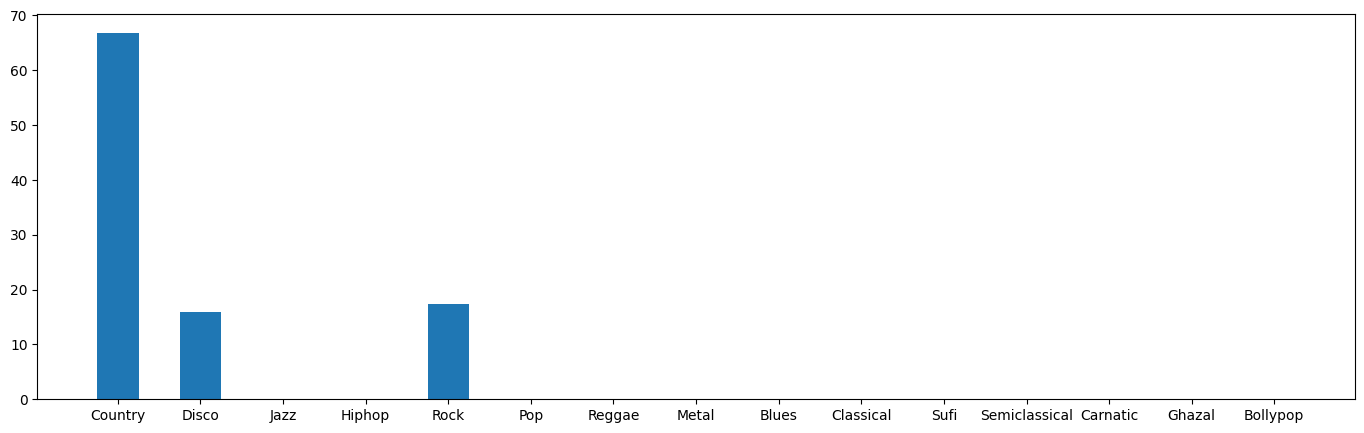

1

In [ ]:
getNeighbors_fuzzy(trainingSet, testSet[22],5)

In [ ]:
getNeighbors(trainingSet, testSet[22],5)

[1, 1, 1, 5, 2]

###Accuracy Calculation:

[86.50810259  0.          0.         13.49189741  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


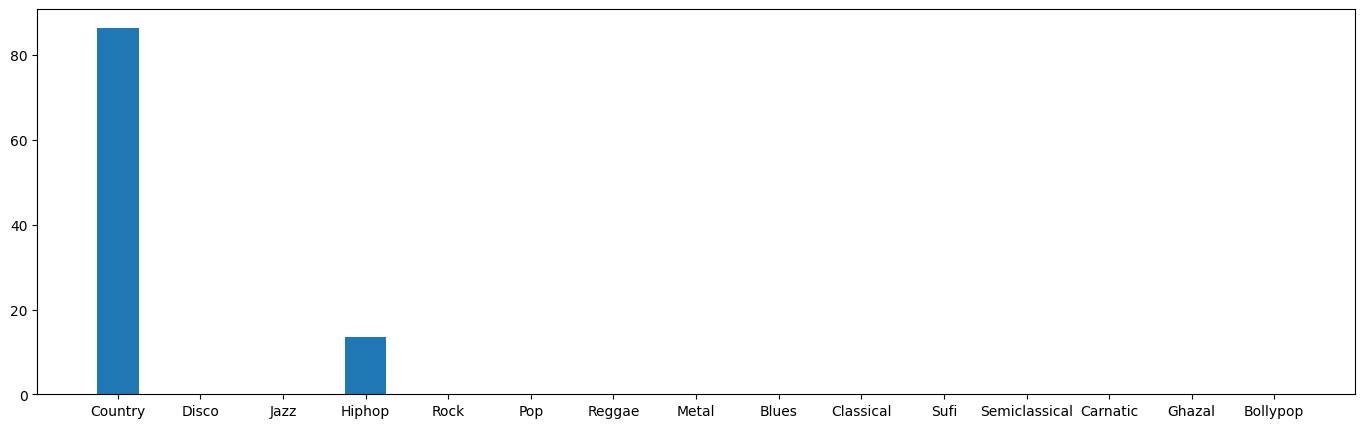

[82.60246342  0.          0.          0.          0.          0.
 17.39753658  0.          0.          0.          0.          0.
  0.          0.          0.        ]


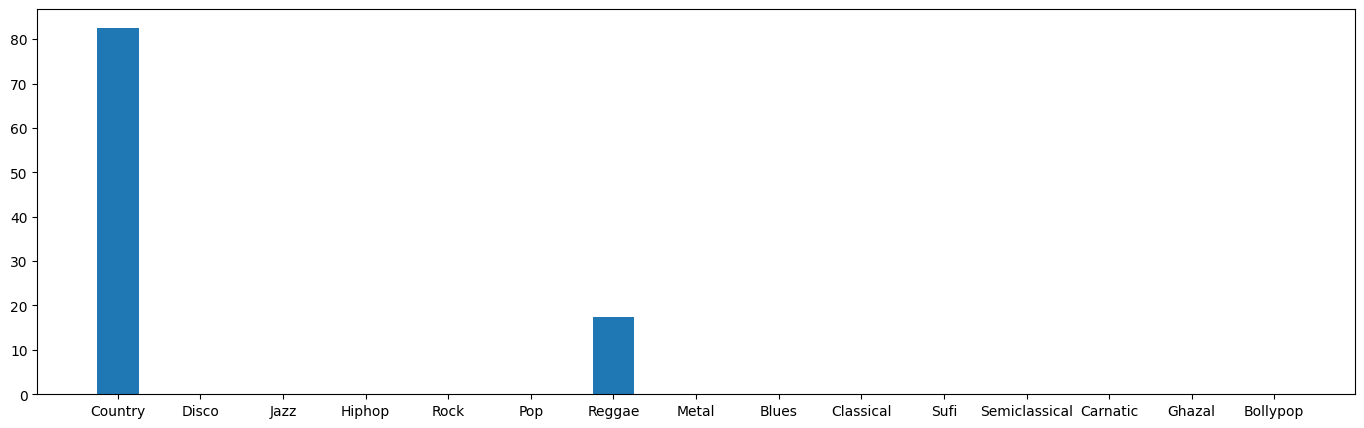

[ 0.         18.67556336  0.          0.         37.57848794 43.7459487
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


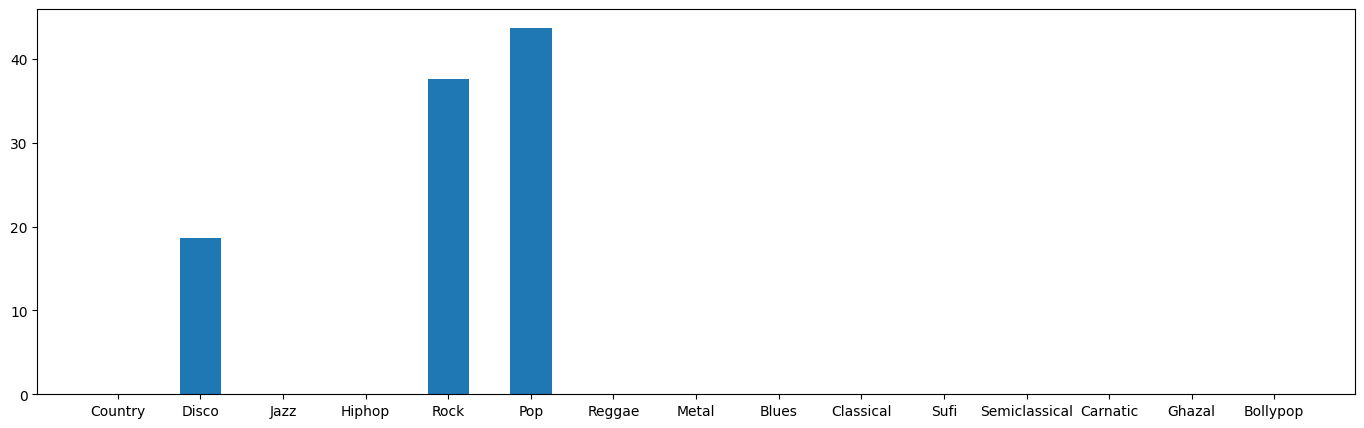

[21.17382173  0.          0.         15.7006611   0.          0.
 63.12551717  0.          0.          0.          0.          0.
  0.          0.          0.        ]


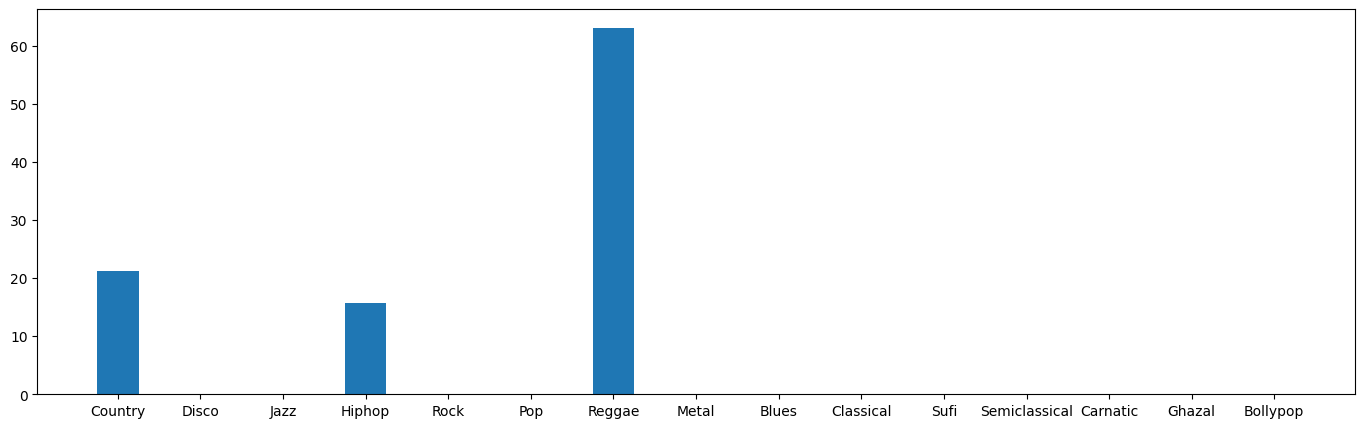

[60.98112989 21.20960047  0.          0.          0.         17.80926964
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


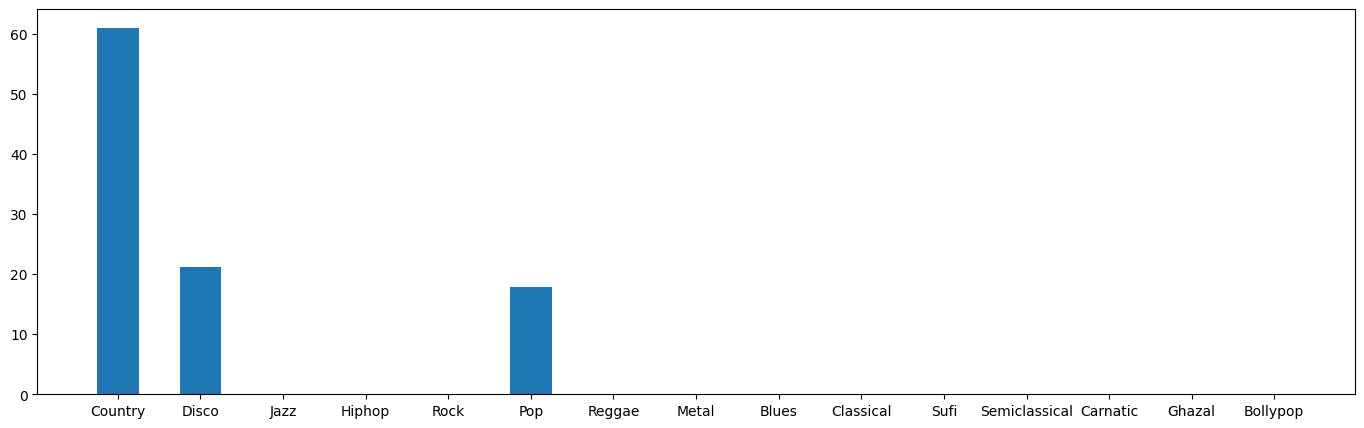

[62.0996265   0.          0.         19.35765459 18.54271891  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


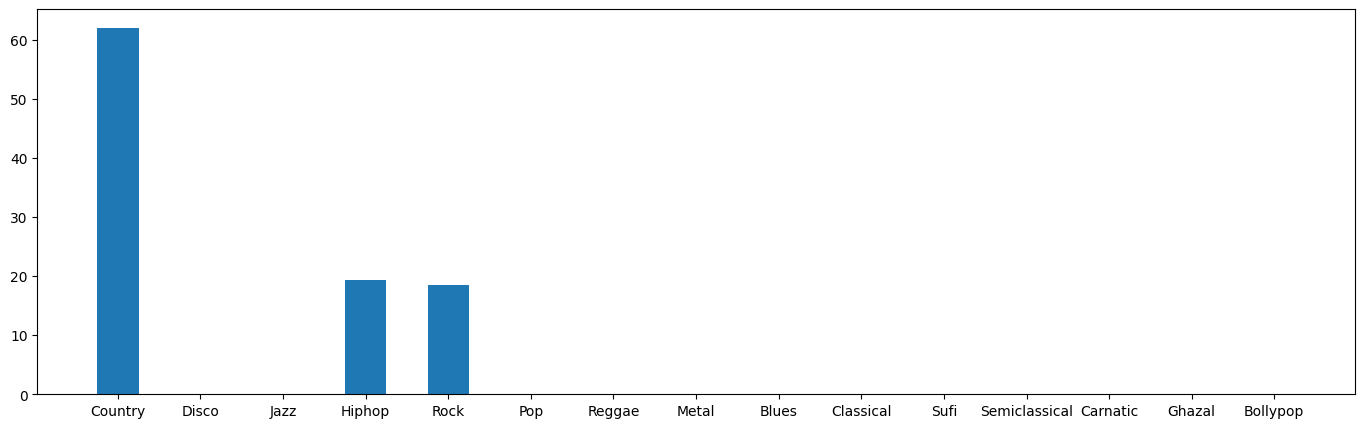

[45.89761348  0.          0.         18.27585278  0.         18.41713867
 17.40939507  0.          0.          0.          0.          0.
  0.          0.          0.        ]


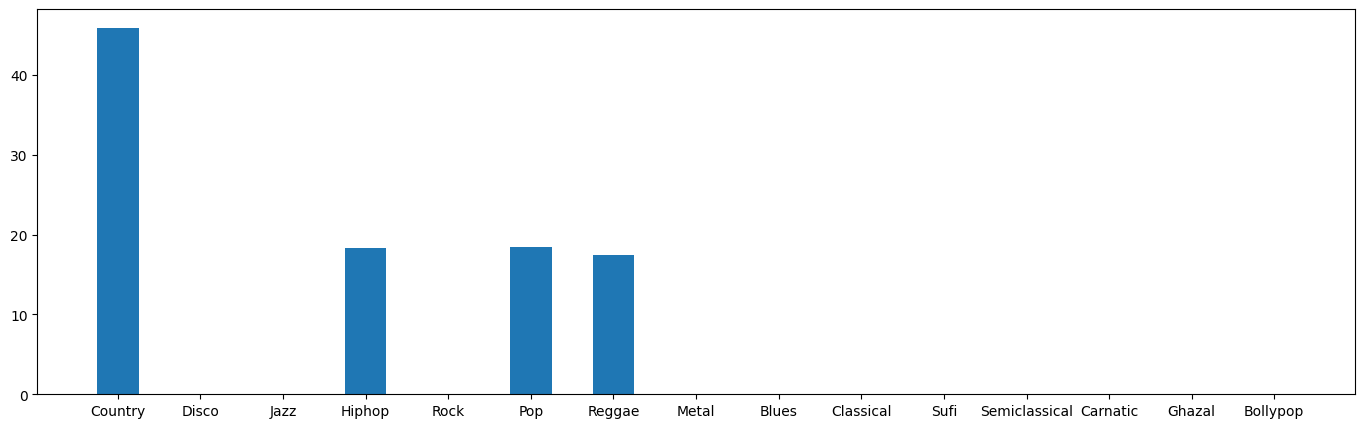

[23.35126962  0.          0.          0.          0.         19.36750527
 57.28122511  0.          0.          0.          0.          0.
  0.          0.          0.        ]


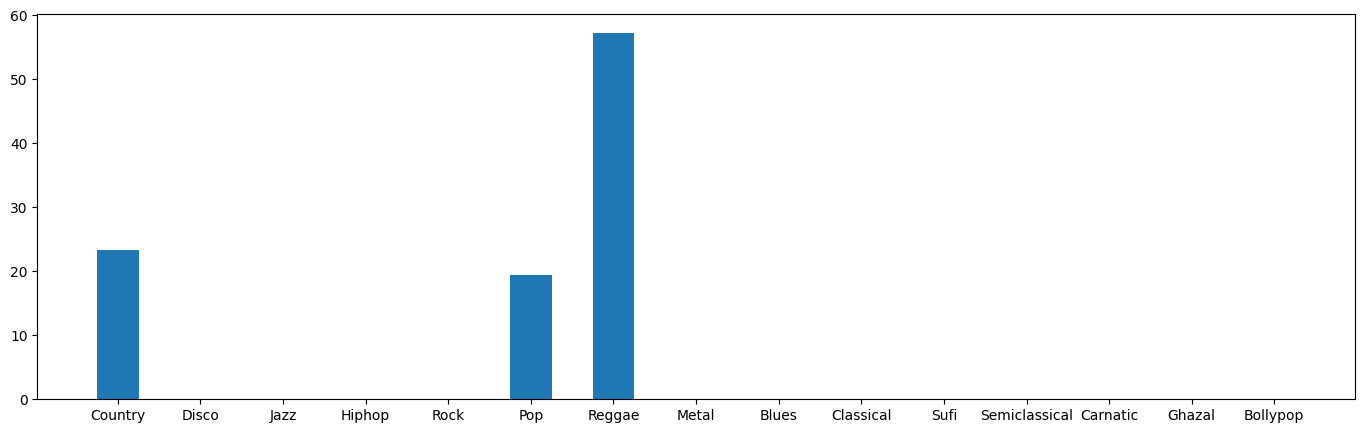

[64.19682009  0.          0.          0.          0.          0.
 17.42283244  0.          0.         18.38034747  0.          0.
  0.          0.          0.        ]


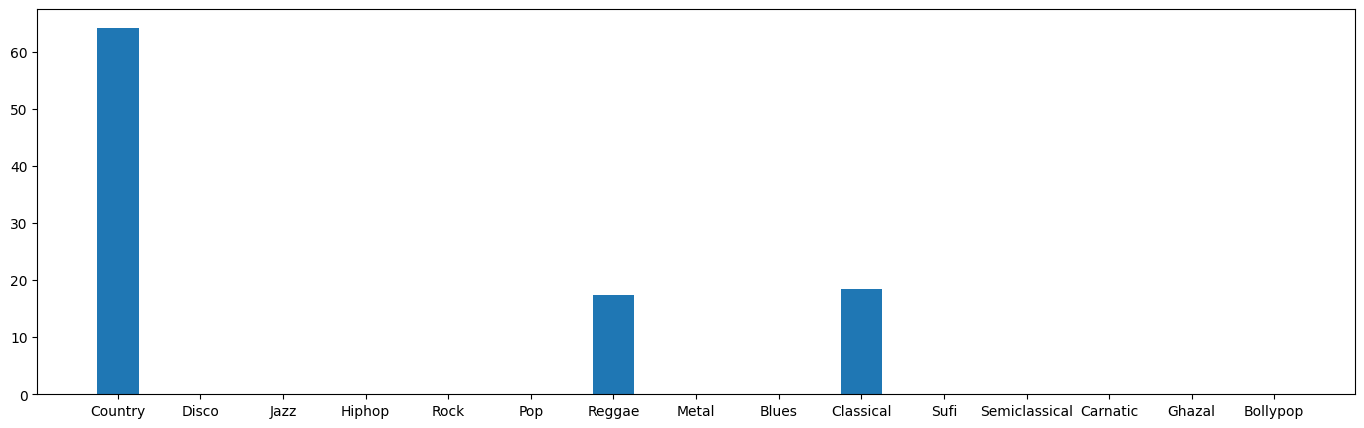

[85.58460685  0.          0.          0.         14.41539315  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


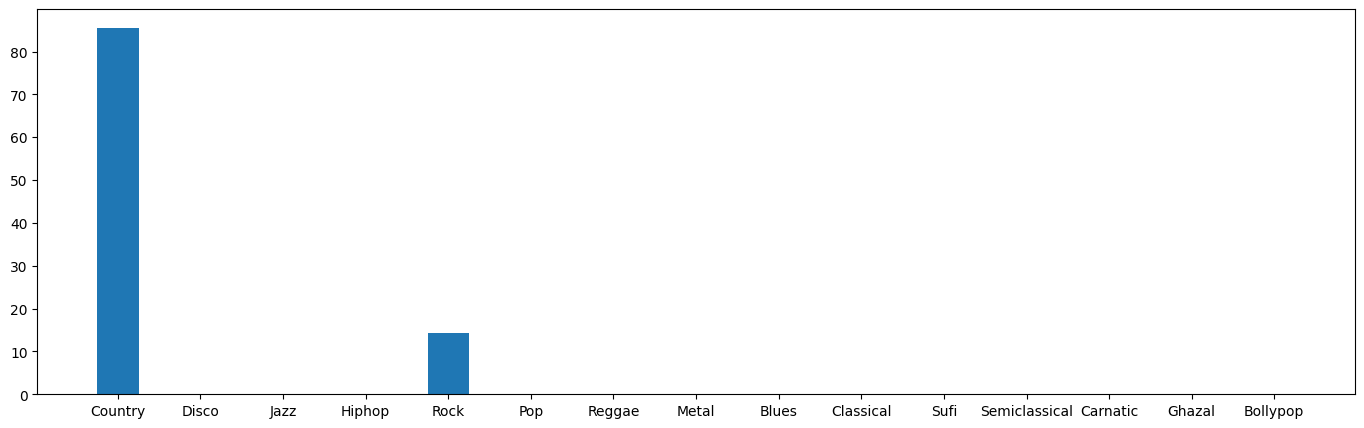

[48.05346059  0.          0.         35.22788224 16.71865717  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


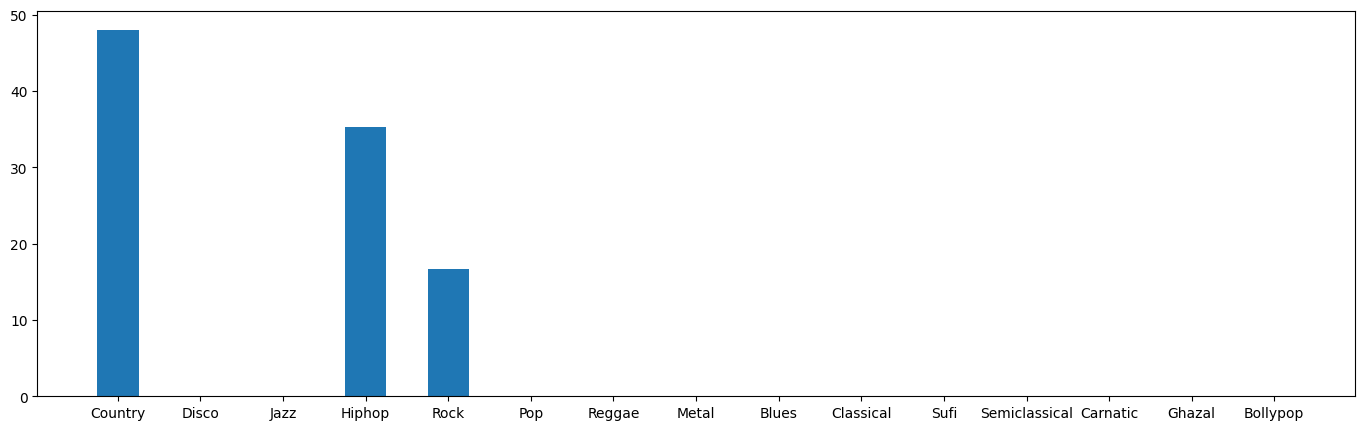

[21.45956796  0.          0.         18.02372947  0.          0.
 60.51670257  0.          0.          0.          0.          0.
  0.          0.          0.        ]


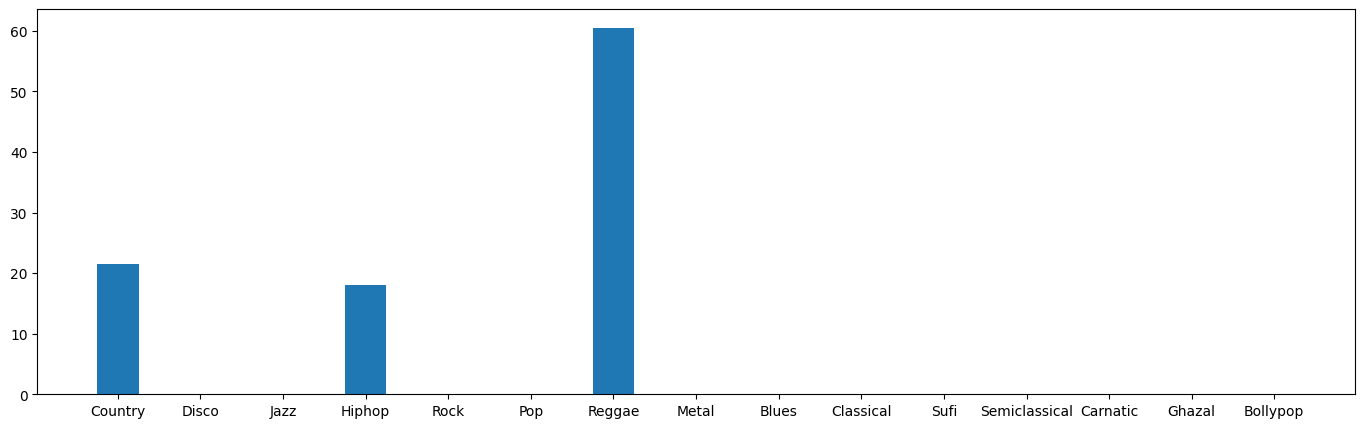

[38.01035896 18.76485476  0.          0.         20.37786171  0.
 22.84692456  0.          0.          0.          0.          0.
  0.          0.          0.        ]


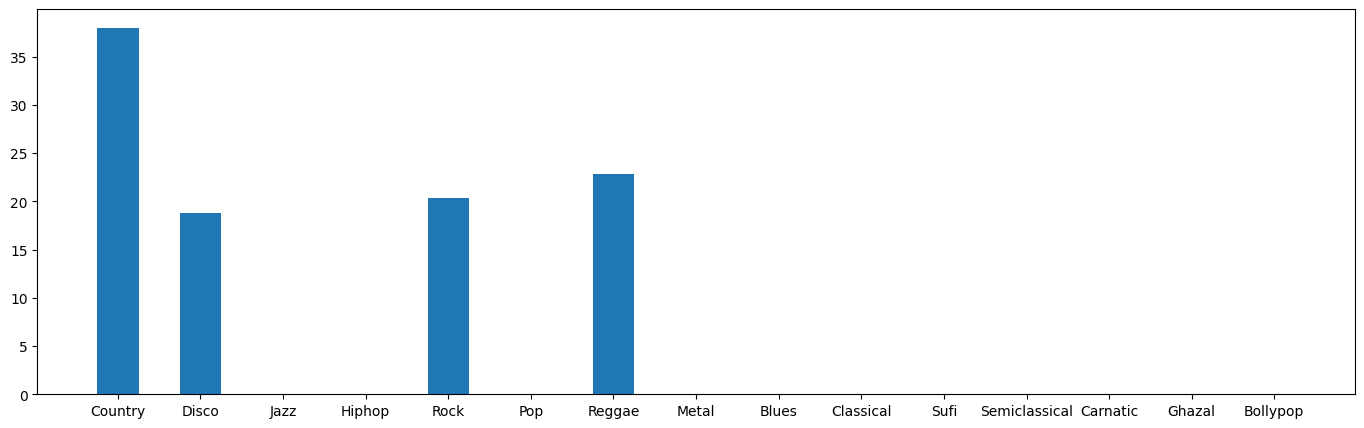

[ 0.         38.76639531  0.          0.         24.57465935 36.65894534
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


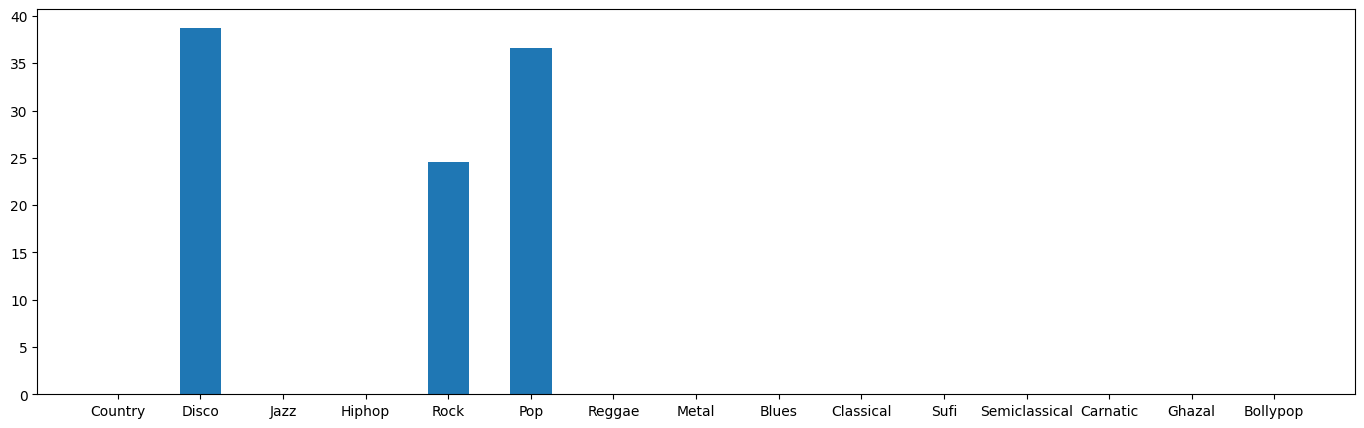

[21.05963248  0.          0.          0.          0.          0.
 78.94036752  0.          0.          0.          0.          0.
  0.          0.          0.        ]


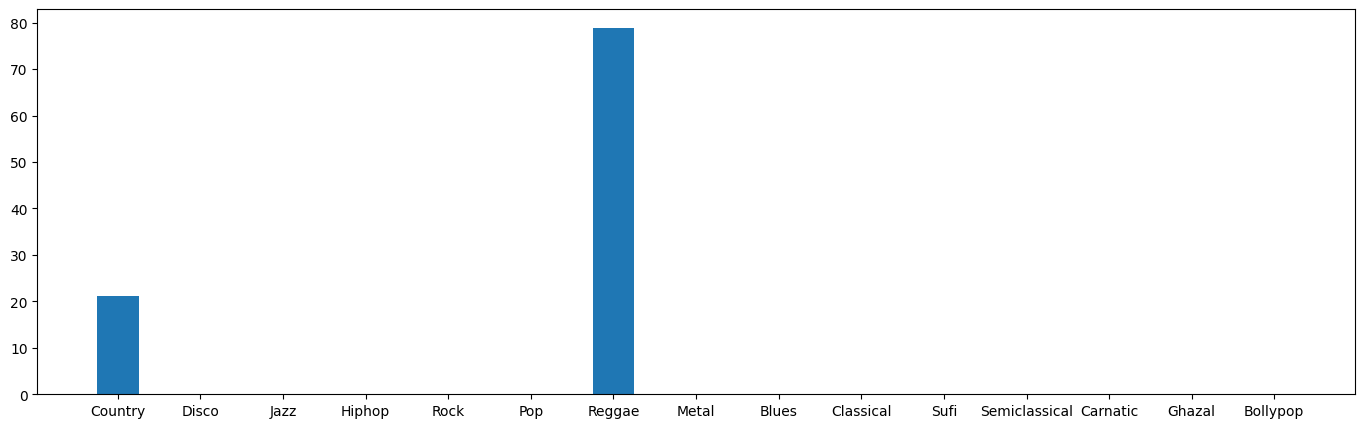

[ 0.          0.          0.         36.81236165 26.51436922 18.33756044
 18.33570869  0.          0.          0.          0.          0.
  0.          0.          0.        ]


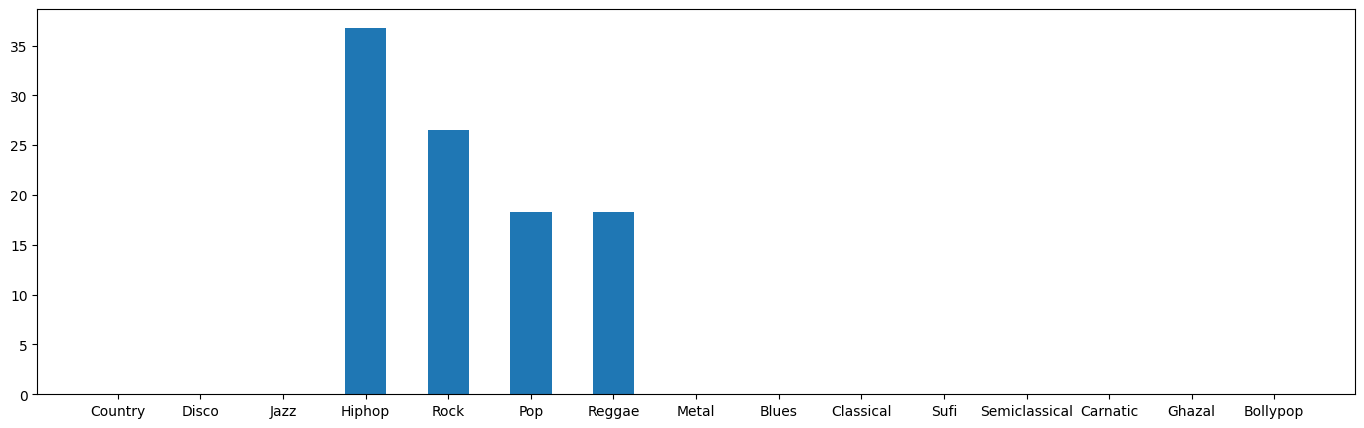

[44.91961399 18.09922613  0.          0.         36.98115988  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


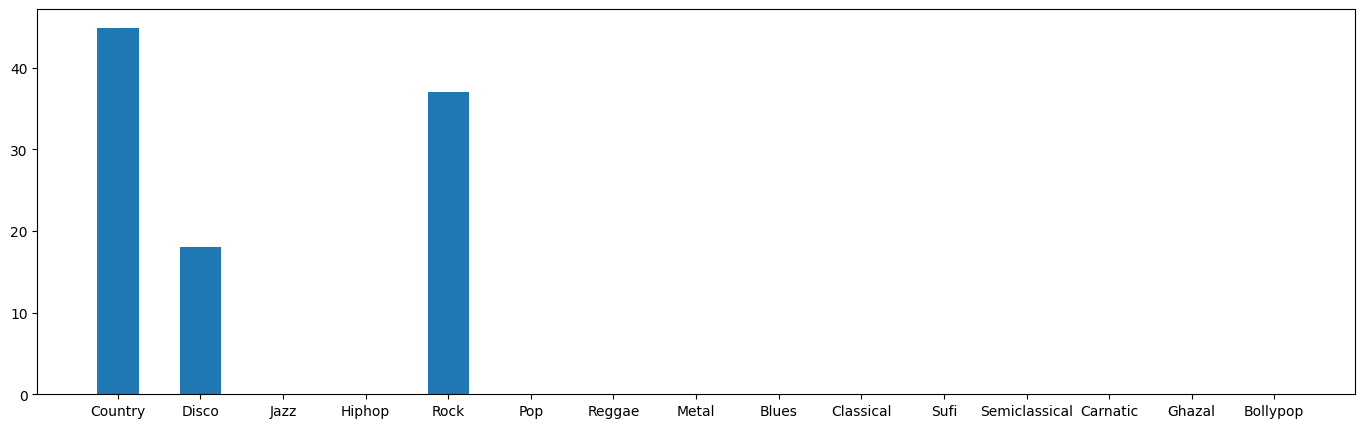

[63.82187745  0.          0.         19.07254296  0.          0.
 17.10557959  0.          0.          0.          0.          0.
  0.          0.          0.        ]


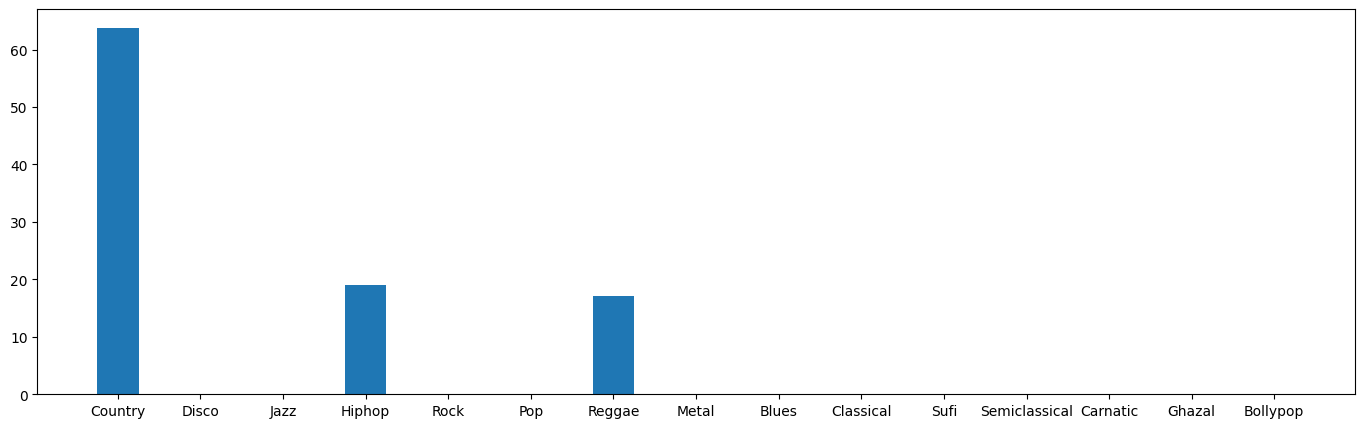

[38.90092047  0.          0.          0.          0.          0.
 19.49243418  0.         41.60664535  0.          0.          0.
  0.          0.          0.        ]


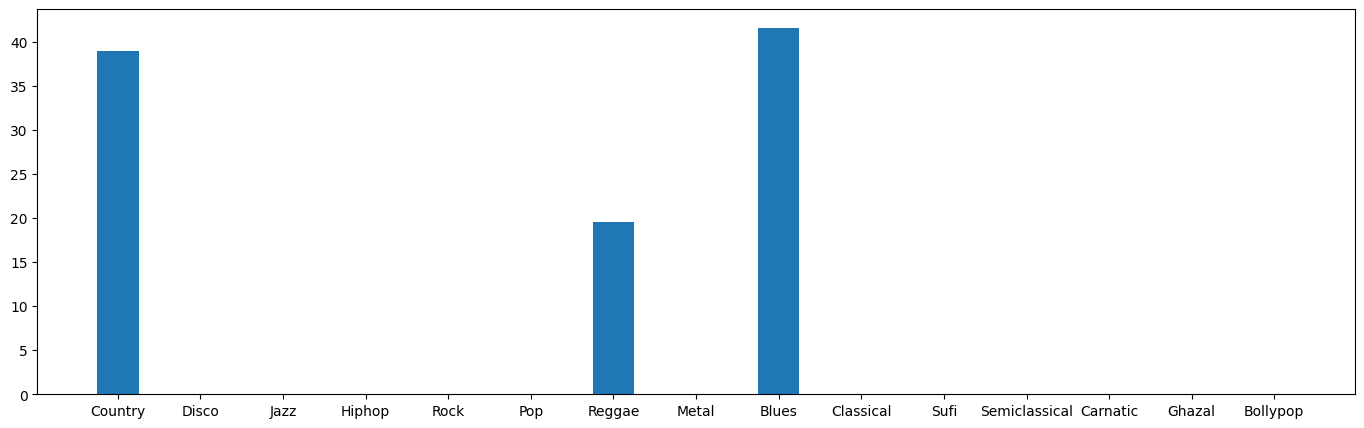

[80.86629378  0.          0.         19.13370622  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


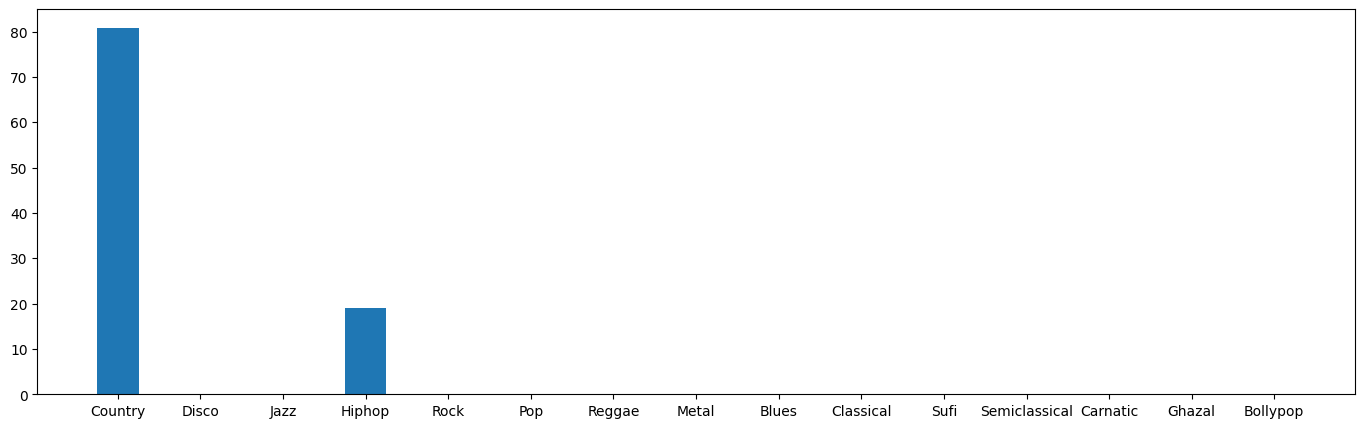

[62.87729796  0.          0.         19.09444794  0.          0.
 18.0282541   0.          0.          0.          0.          0.
  0.          0.          0.        ]


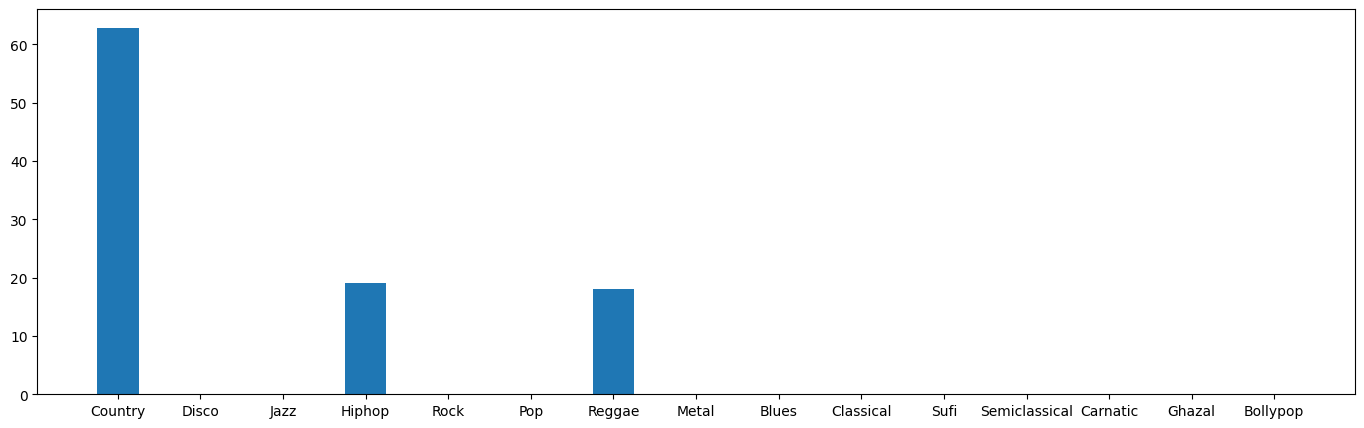

[ 0.          0.          0.         39.87095982 21.18152699  0.
 38.94751319  0.          0.          0.          0.          0.
  0.          0.          0.        ]


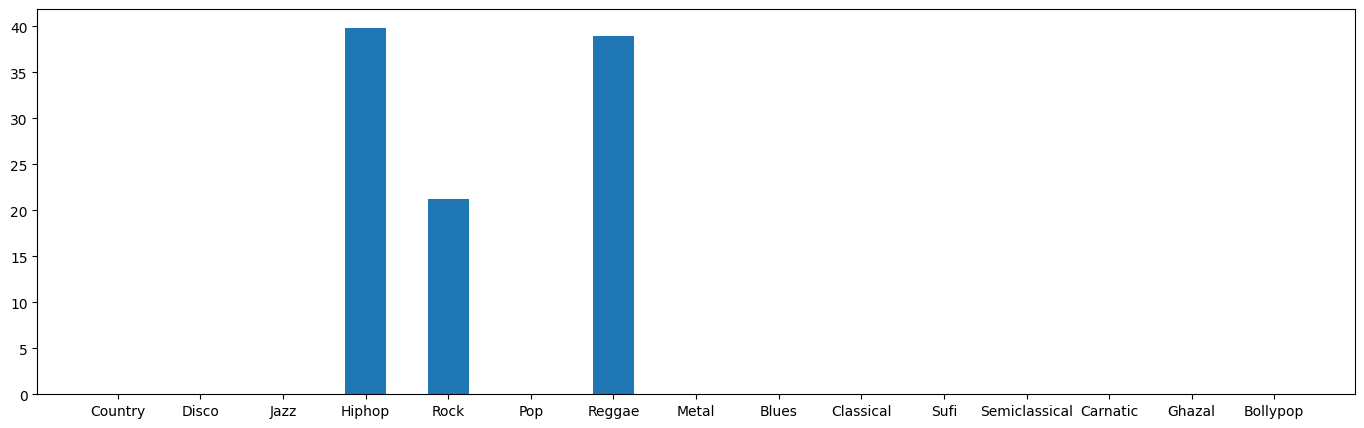

[66.839104   15.84955611  0.          0.         17.31133989  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


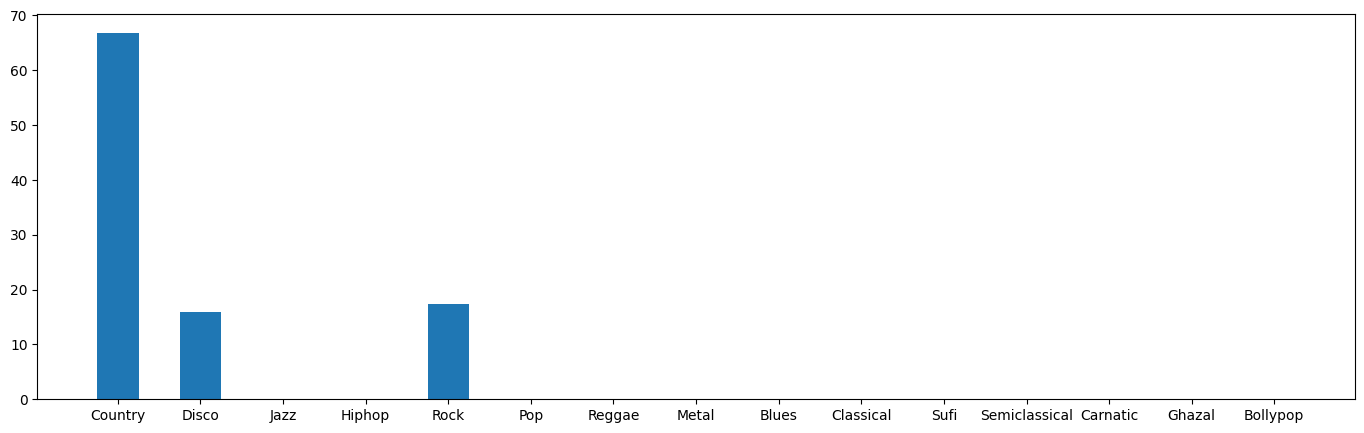

[80.72069807  0.          0.          0.          0.          0.
  0.          0.         19.27930193  0.          0.          0.
  0.          0.          0.        ]


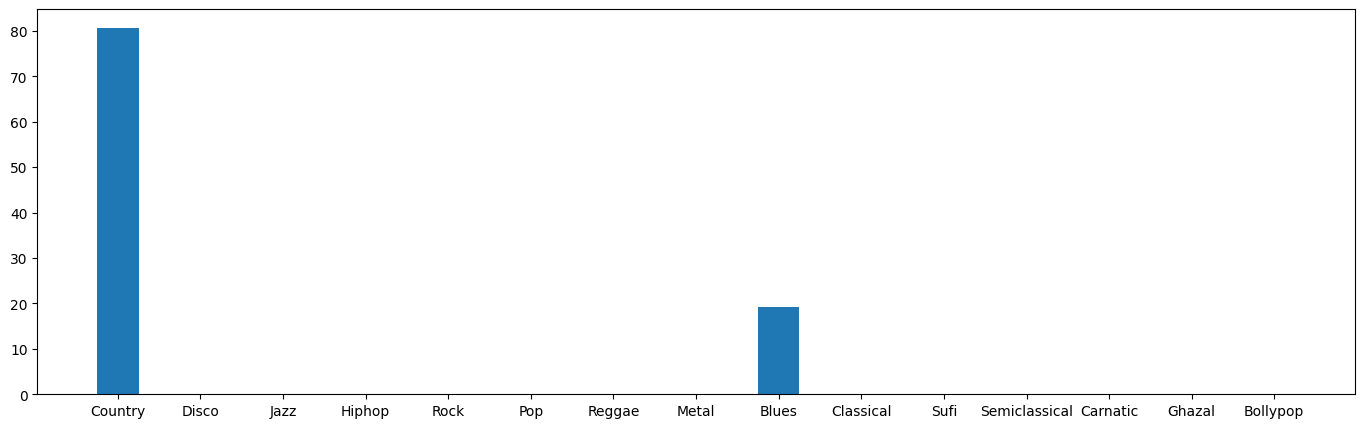

[60.43021621  0.          0.         19.04763579 20.522148    0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


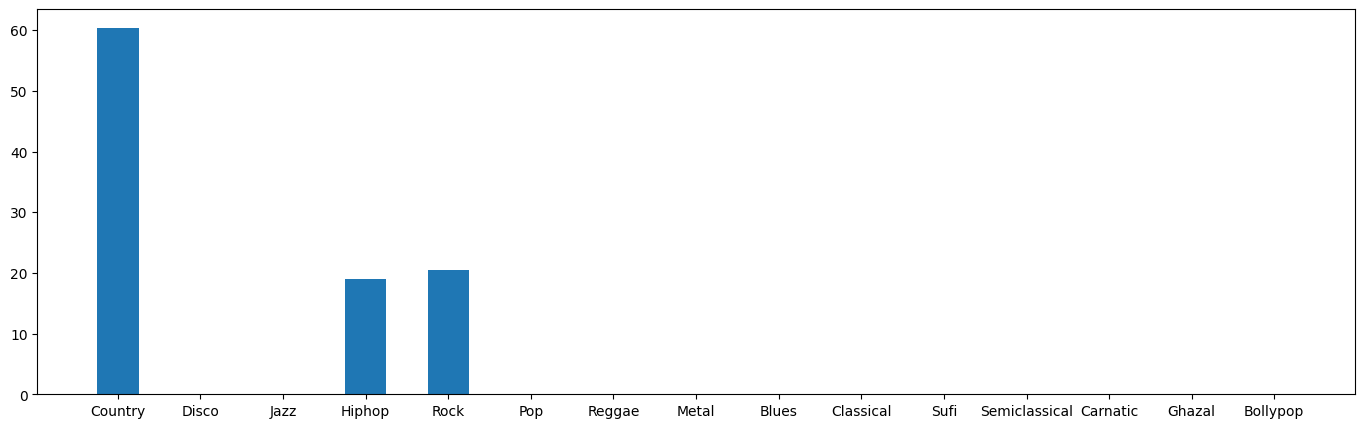

[39.3911657  0.         0.         0.         0.         0.
 60.6088343  0.         0.         0.         0.         0.
  0.         0.         0.       ]


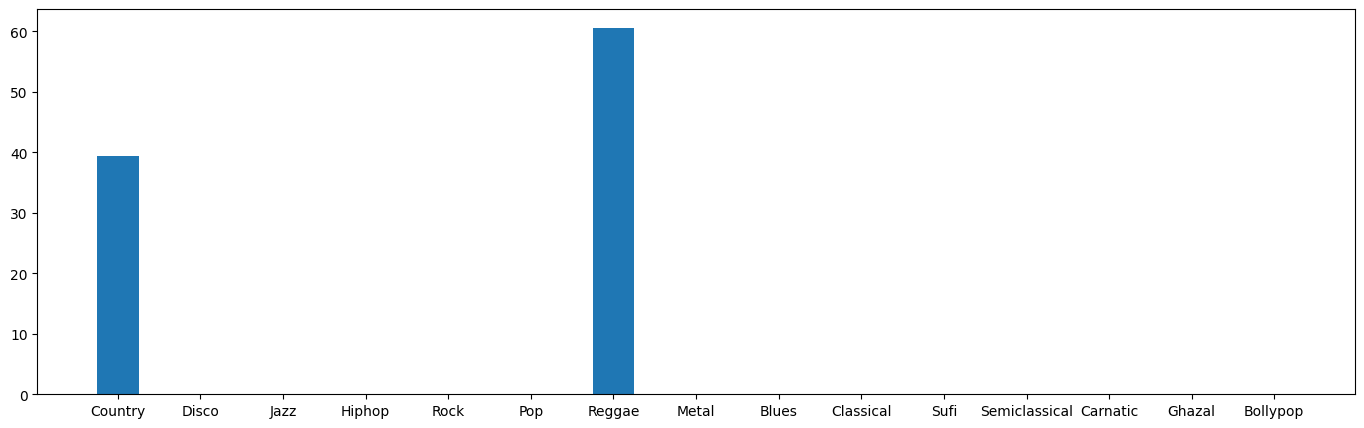

[83.26298195 16.73701805  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


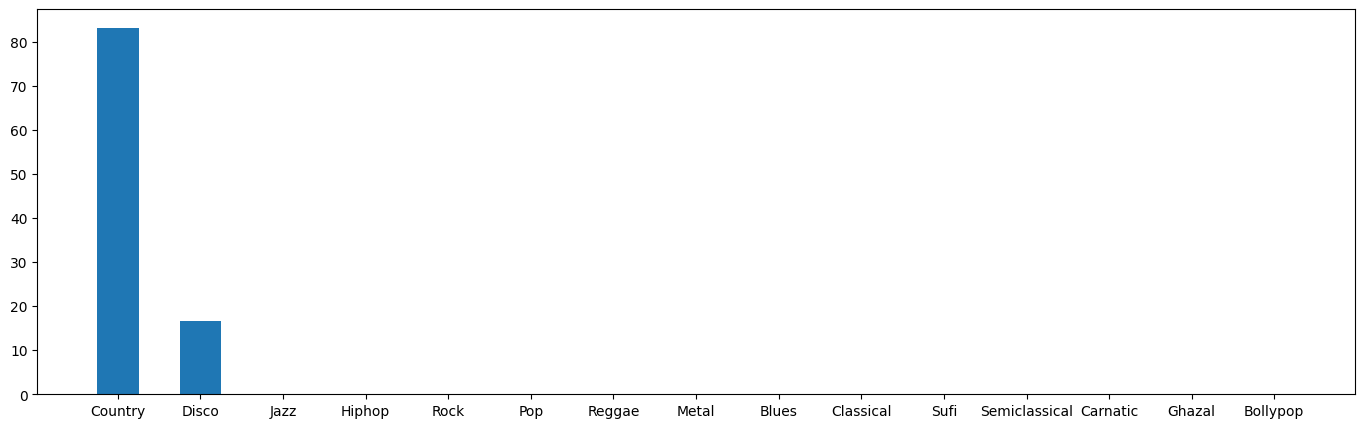

[62.02643328  0.          0.          0.          0.          0.
 37.97356672  0.          0.          0.          0.          0.
  0.          0.          0.        ]


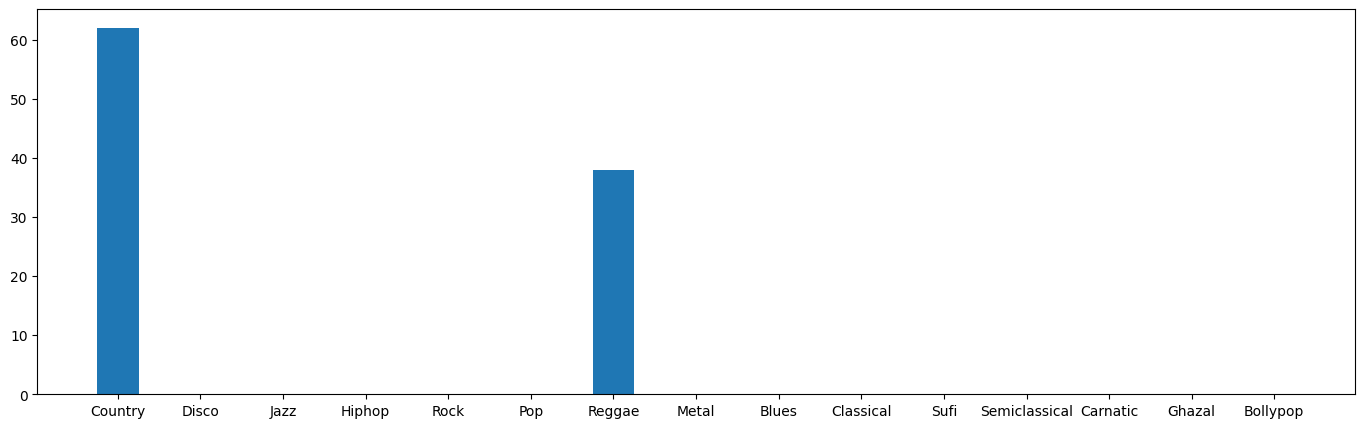

[65.036309  0.        0.        0.        0.        0.       34.963691
  0.        0.        0.        0.        0.        0.        0.
  0.      ]


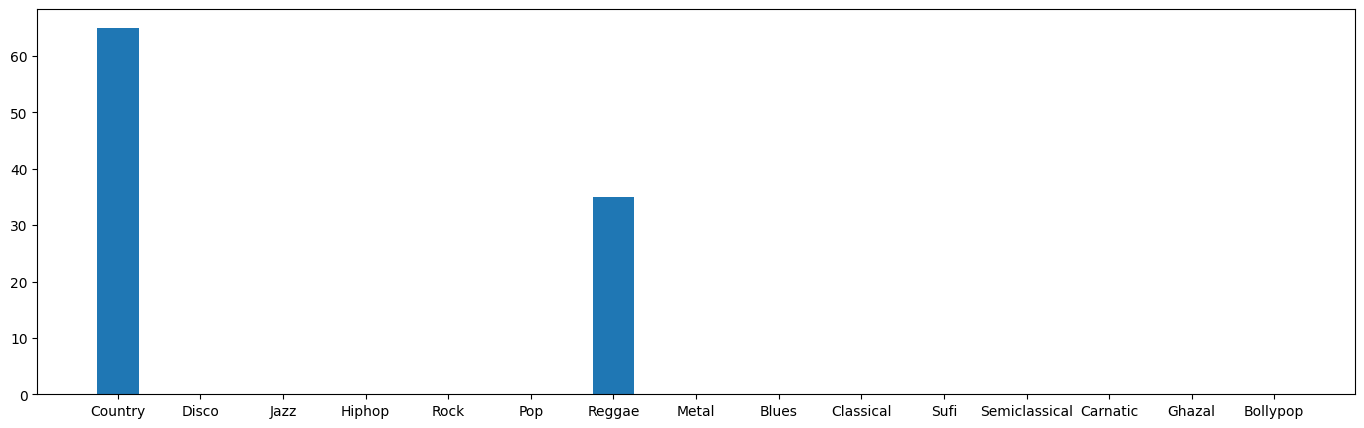

[41.16713261  0.          0.          0.          0.          0.
  0.          0.         58.83286739  0.          0.          0.
  0.          0.          0.        ]


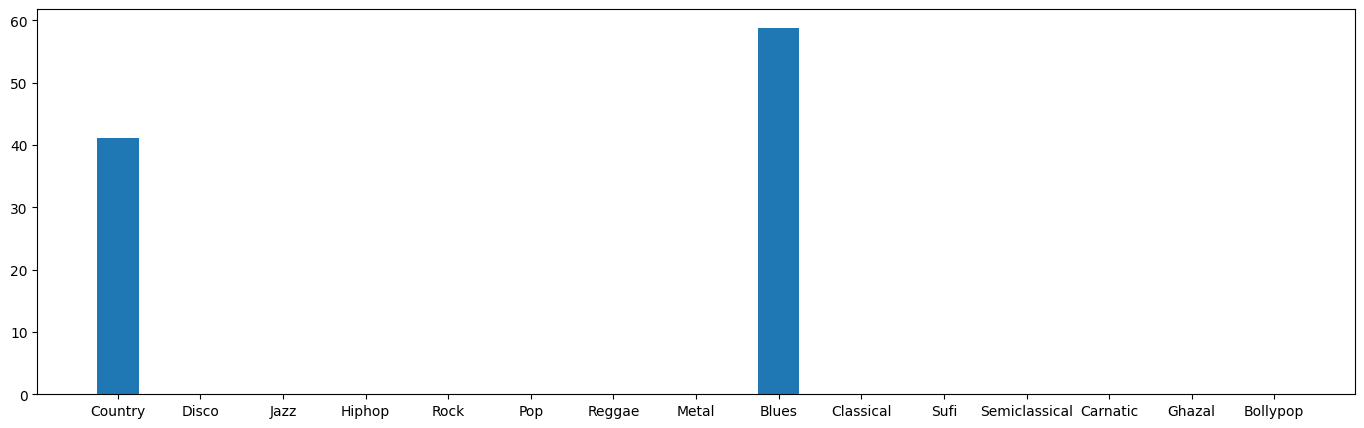

[40.43626415 19.47280089  0.         22.71571212  0.          0.
 17.37522284  0.          0.          0.          0.          0.
  0.          0.          0.        ]


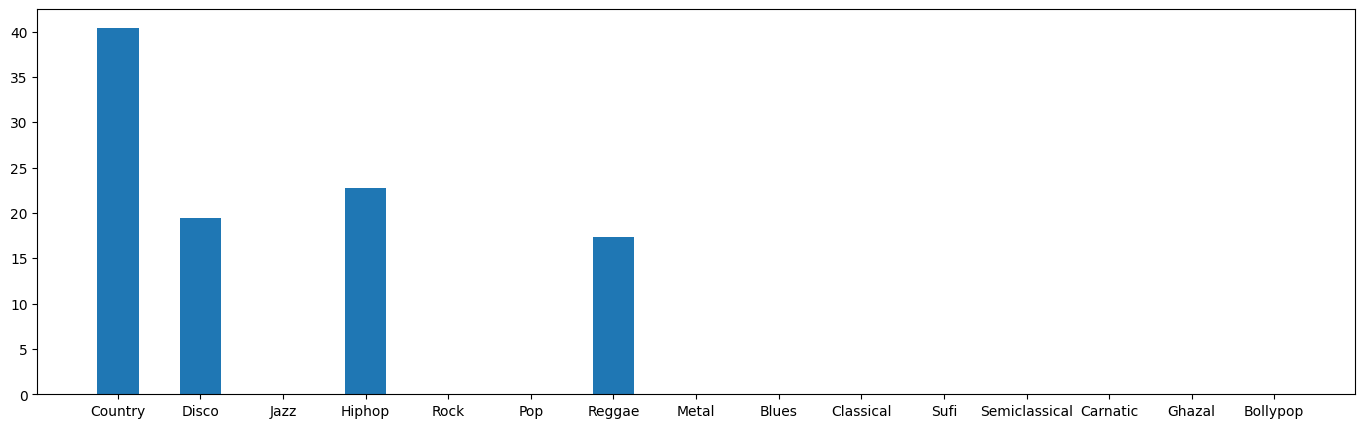

[81.19045432  0.          0.          0.          0.          0.
  0.          0.         18.80954568  0.          0.          0.
  0.          0.          0.        ]


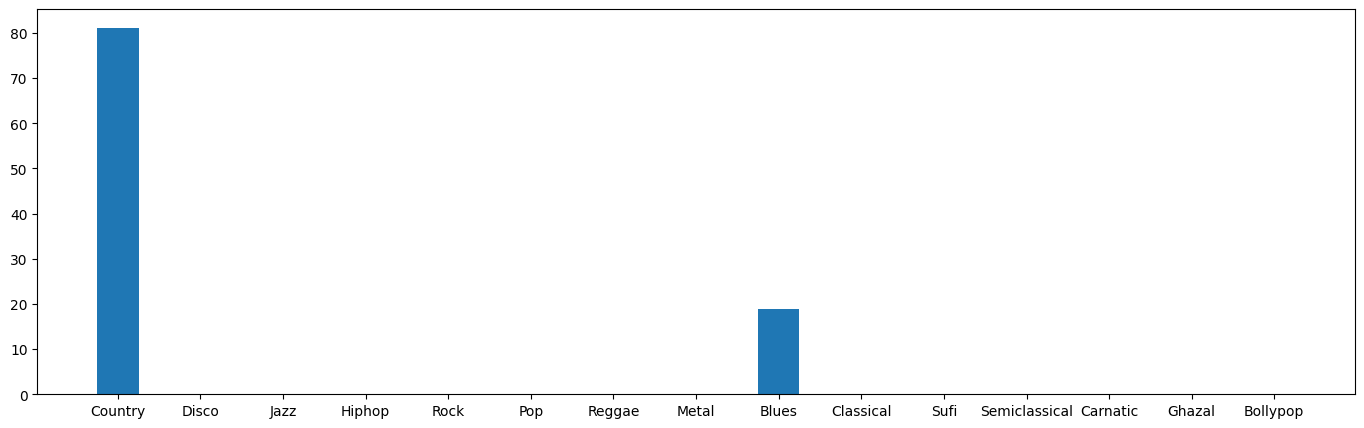

[66.0000029   0.          0.          0.          0.          0.
 16.94901529  0.         17.05098181  0.          0.          0.
  0.          0.          0.        ]


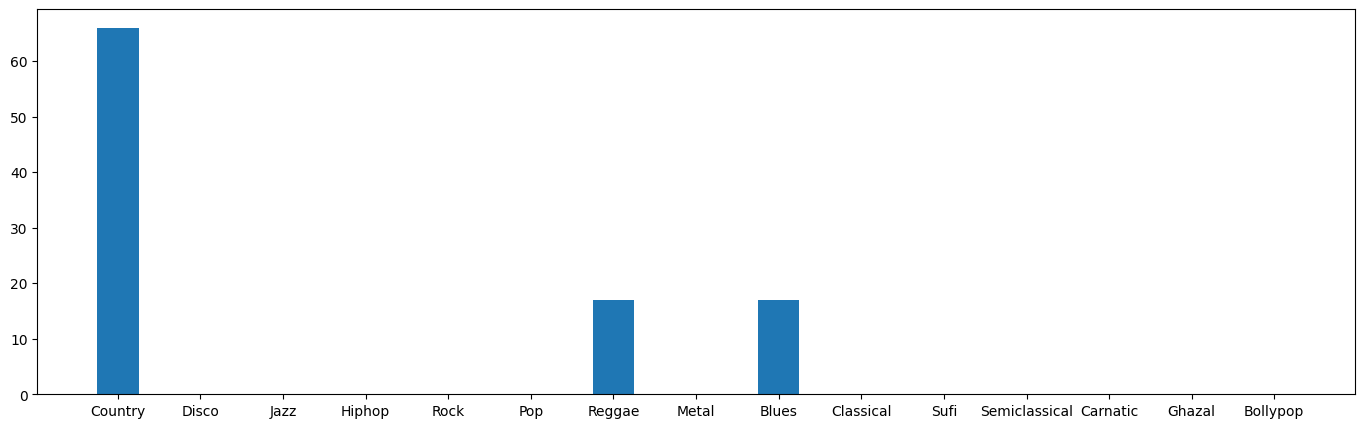

[37.31778819 26.15484664  0.         17.06444088  0.         19.46292429
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


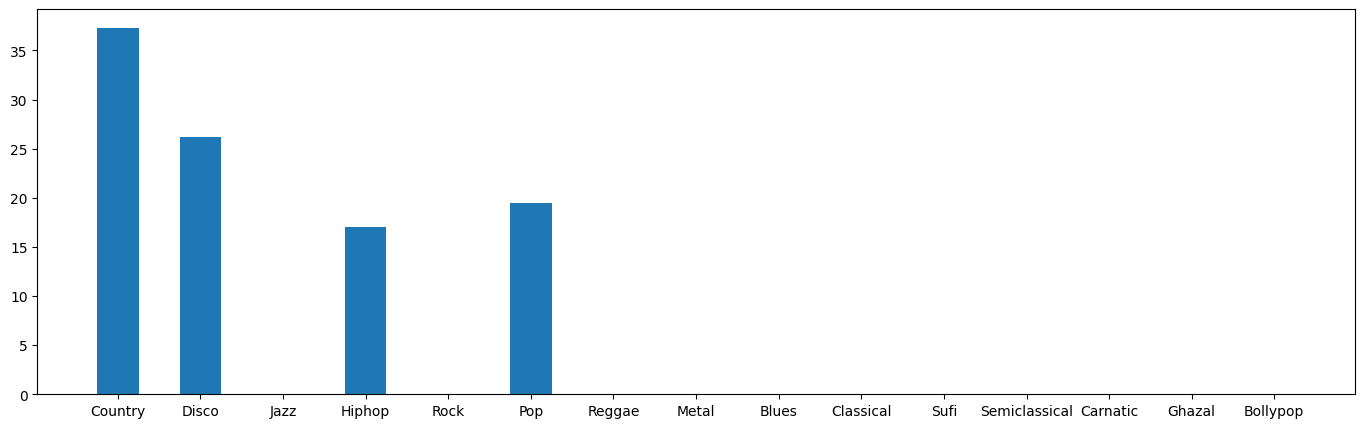

[18.66731076 59.87017961  0.          0.         21.46250963  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


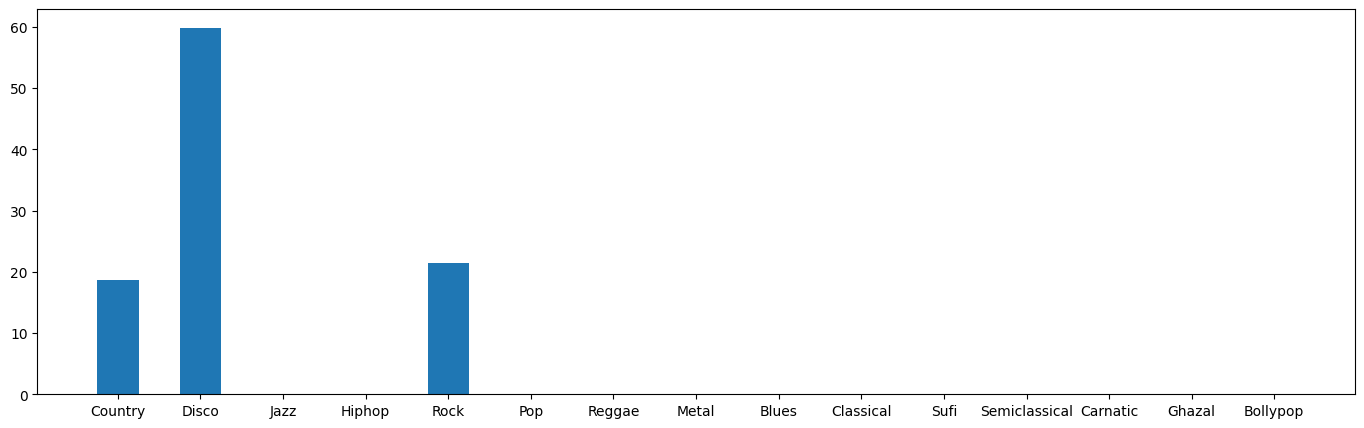

[18.51283792 20.84351281  0.         22.86873412 37.77491516  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


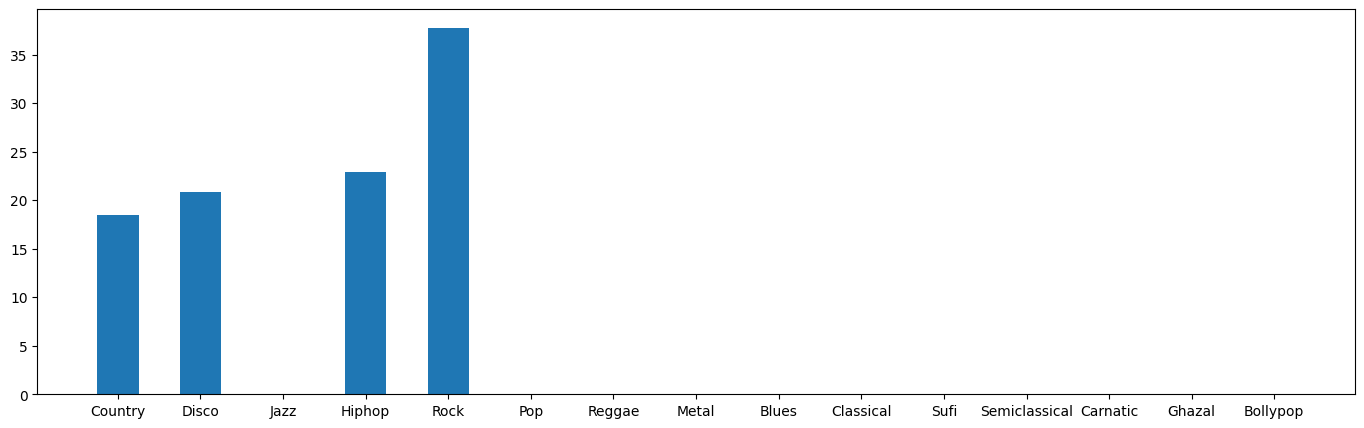

[ 0.         23.95840881  0.         60.05363519 15.987956    0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


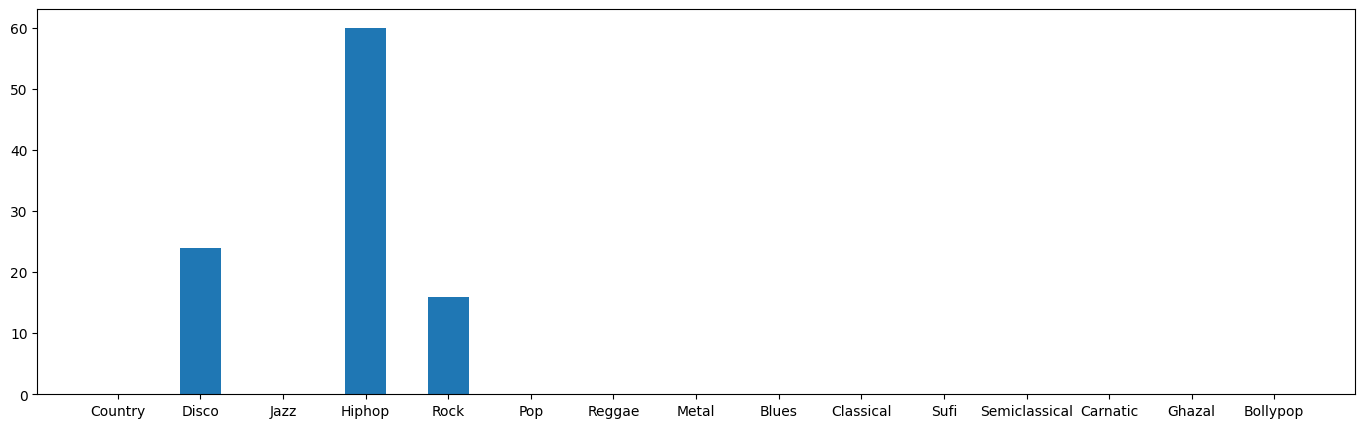

[ 0.         40.25226605  0.          0.          0.         59.74773395
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


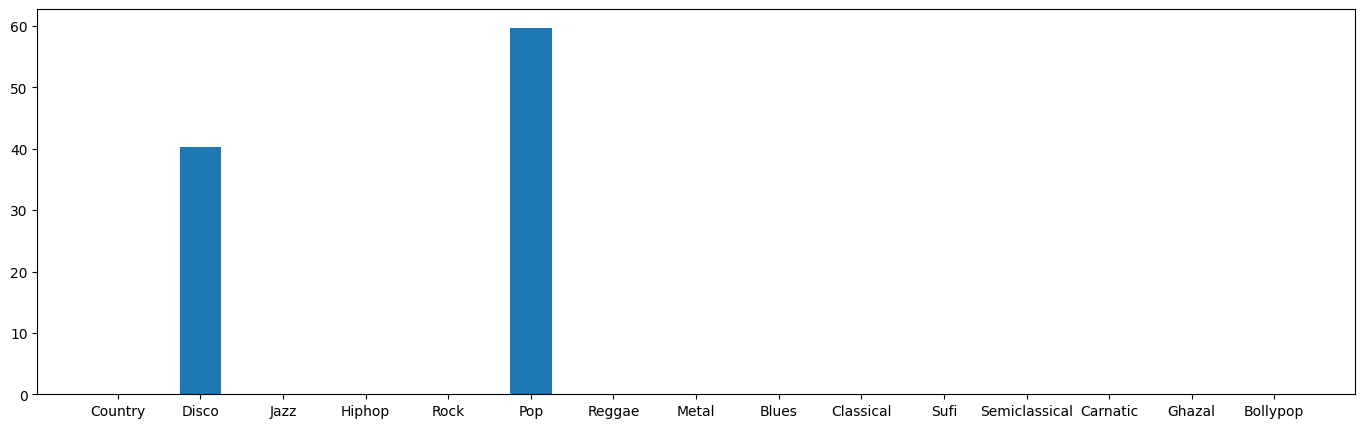

[ 0.         37.30248147  0.          0.          0.         21.58588527
 41.11163327  0.          0.          0.          0.          0.
  0.          0.          0.        ]


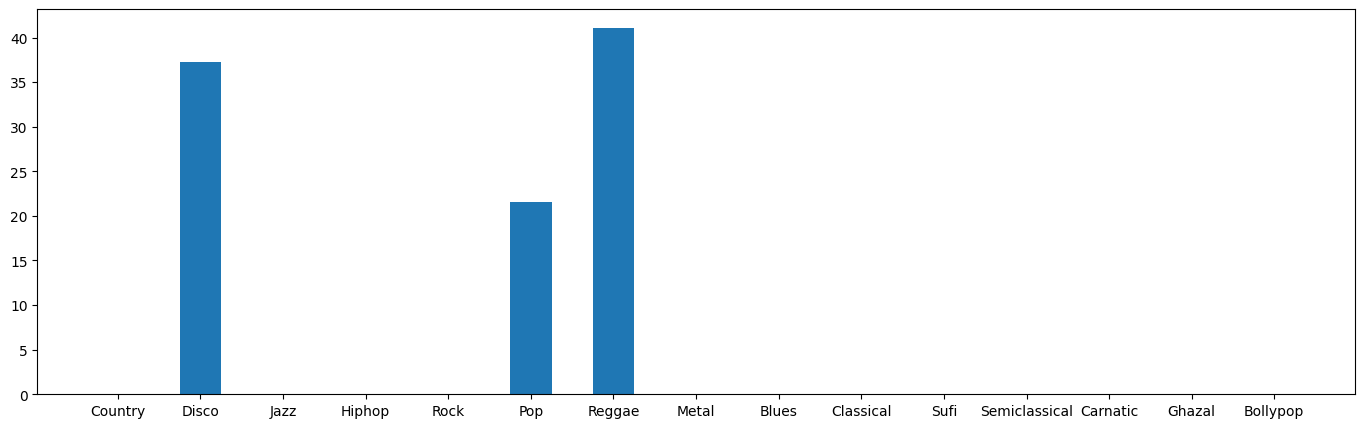

[ 0.          0.          0.         38.90802306  0.          0.
 61.09197694  0.          0.          0.          0.          0.
  0.          0.          0.        ]


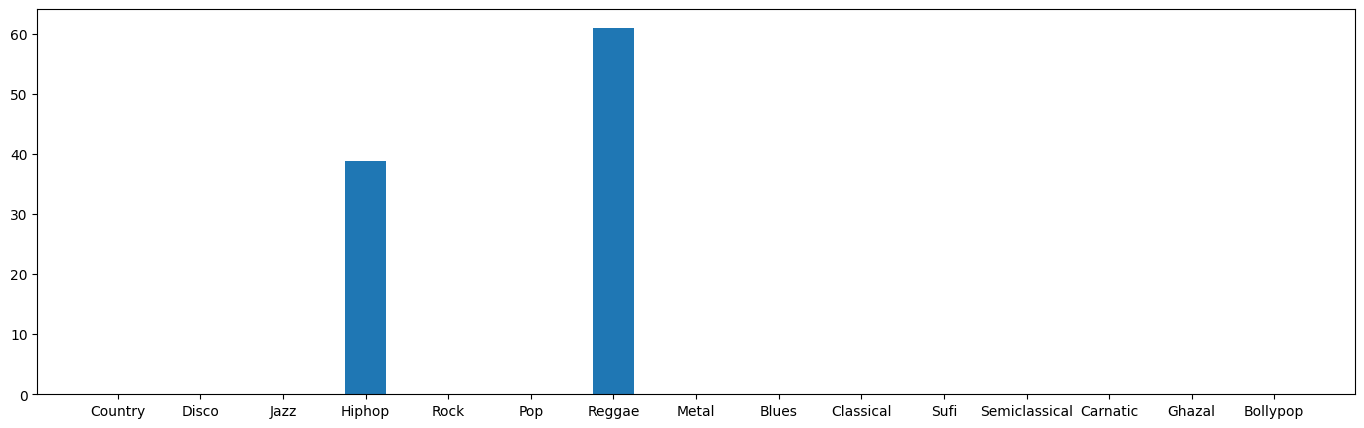

[ 0.         68.5652133   0.          0.         17.12750973  0.
 14.30727697  0.          0.          0.          0.          0.
  0.          0.          0.        ]


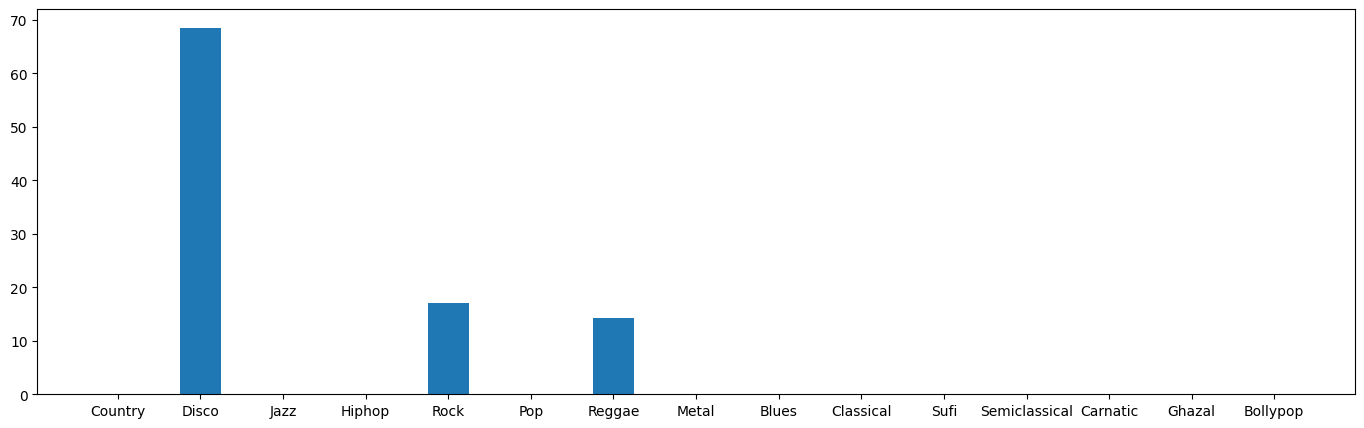

[ 0.         24.55286429  0.          0.          0.         55.95356605
 19.49356966  0.          0.          0.          0.          0.
  0.          0.          0.        ]


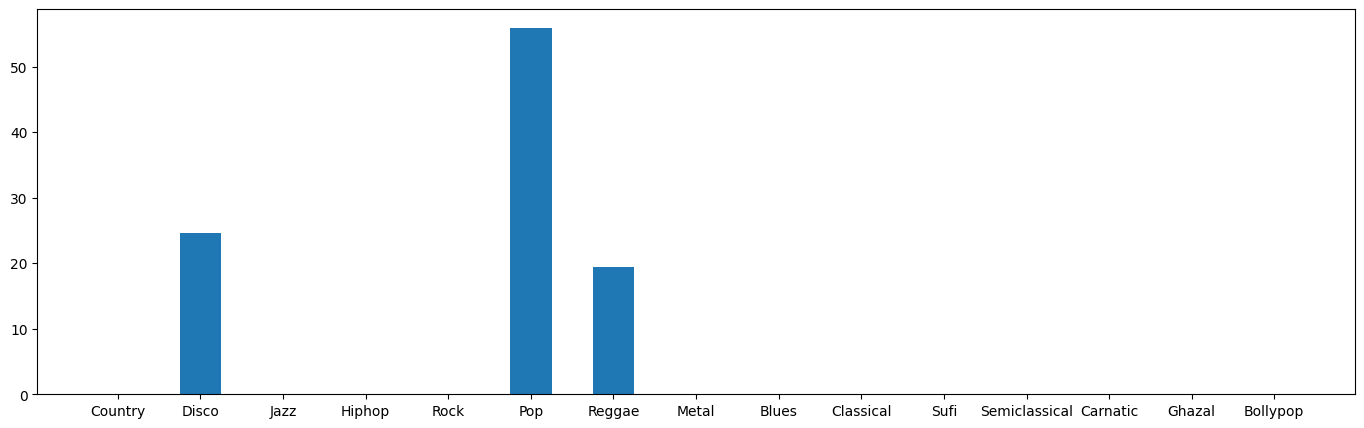

[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


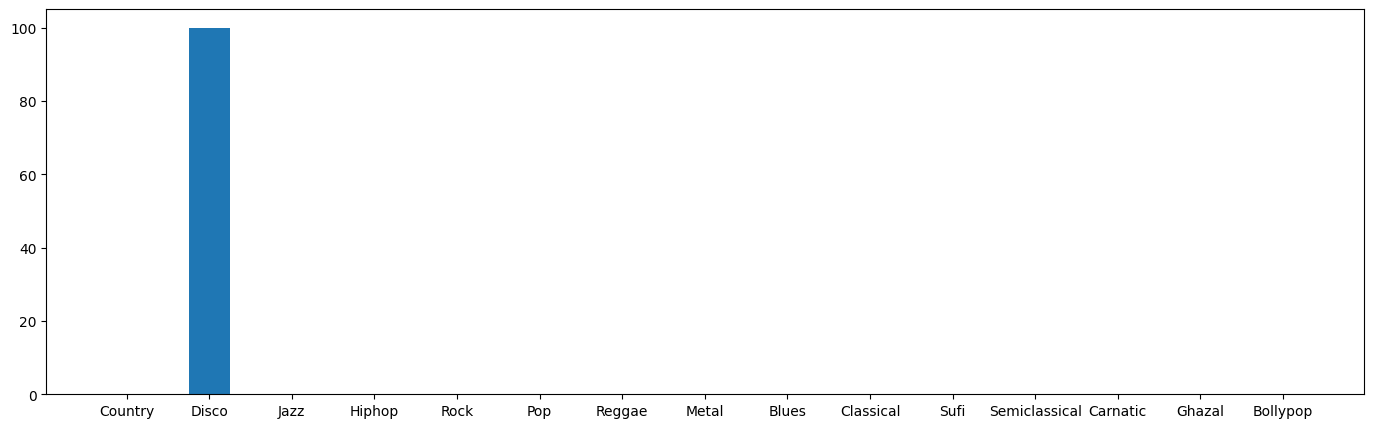

[36.57351823 21.88042336  0.          0.         41.54605841  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


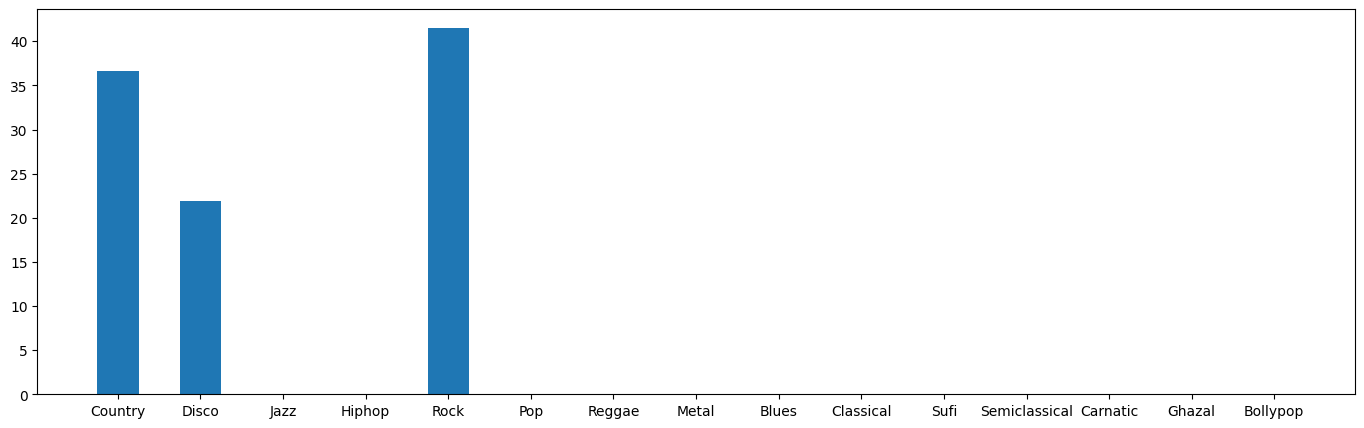

[20.660507   60.32701261  0.          0.          0.          0.
 19.01248039  0.          0.          0.          0.          0.
  0.          0.          0.        ]


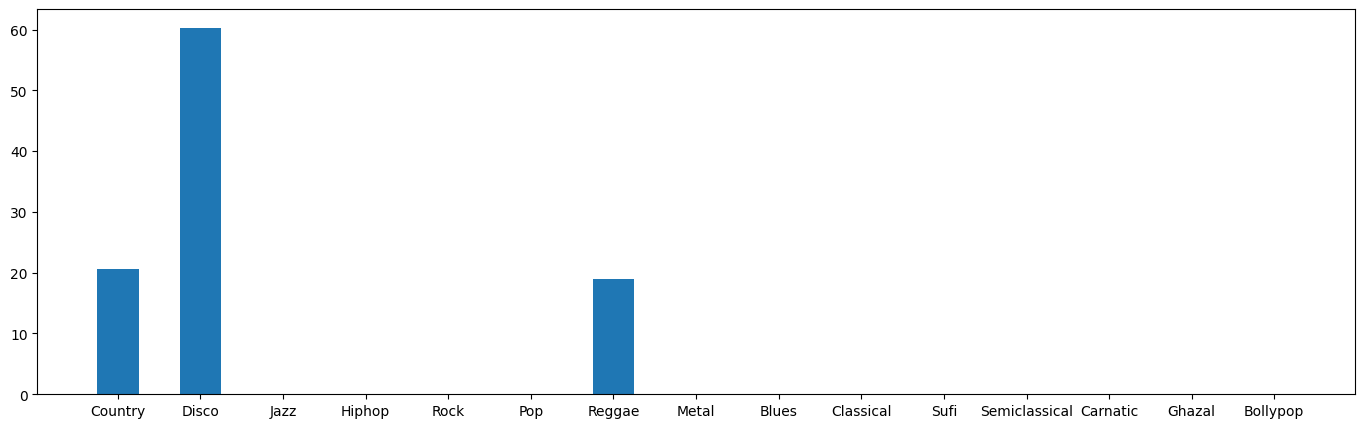

[ 0.         88.08849601  0.          0.          0.          0.
  0.         11.91150399  0.          0.          0.          0.
  0.          0.          0.        ]


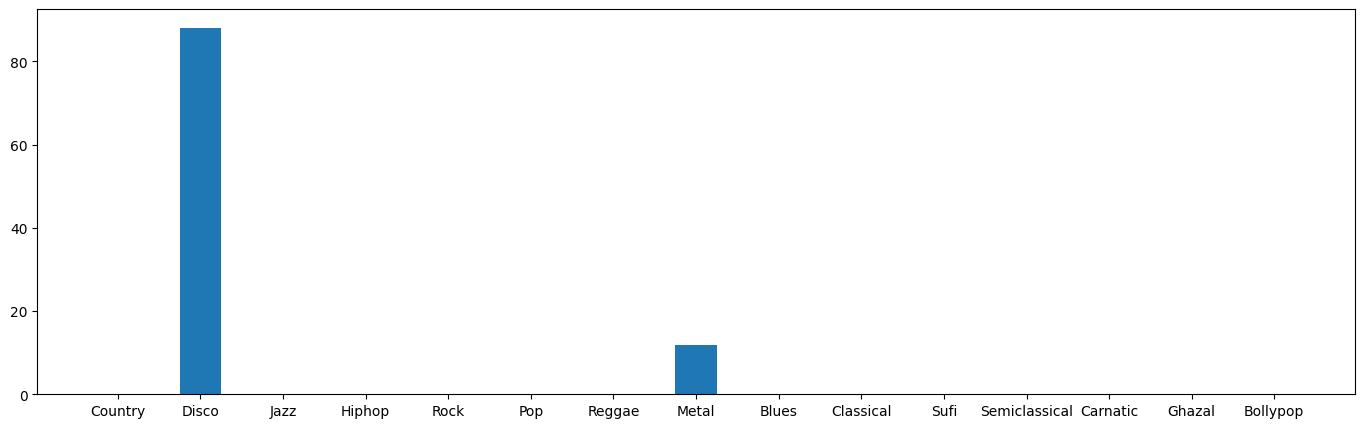

[19.38668753 22.40648276  0.         58.2068297   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


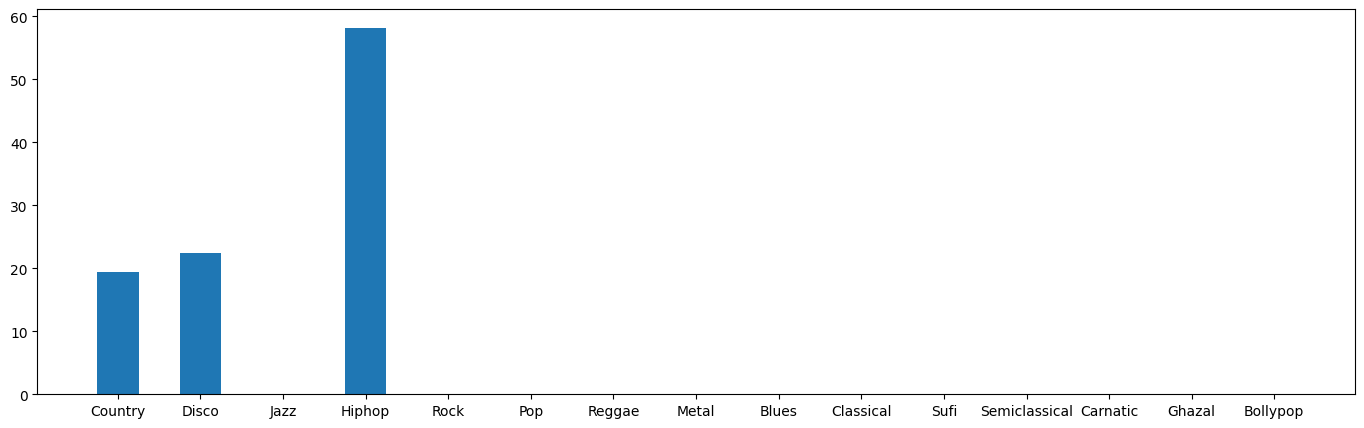

[ 0.         23.62950422  0.          0.         17.40447197  0.
 58.96602382  0.          0.          0.          0.          0.
  0.          0.          0.        ]


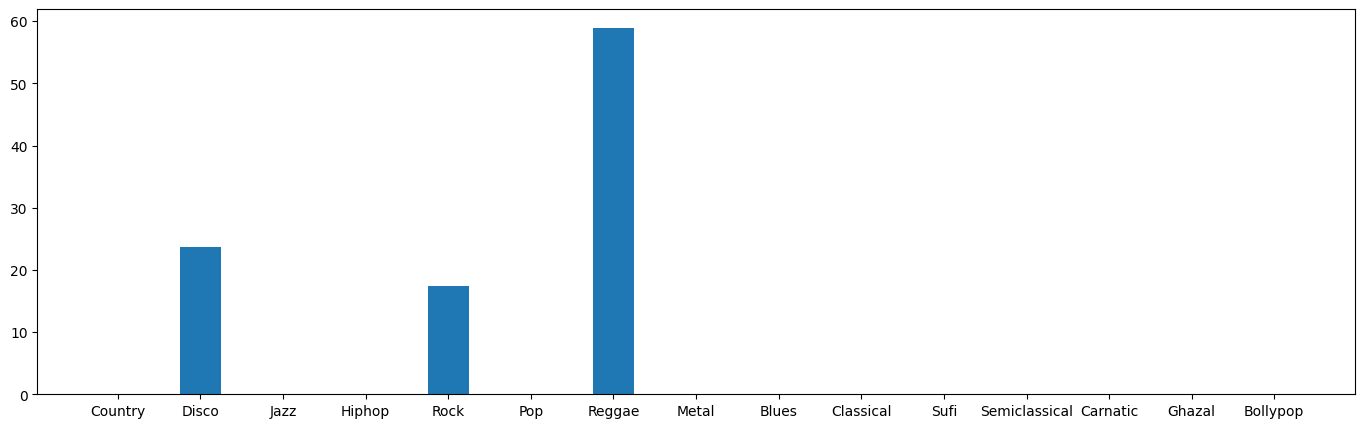

[ 0.         42.72342999  0.         39.30508759  0.          0.
 17.97148242  0.          0.          0.          0.          0.
  0.          0.          0.        ]


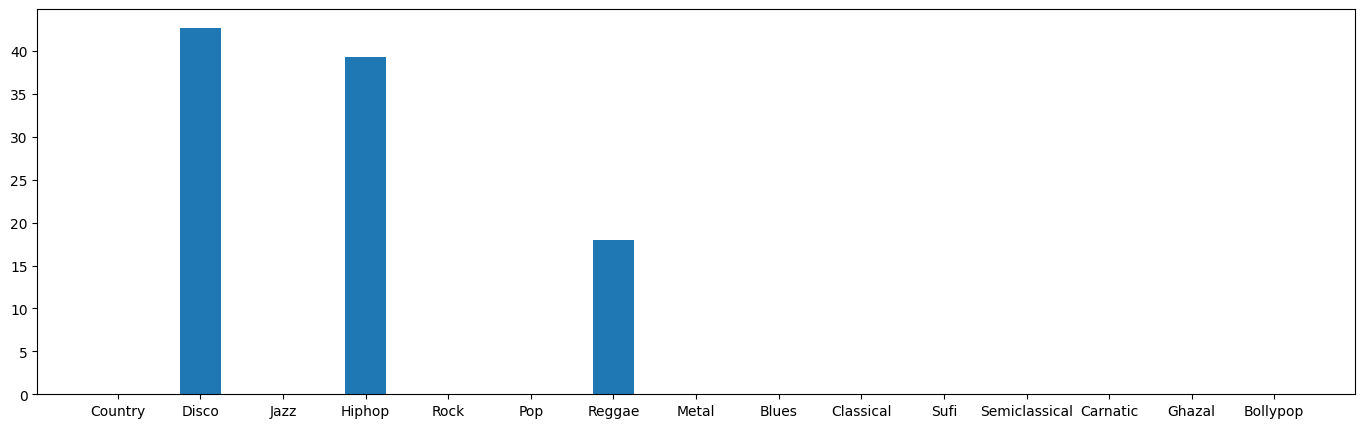

[ 0.          0.          0.         83.43128649  0.          0.
 16.56871351  0.          0.          0.          0.          0.
  0.          0.          0.        ]


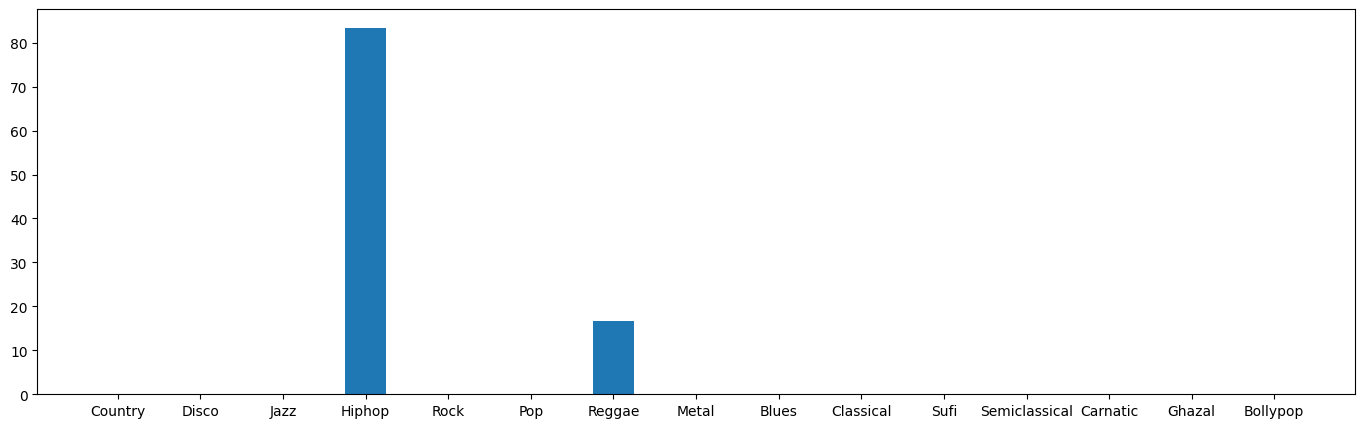

[ 0.        0.        0.       39.424314  0.        0.        0.
  0.       60.575686  0.        0.        0.        0.        0.
  0.      ]


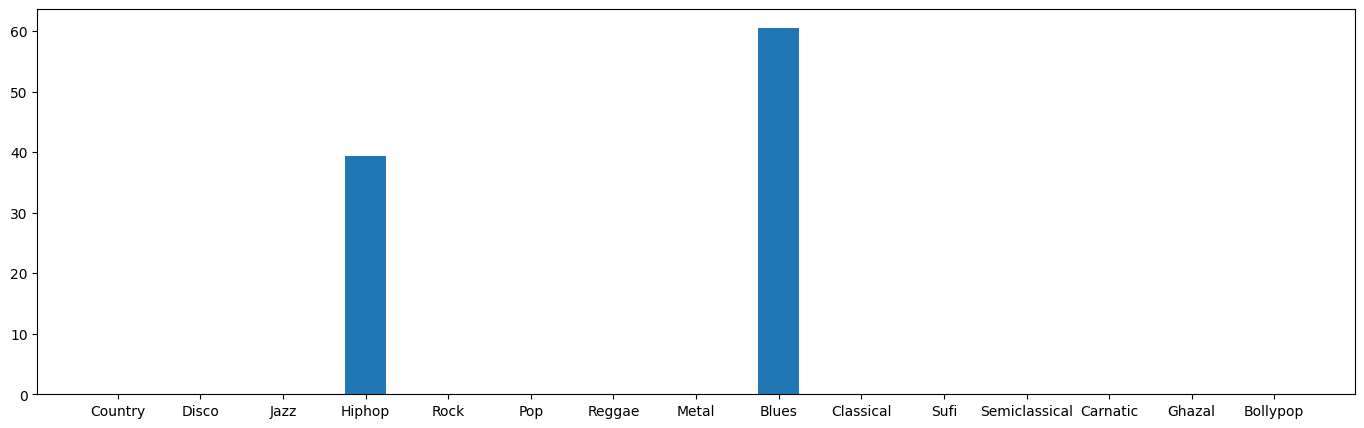

[ 0.         17.19486005  0.         21.30987185  0.          0.
 61.4952681   0.          0.          0.          0.          0.
  0.          0.          0.        ]


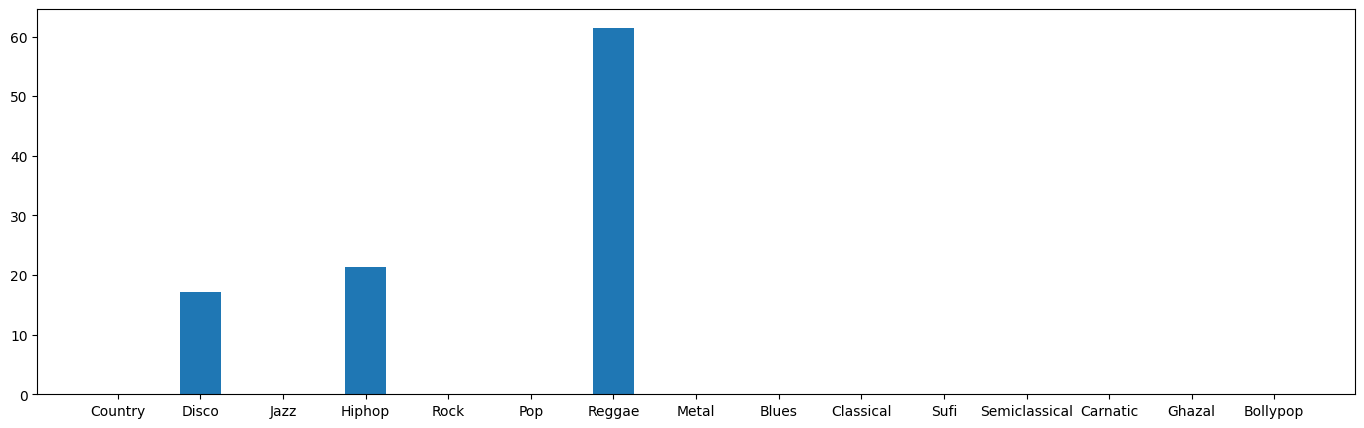

[ 0.         20.54138264  0.          0.          0.          0.
 79.45861736  0.          0.          0.          0.          0.
  0.          0.          0.        ]


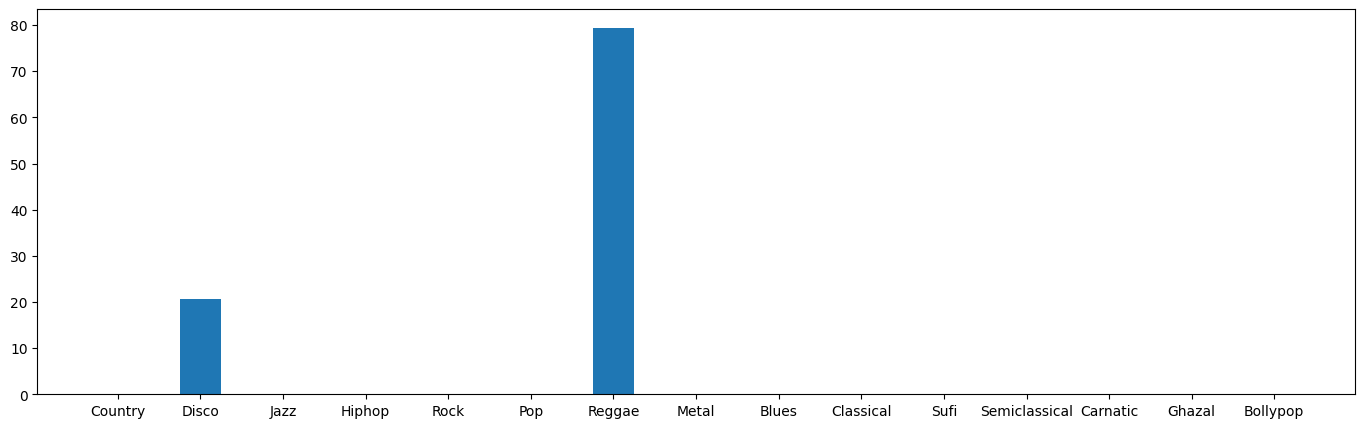

[ 0.         80.42802056  0.         19.57197944  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


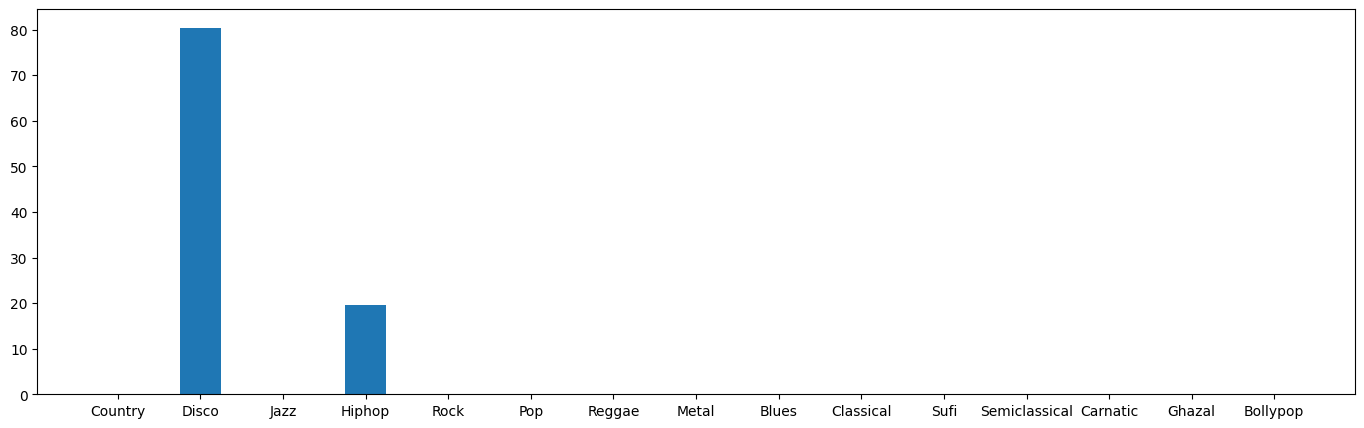

[ 0.         59.12853797  0.          0.         18.44998925  0.
 22.42147279  0.          0.          0.          0.          0.
  0.          0.          0.        ]


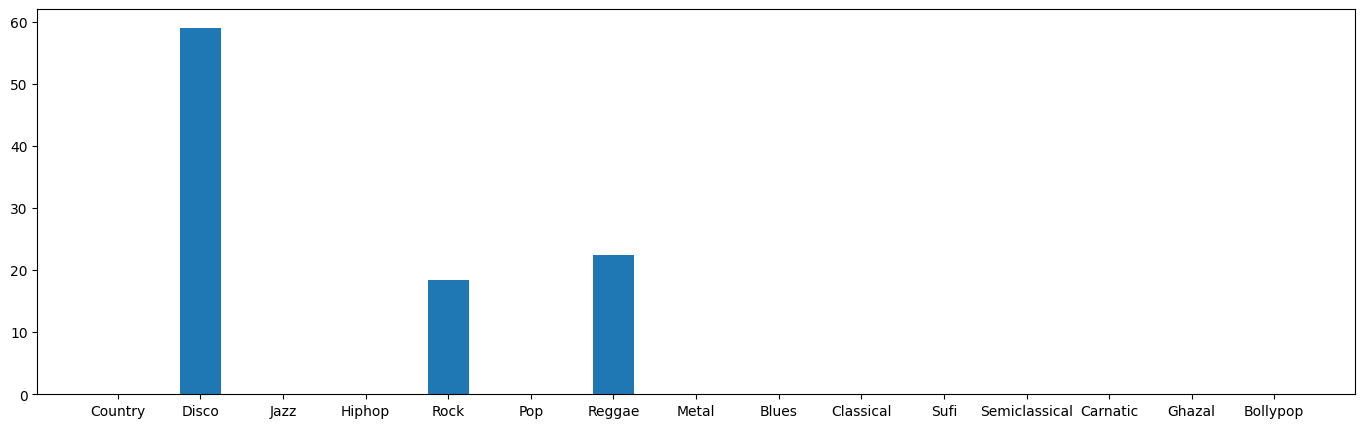

[ 0.         59.80407213  0.         40.19592787  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


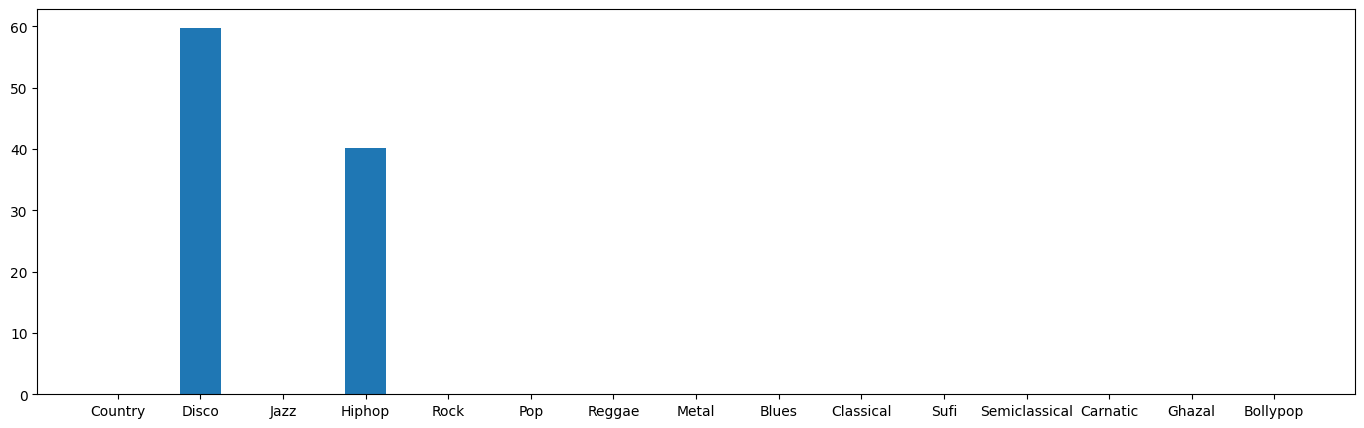

[12.43723867 87.56276133  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


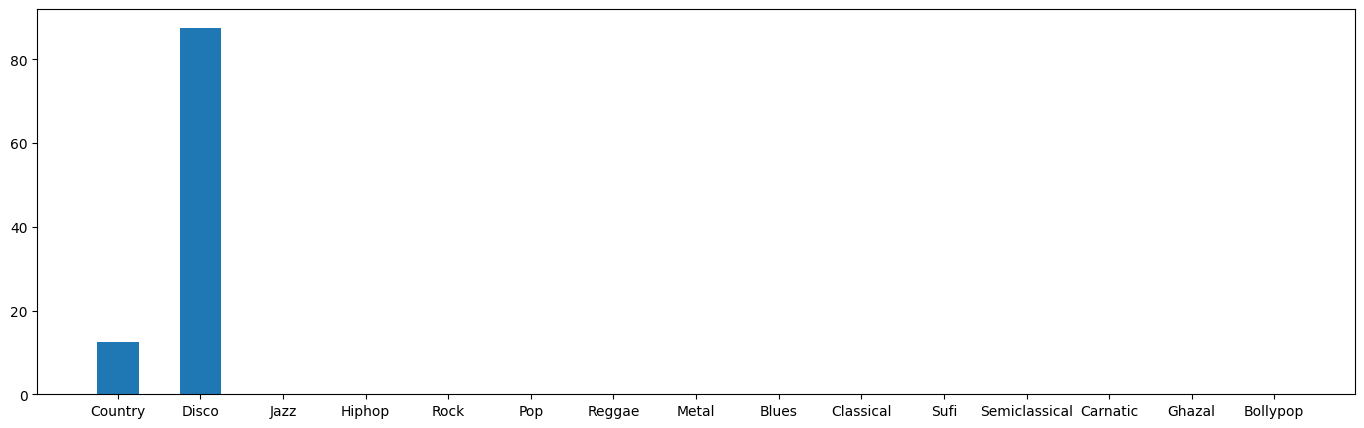

[  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


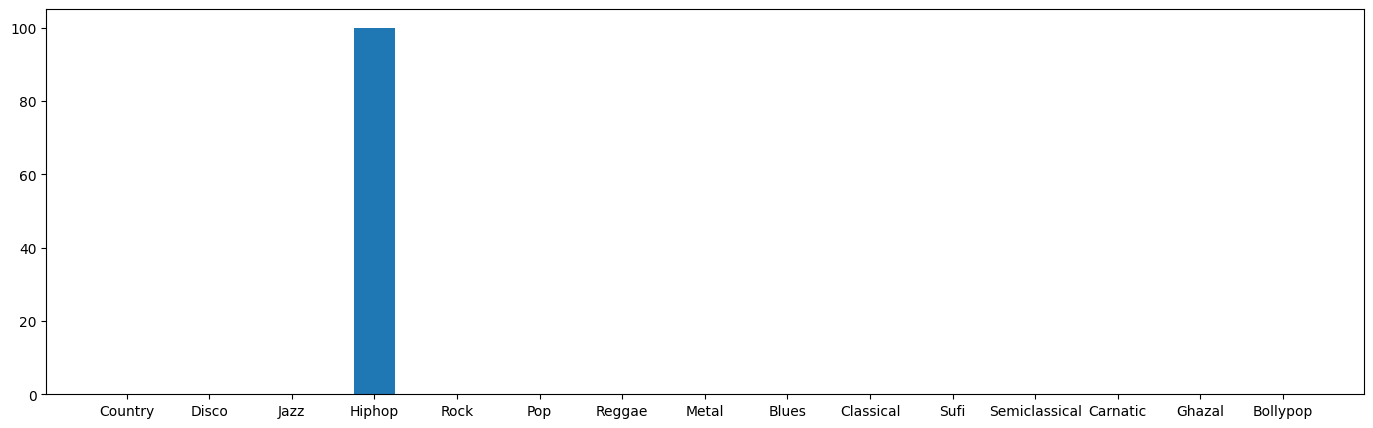

[ 0.         45.72769661  0.         35.48364037  0.          0.
  0.         18.78866302  0.          0.          0.          0.
  0.          0.          0.        ]


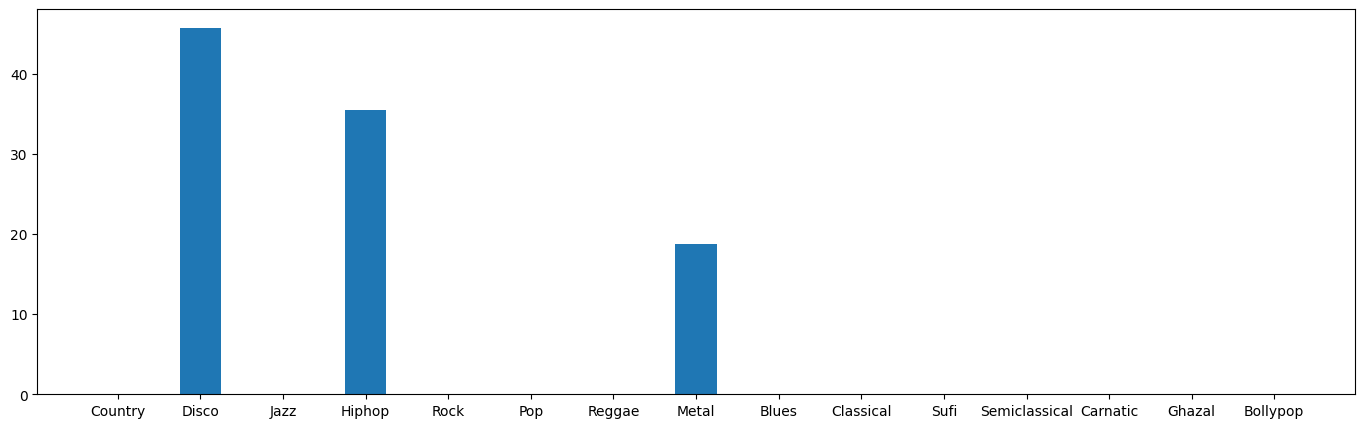

[21.12703677  0.         63.7966912   0.          0.          0.
  0.          0.         15.07627202  0.          0.          0.
  0.          0.          0.        ]


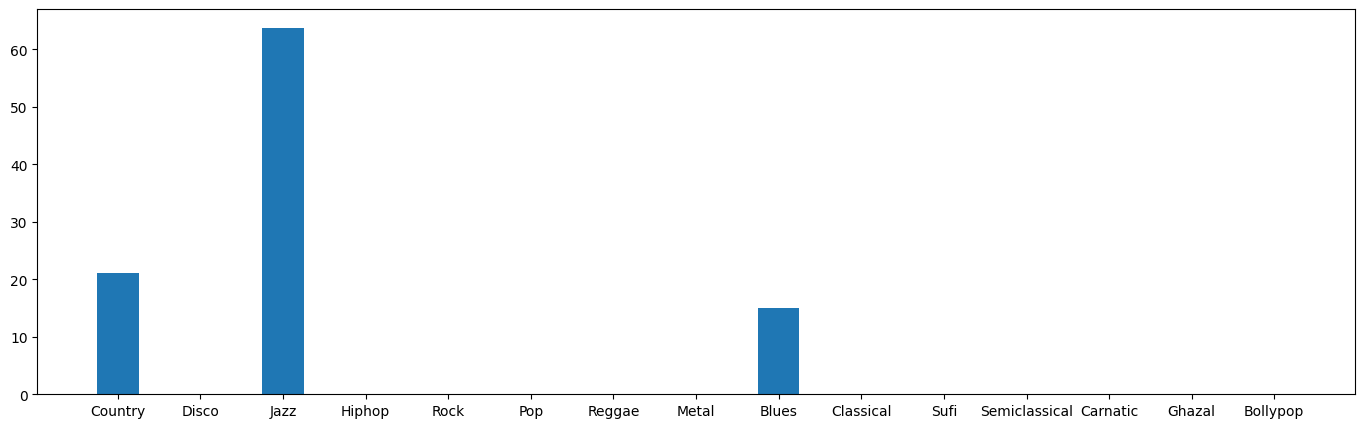

[  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.]


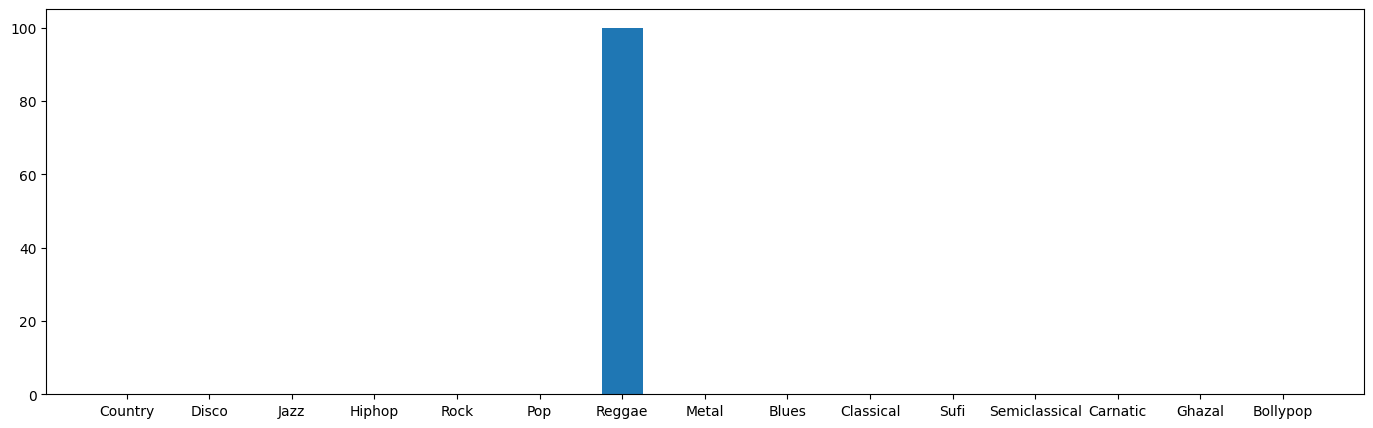

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


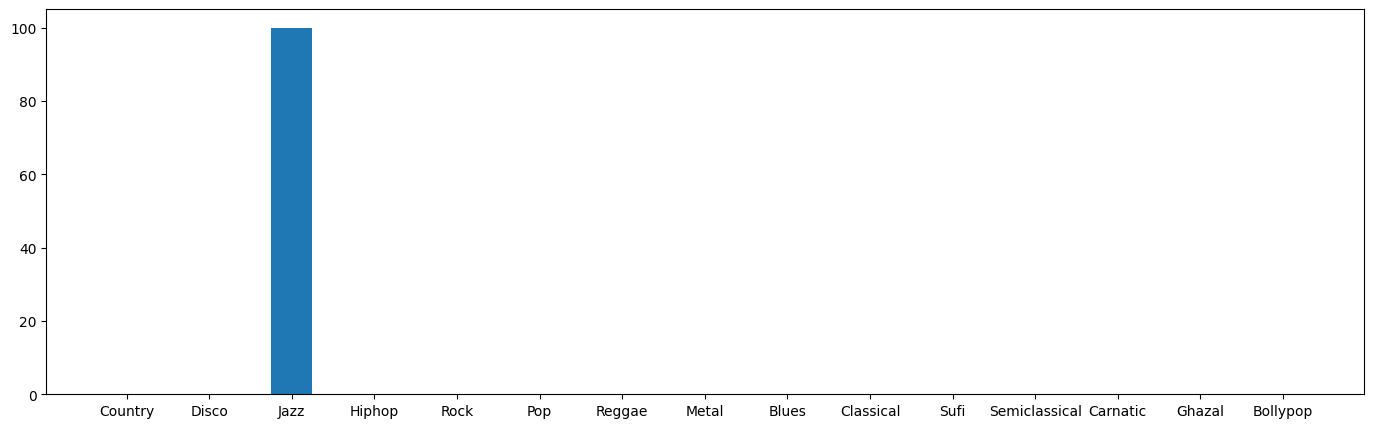

[ 0.         18.71664129 21.80760793  0.          0.          0.
 21.6563329   0.          0.         37.81941789  0.          0.
  0.          0.          0.        ]


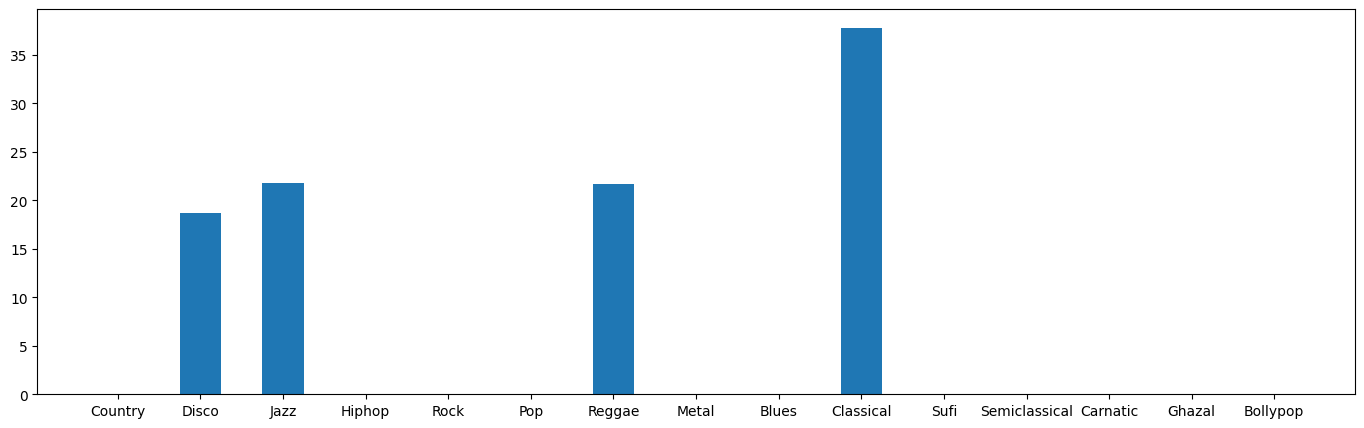

[ 0.          0.         81.73016436  0.          0.          0.
  0.          0.          0.         18.26983564  0.          0.
  0.          0.          0.        ]


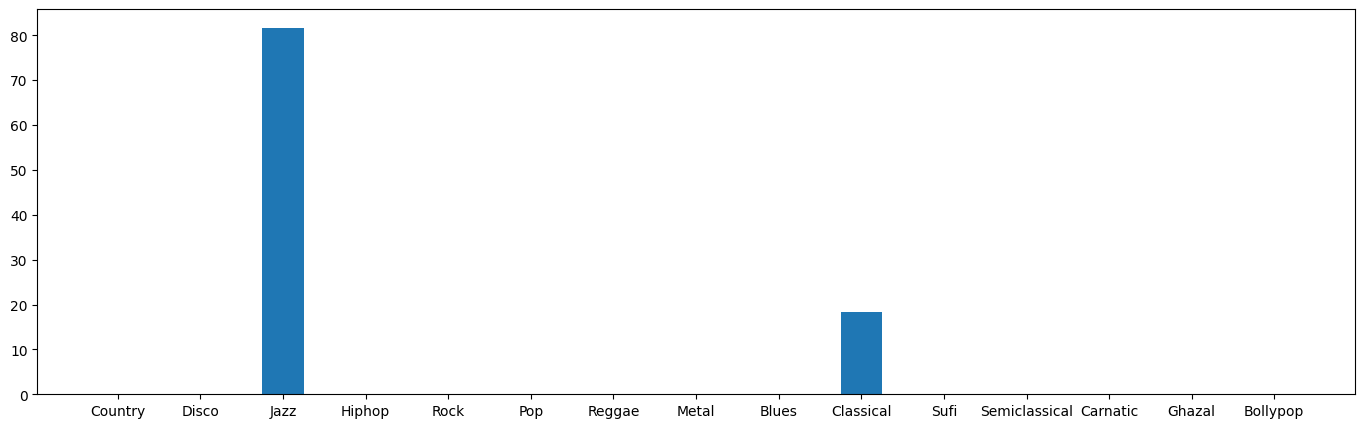

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


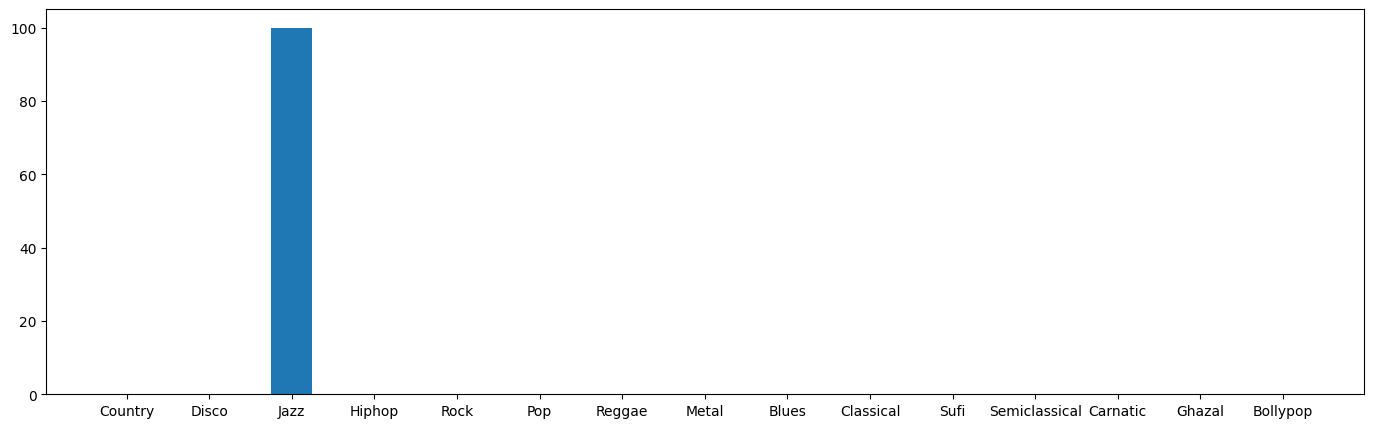

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


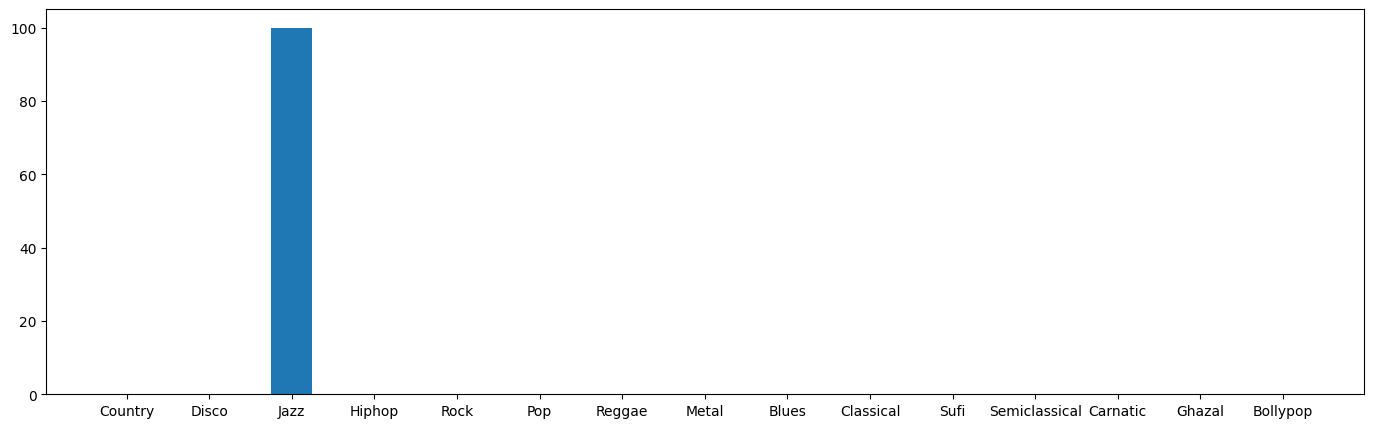

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


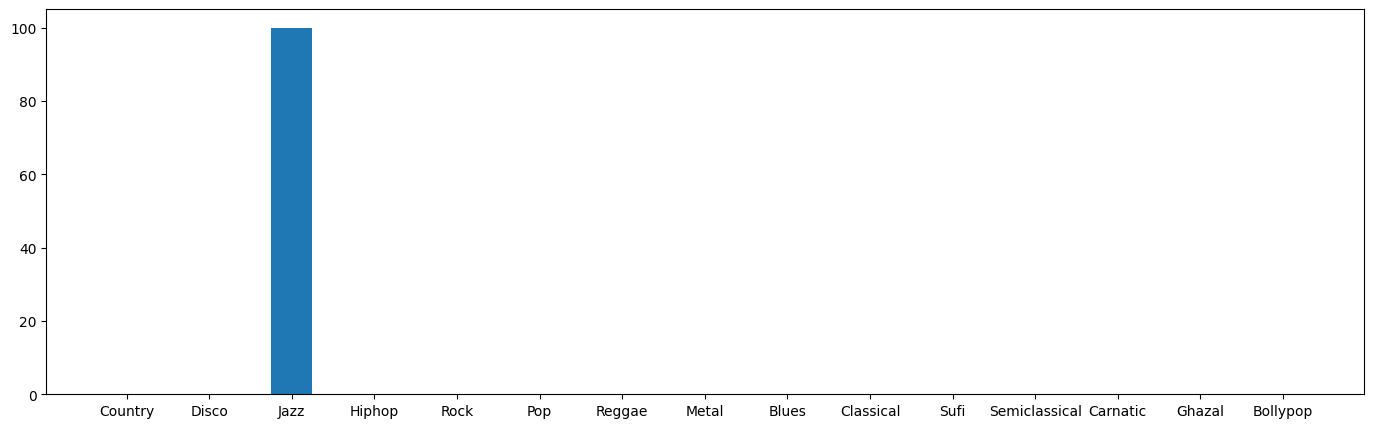

[ 0.          0.         47.78325712  0.         16.46747278  0.
  0.          0.          0.         35.7492701   0.          0.
  0.          0.          0.        ]


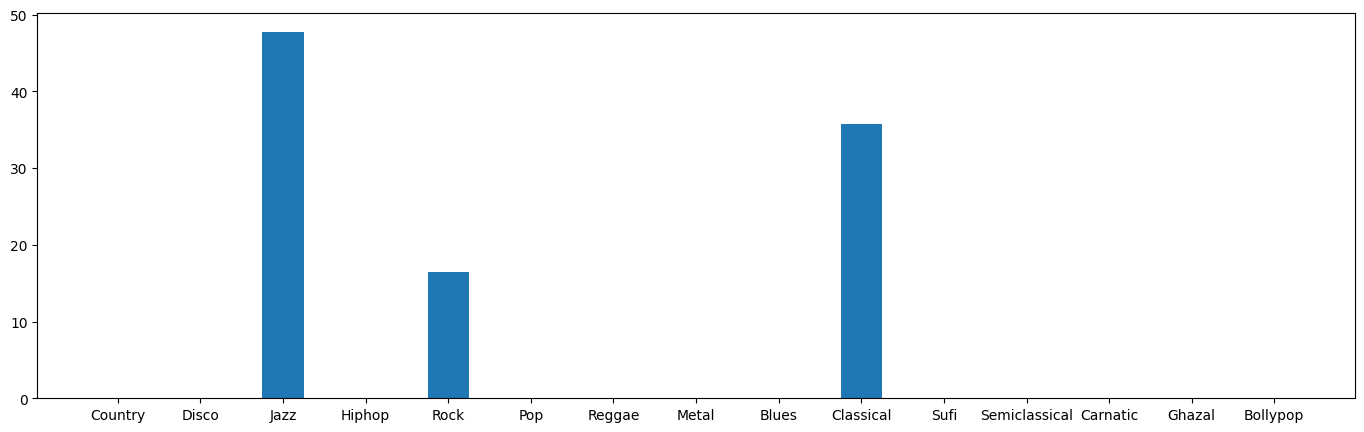

[ 0.         17.83301944 47.44142278  0.         16.59413202  0.
  0.         18.13142576  0.          0.          0.          0.
  0.          0.          0.        ]


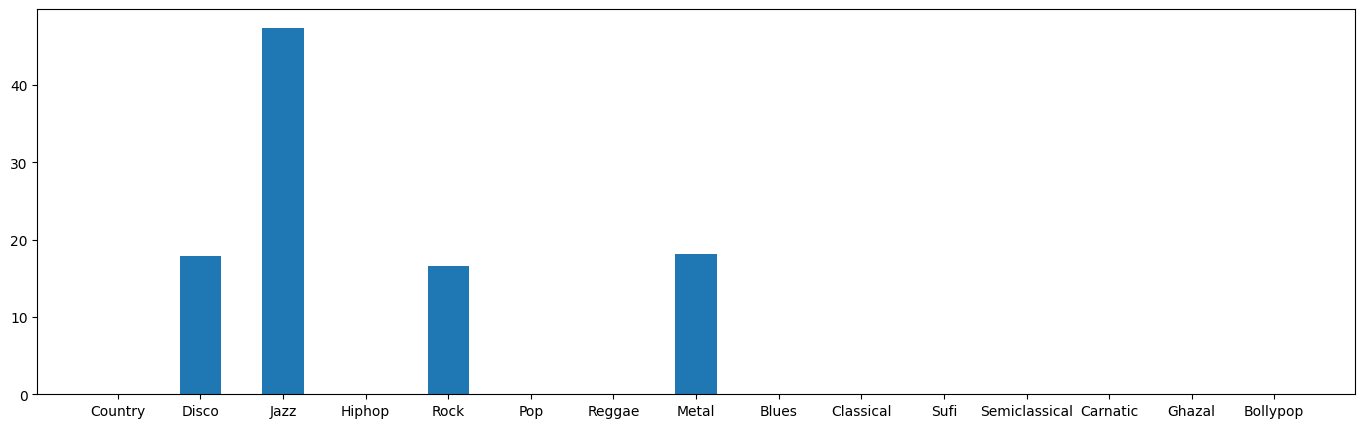

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


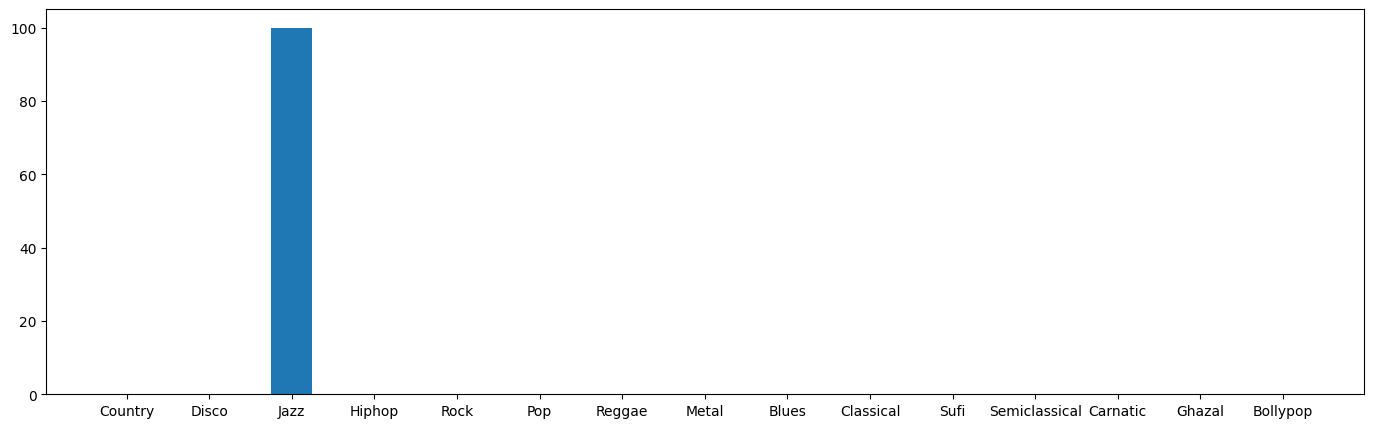

[ 0.          0.         66.45123638  0.         19.14348667  0.
  0.          0.          0.         14.40527695  0.          0.
  0.          0.          0.        ]


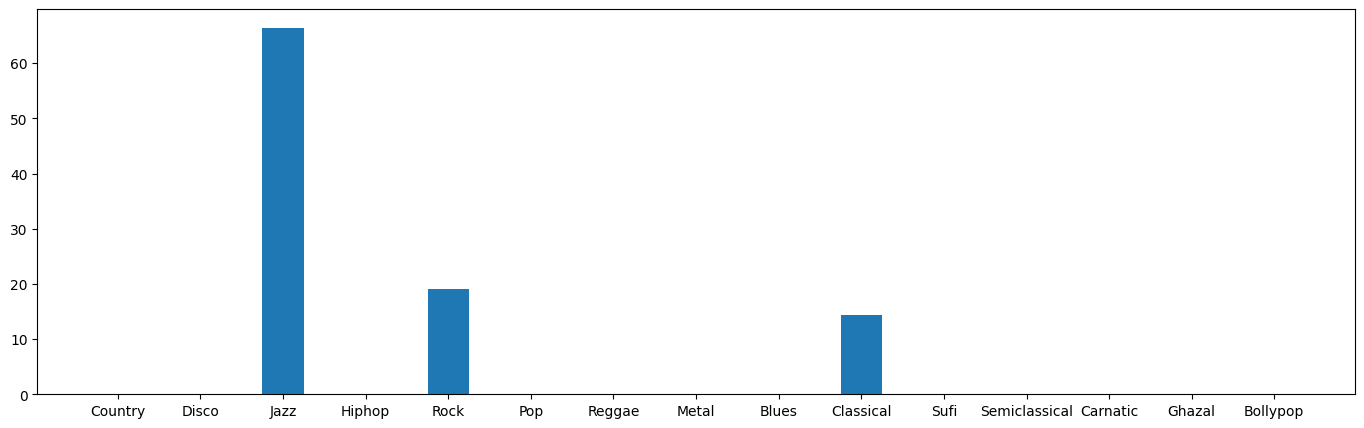

[ 0.         0.        82.7323314  0.         0.         0.
  0.         0.        17.2676686  0.         0.         0.
  0.         0.         0.       ]


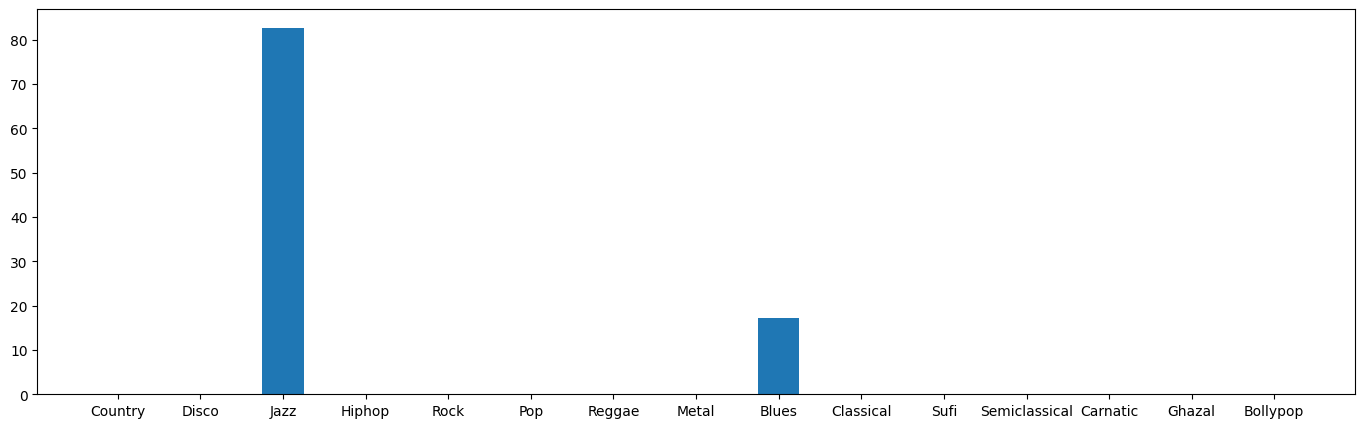

[ 0.         18.99959251 27.66394784  0.         19.23600108  0.
  0.         34.10045857  0.          0.          0.          0.
  0.          0.          0.        ]


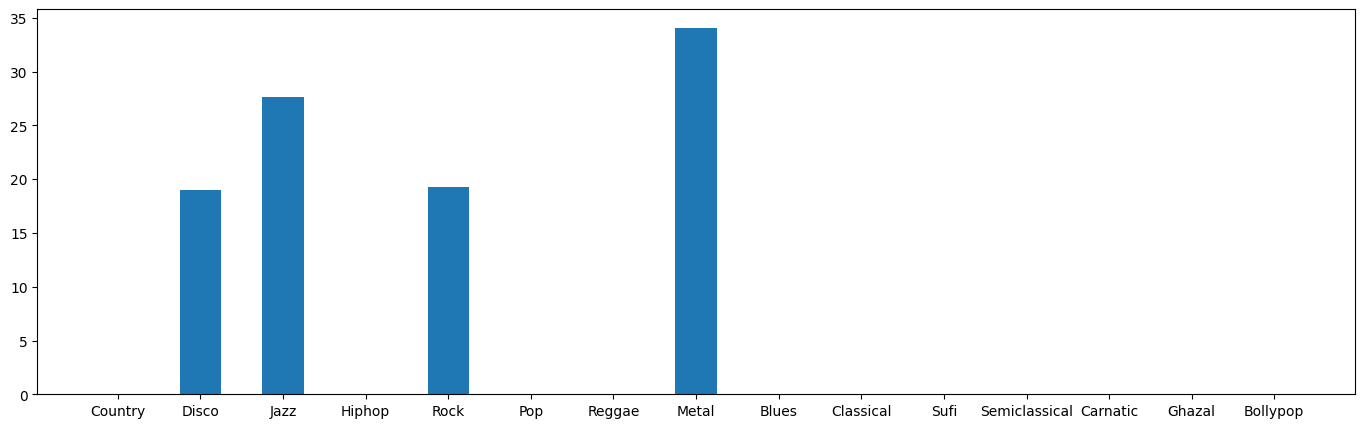

[17.8149364  36.25522729 45.92983632  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


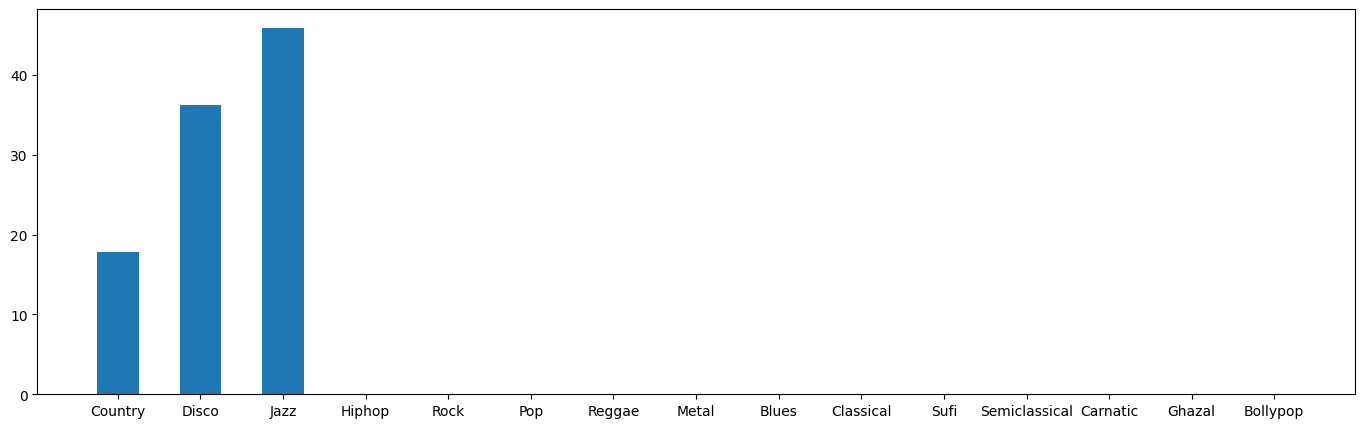

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


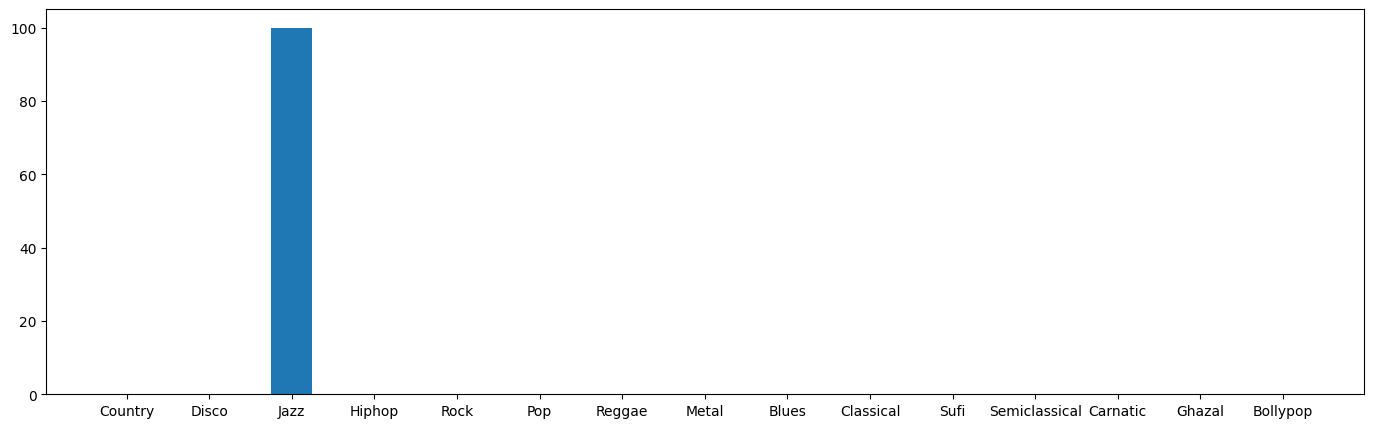

[19.09316138 24.08841797  0.         37.85379095  0.          0.
 18.9646297   0.          0.          0.          0.          0.
  0.          0.          0.        ]


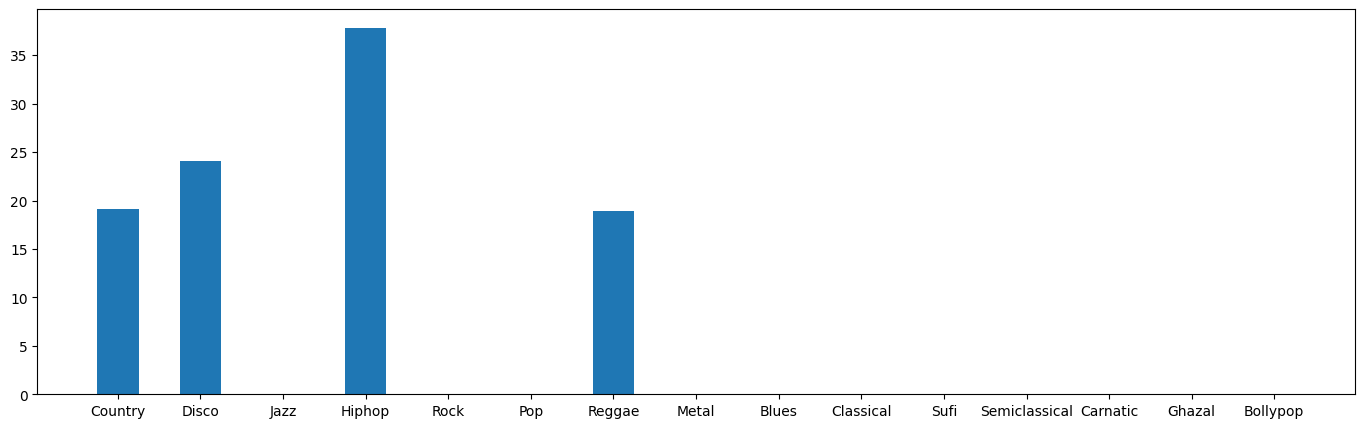

[ 0.          0.         19.64186561  0.          0.          0.
  0.          0.          0.         80.35813439  0.          0.
  0.          0.          0.        ]


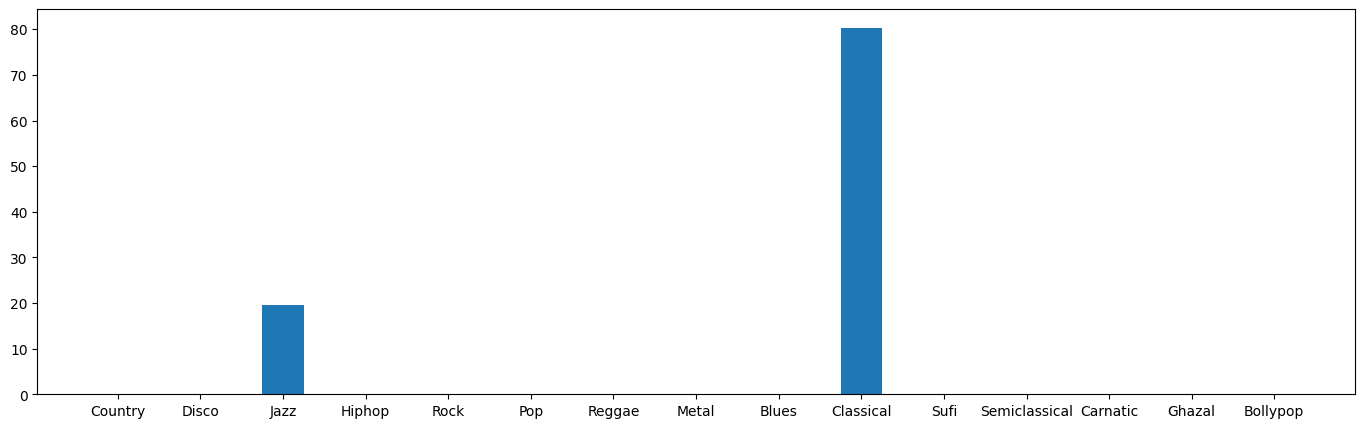

[ 0.          0.         72.65798281  0.          0.          0.
 12.60968609  0.          0.         14.7323311   0.          0.
  0.          0.          0.        ]


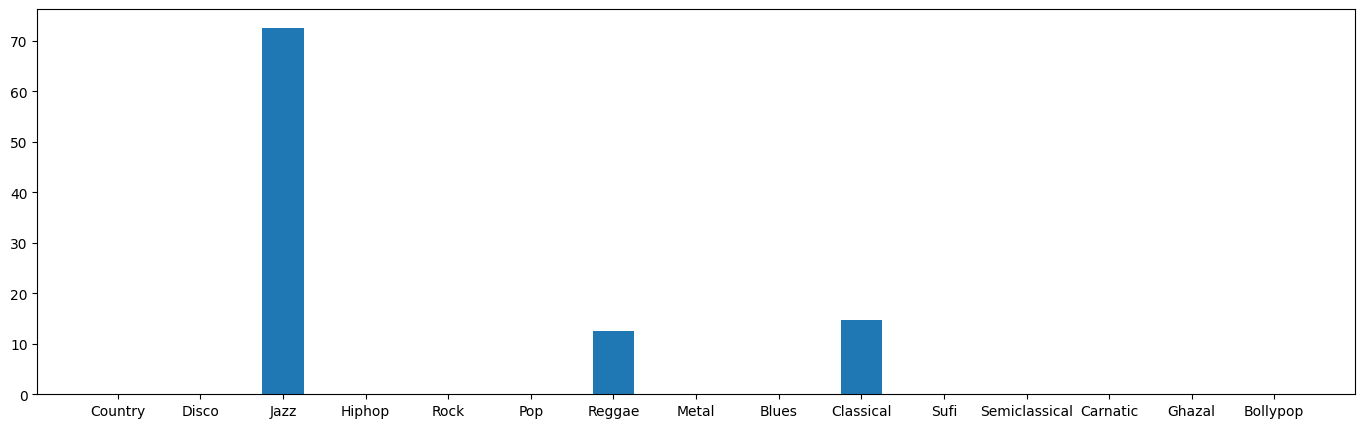

[37.53520215  0.         62.46479785  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


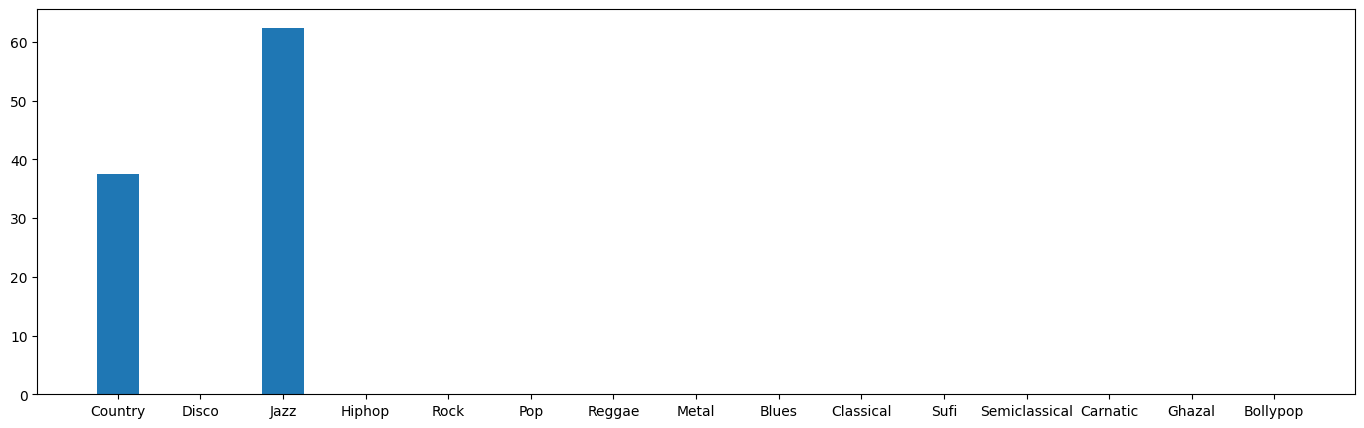

[19.79750778 18.57408203 46.13671344  0.         15.49169675  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


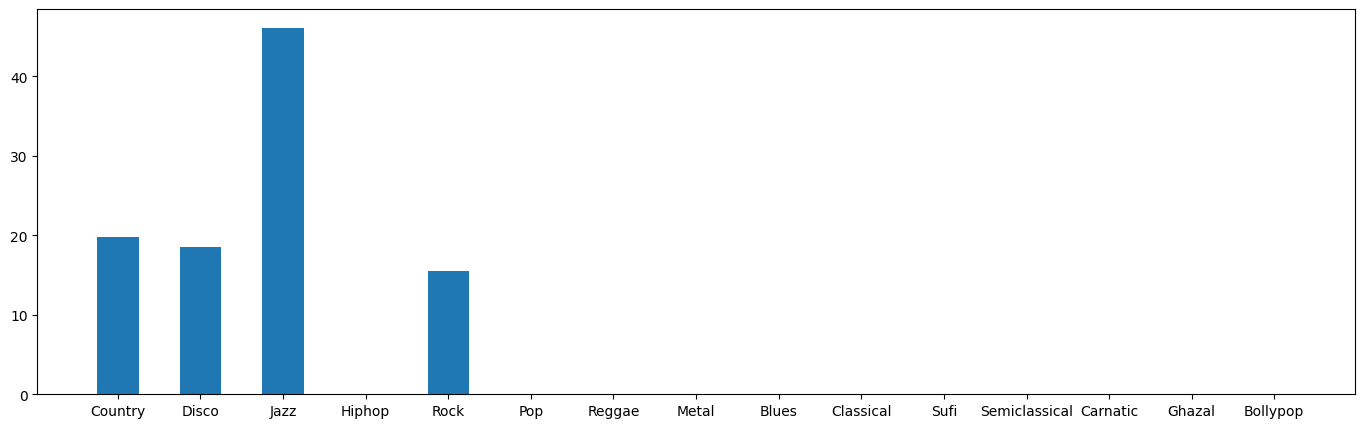

[18.79311149 18.63950783 42.79300345  0.          0.          0.
 19.77437723  0.          0.          0.          0.          0.
  0.          0.          0.        ]


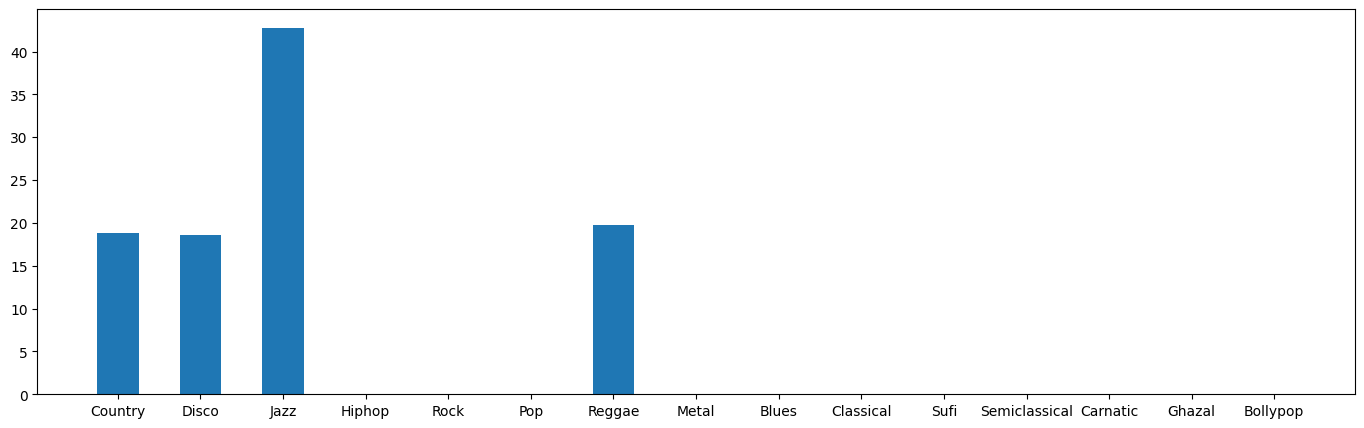

[12.86214312  0.         87.13785688  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


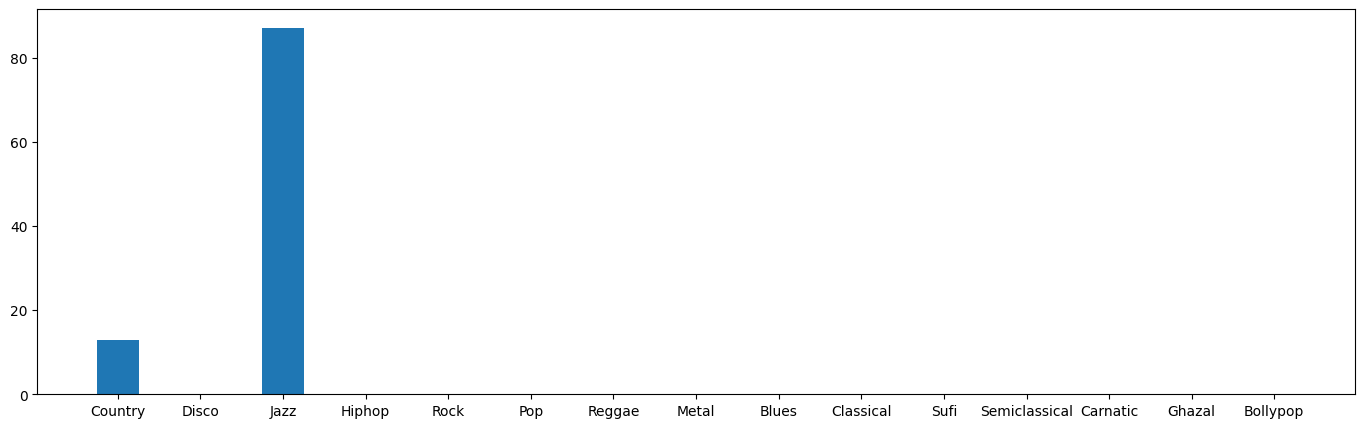

[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


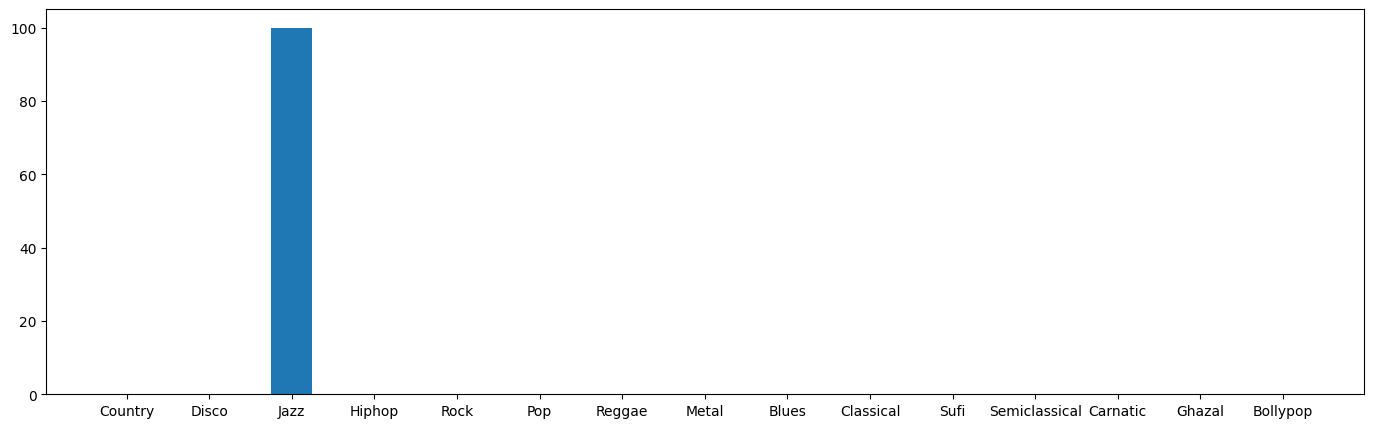

[17.37306056 16.78573042 46.95651451  0.         18.88469451  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


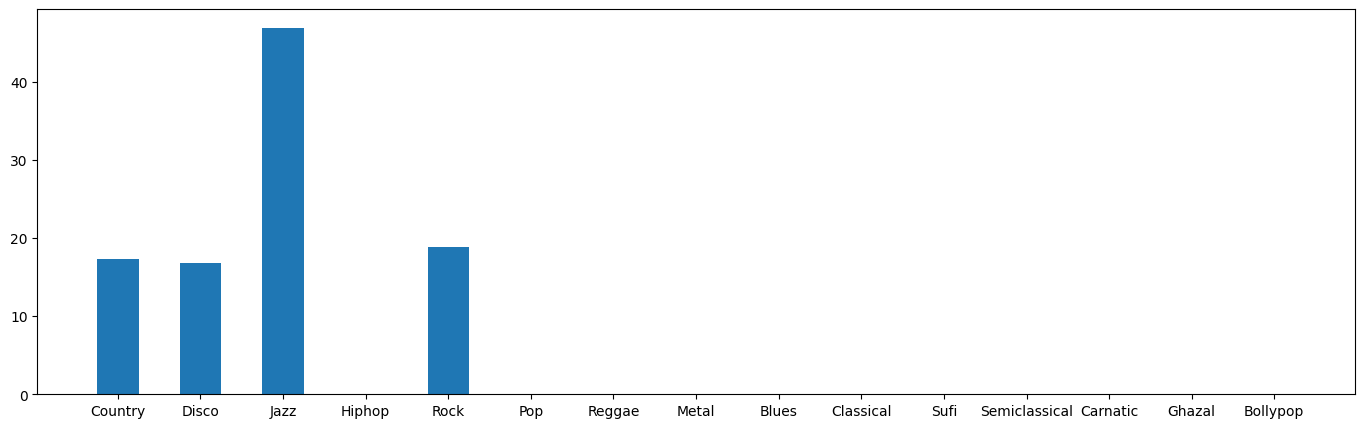

[ 0.         18.17485439  0.         20.88562309  0.          0.
  0.         60.93952252  0.          0.          0.          0.
  0.          0.          0.        ]


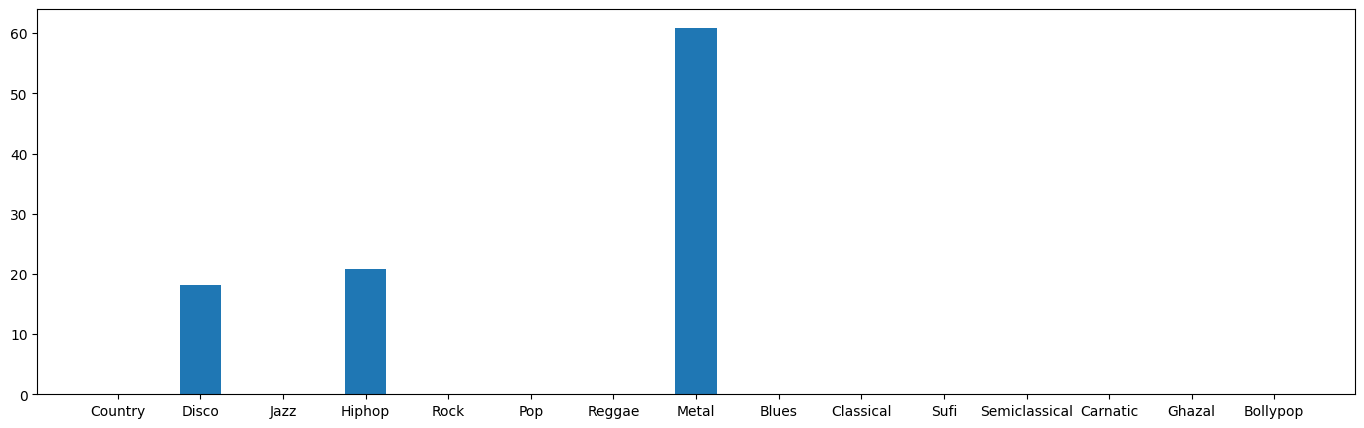

[61.74938833 18.42788934  0.         19.82272233  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


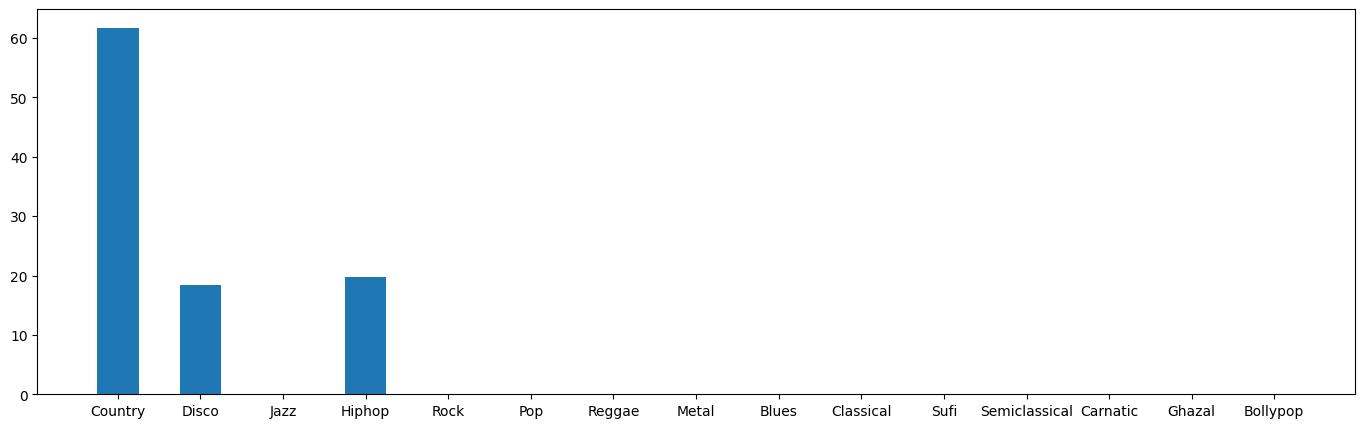

[ 0.         21.94642227  0.         25.35588305  0.          0.
 16.55181412 18.7091007  17.43677986  0.          0.          0.
  0.          0.          0.        ]


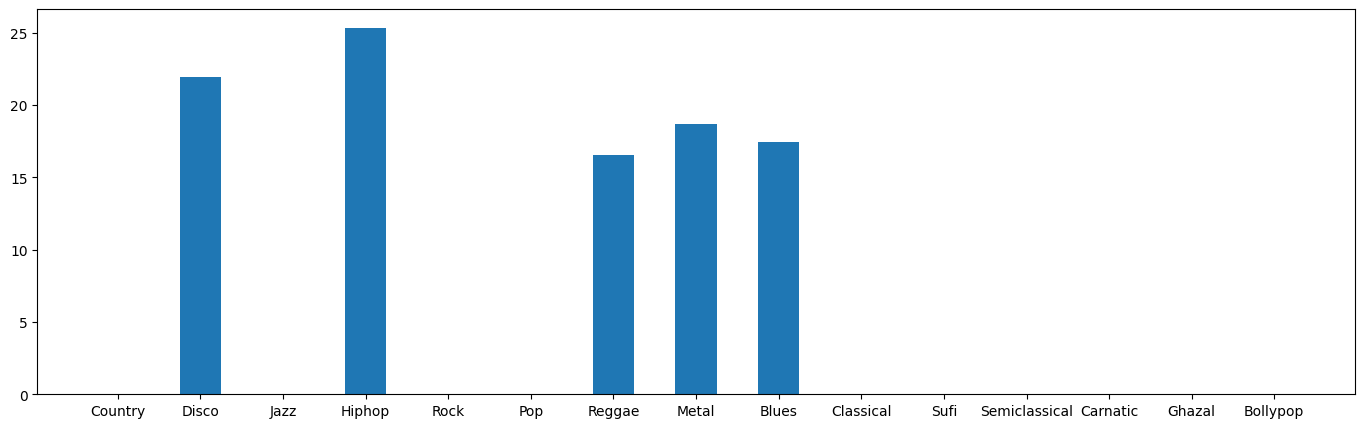

[ 0.          0.          0.         44.38754435  0.          0.
 55.61245565  0.          0.          0.          0.          0.
  0.          0.          0.        ]


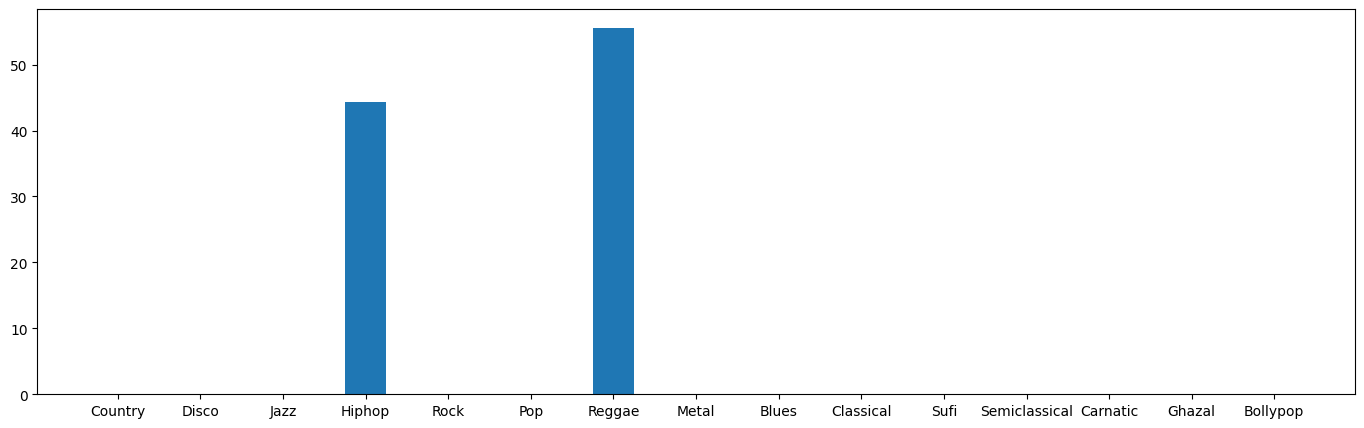

[ 0.          0.          0.         74.19733964  0.         13.32723421
 12.47542615  0.          0.          0.          0.          0.
  0.          0.          0.        ]


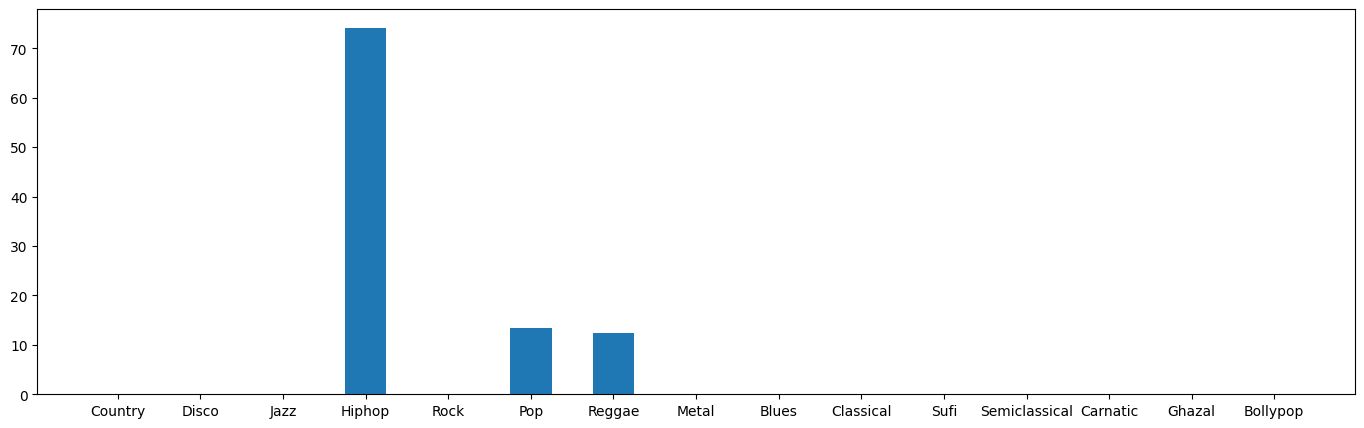

[ 0.          0.          0.         41.91275439 22.02611265 18.06157995
 17.99955301  0.          0.          0.          0.          0.
  0.          0.          0.        ]


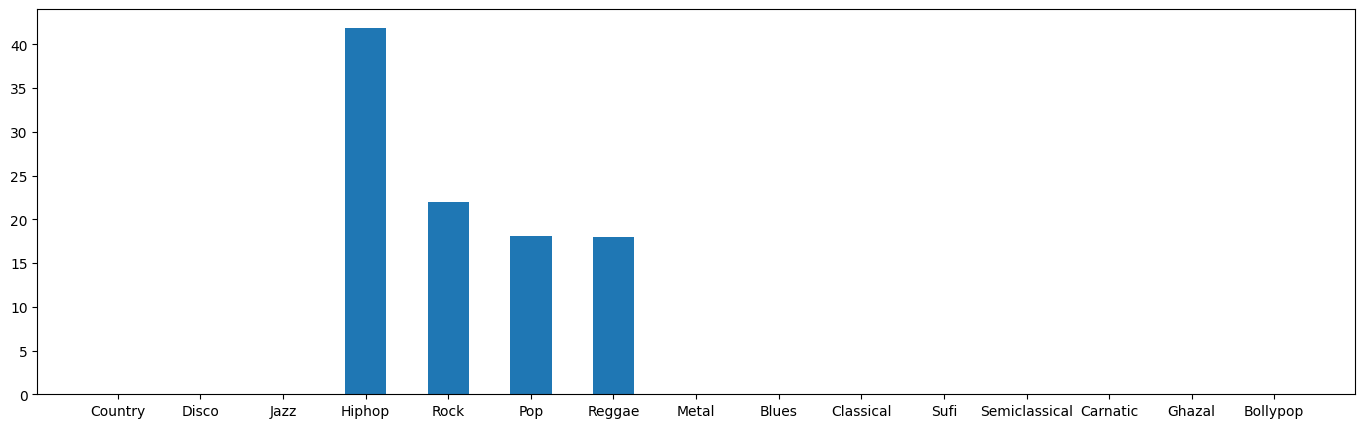

[ 0.          0.          0.         40.47988148  0.          0.
 59.52011852  0.          0.          0.          0.          0.
  0.          0.          0.        ]


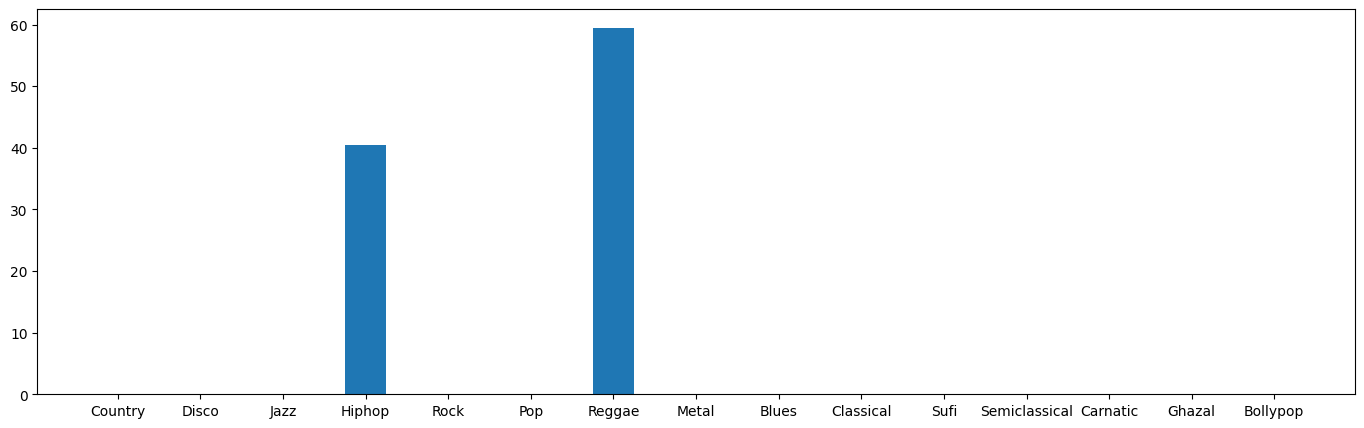

[ 0.         22.86985527  0.         17.41164988  0.         19.32560173
 40.39289313  0.          0.          0.          0.          0.
  0.          0.          0.        ]


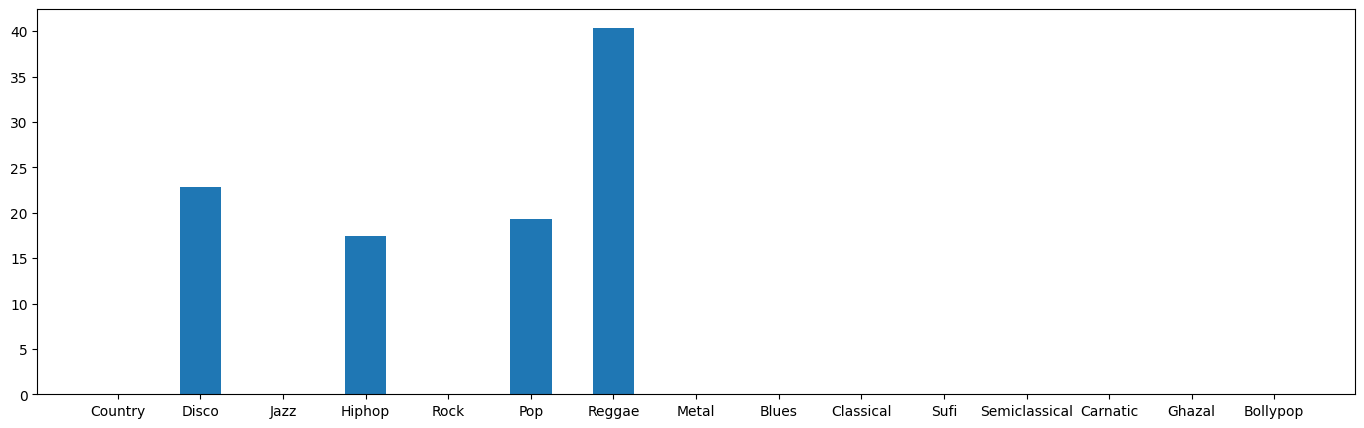

[  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.]


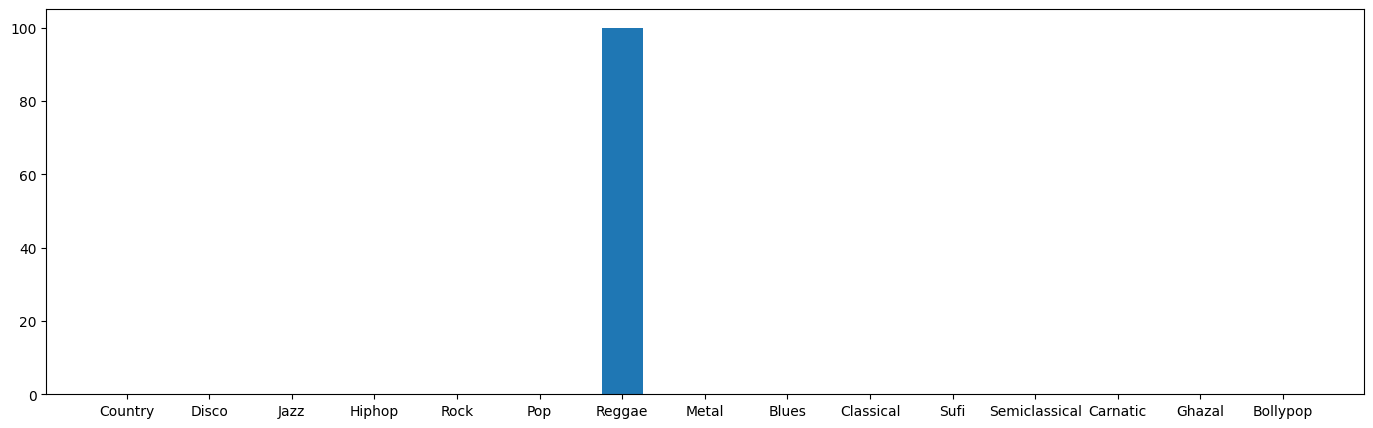

[ 0.          0.          0.         42.61703875  0.         36.47188689
 20.91107436  0.          0.          0.          0.          0.
  0.          0.          0.        ]


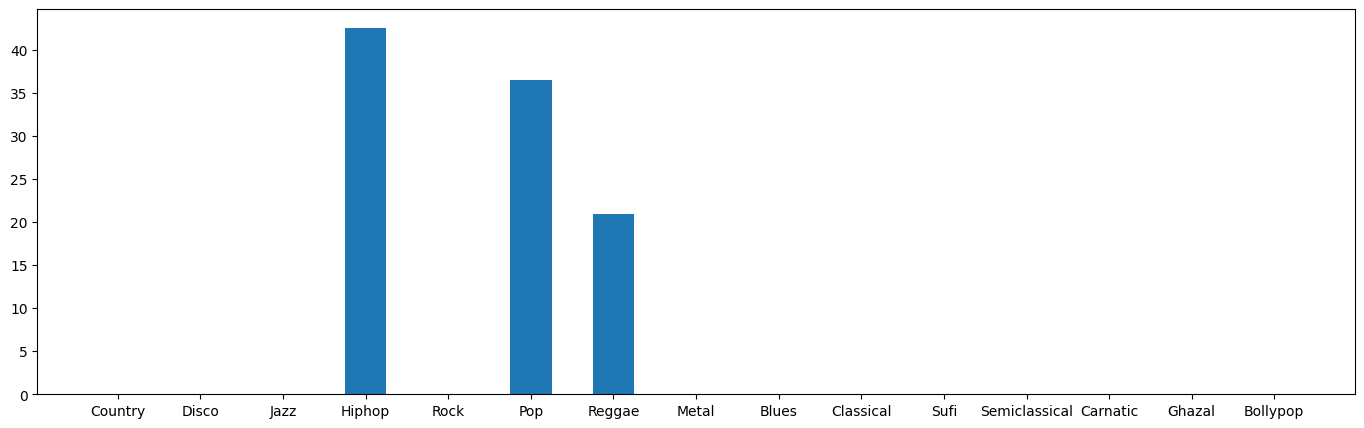

[ 0.          0.          0.         80.15260244  0.         19.84739756
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


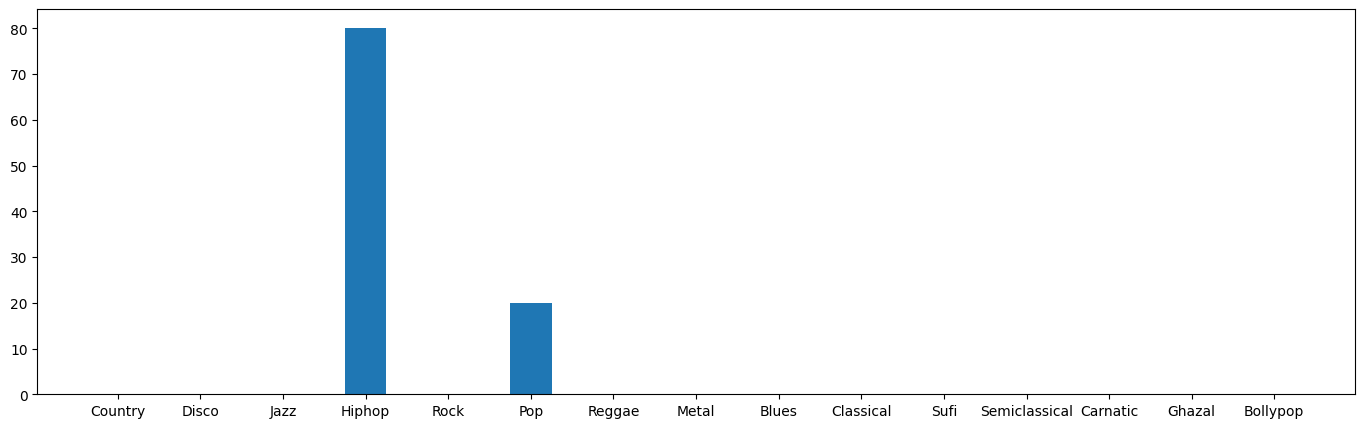

[ 0.          0.          0.         80.67874695  0.          0.
 19.32125305  0.          0.          0.          0.          0.
  0.          0.          0.        ]


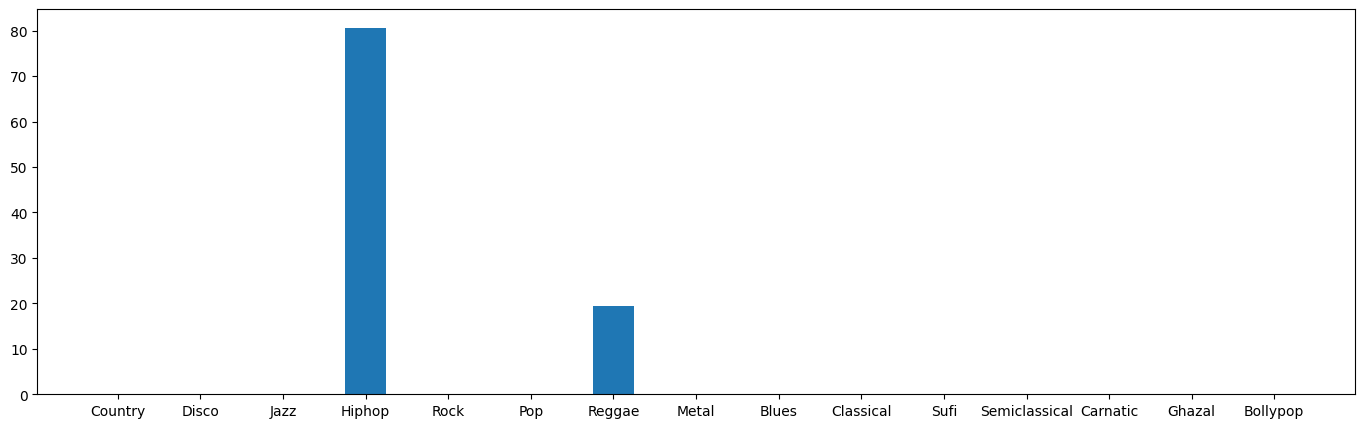

[ 0.          0.          0.         62.43845105  0.          0.
 37.56154895  0.          0.          0.          0.          0.
  0.          0.          0.        ]


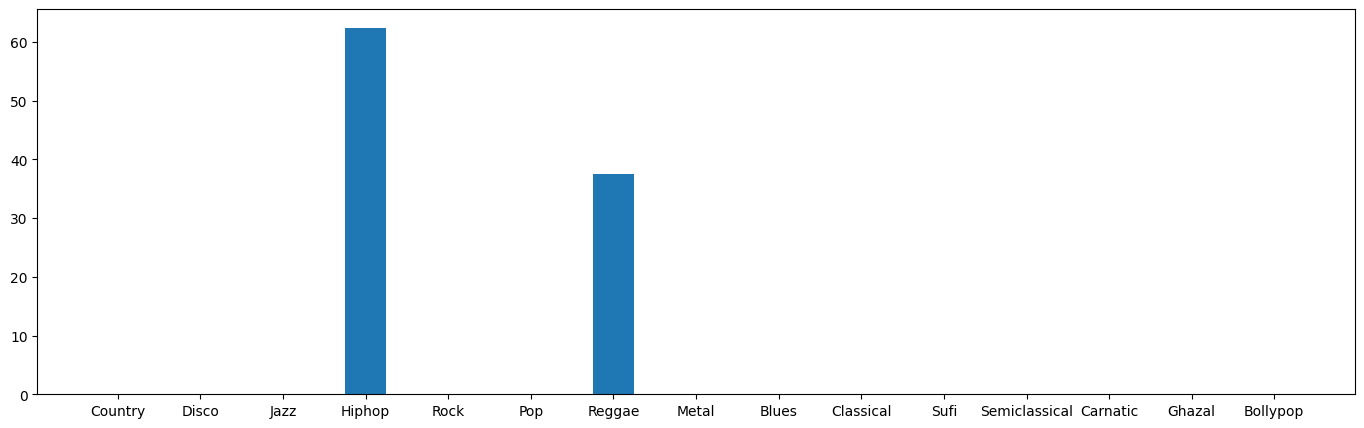

[ 0.          0.          0.         44.32210728  0.         55.67789272
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


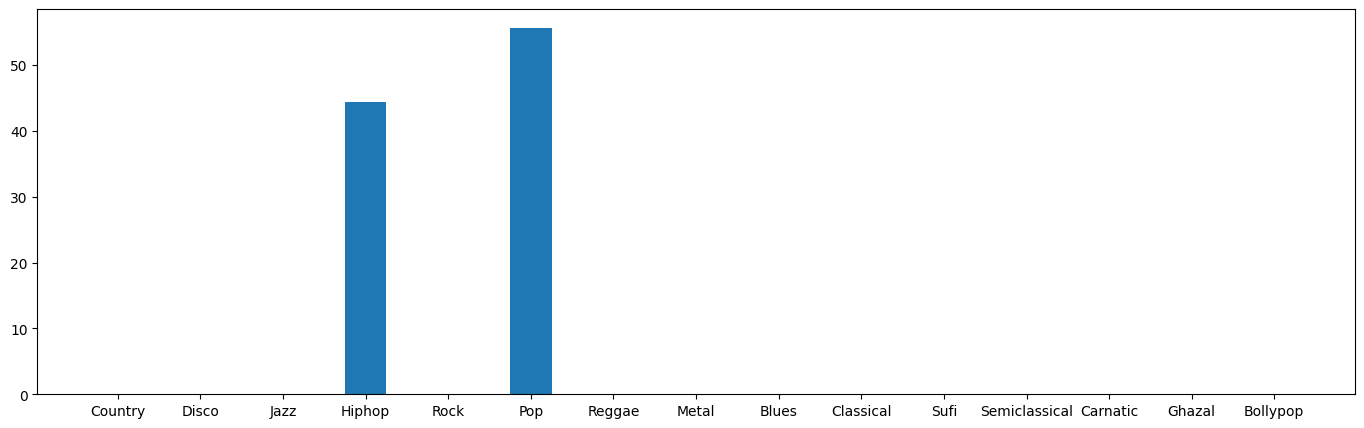

[ 0.         18.41531318  0.         81.58468682  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


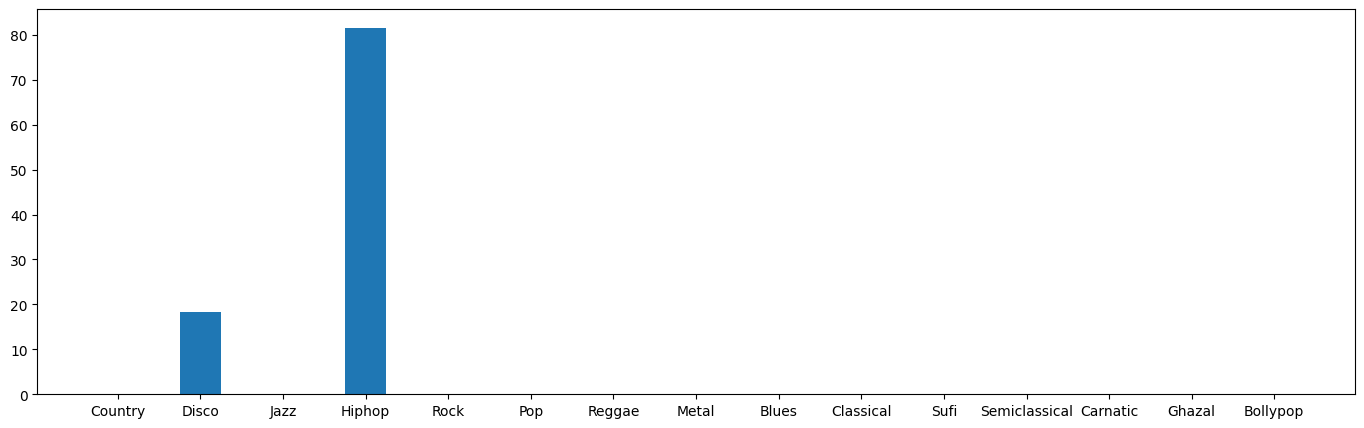

[ 0.          0.          0.         38.21848116 22.08912845  0.
 39.6923904   0.          0.          0.          0.          0.
  0.          0.          0.        ]


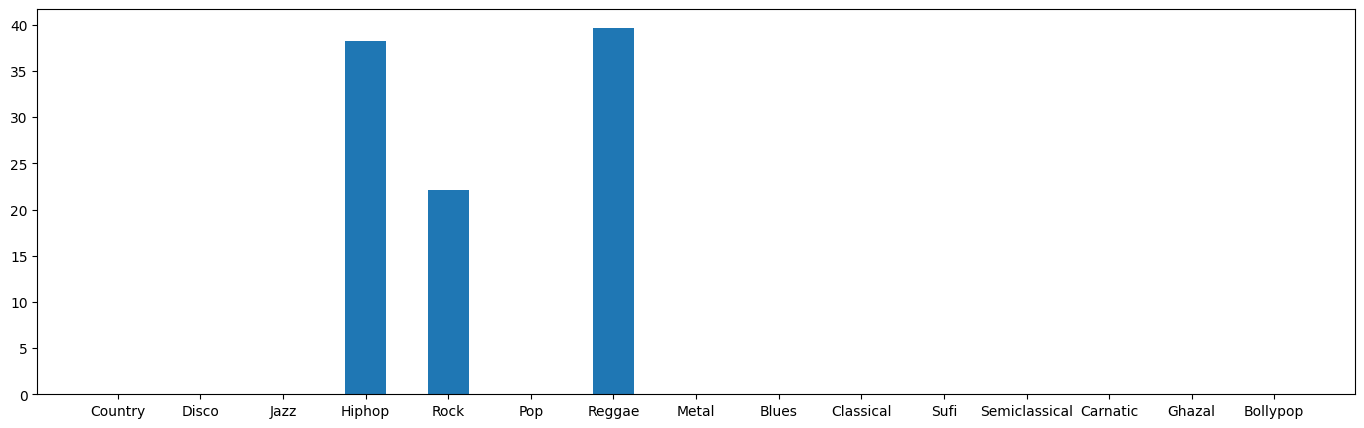

[ 0.          0.          0.         21.24484012  0.          0.
 78.75515988  0.          0.          0.          0.          0.
  0.          0.          0.        ]


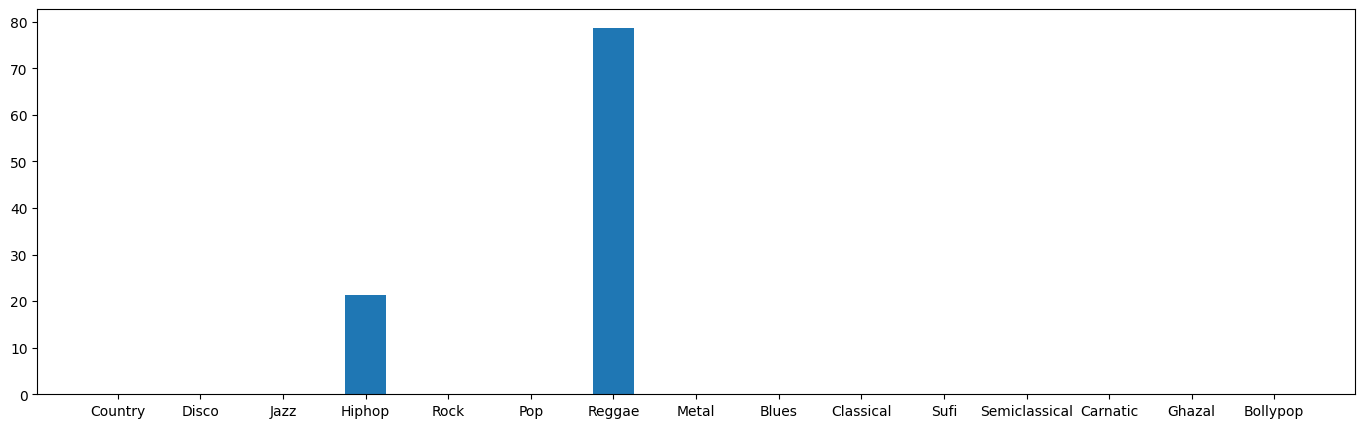

[ 0.          0.          0.         17.905013   38.14441894  0.
 43.95056806  0.          0.          0.          0.          0.
  0.          0.          0.        ]


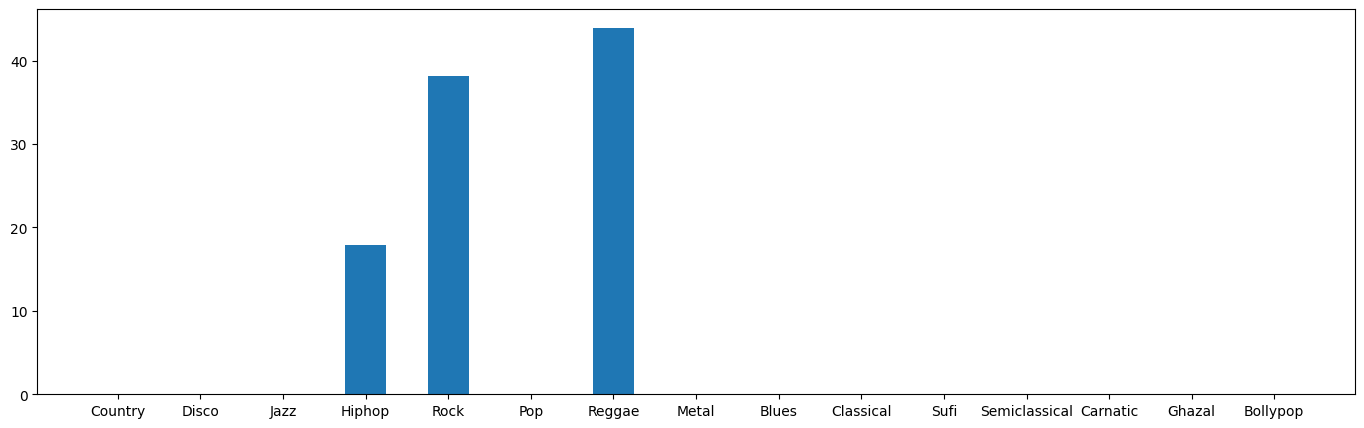

[ 0.         38.28548127  0.         44.55283449  0.          0.
  0.         17.16168424  0.          0.          0.          0.
  0.          0.          0.        ]


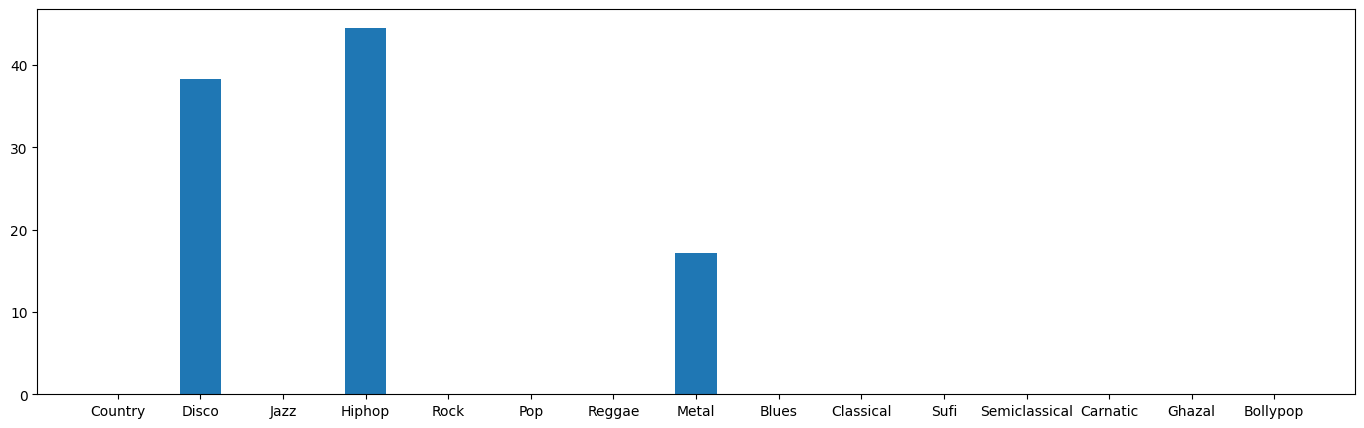

[ 0.          0.          0.         84.49433866  0.          0.
  0.         15.50566134  0.          0.          0.          0.
  0.          0.          0.        ]


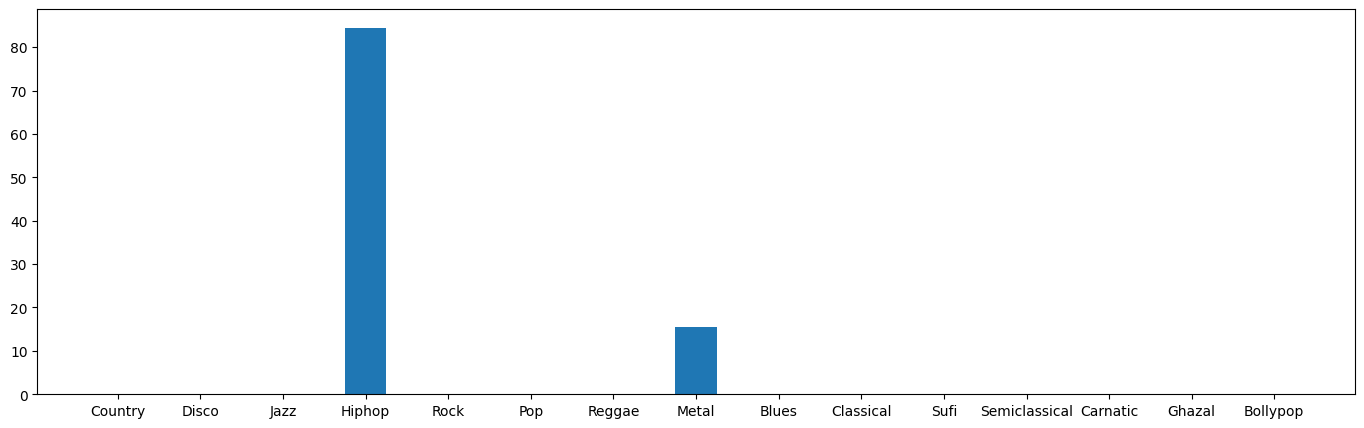

[18.17461173 17.56896366  0.          0.         44.88145036  0.
 19.37497425  0.          0.          0.          0.          0.
  0.          0.          0.        ]


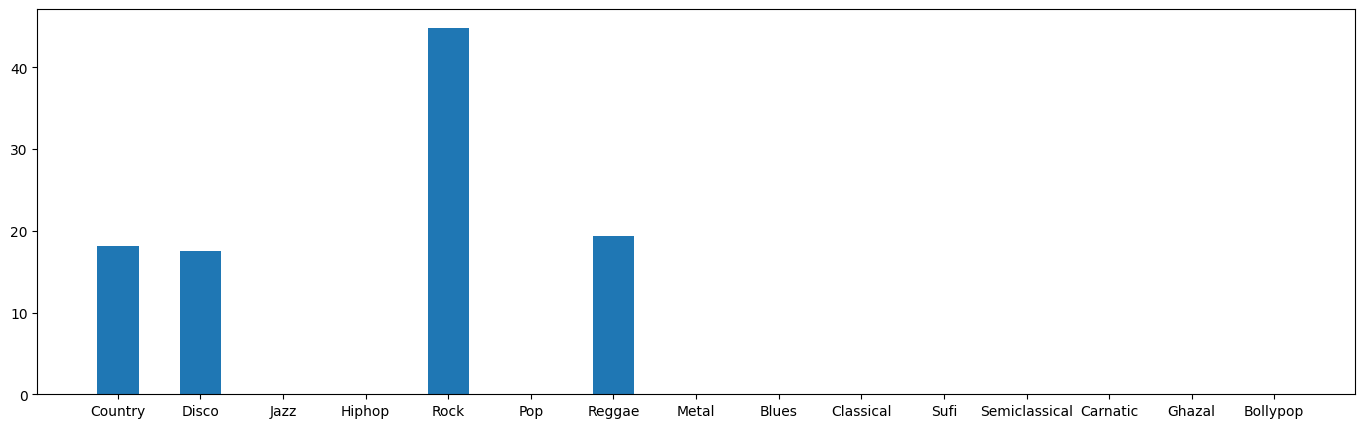

[62.55648289  0.          0.          0.         19.11041381  0.
 18.3331033   0.          0.          0.          0.          0.
  0.          0.          0.        ]


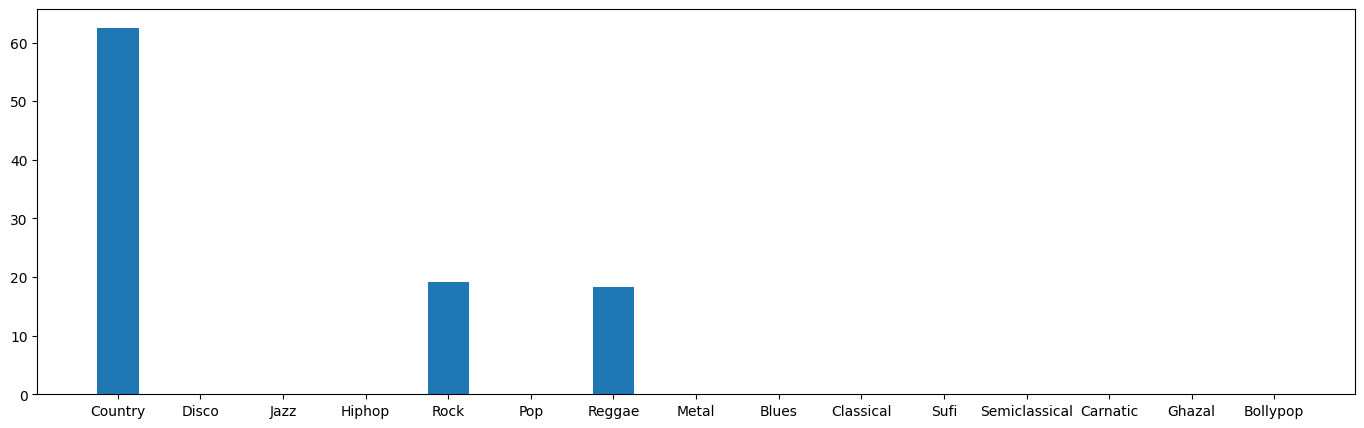

[34.71536268  0.          0.          0.         45.48585649  0.
 19.79878082  0.          0.          0.          0.          0.
  0.          0.          0.        ]


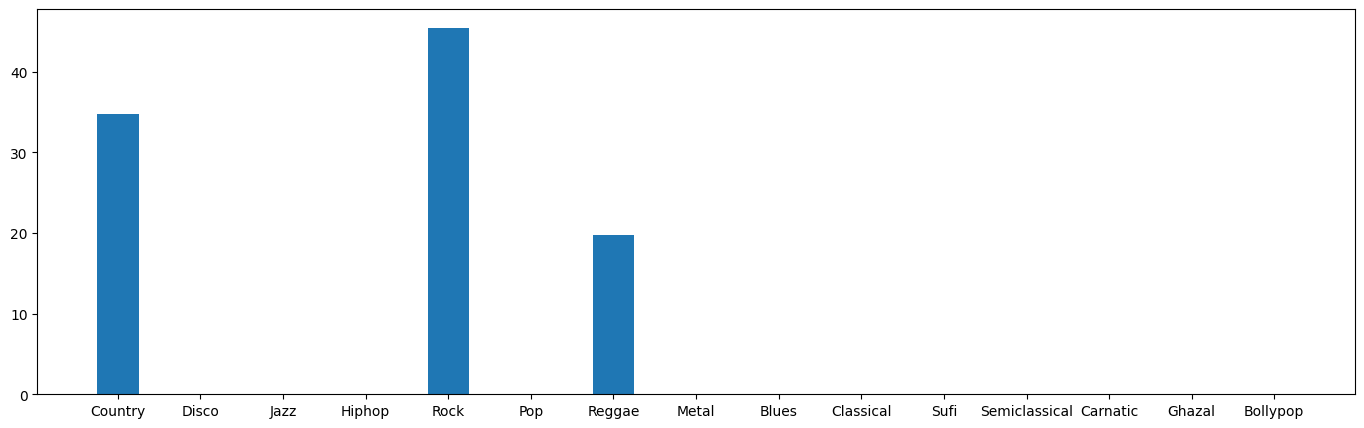

[ 0.         20.60594739  0.          0.         40.85827462  0.
  0.          0.         38.53577799  0.          0.          0.
  0.          0.          0.        ]


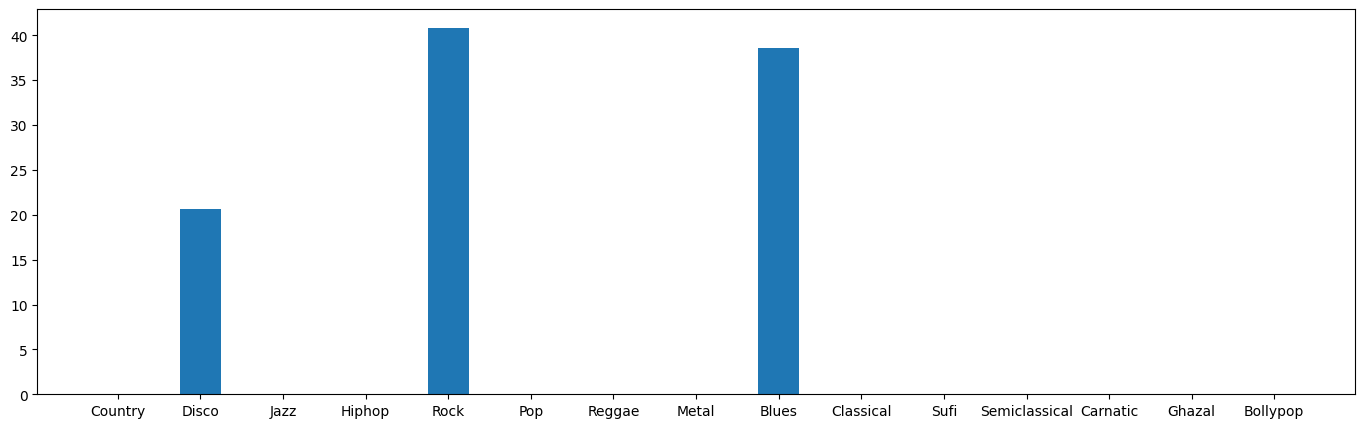

[ 0.         0.         0.         0.        63.0629543  0.
  0.        36.9370457  0.         0.         0.         0.
  0.         0.         0.       ]


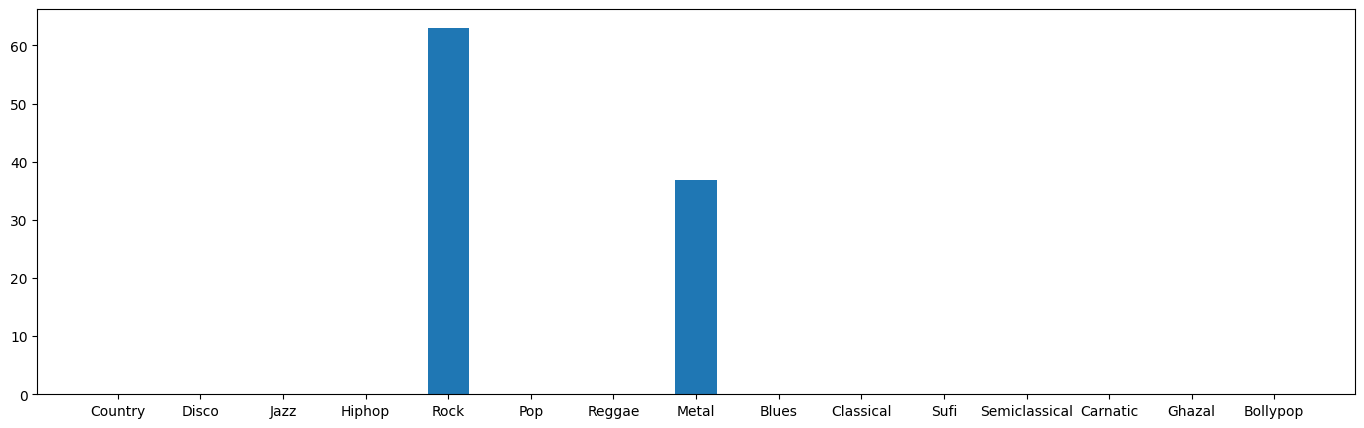

[31.66732969 11.50847862  0.          0.         56.82419169  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


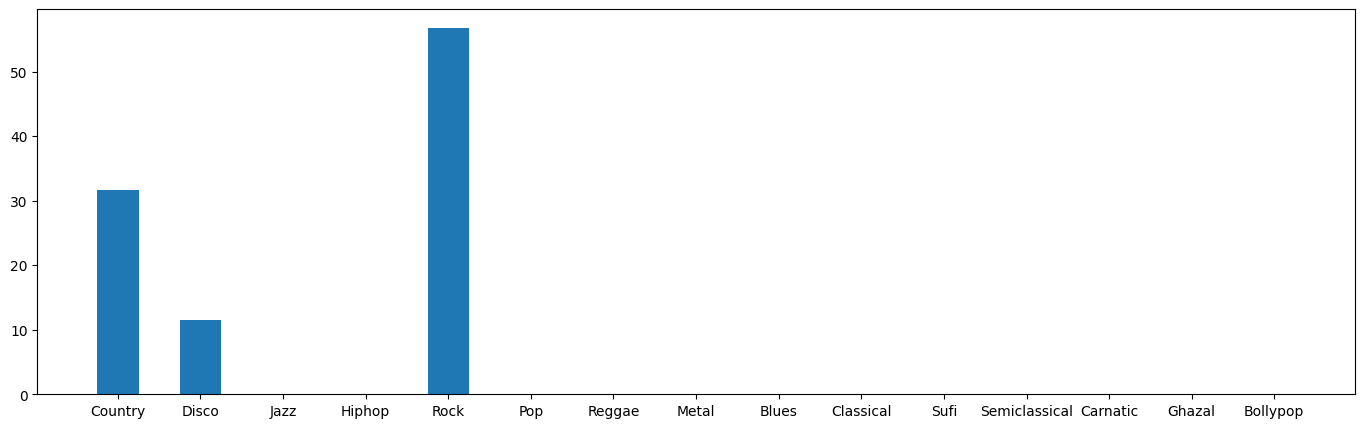

[ 0.         18.56478215  0.          0.         81.43521785  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


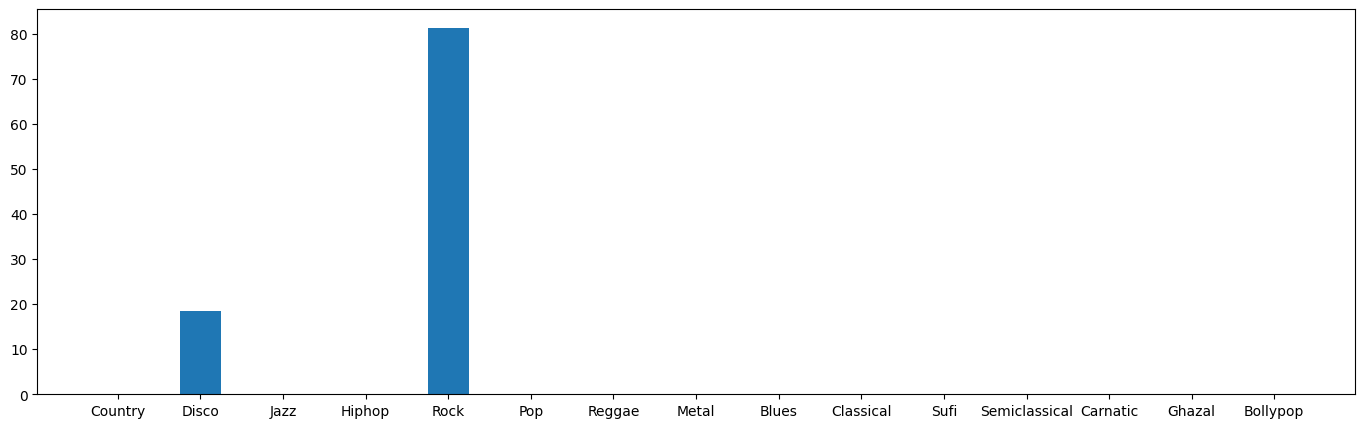

[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


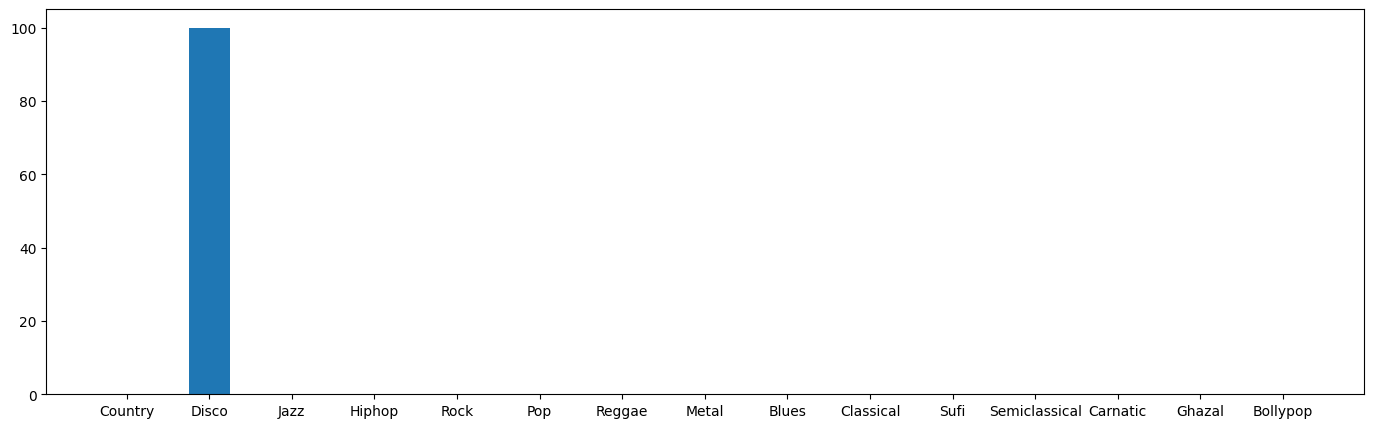

[ 0.          0.         21.99062511  0.          0.          0.
 39.59501827  0.         38.41435662  0.          0.          0.
  0.          0.          0.        ]


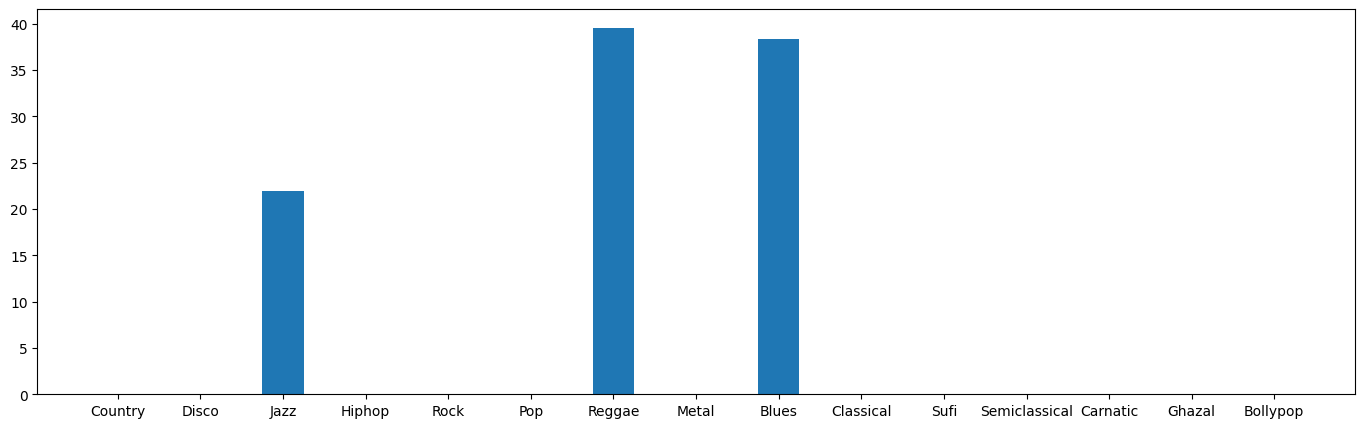

[ 0.         40.03798876  0.          0.         41.59884524 18.36316601
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


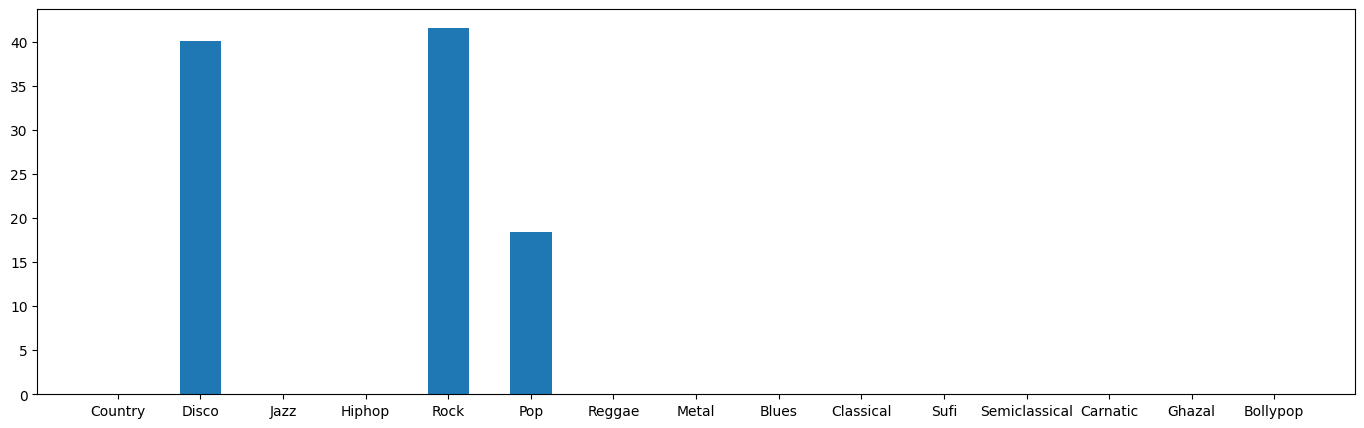

[ 0.         41.46851371  0.          0.          0.         58.53148629
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


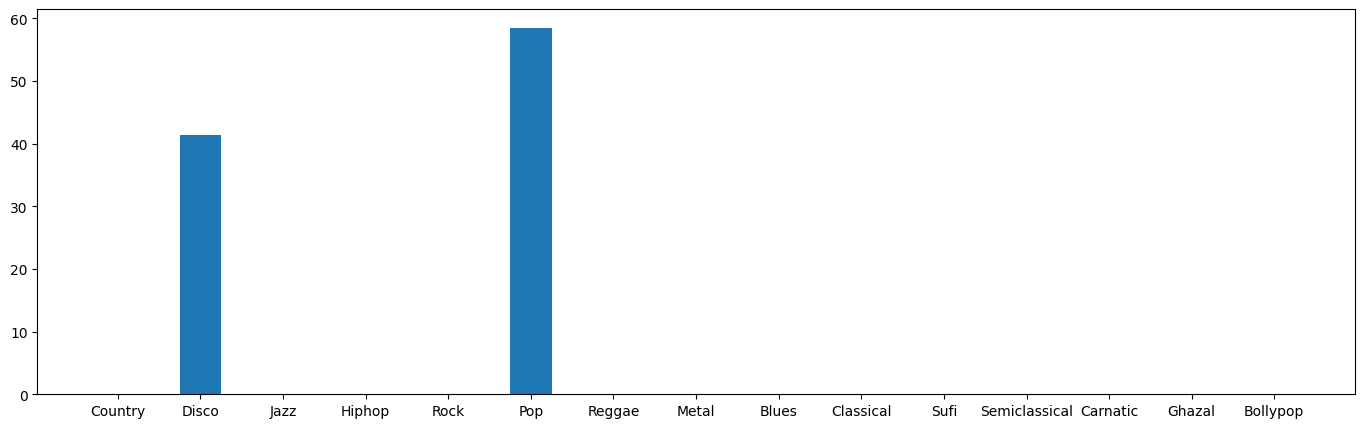

[22.94339856  0.          0.          0.         56.89259818 20.16400327
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


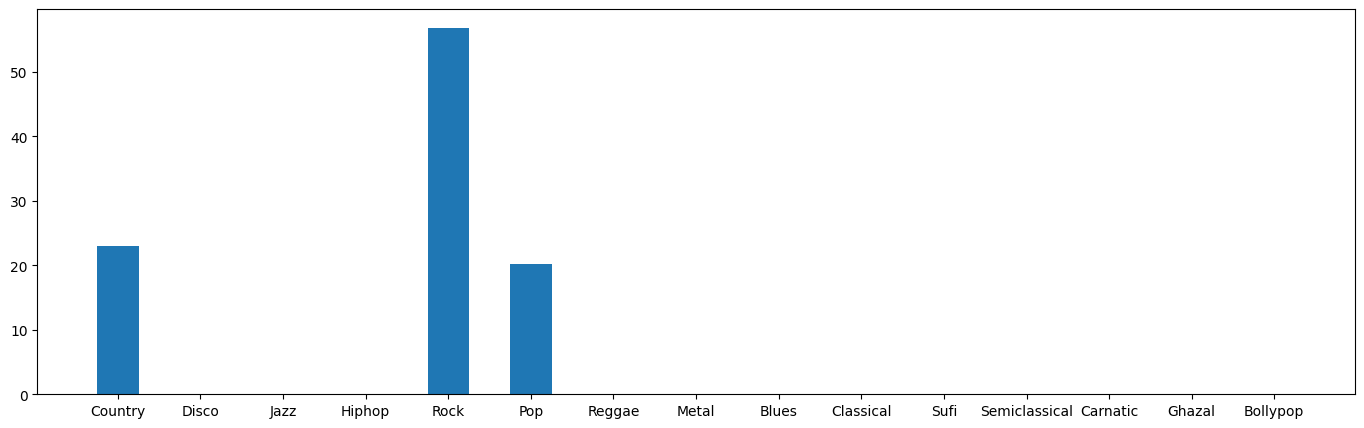

[ 0.         41.43961782  0.          0.         40.36249497 18.19788721
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


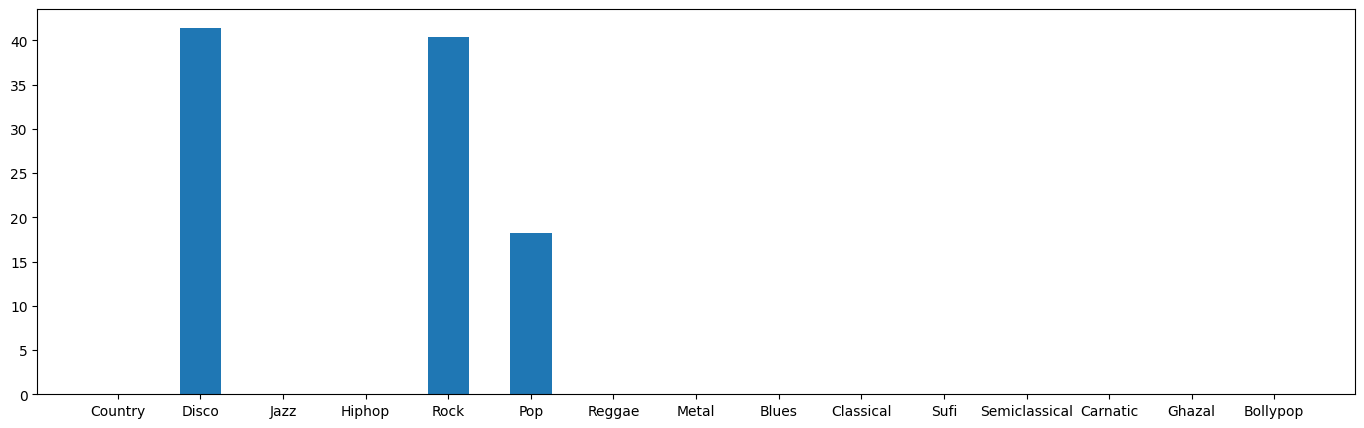

[ 0.          0.          0.          0.         58.42770246 23.8749558
 17.69734174  0.          0.          0.          0.          0.
  0.          0.          0.        ]


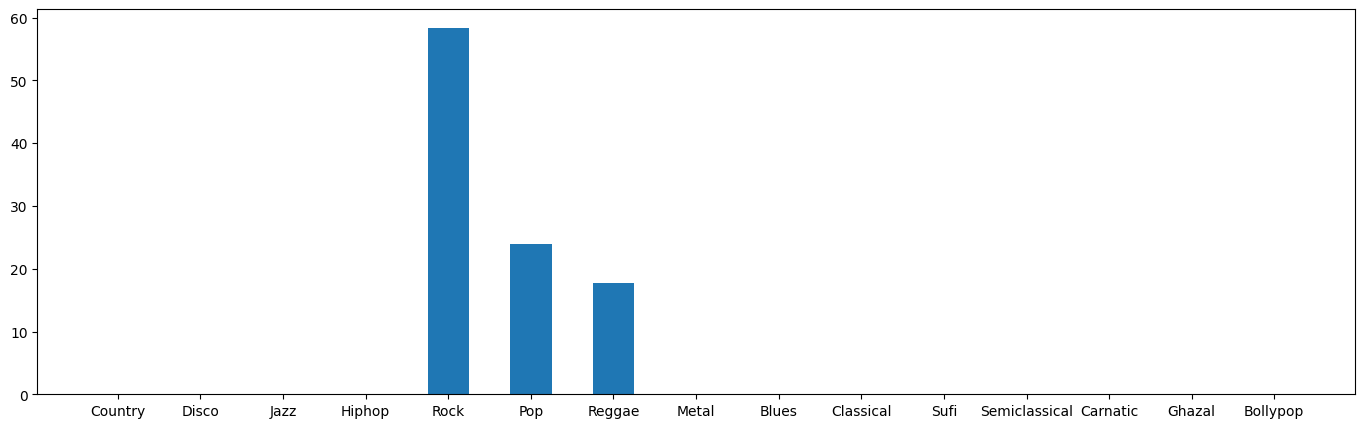

[ 0.         58.72914779  0.          0.         19.92985396 21.34099825
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


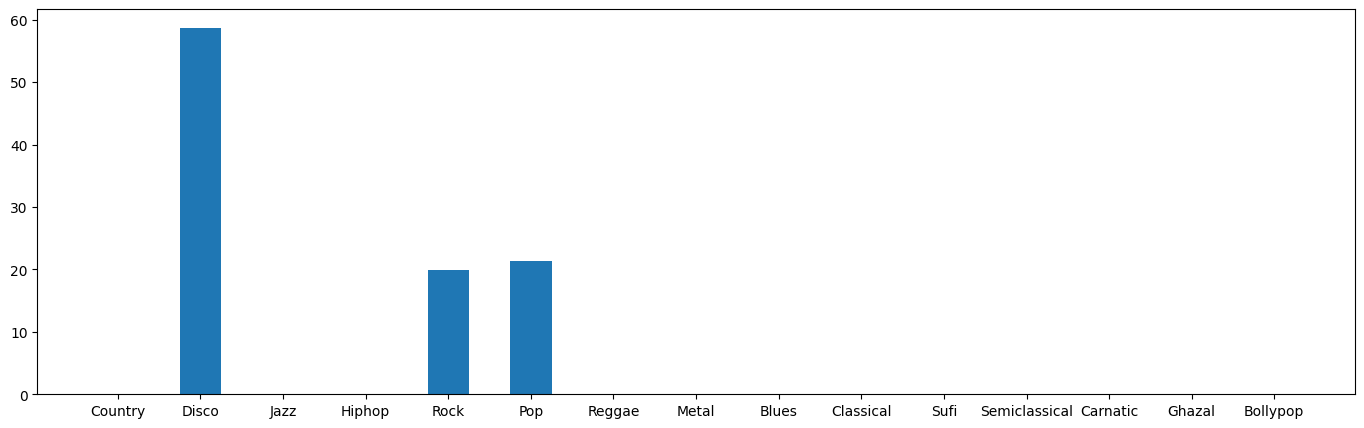

[ 0.         81.70540355  0.          0.          0.         18.29459645
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


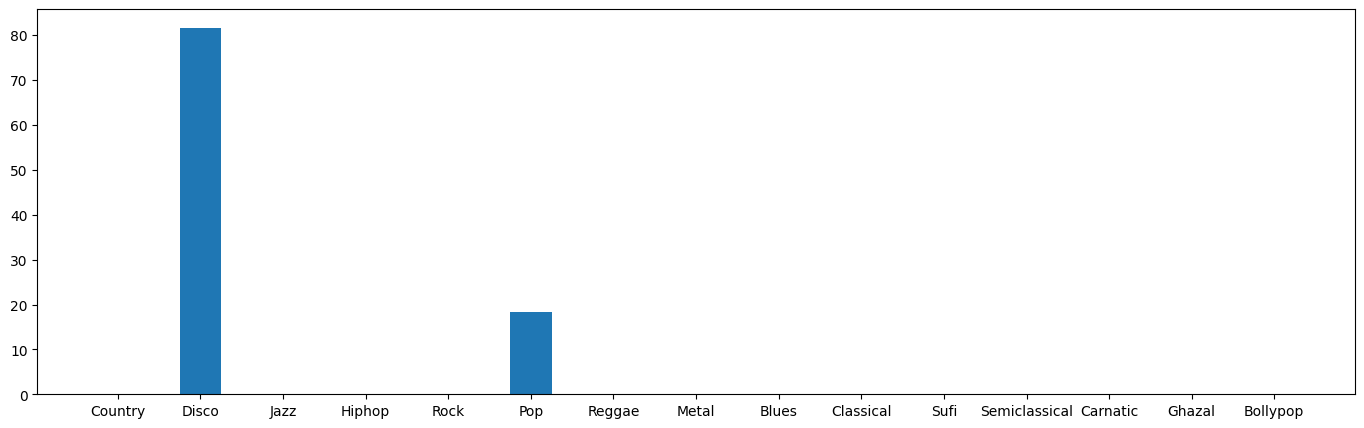

[19.05598172 60.47355906  0.          0.         20.47045922  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


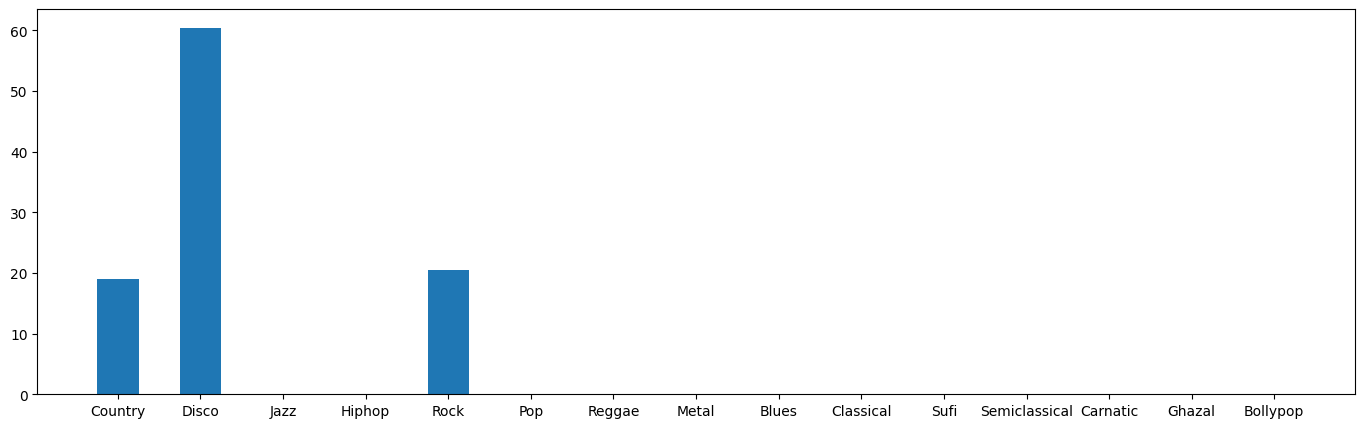

[ 0.         39.49258878  0.         18.48081593  0.         42.02659529
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


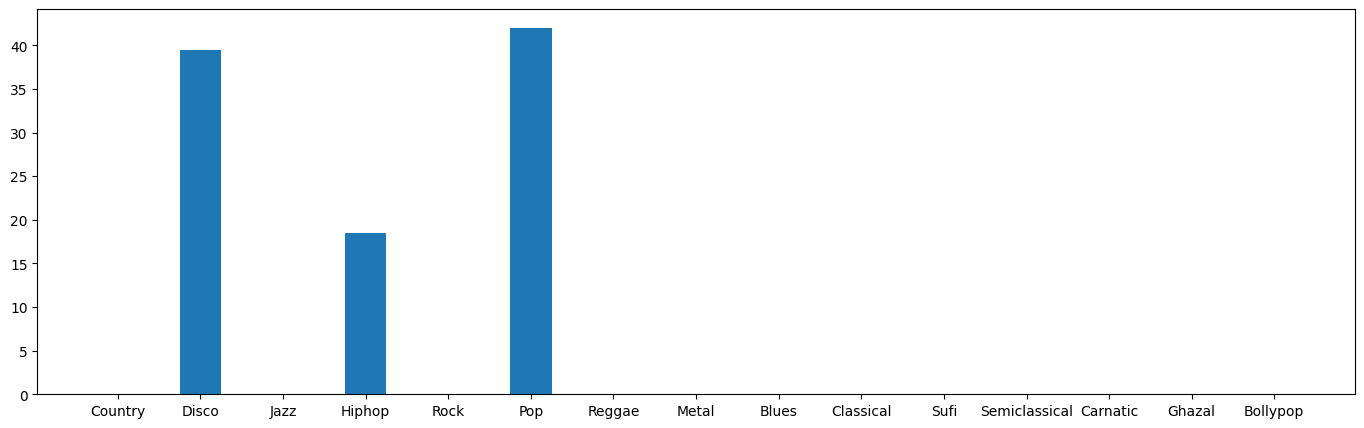

[ 0.         0.         0.         0.        83.0182132  0.
 16.9817868  0.         0.         0.         0.         0.
  0.         0.         0.       ]


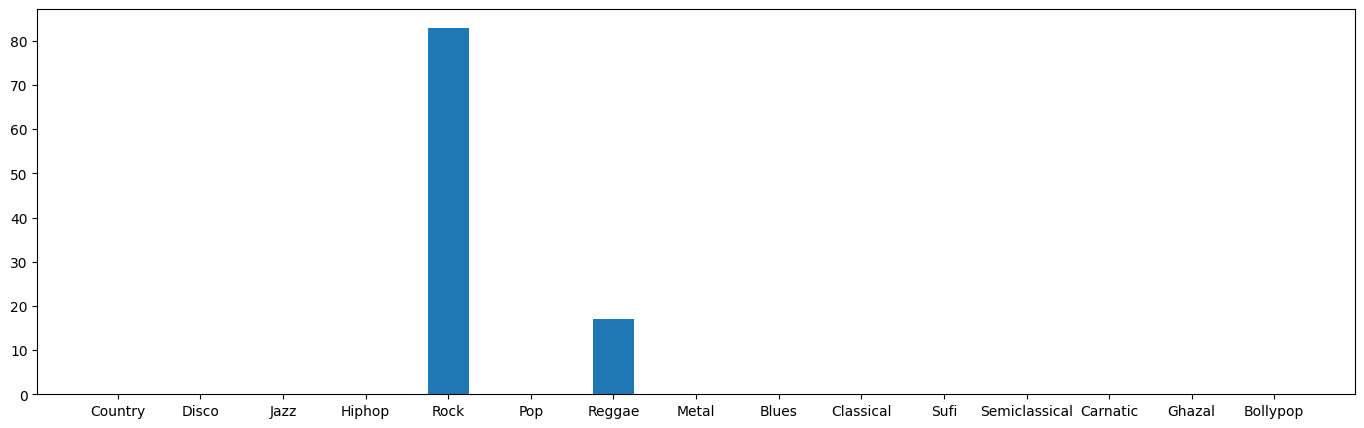

[19.85313406 19.32038675  0.          0.         22.43454327 38.39193592
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


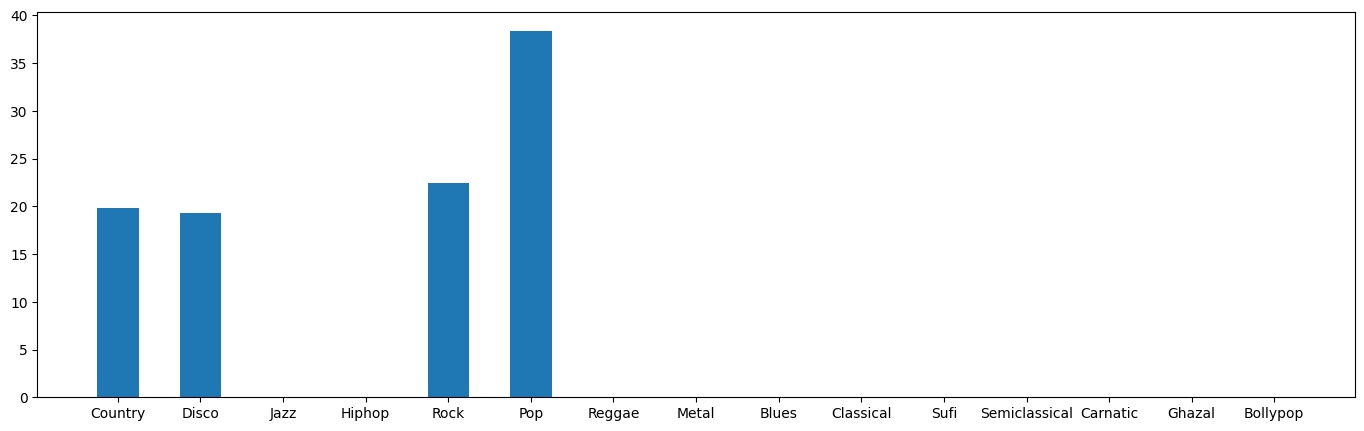

[19.06229132  0.          0.          0.         61.07081599  0.
 19.86689269  0.          0.          0.          0.          0.
  0.          0.          0.        ]


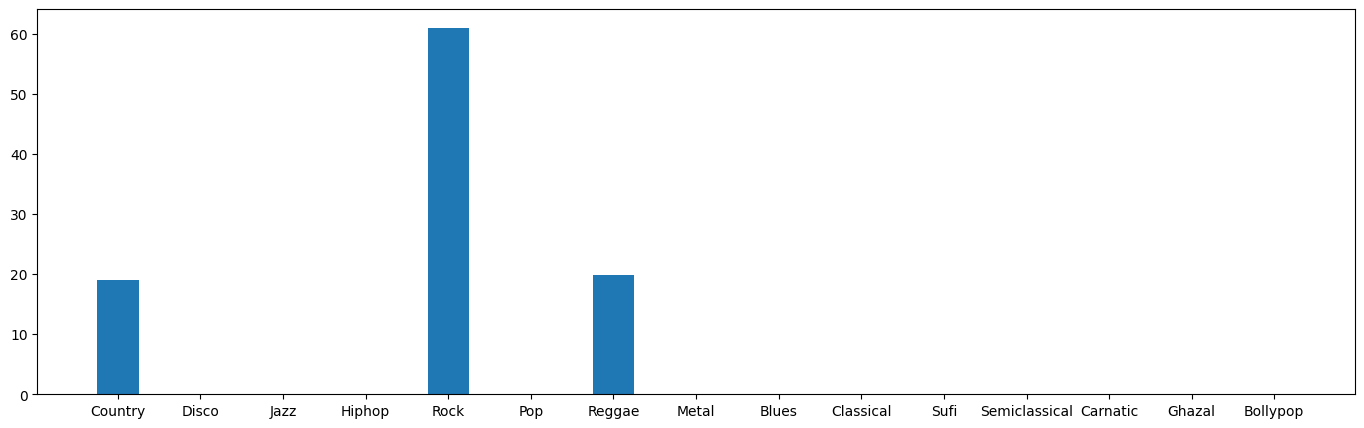

[18.29360705  0.          0.          0.         81.70639295  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


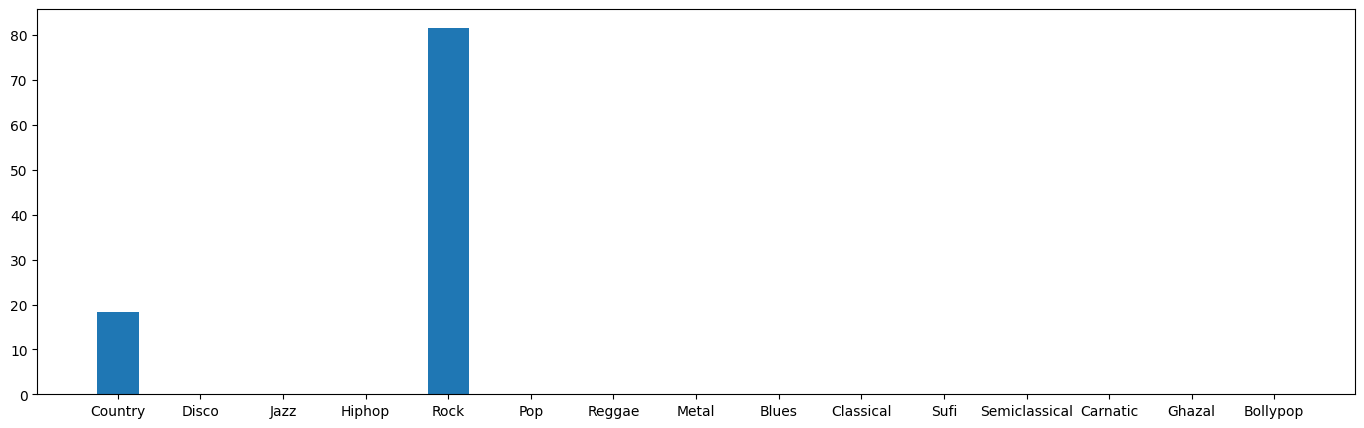

[ 0.         58.96801547  0.          0.         25.67878984  0.
  0.          0.         15.35319469  0.          0.          0.
  0.          0.          0.        ]


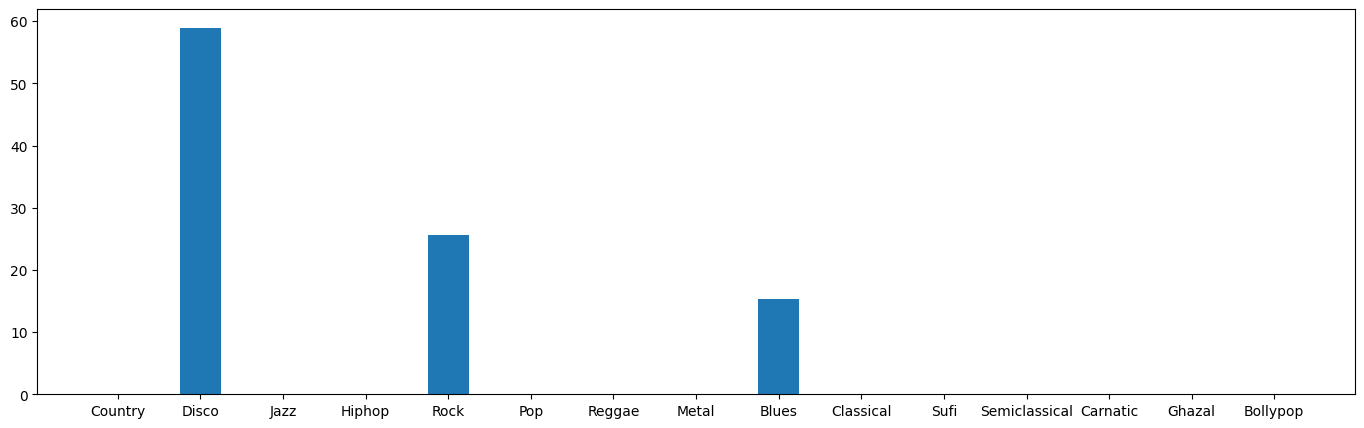

[16.93414162 16.8743115   0.          0.         32.52202248  0.
  0.         17.28914225 16.38038215  0.          0.          0.
  0.          0.          0.        ]


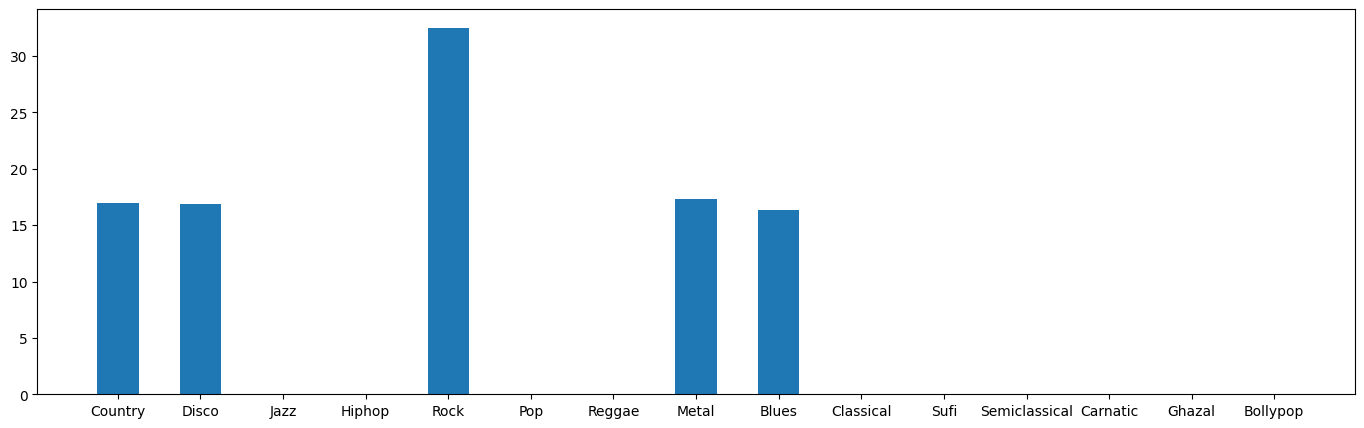

[ 0.         36.20217047  0.          0.         44.0282666   0.
  0.          0.         19.76956294  0.          0.          0.
  0.          0.          0.        ]


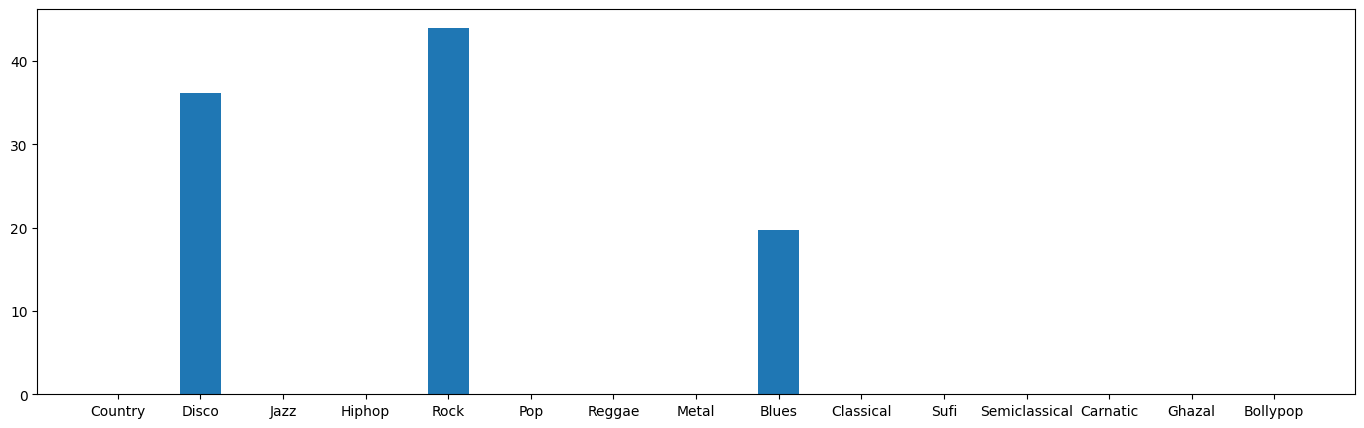

[ 0.         36.61287943  0.         22.00388508 20.97038697  0.
  0.         20.41284852  0.          0.          0.          0.
  0.          0.          0.        ]


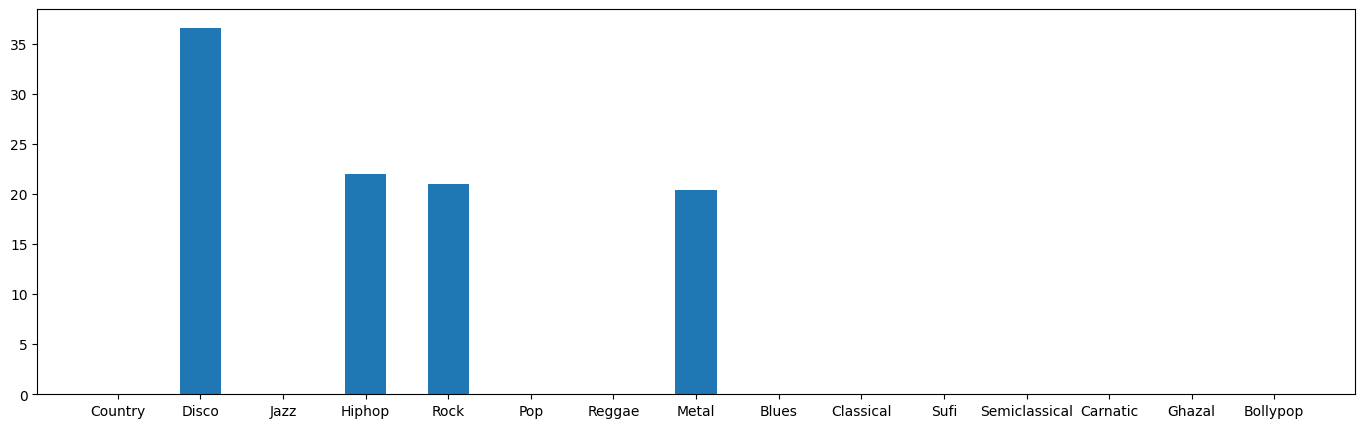

[ 0.         21.80028484  0.          0.         38.34933226  0.
  0.         39.8503829   0.          0.          0.          0.
  0.          0.          0.        ]


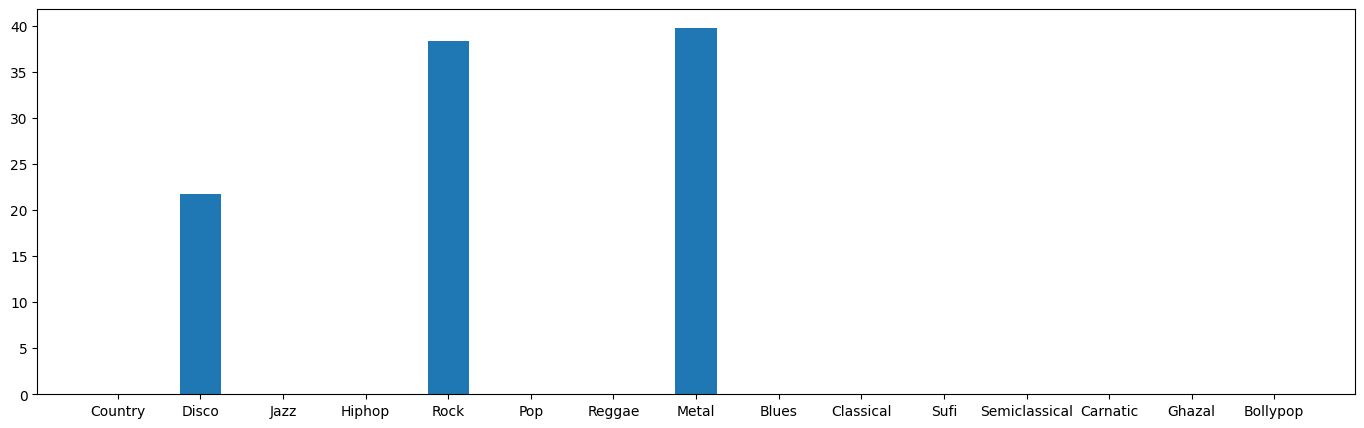

[ 0.         32.9170568  15.30142027  0.         51.78152294  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


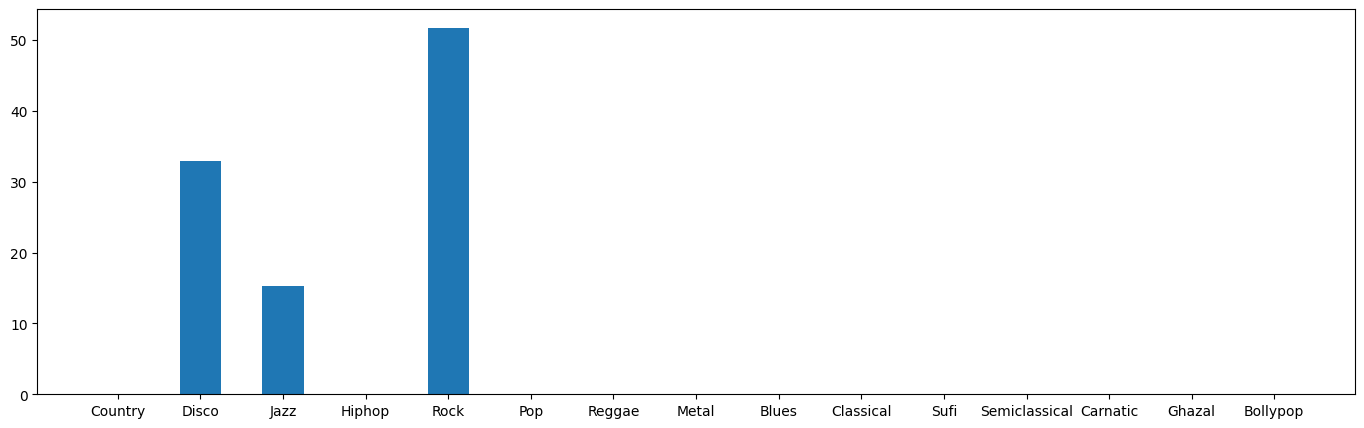

[ 0.        20.6050522  0.         0.        57.3003118  0.
  0.        22.094636   0.         0.         0.         0.
  0.         0.         0.       ]


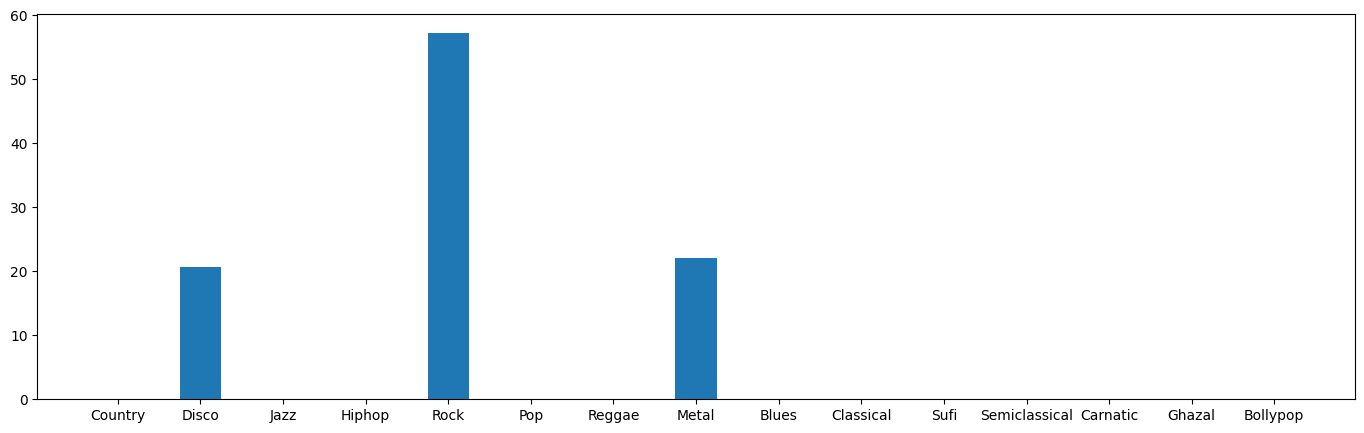

[17.81904002  0.          0.          0.          0.         82.18095998
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


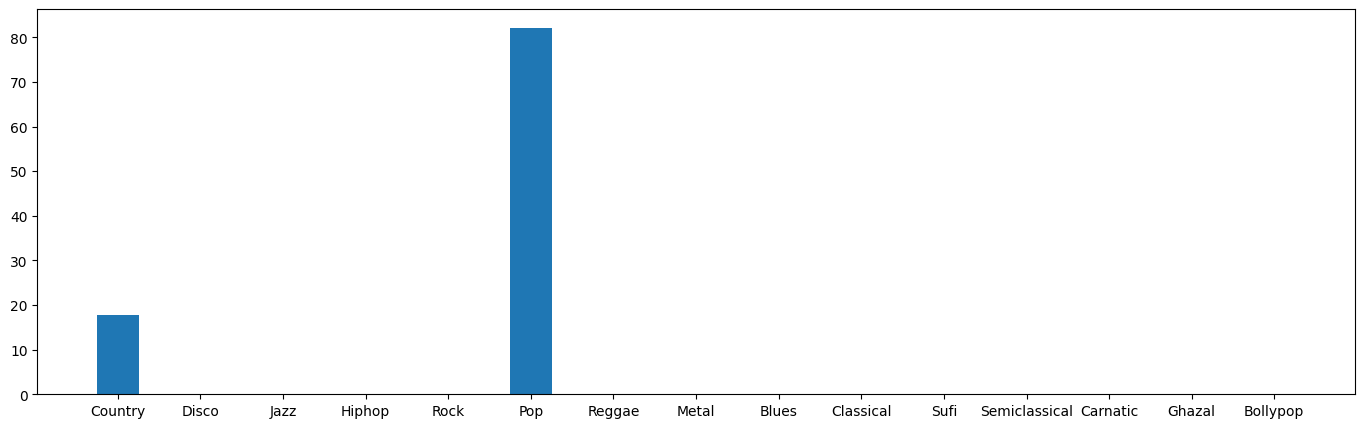

[19.32161019 39.86851471  0.          0.          0.         40.8098751
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


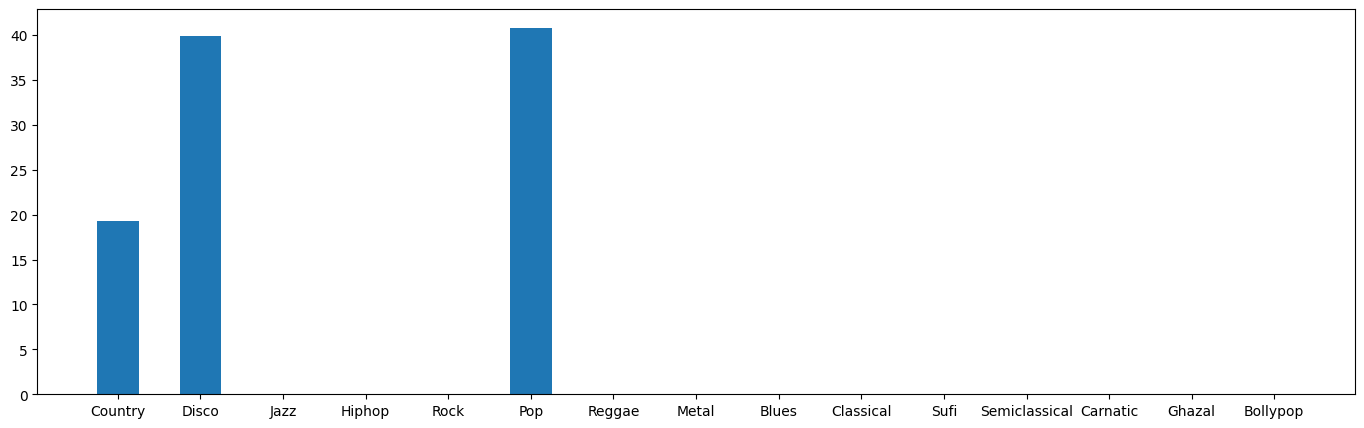

[ 0.          0.          0.         40.65200308  0.          0.
 59.34799692  0.          0.          0.          0.          0.
  0.          0.          0.        ]


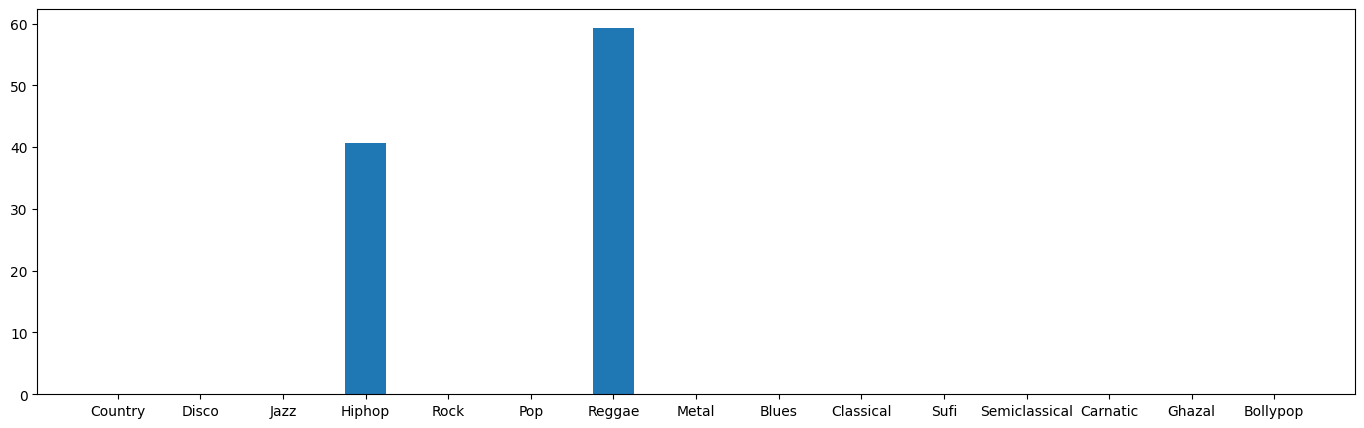

[ 0.         17.20956994  0.          0.          0.         45.2671566
 37.52327346  0.          0.          0.          0.          0.
  0.          0.          0.        ]


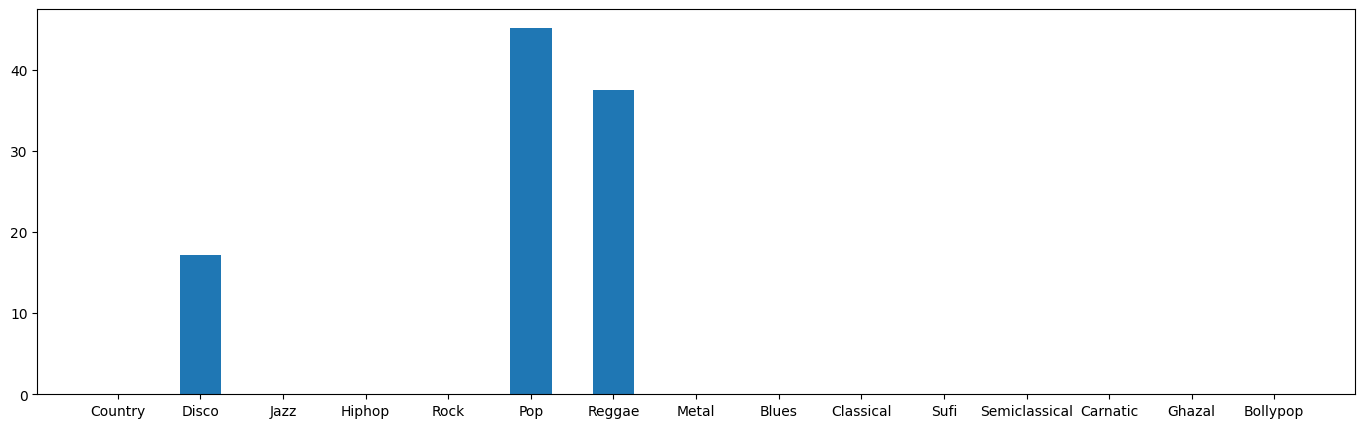

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


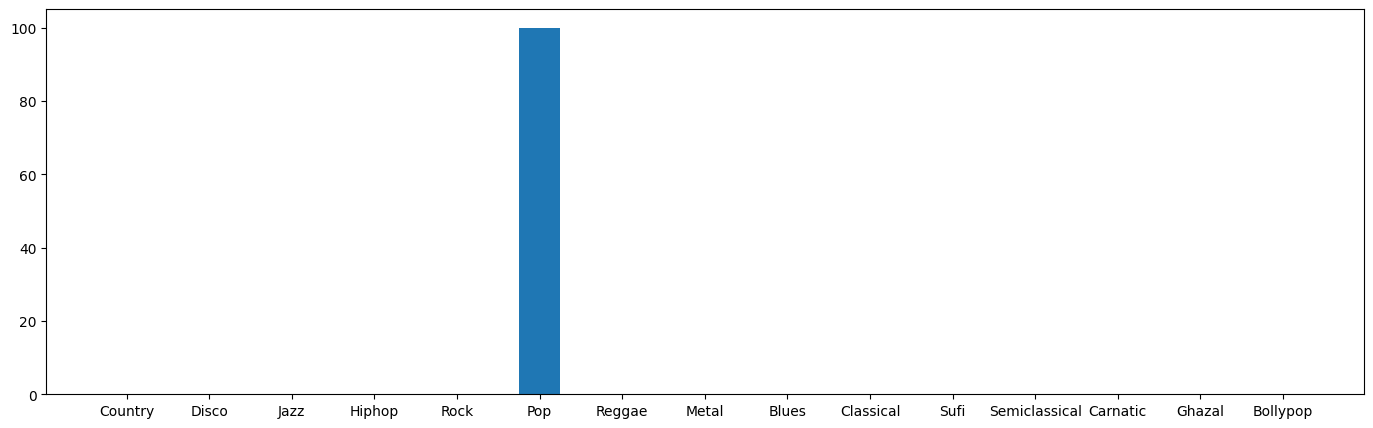

[18.40948144 44.29868377  0.          0.          0.         37.29183479
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


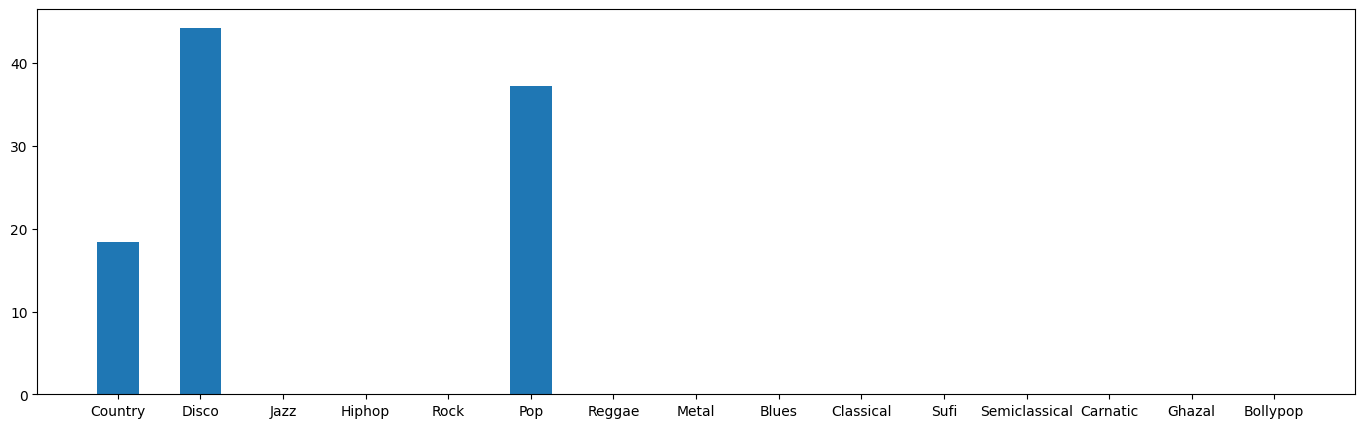

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


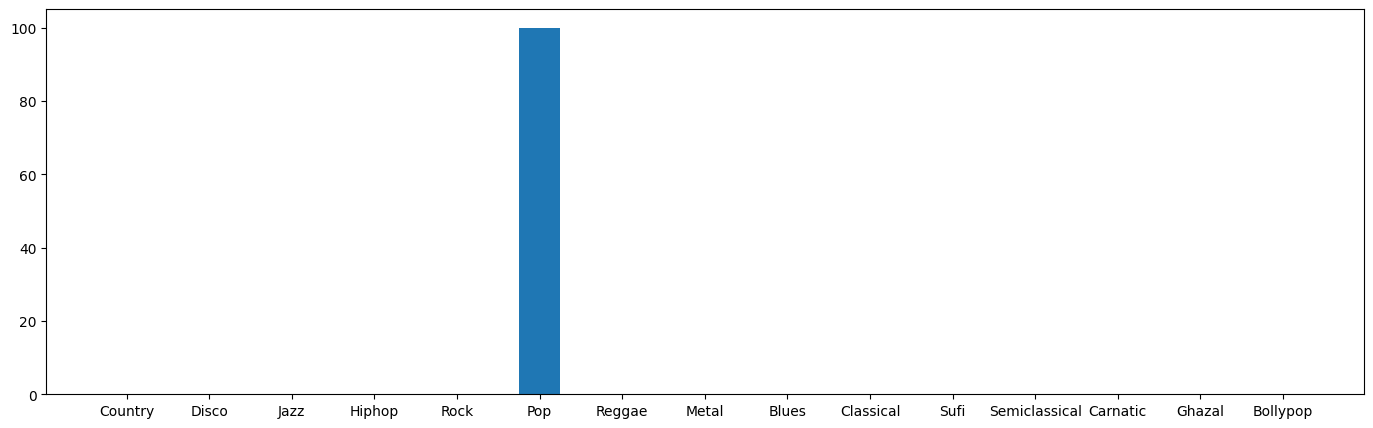

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


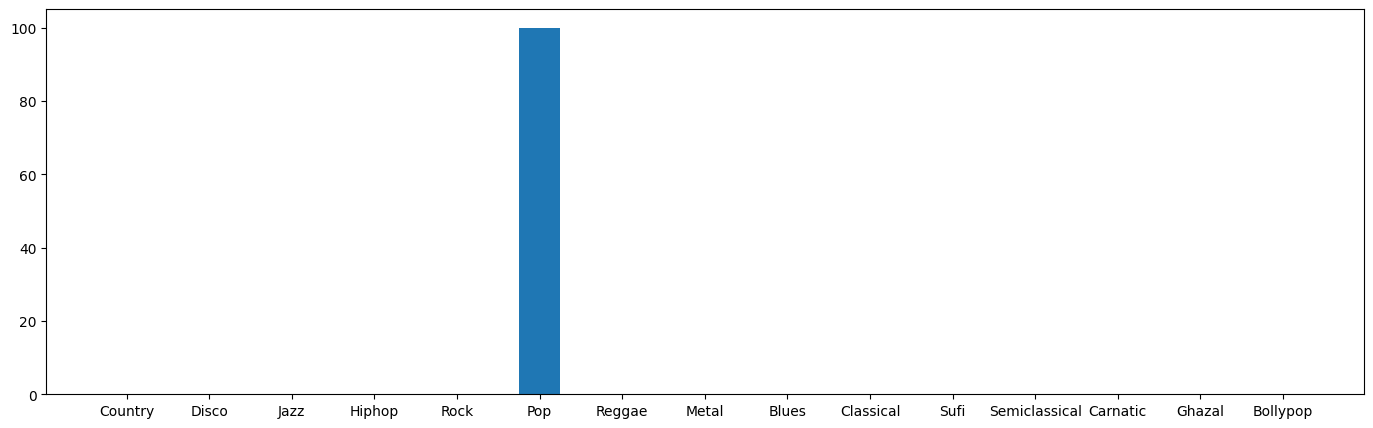

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


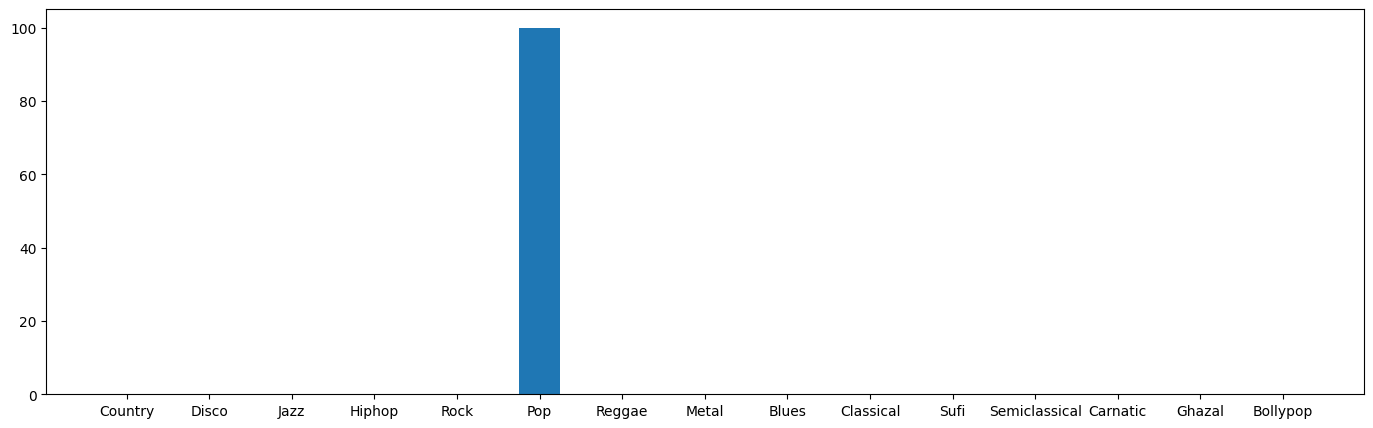

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


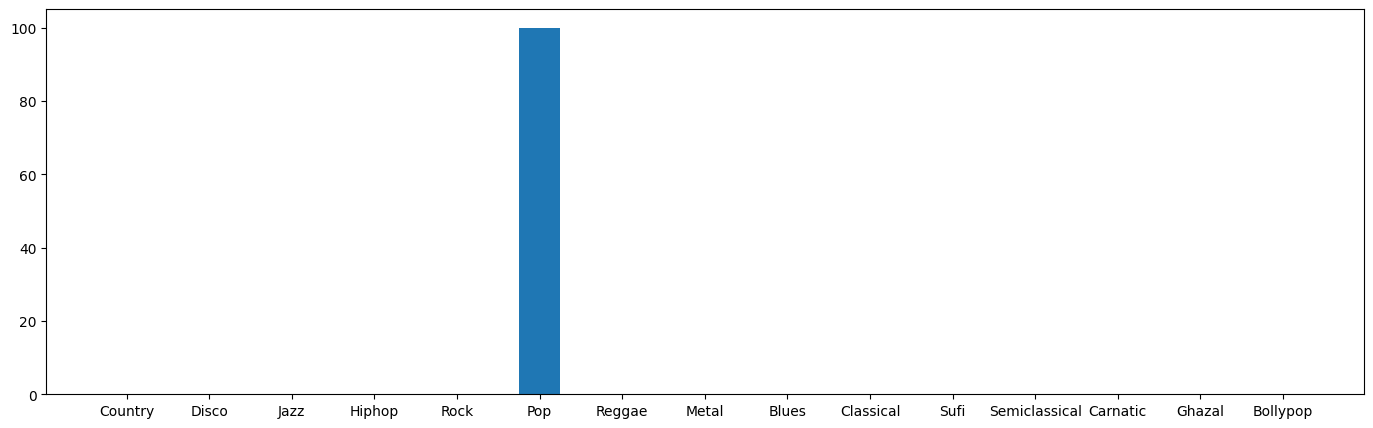

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


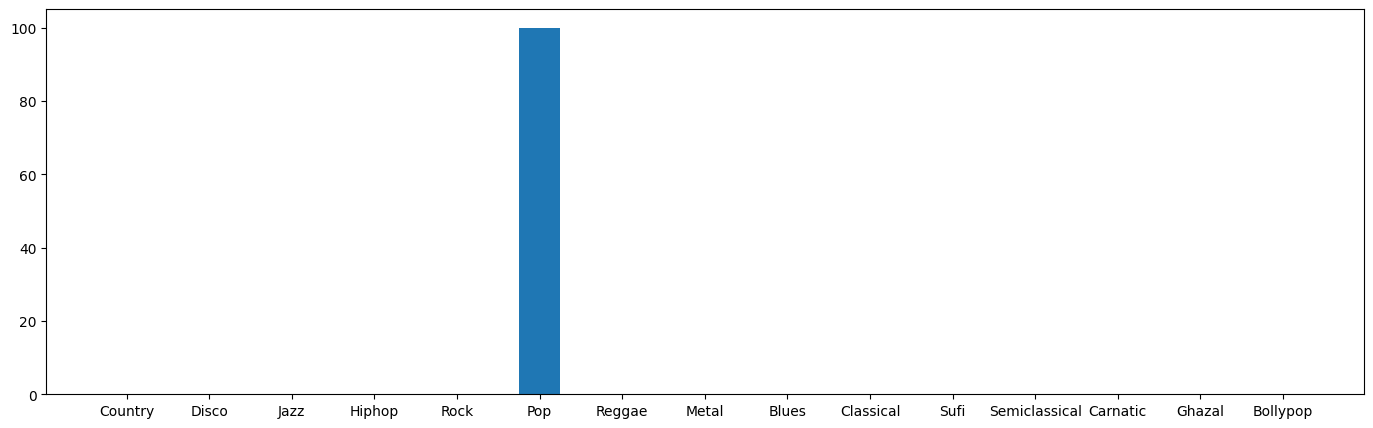

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


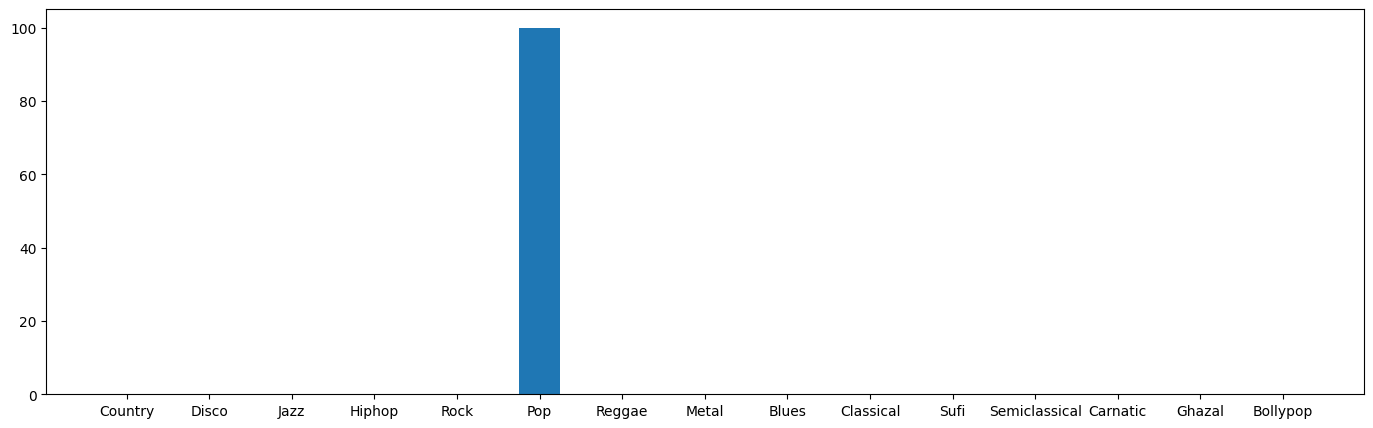

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


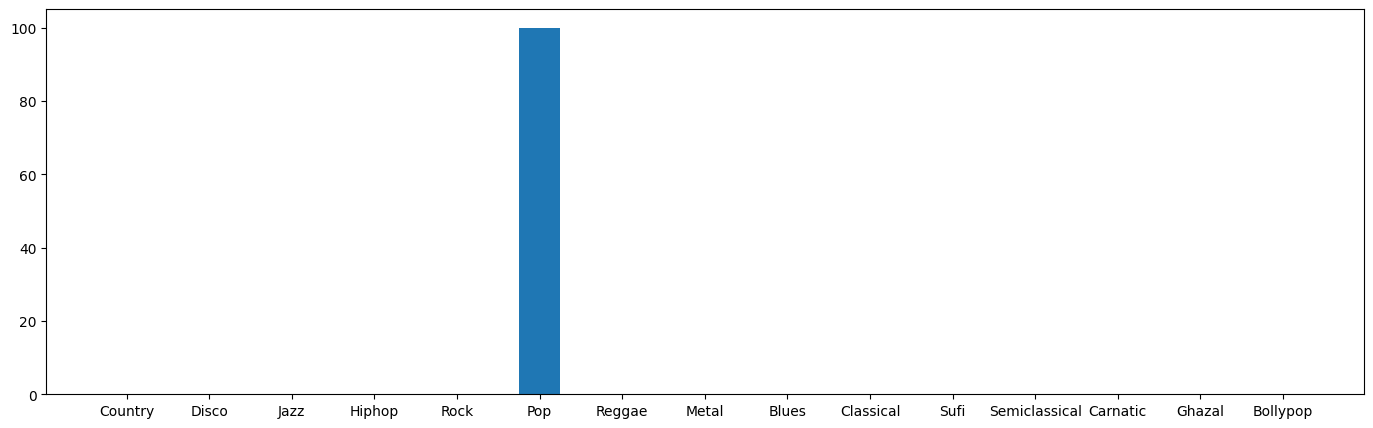

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


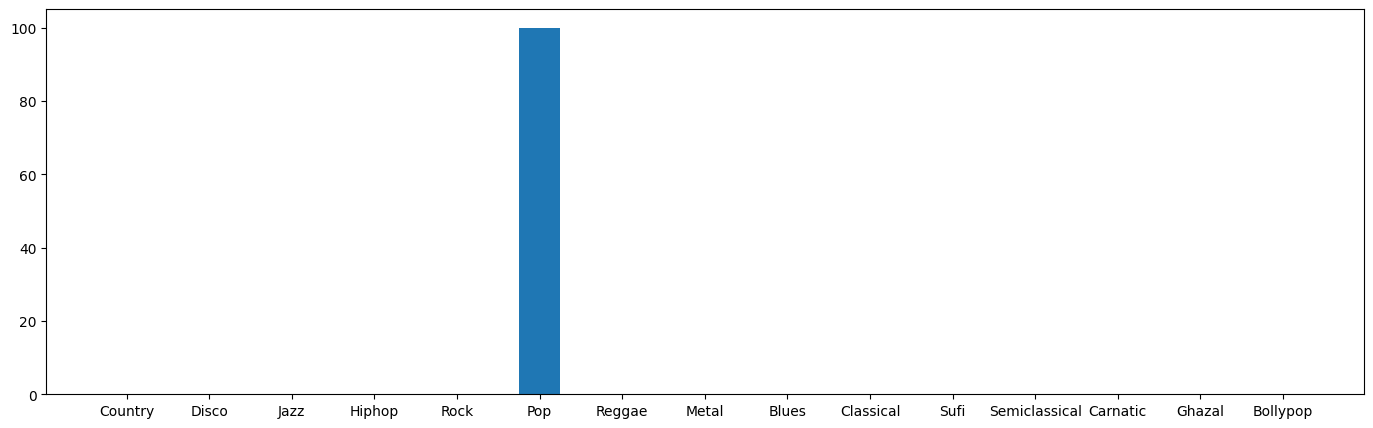

[19.49828039 19.00926802  0.          0.         21.90929742 39.58315417
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


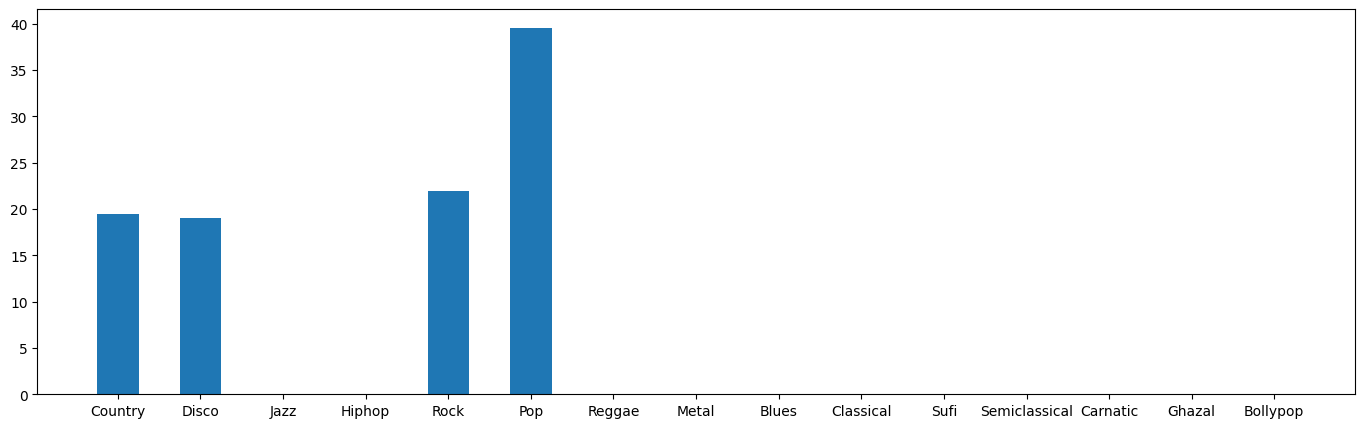

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


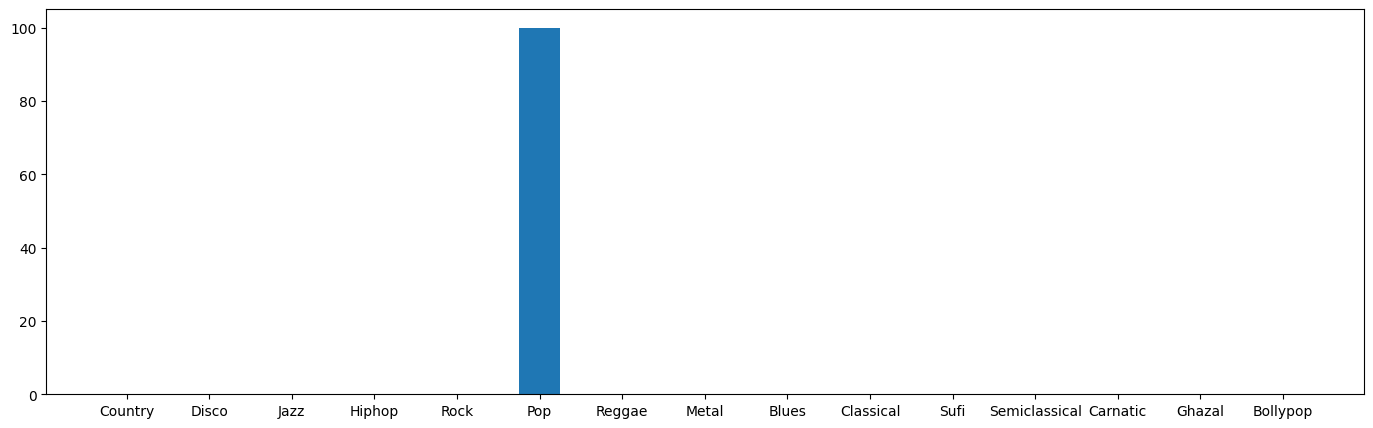

[17.95170964  0.          0.          0.         21.65036782 60.39792253
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


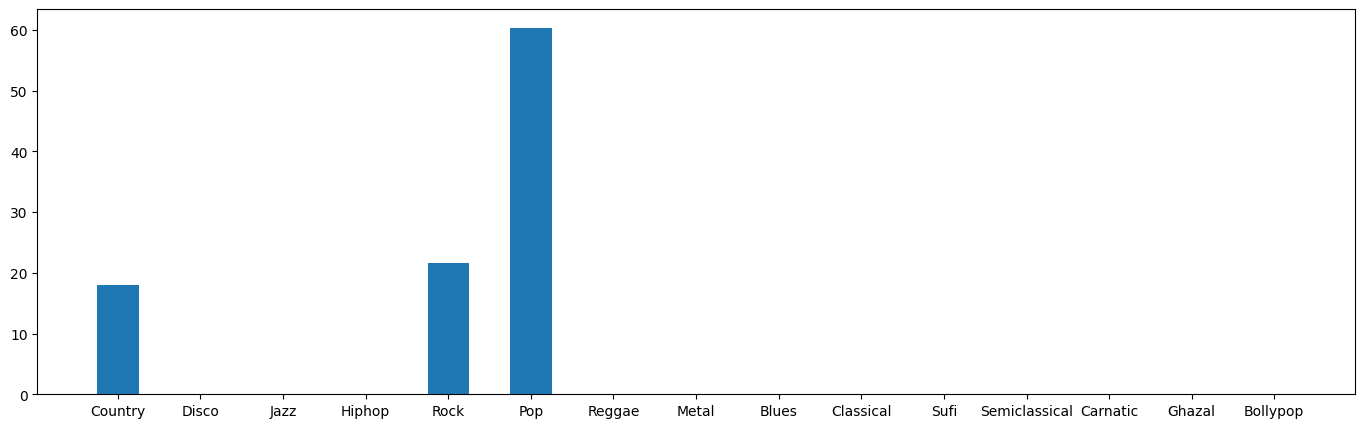

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


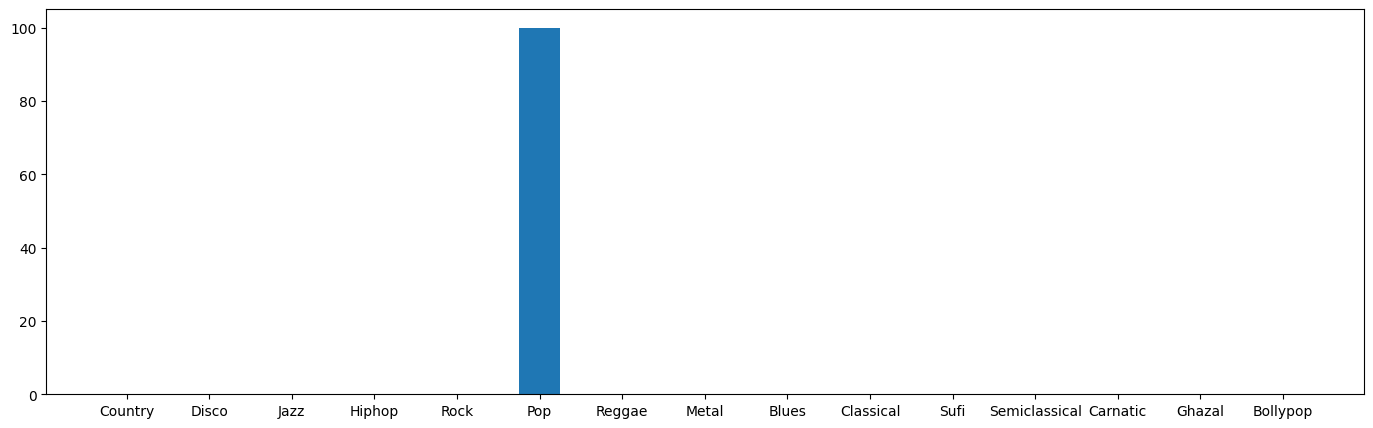

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


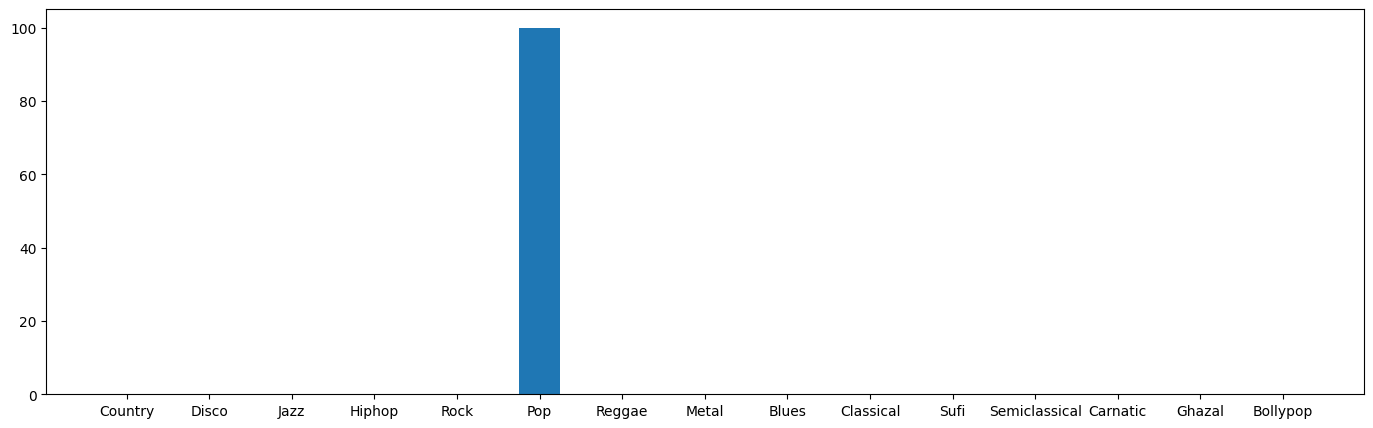

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


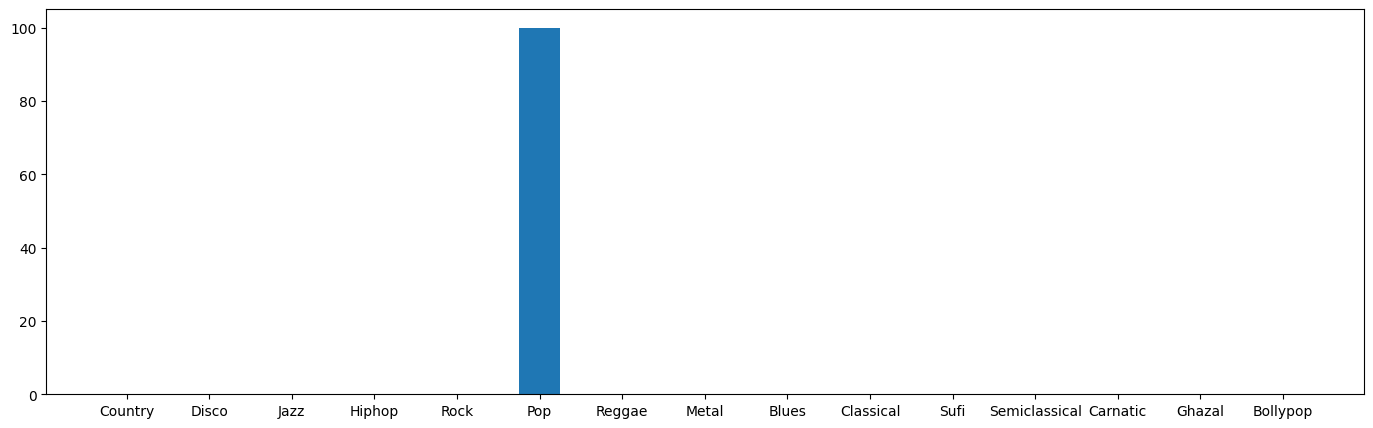

[17.22951295 34.33295162  0.          0.         48.43753543  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


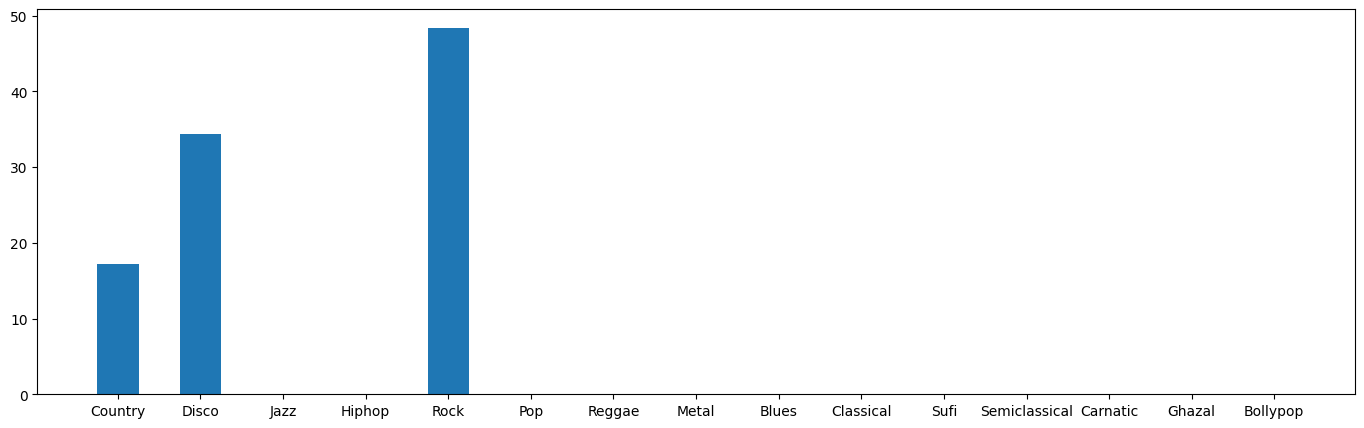

[ 0.          0.          0.          0.          0.         80.98013803
 19.01986197  0.          0.          0.          0.          0.
  0.          0.          0.        ]


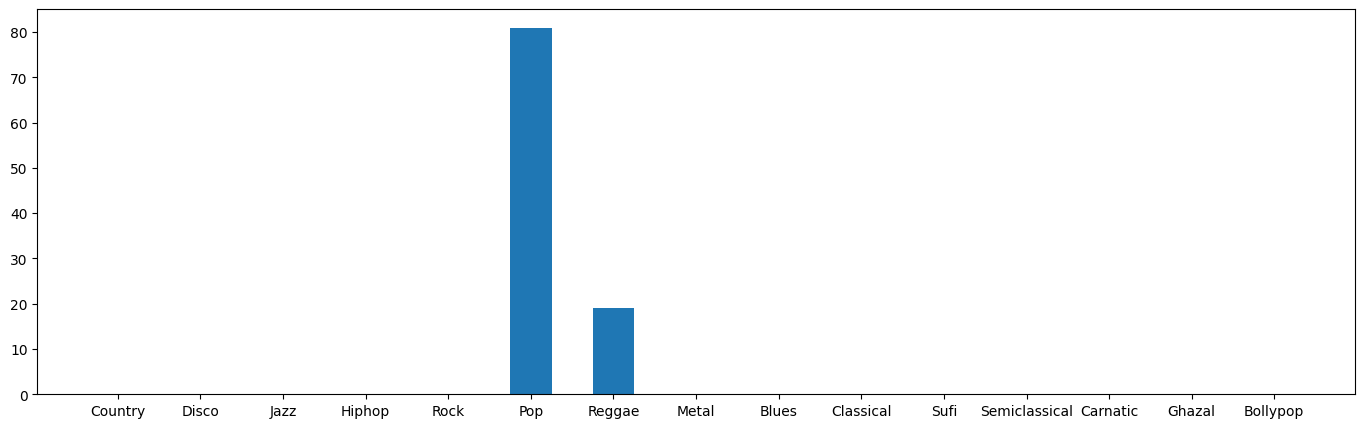

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


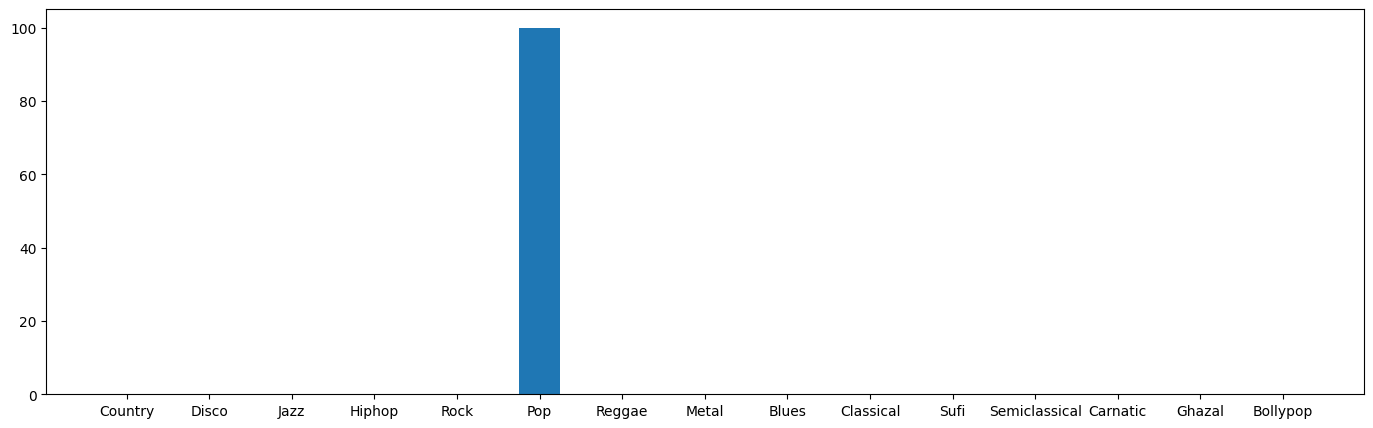

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


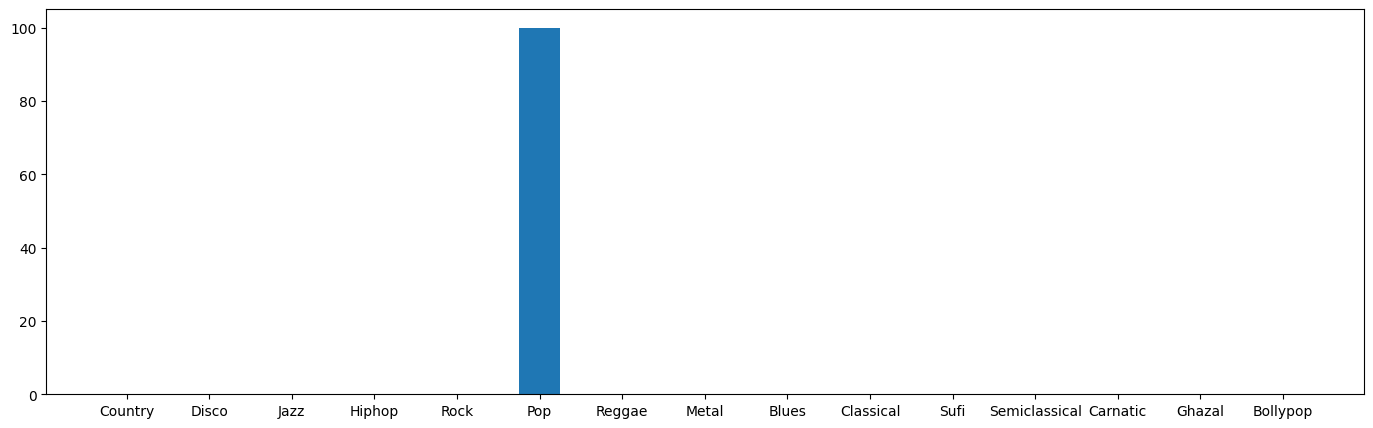

[38.39756652  0.          0.          0.         25.46324209  0.
 36.13919139  0.          0.          0.          0.          0.
  0.          0.          0.        ]


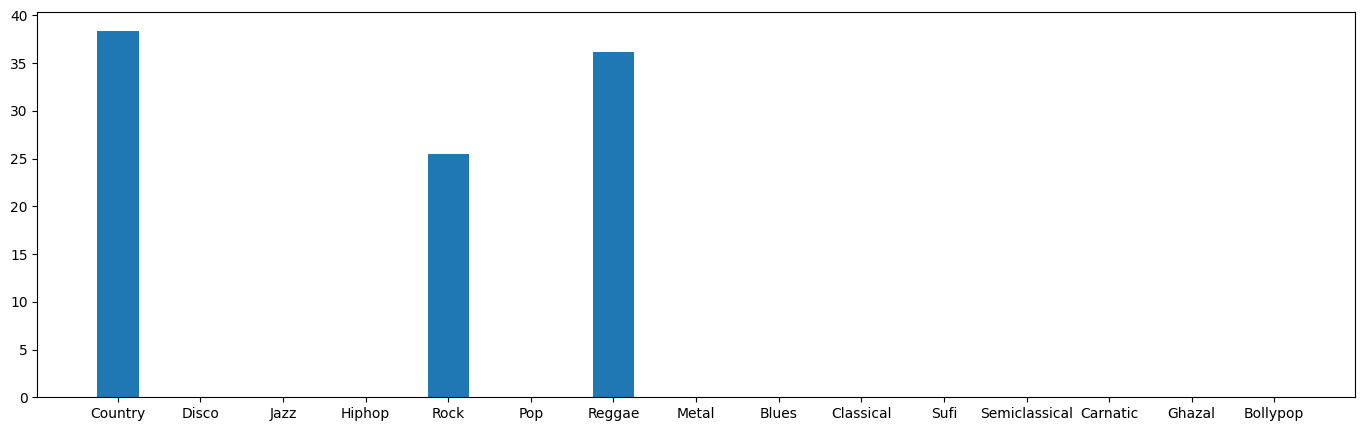

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


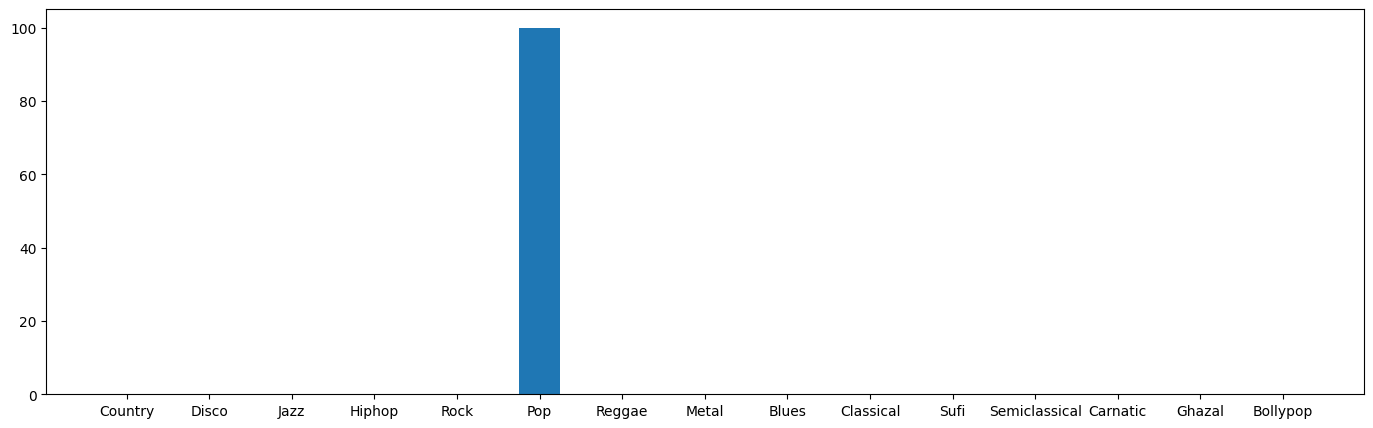

[ 0.          0.          0.         19.40591334  0.         80.59408666
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


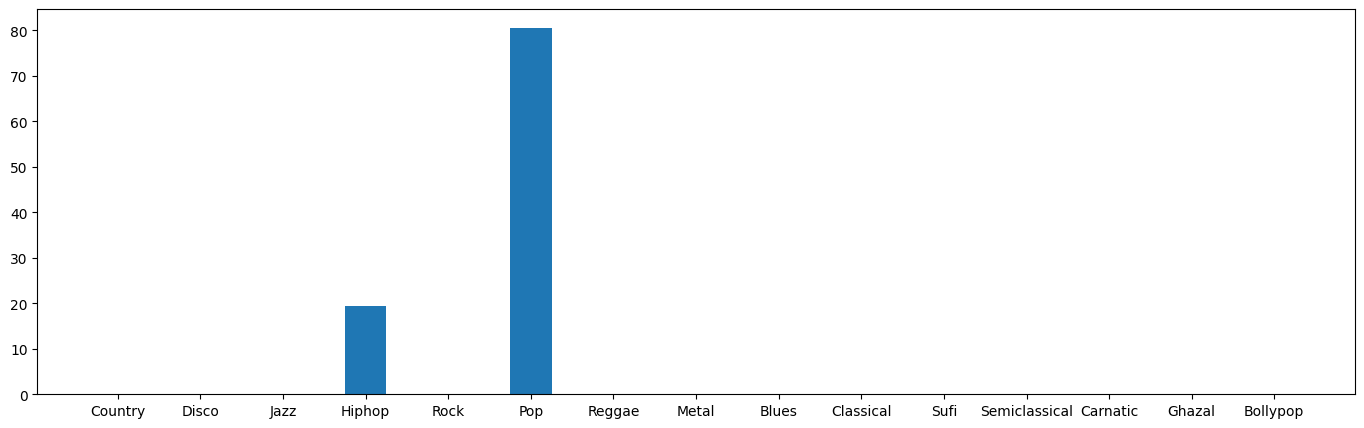

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


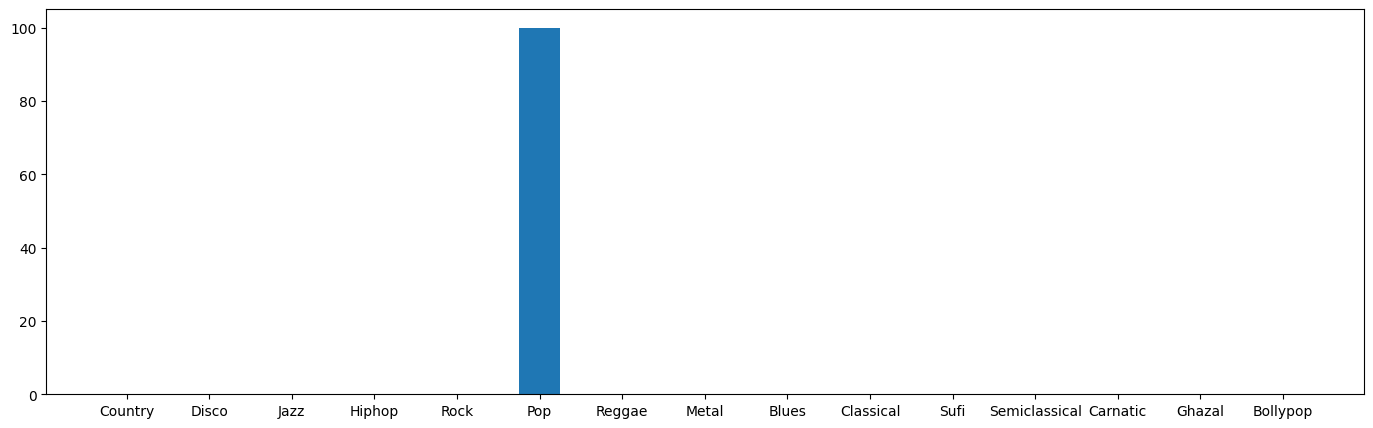

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


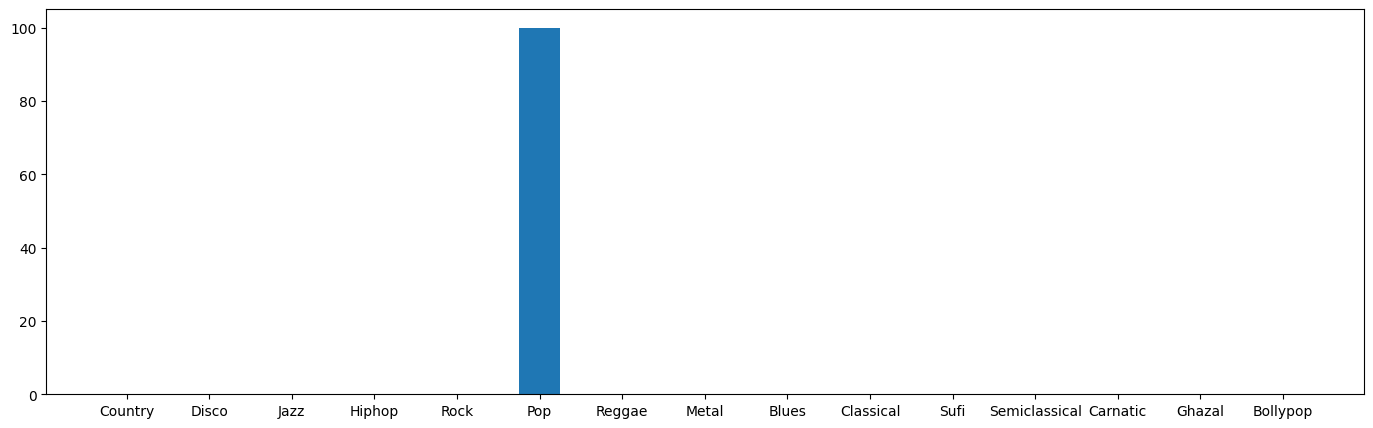

[ 0.          0.          0.         17.32554628  0.          0.
 82.67445372  0.          0.          0.          0.          0.
  0.          0.          0.        ]


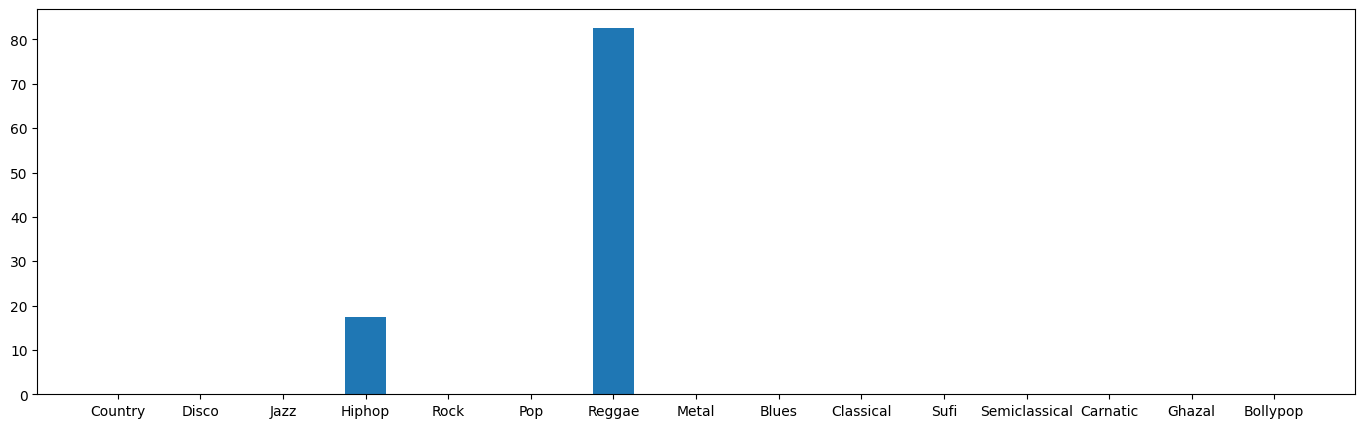

[17.75170333  0.          0.          0.          0.          0.
 82.24829667  0.          0.          0.          0.          0.
  0.          0.          0.        ]


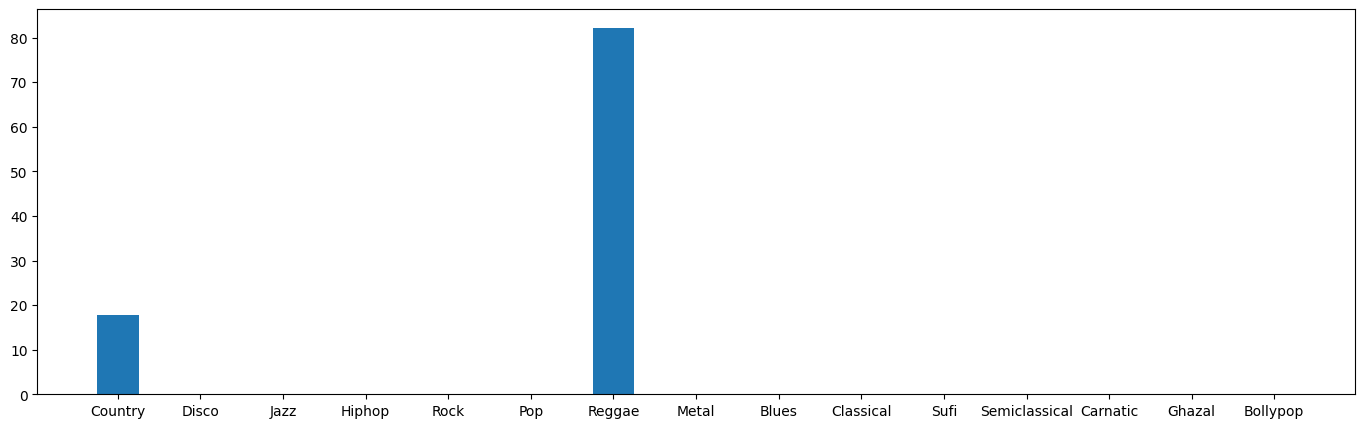

[40.97926592 21.22851329  0.         18.93698516  0.          0.
 18.85523563  0.          0.          0.          0.          0.
  0.          0.          0.        ]


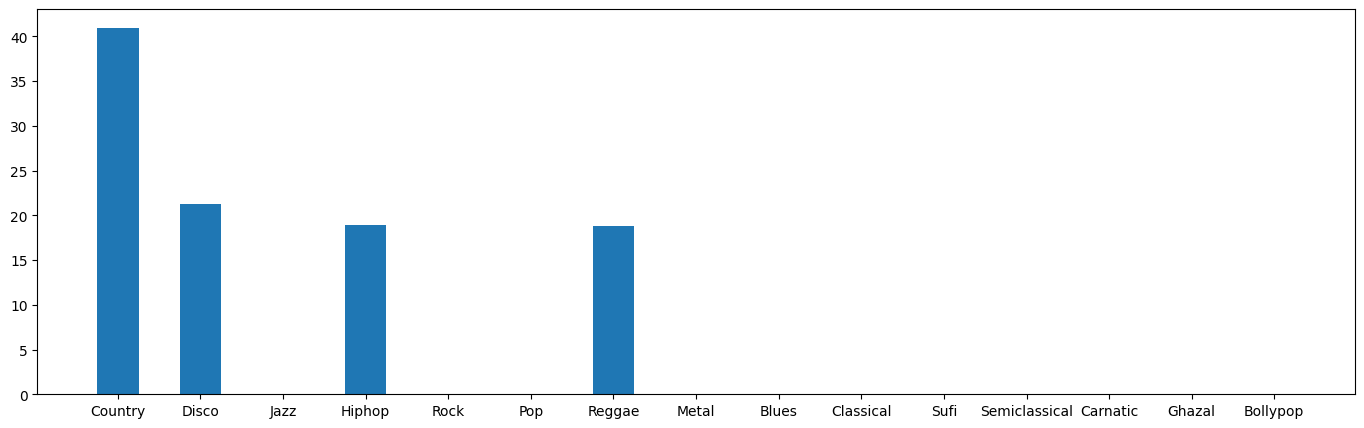

[ 0.          0.          0.         45.28103275  0.          0.
 17.76200172 36.95696553  0.          0.          0.          0.
  0.          0.          0.        ]


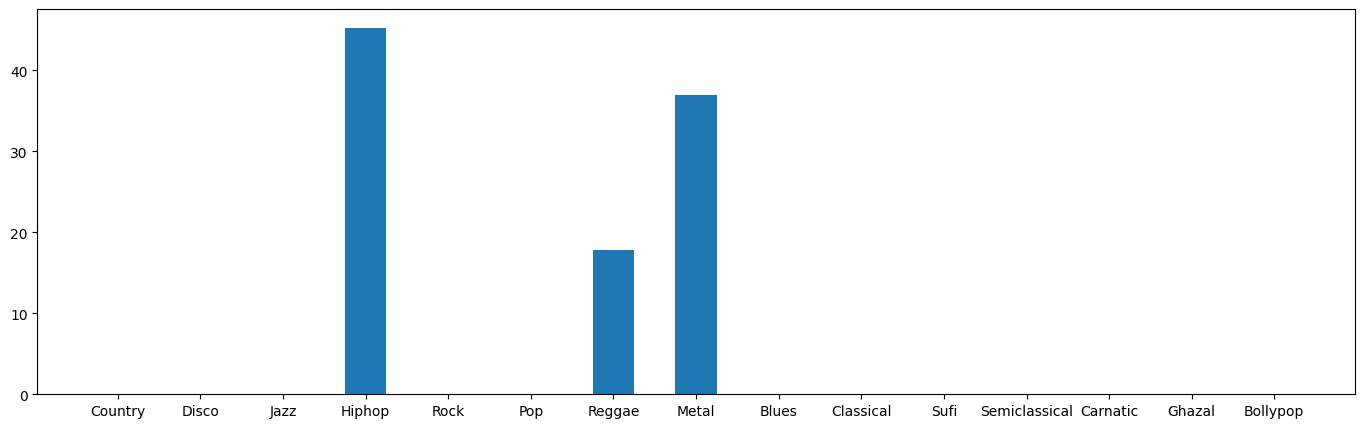

[  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.]


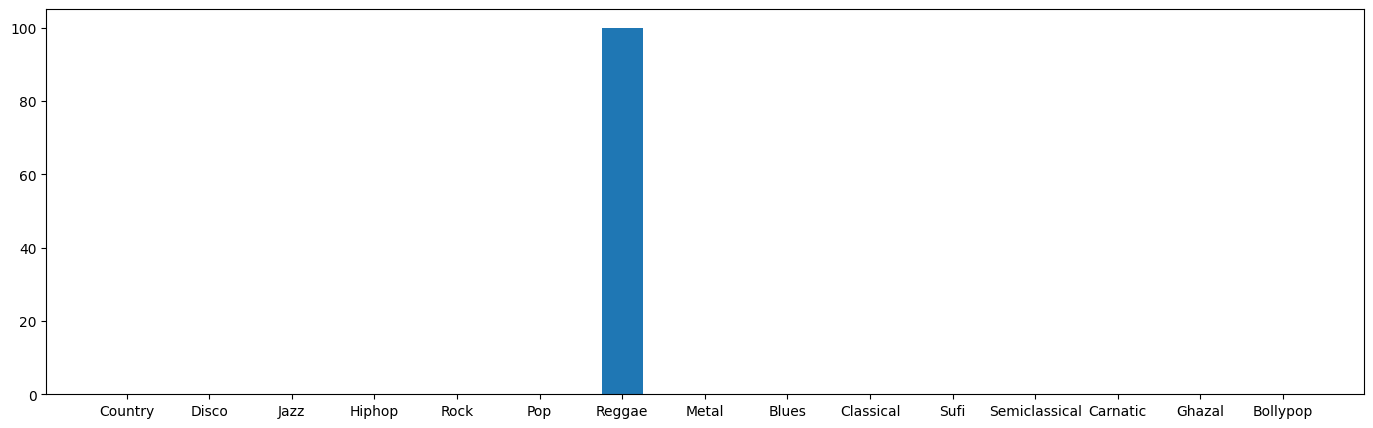

[  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.]


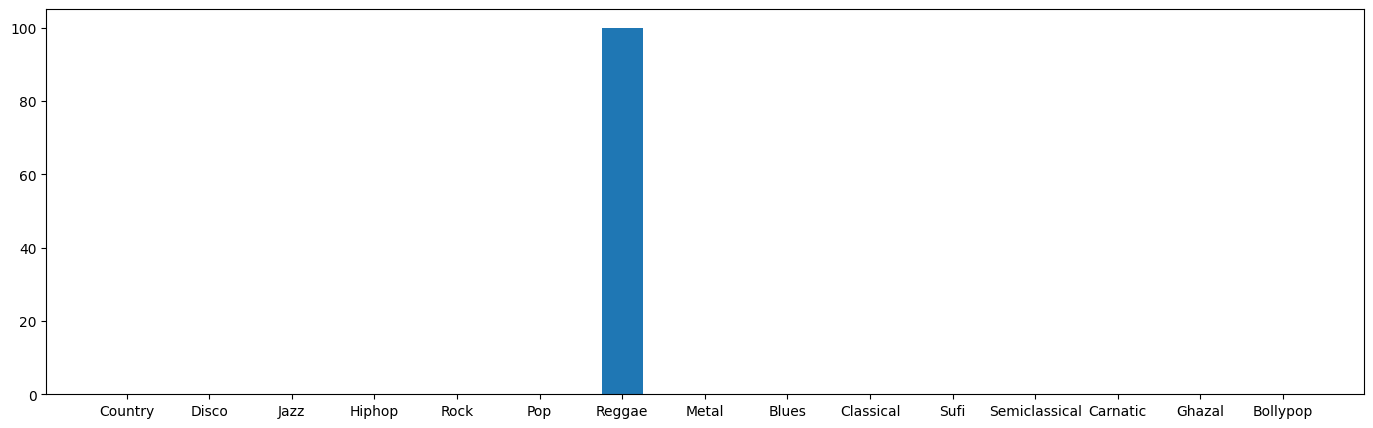

[  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.]


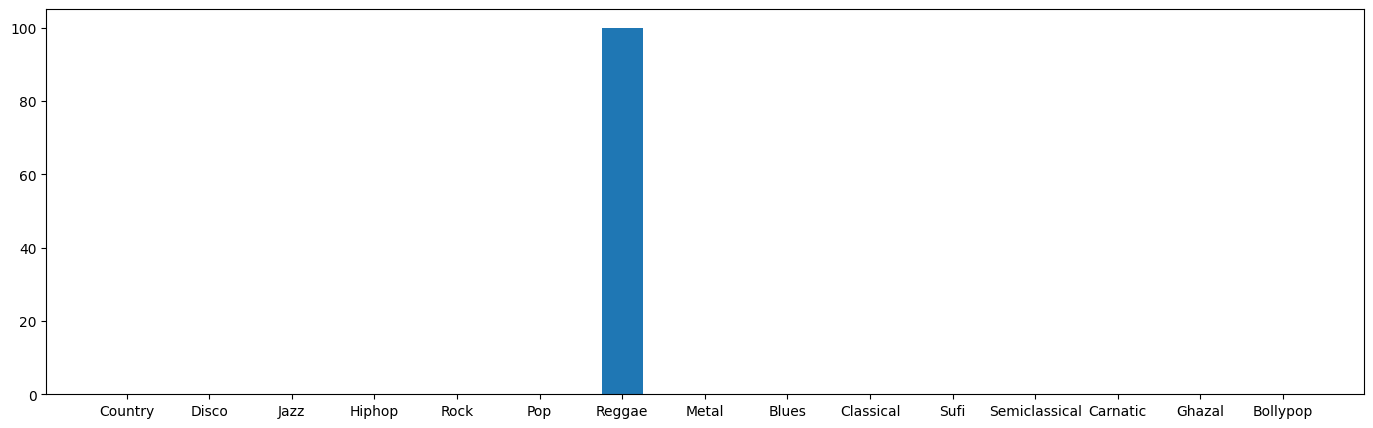

[24.87297834  0.          0.         36.8660978   0.          0.
 38.26092386  0.          0.          0.          0.          0.
  0.          0.          0.        ]


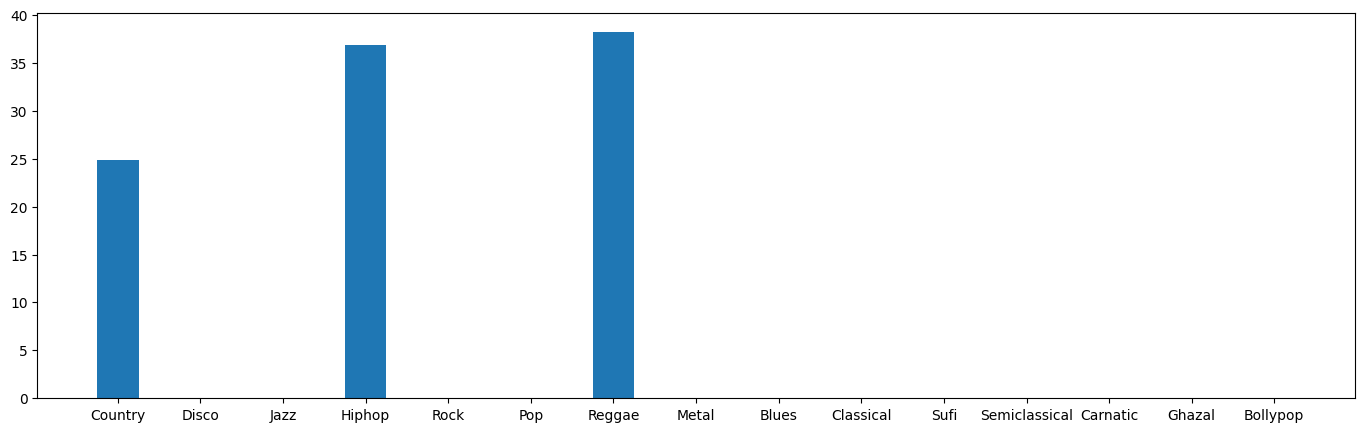

[ 0.         61.25188147  0.          0.          0.         19.67219639
 19.07592214  0.          0.          0.          0.          0.
  0.          0.          0.        ]


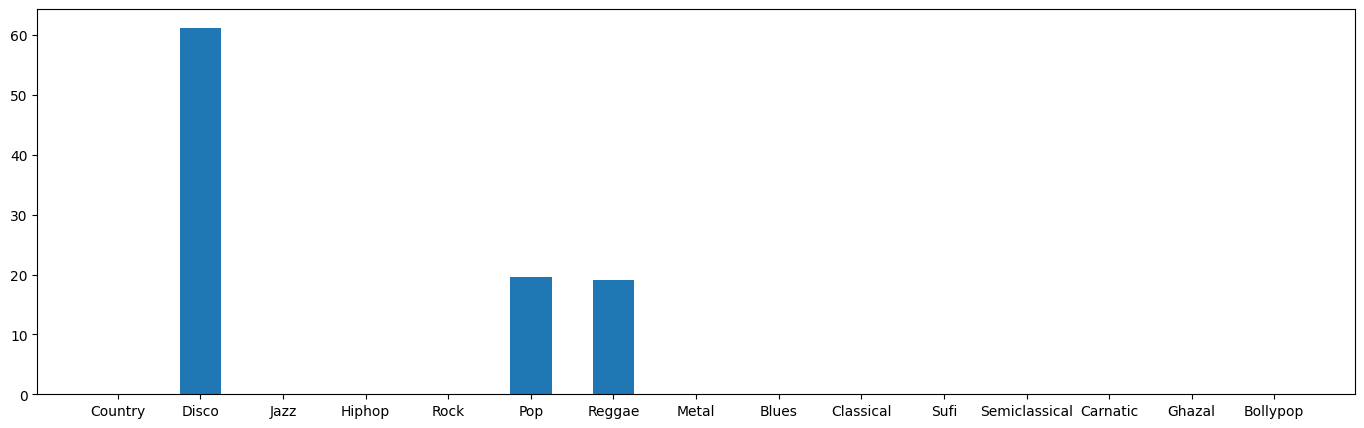

[  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
   0.]


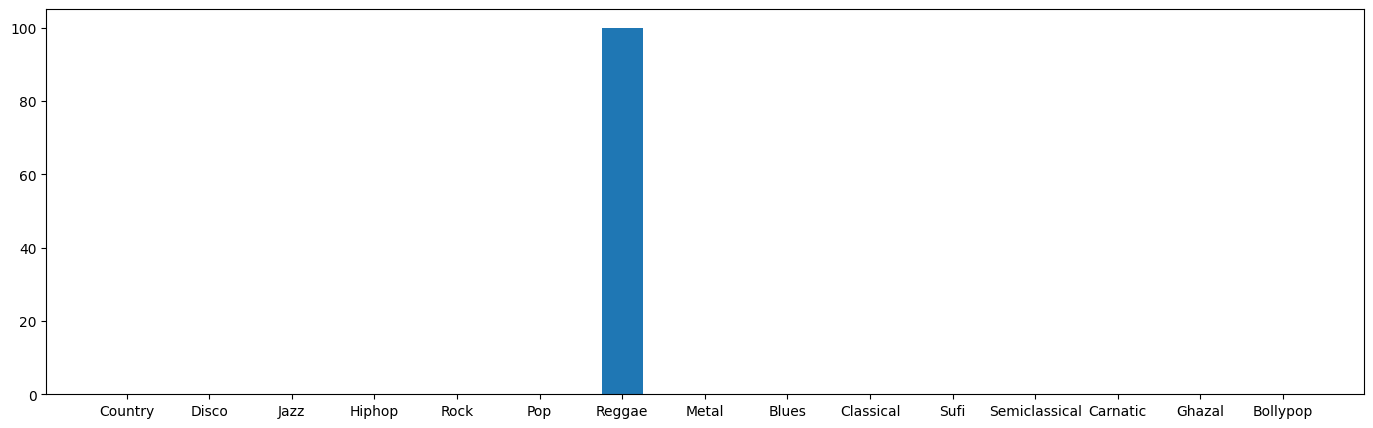

[ 0.          0.          0.         15.91559699  0.          0.
 84.08440301  0.          0.          0.          0.          0.
  0.          0.          0.        ]


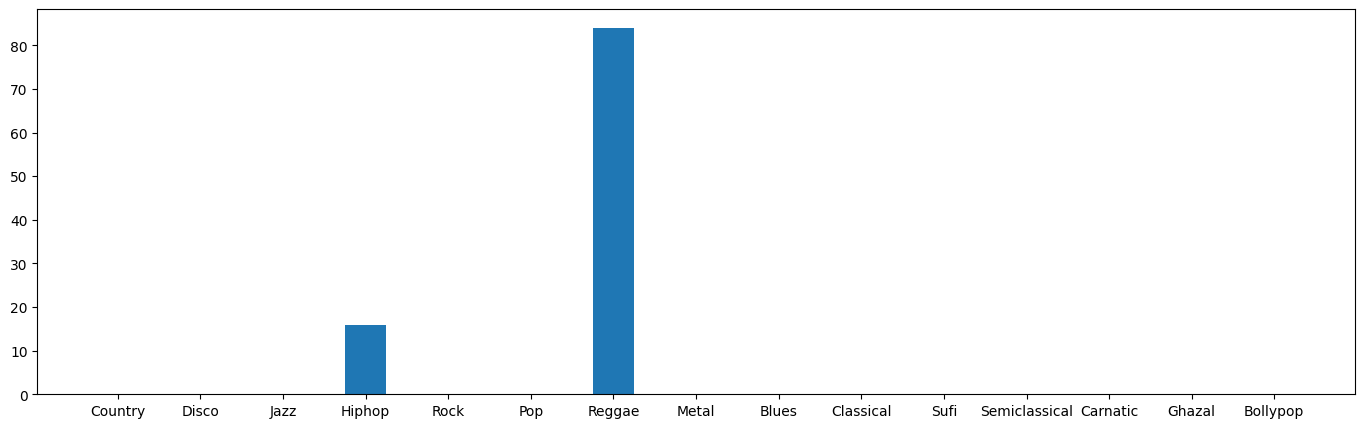

[ 0.          0.          0.         59.24460775  0.          0.
 40.75539225  0.          0.          0.          0.          0.
  0.          0.          0.        ]


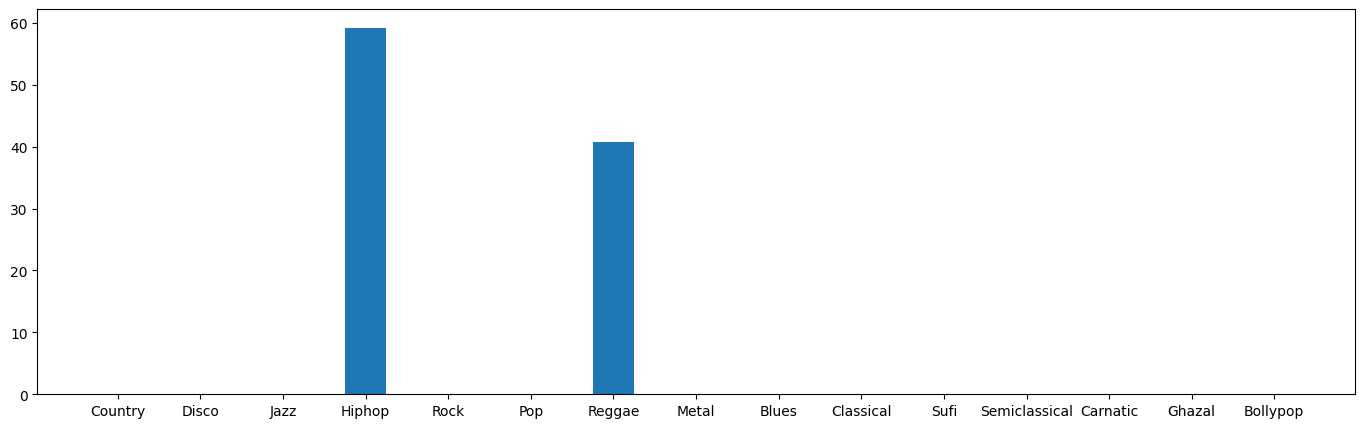

[ 0.          0.          0.         18.50805823  0.         18.77709961
 62.71484216  0.          0.          0.          0.          0.
  0.          0.          0.        ]


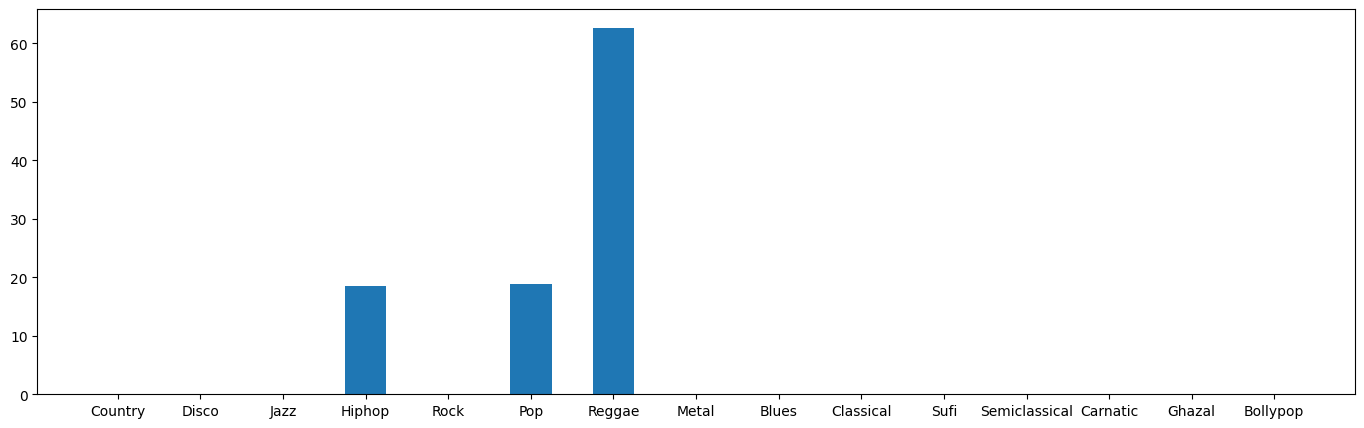

[ 0.          0.          0.         43.11847101  0.          0.
 56.88152899  0.          0.          0.          0.          0.
  0.          0.          0.        ]


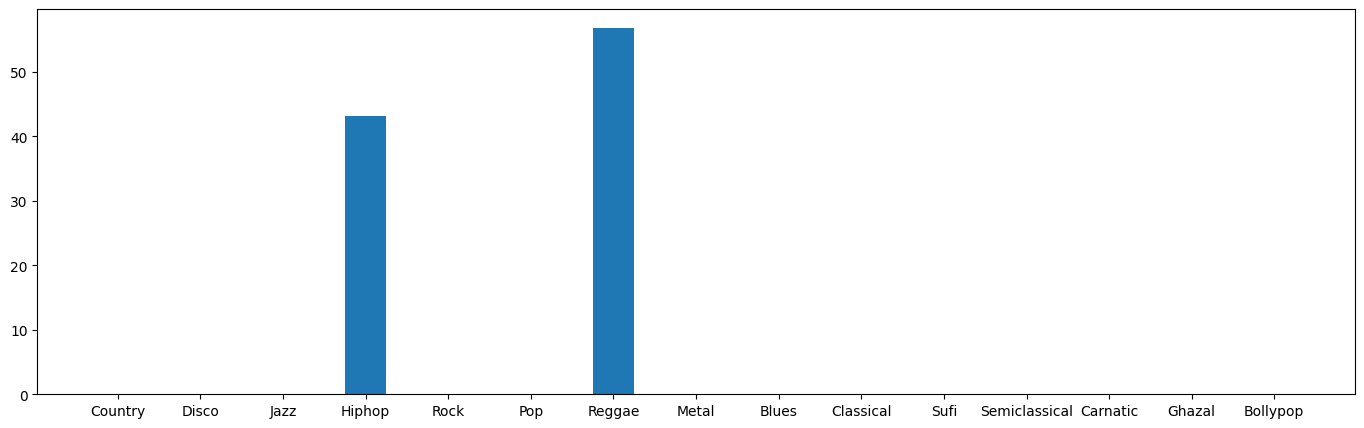

[41.28928839  0.          0.          0.          0.          0.
 58.71071161  0.          0.          0.          0.          0.
  0.          0.          0.        ]


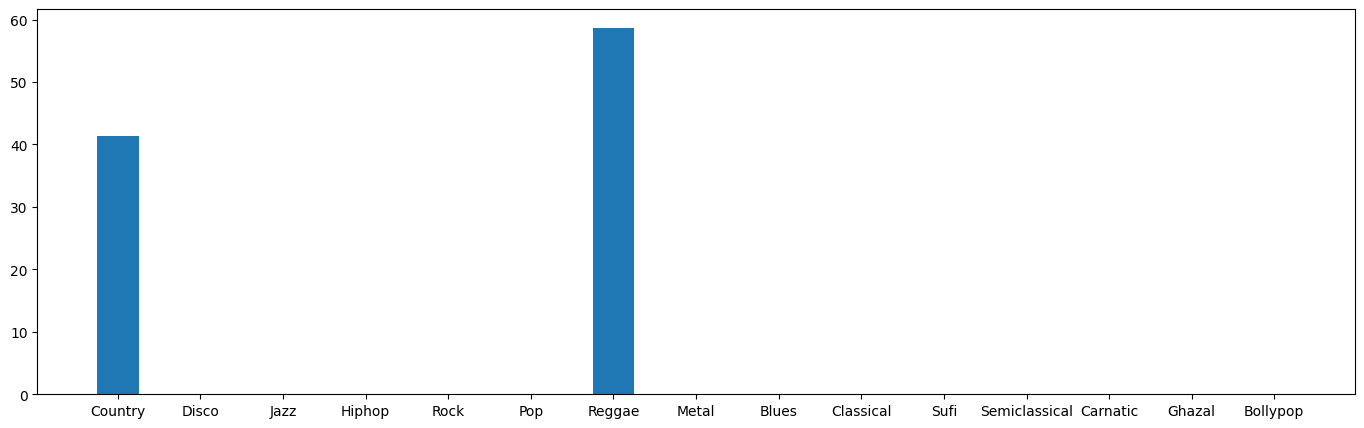

[ 0.          0.          0.         35.23982837  0.          0.
 64.76017163  0.          0.          0.          0.          0.
  0.          0.          0.        ]


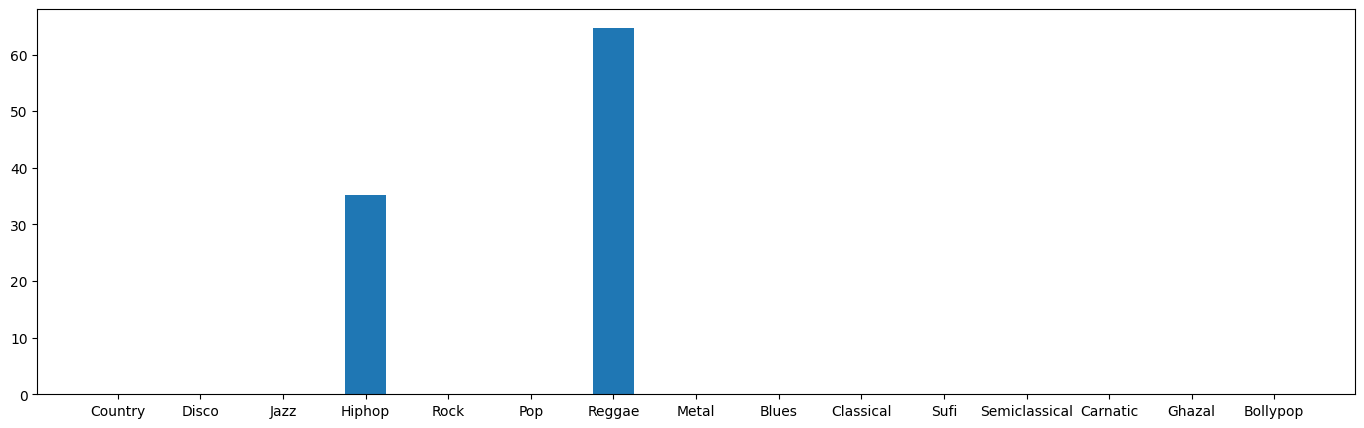

[ 0.          0.          0.         19.39195454 10.16308254  0.
 70.44496293  0.          0.          0.          0.          0.
  0.          0.          0.        ]


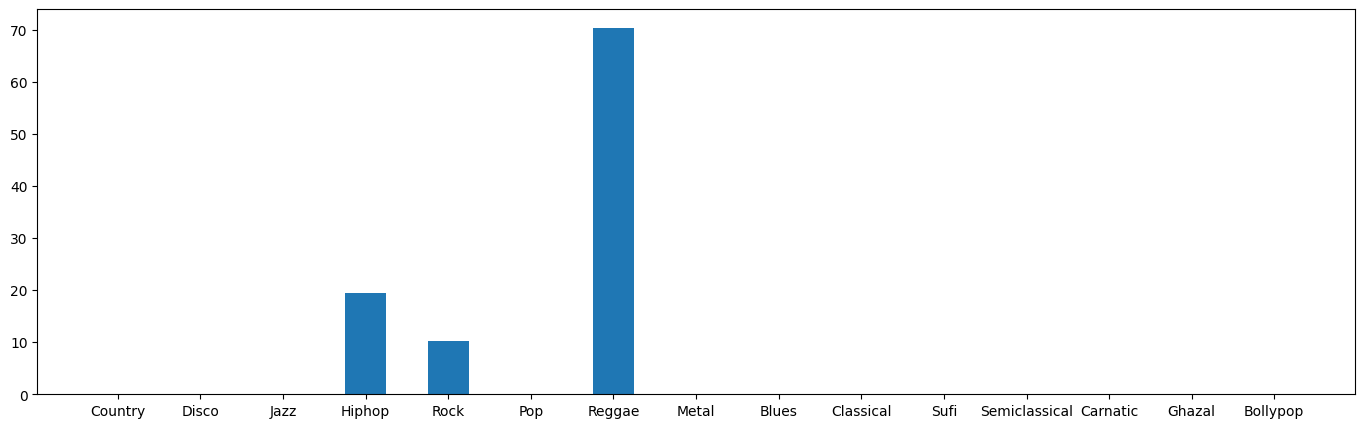

[ 0.         16.98296759  0.          0.         15.88789958  0.
  0.         67.12913282  0.          0.          0.          0.
  0.          0.          0.        ]


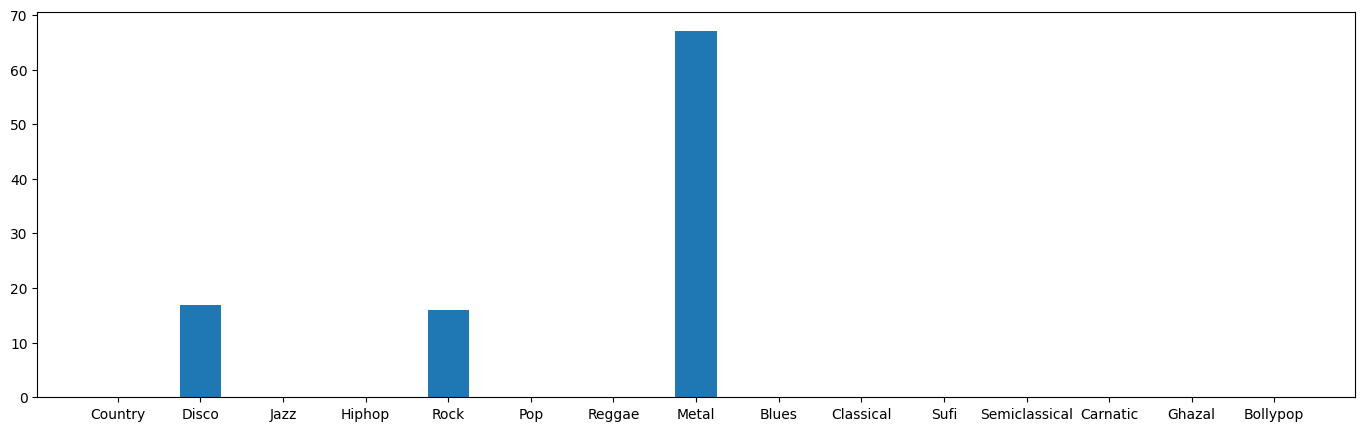

[10.80878918  0.          0.         10.20895345  0.          0.
  0.         78.98225737  0.          0.          0.          0.
  0.          0.          0.        ]


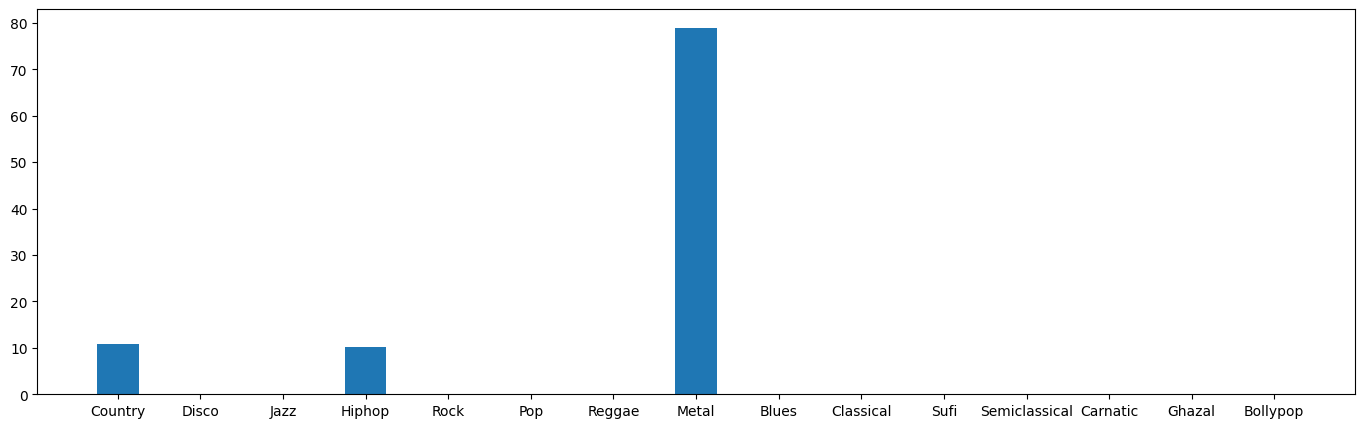

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


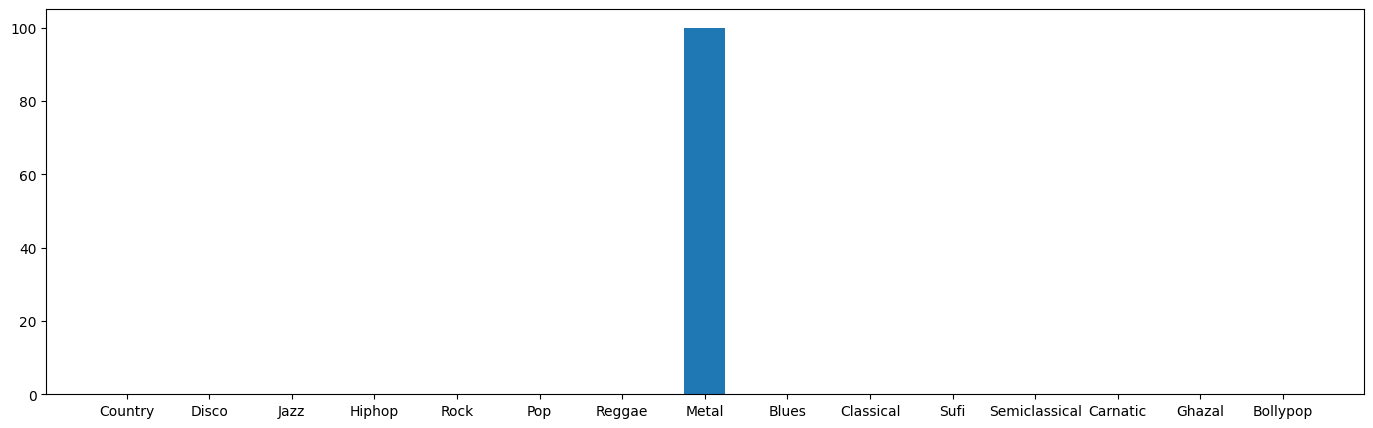

[ 0.          0.          0.         15.39303523  0.          0.
  0.         84.60696477  0.          0.          0.          0.
  0.          0.          0.        ]


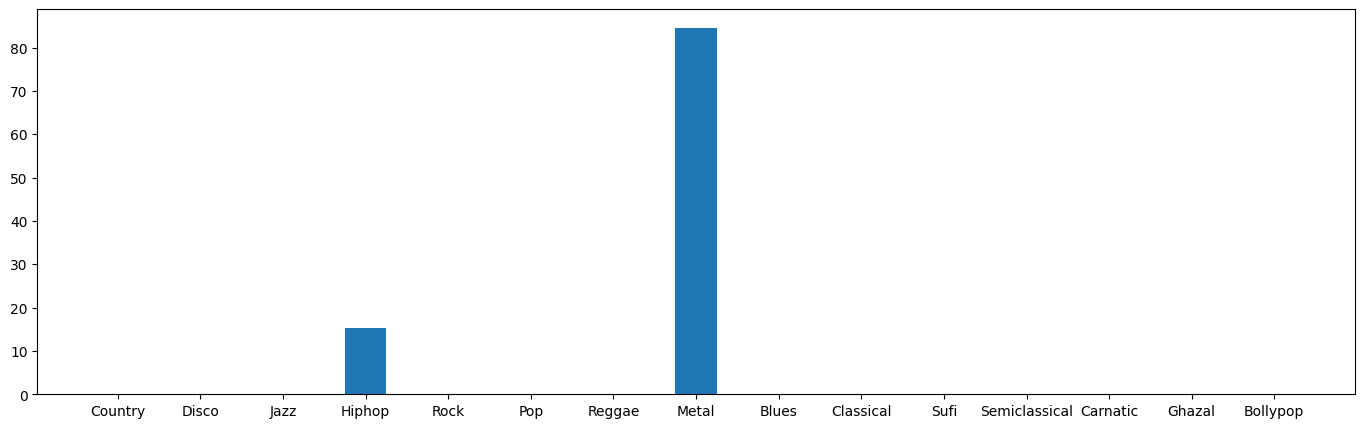

[ 0.          0.          0.         20.02958088  0.          0.
  0.         37.77712244 42.19329668  0.          0.          0.
  0.          0.          0.        ]


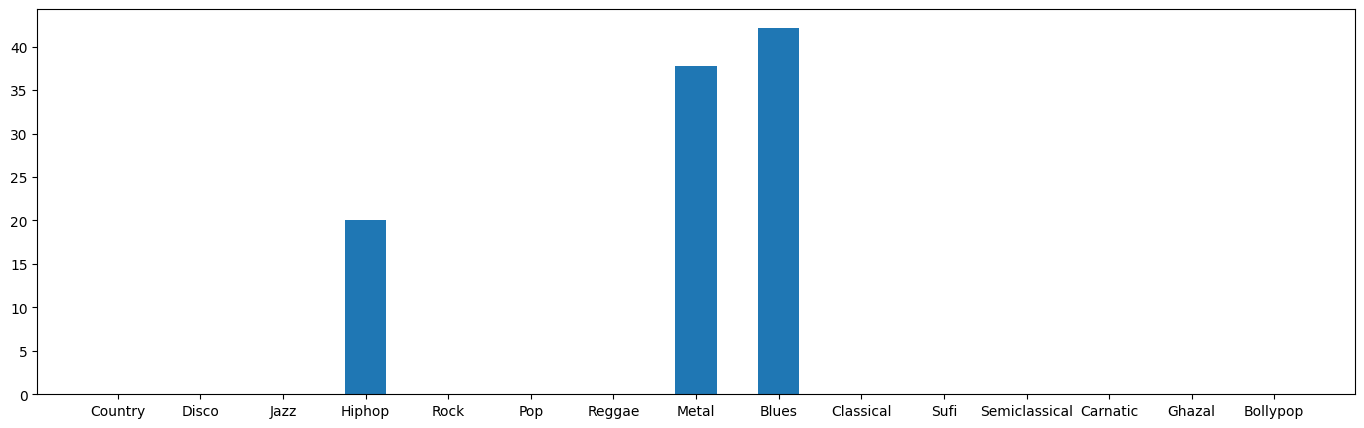

[ 0.          0.          0.          0.         21.68614441  0.
  0.         78.31385559  0.          0.          0.          0.
  0.          0.          0.        ]


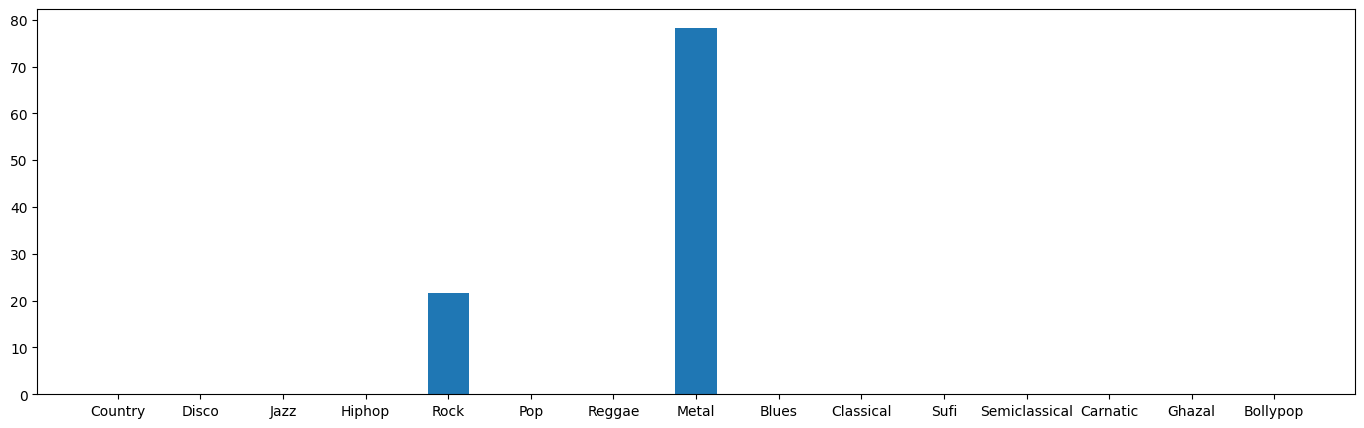

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


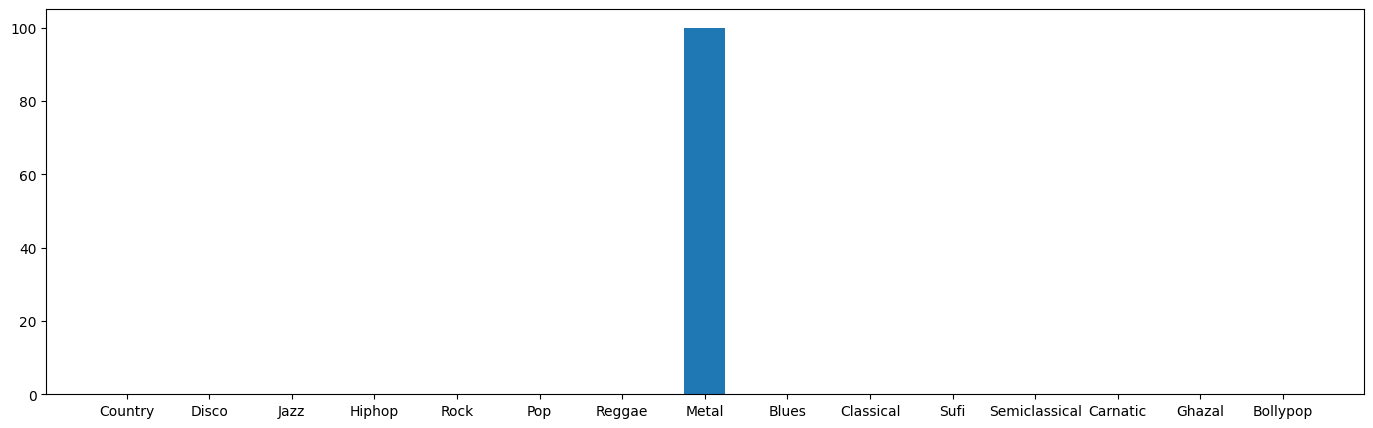

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


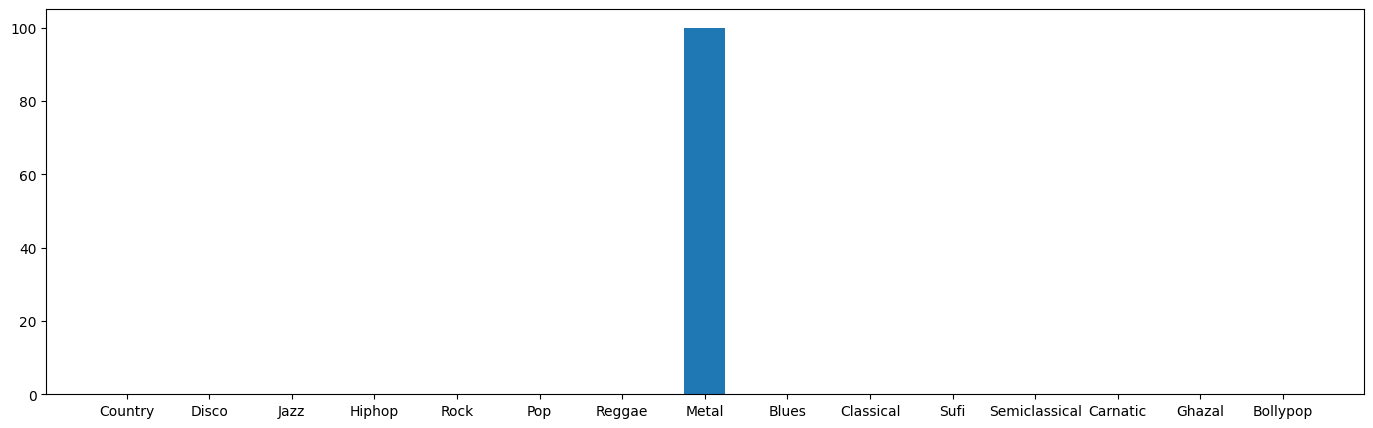

[ 0.          8.29115837  0.          0.          9.80129773  0.
  0.         62.8021782  19.10536569  0.          0.          0.
  0.          0.          0.        ]


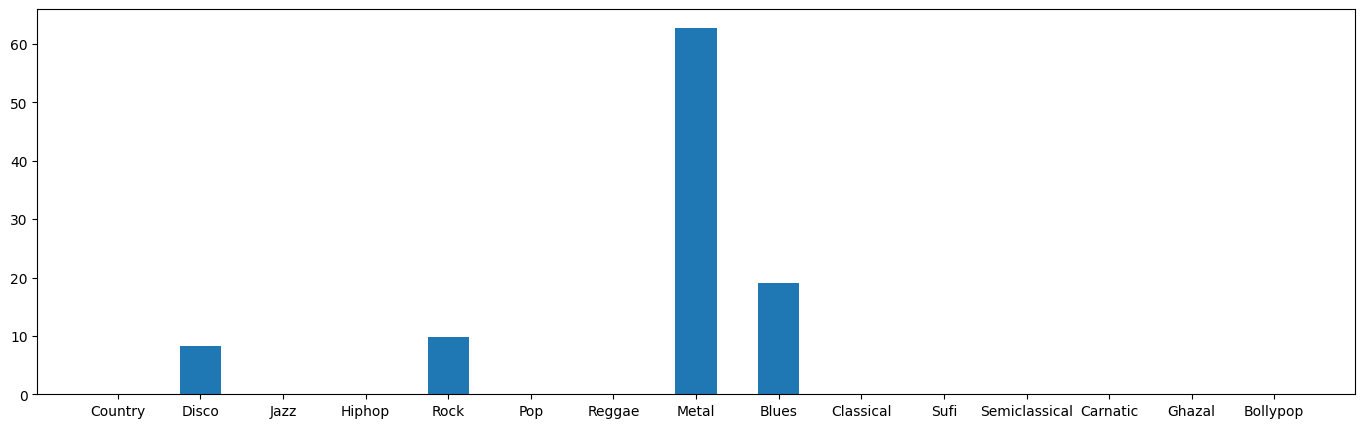

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


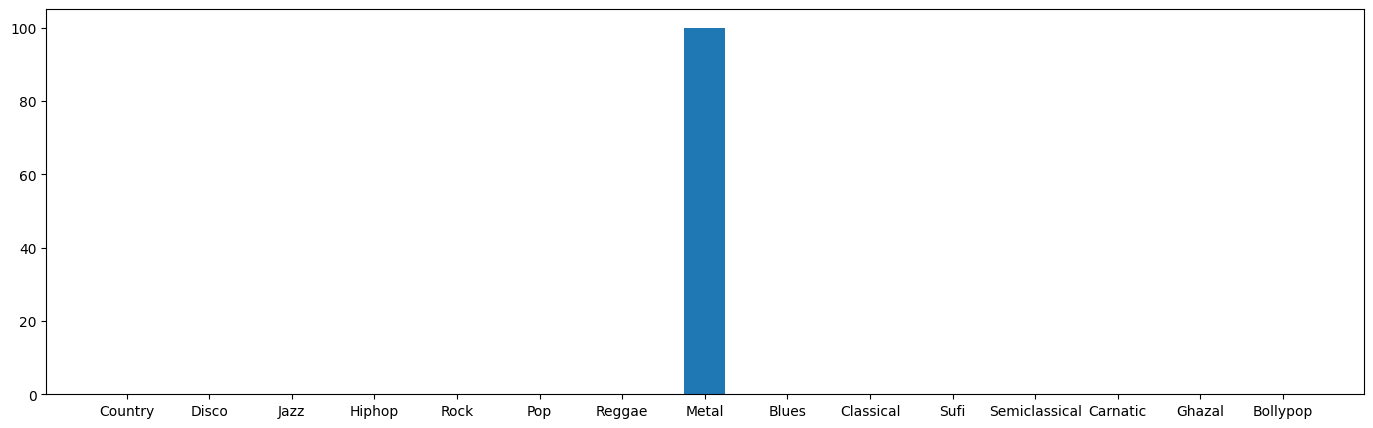

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


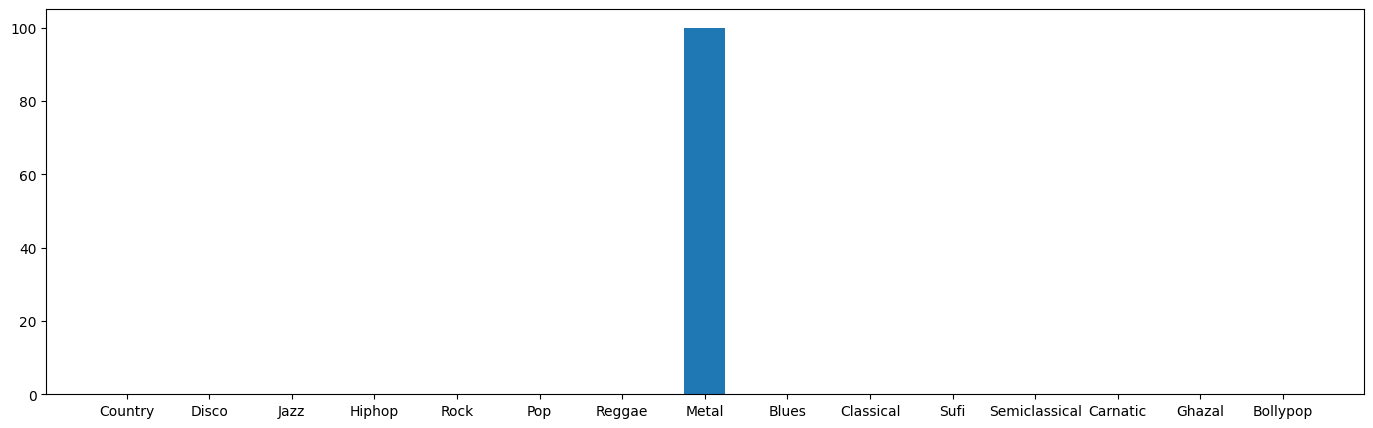

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


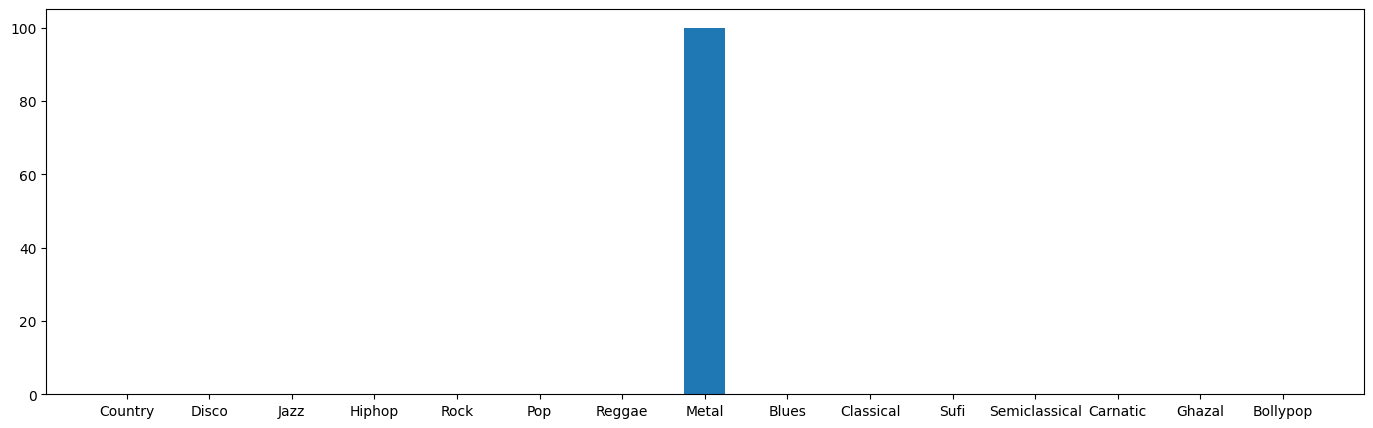

[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.
   0.]


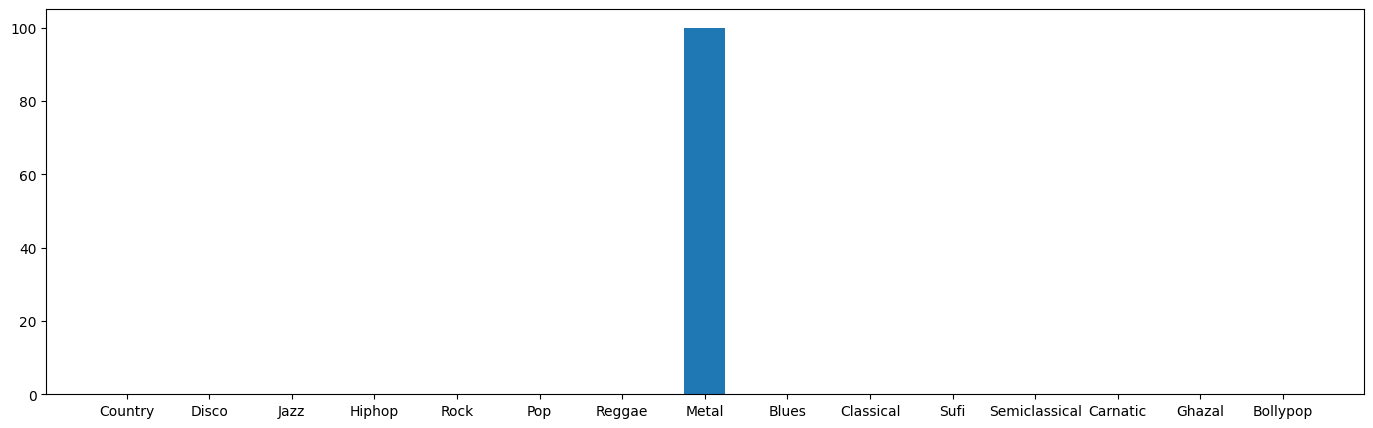

[ 0.          0.          0.          0.          9.75465002  0.
  0.         90.24534998  0.          0.          0.          0.
  0.          0.          0.        ]


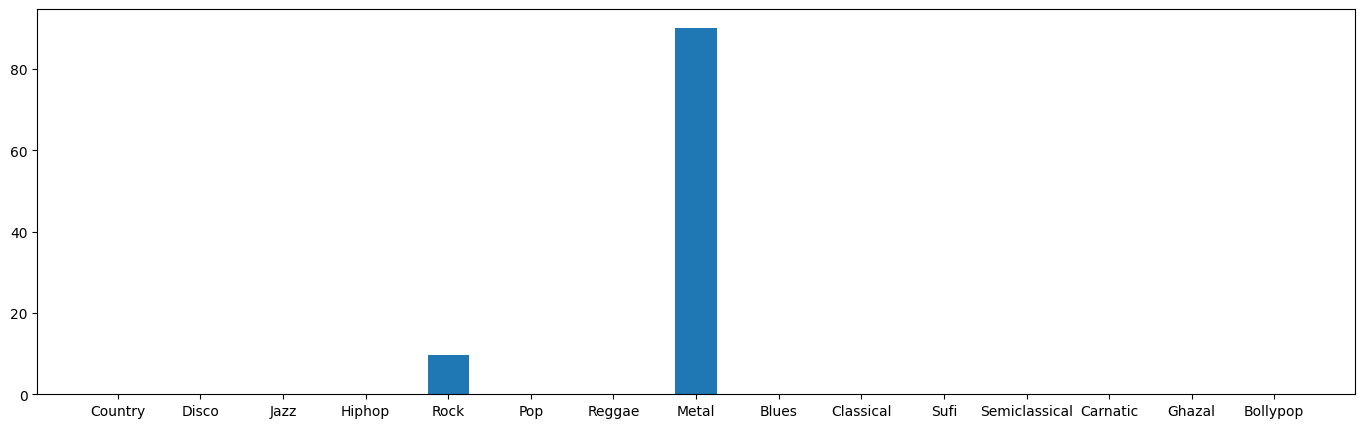

[ 0.          0.          0.          0.         44.34278919  0.
  0.         55.65721081  0.          0.          0.          0.
  0.          0.          0.        ]


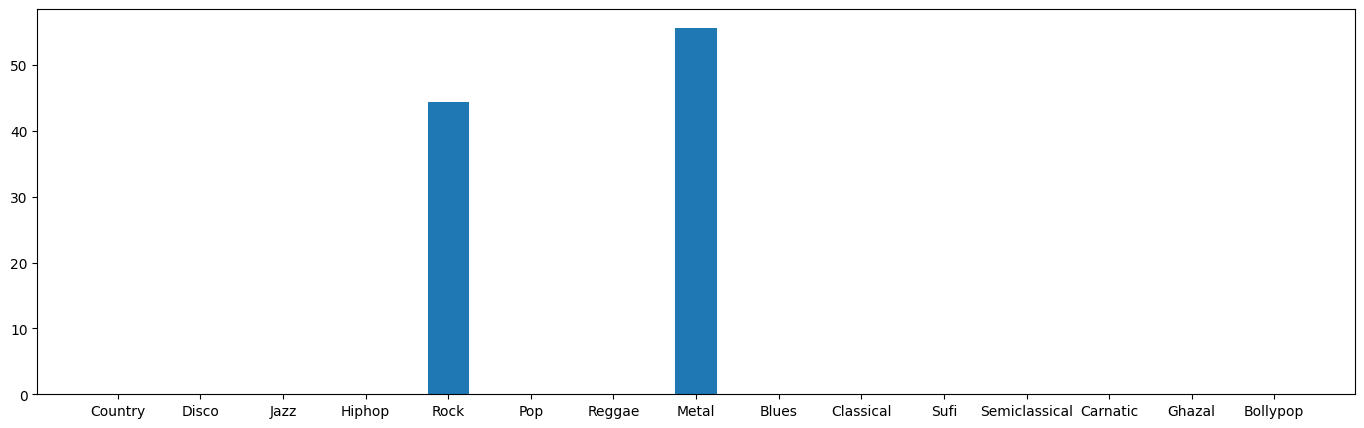

[ 0.         13.48838453  0.          0.         42.27643306  0.
  0.         44.23518241  0.          0.          0.          0.
  0.          0.          0.        ]


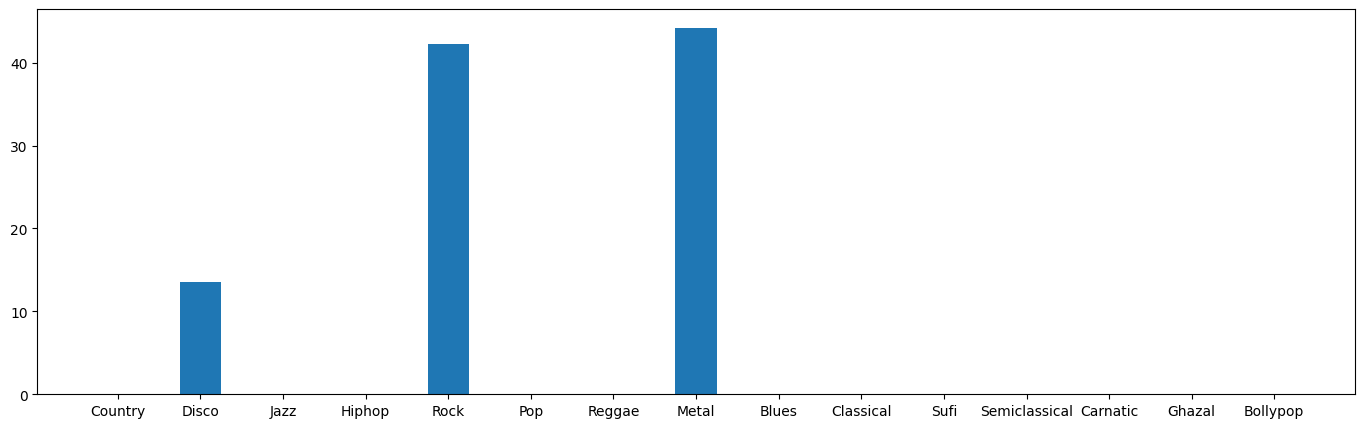

[ 0.         14.2489665   0.         20.94746985  0.          0.
  0.         64.80356365  0.          0.          0.          0.
  0.          0.          0.        ]


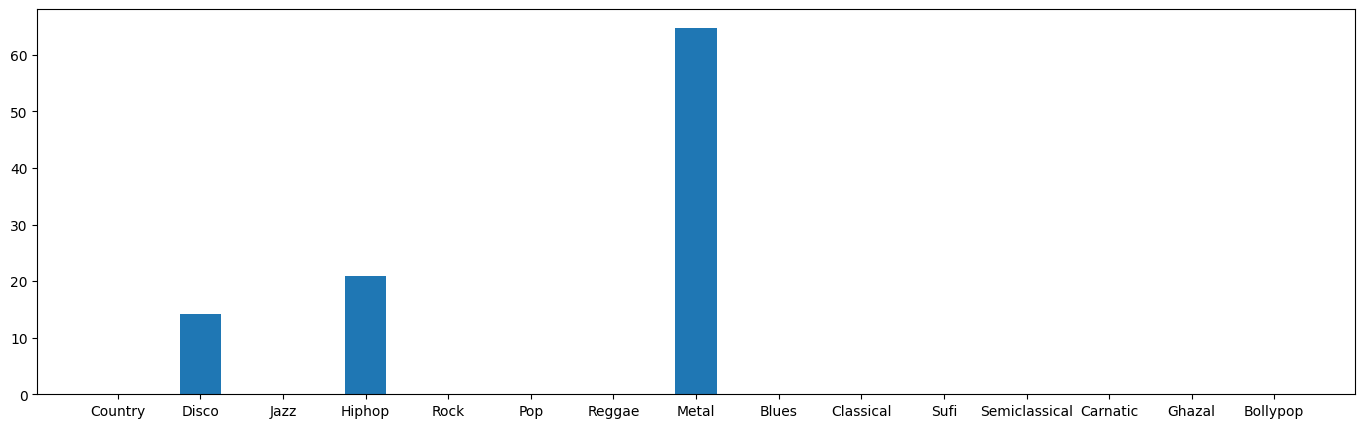

[19.18378651 19.59392021  0.          0.         19.62839816  0.
  0.         41.59389513  0.          0.          0.          0.
  0.          0.          0.        ]


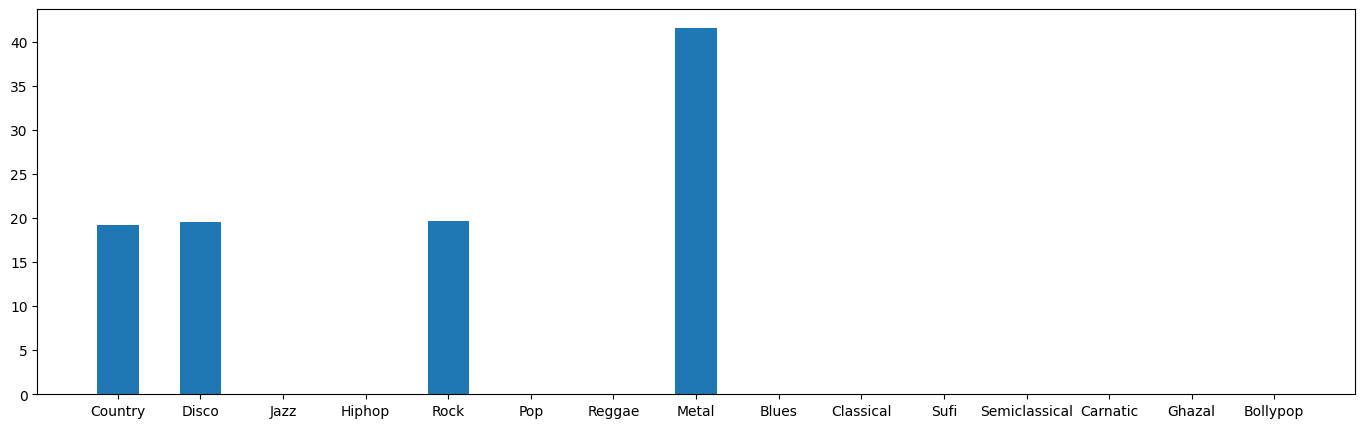

[ 0.          0.          0.         36.80792316  0.          0.
 16.84596429 46.34611255  0.          0.          0.          0.
  0.          0.          0.        ]


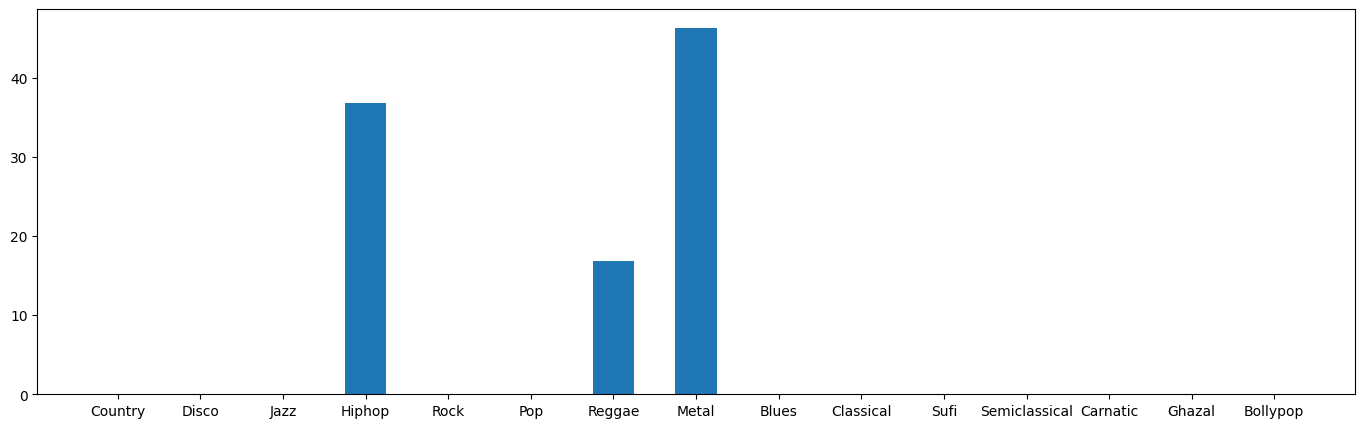

[ 0.          0.          0.         29.11062358  0.          0.
  0.         54.37053832 16.5188381   0.          0.          0.
  0.          0.          0.        ]


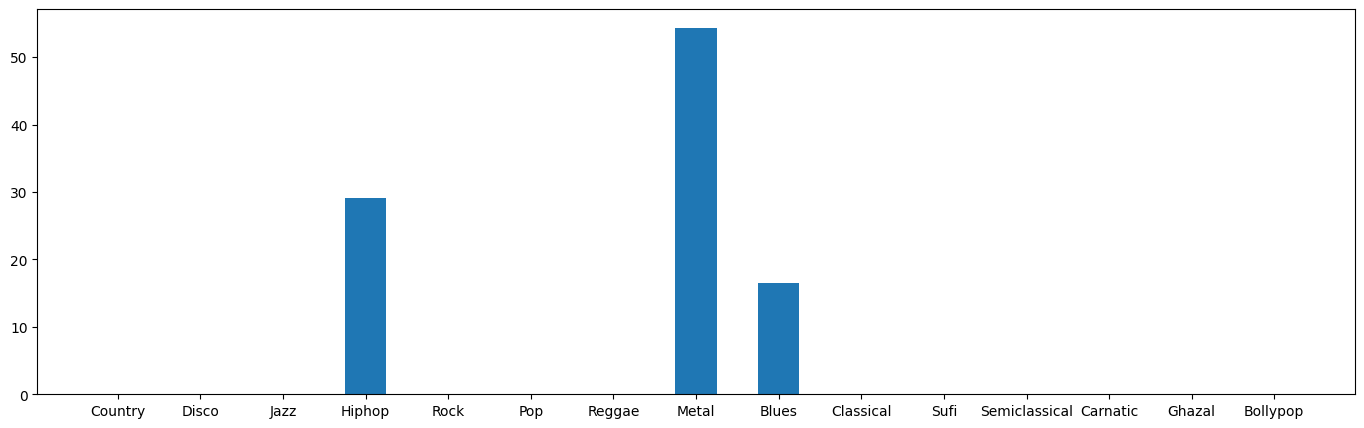

[23.12940394 20.10483585  0.          0.         56.76576021  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


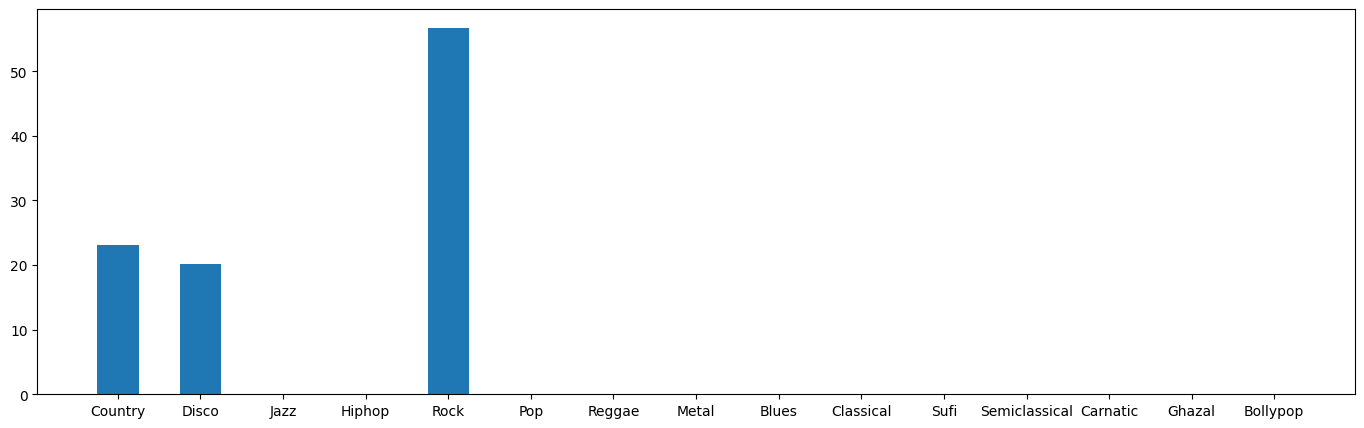

[ 0.          0.          0.          0.          0.          0.
 17.25623903  0.         63.26296917  0.          0.          0.
  0.          0.         19.4807918 ]


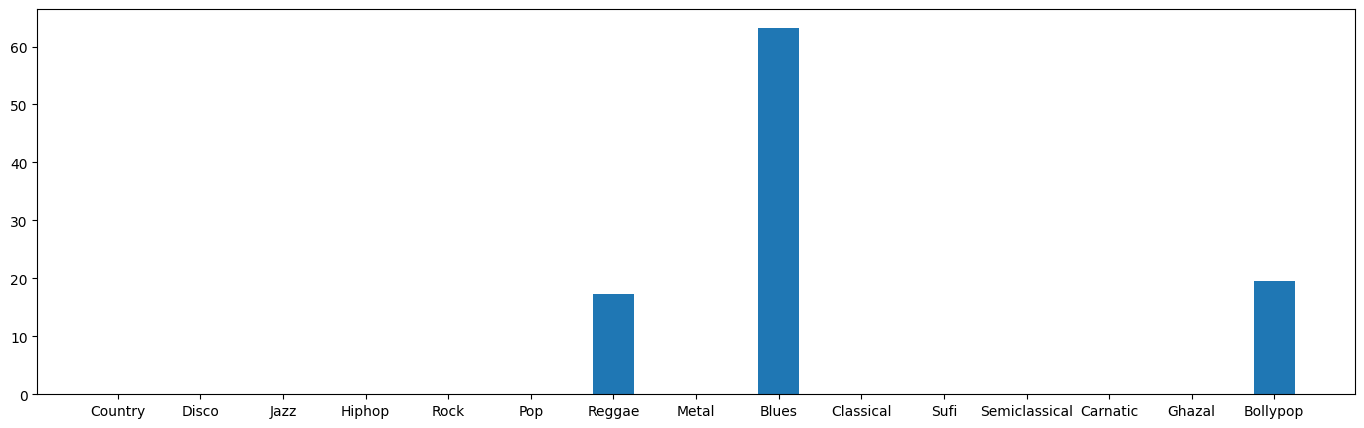

[ 0.          0.          0.          0.         18.23931106  0.
 16.95697861  0.         64.80371033  0.          0.          0.
  0.          0.          0.        ]


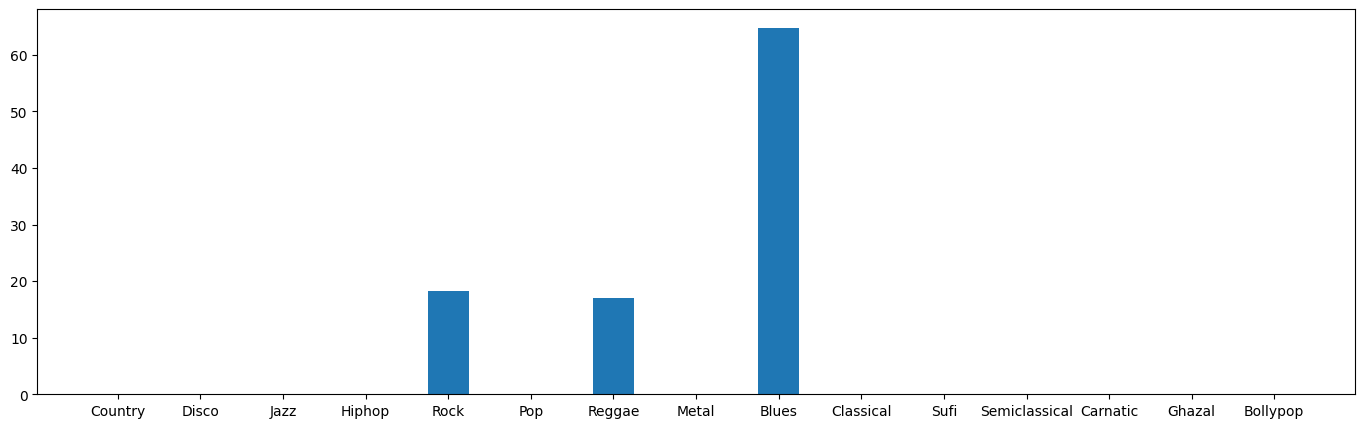

[  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
   0.]


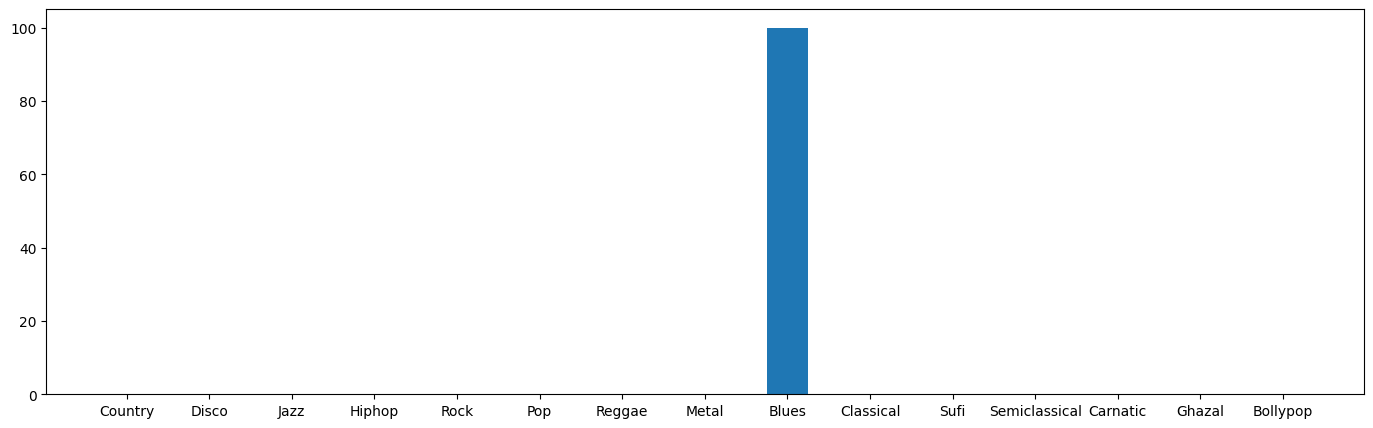

[ 0.          0.         11.18162258 14.01893282  0.          0.
 13.63825582  0.         61.16118878  0.          0.          0.
  0.          0.          0.        ]


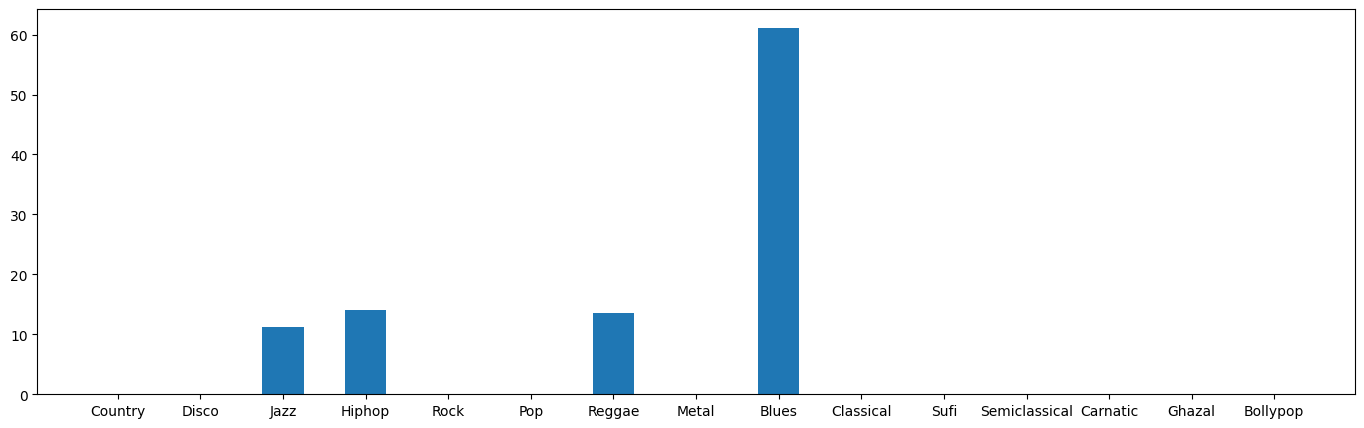

[  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
   0.]


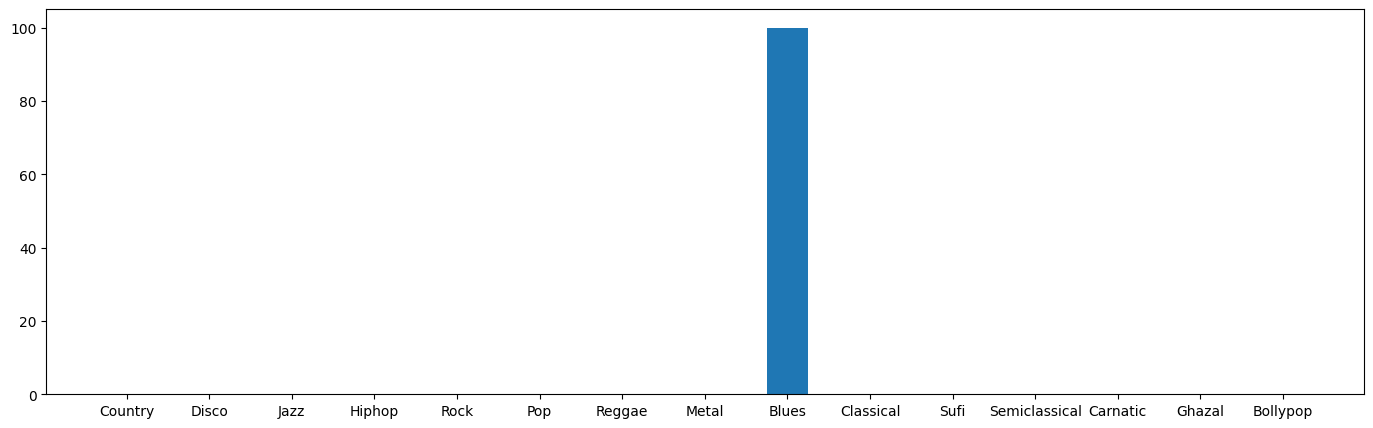

[  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
   0.]


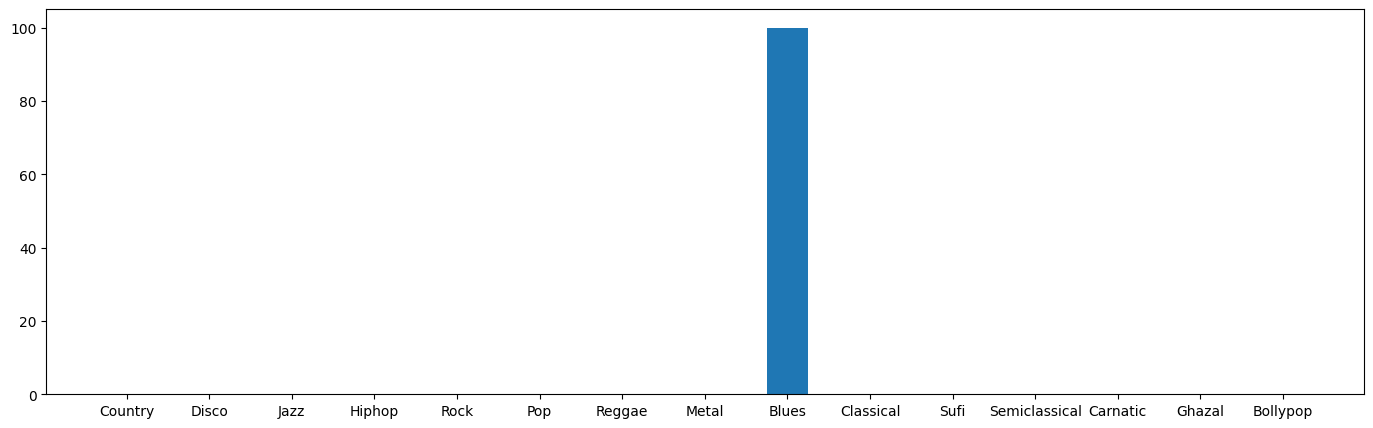

[  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
   0.]


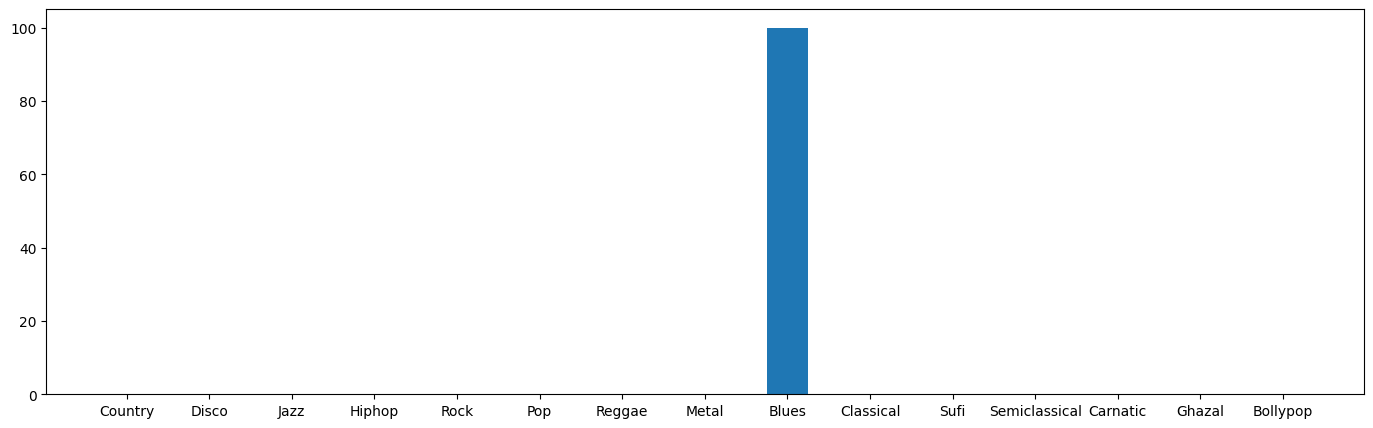

[ 0.          0.          0.          0.          0.          0.
 15.28469641  0.         84.71530359  0.          0.          0.
  0.          0.          0.        ]


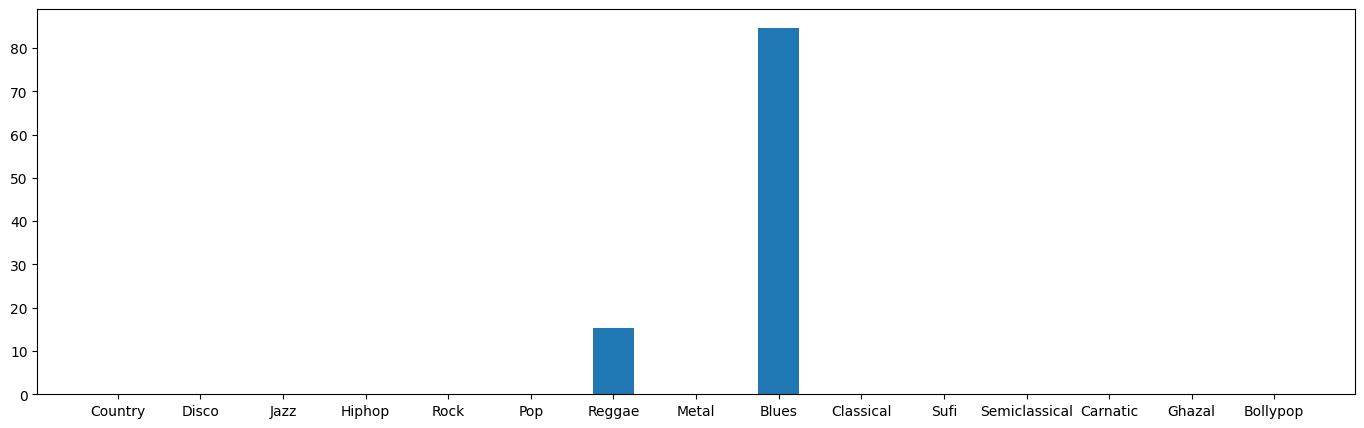

[ 0.          0.         12.97554585  0.          0.          0.
  0.          0.         63.38901992  0.          0.          0.
  0.         23.63543422  0.        ]


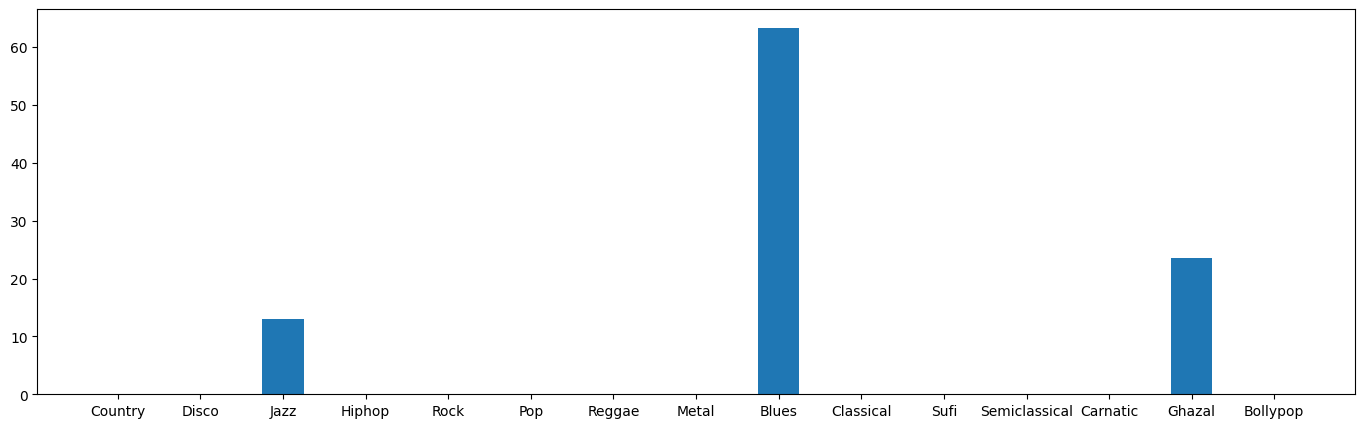

[17.38502914 33.71233108  0.          0.          0.          0.
  0.          0.         48.90263978  0.          0.          0.
  0.          0.          0.        ]


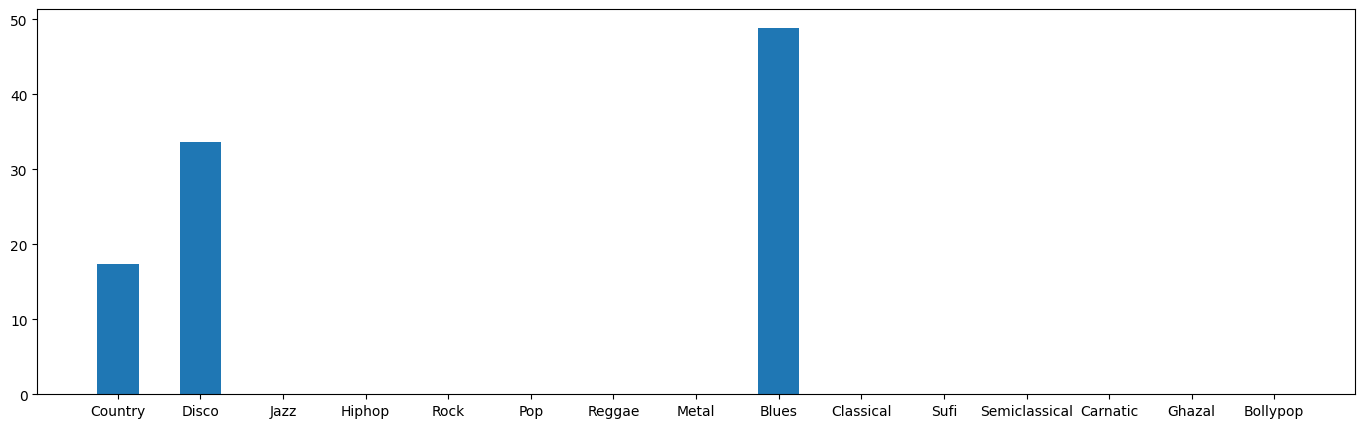

[19.86670062  0.          0.         17.27526389  0.          0.
  0.         20.53639197 42.32164352  0.          0.          0.
  0.          0.          0.        ]


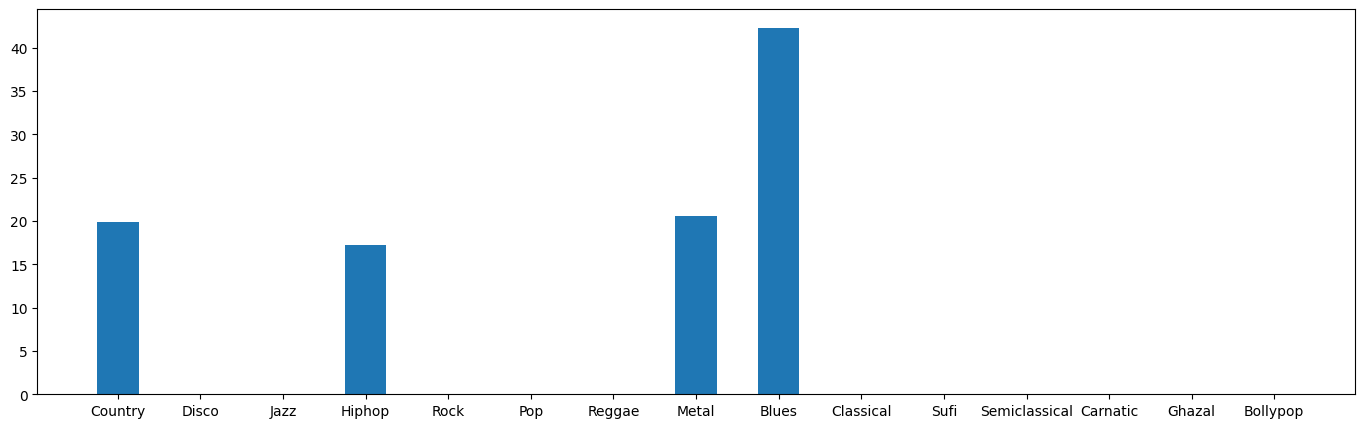

[11.16137308  0.          0.          0.          0.          0.
  0.          0.         88.83862692  0.          0.          0.
  0.          0.          0.        ]


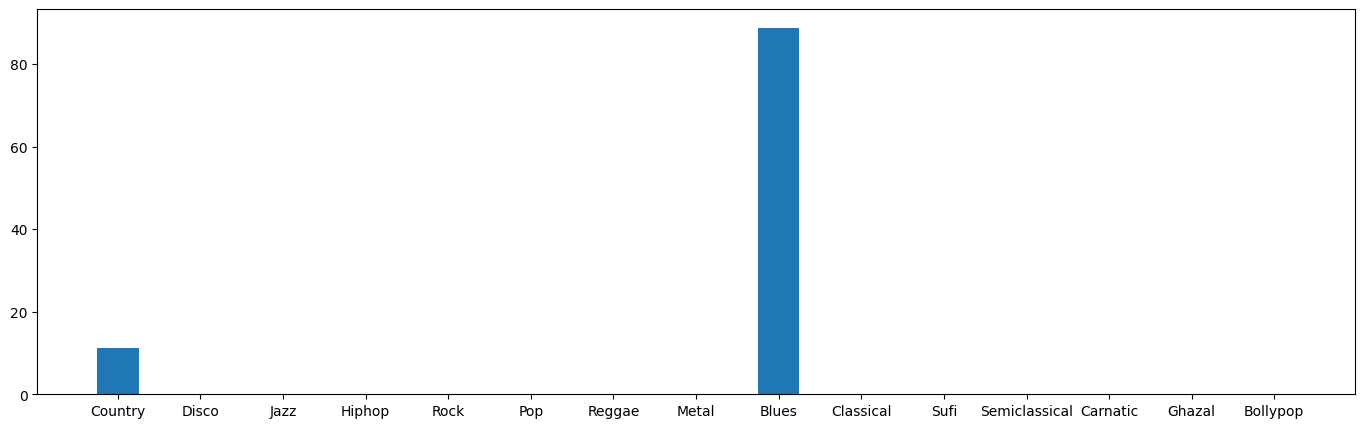

[  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
   0.]


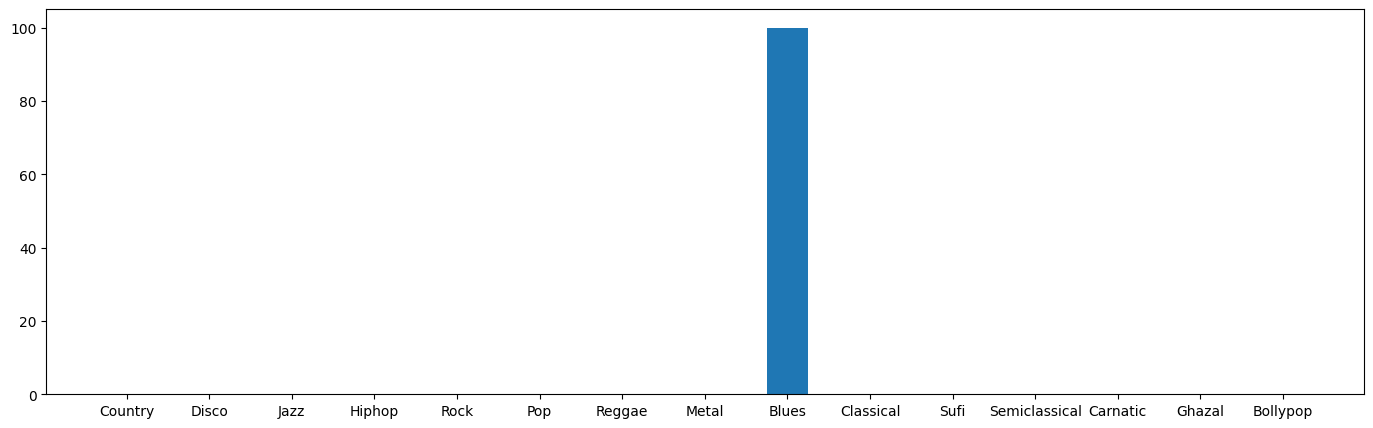

[23.87213361  0.          0.         58.37477268  0.          0.
  0.          0.         17.7530937   0.          0.          0.
  0.          0.          0.        ]


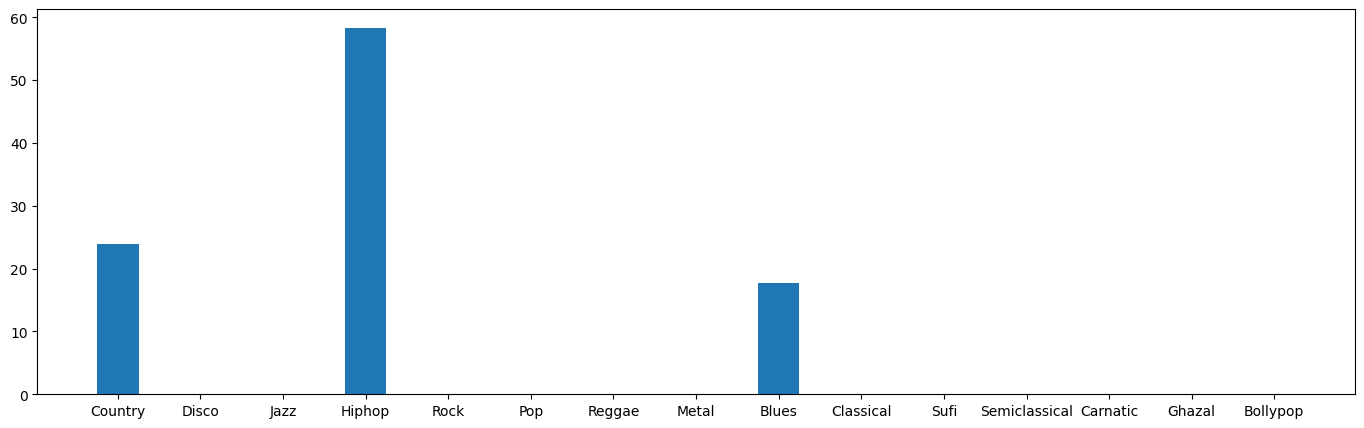

[ 0.          8.24671498  0.          0.          0.          0.
  0.          0.         91.75328502  0.          0.          0.
  0.          0.          0.        ]


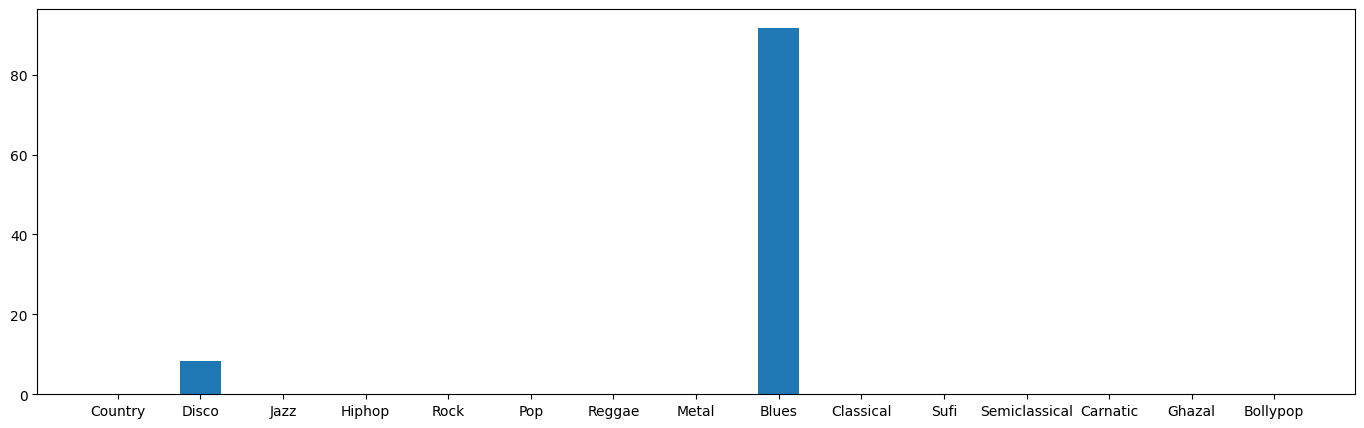

[ 0.         15.0984228   0.          0.         13.70954615  0.
  0.          0.         71.19203105  0.          0.          0.
  0.          0.          0.        ]


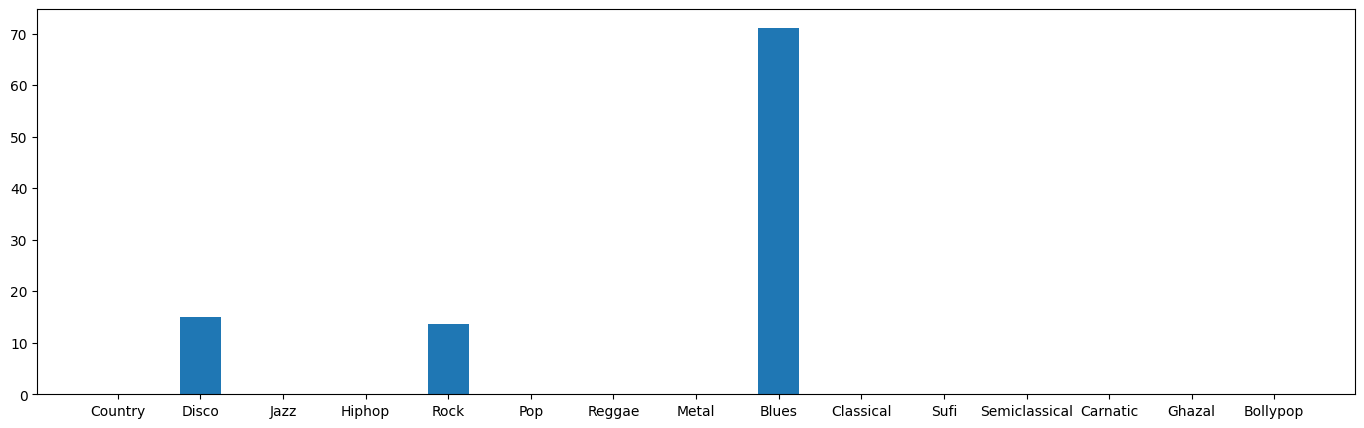

[ 0.         20.08579995  0.         37.61936548  0.          0.
  0.          0.         42.29483457  0.          0.          0.
  0.          0.          0.        ]


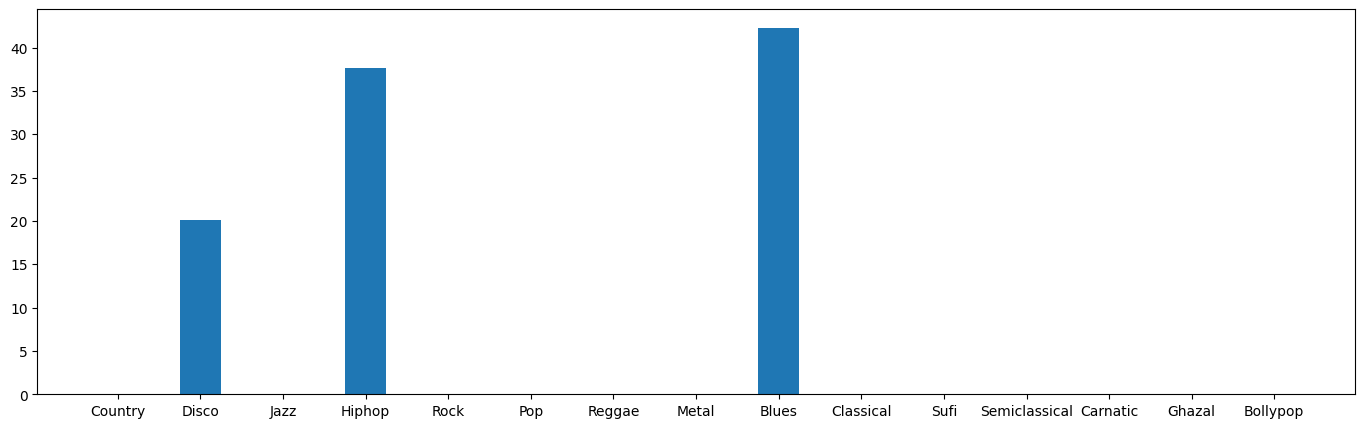

[  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
   0.]


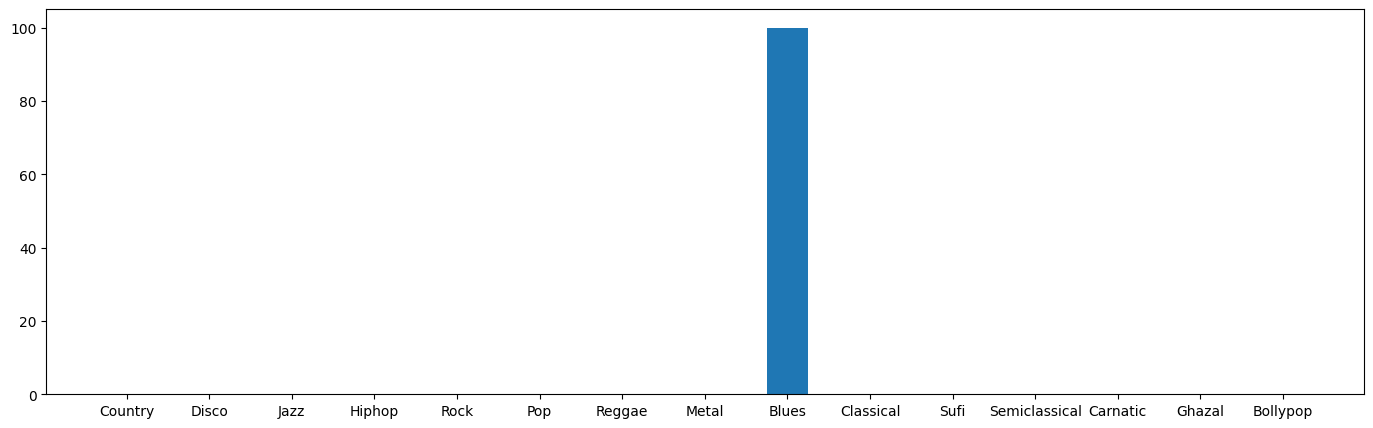

[ 0.         60.84134896  0.          0.         39.15865104  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


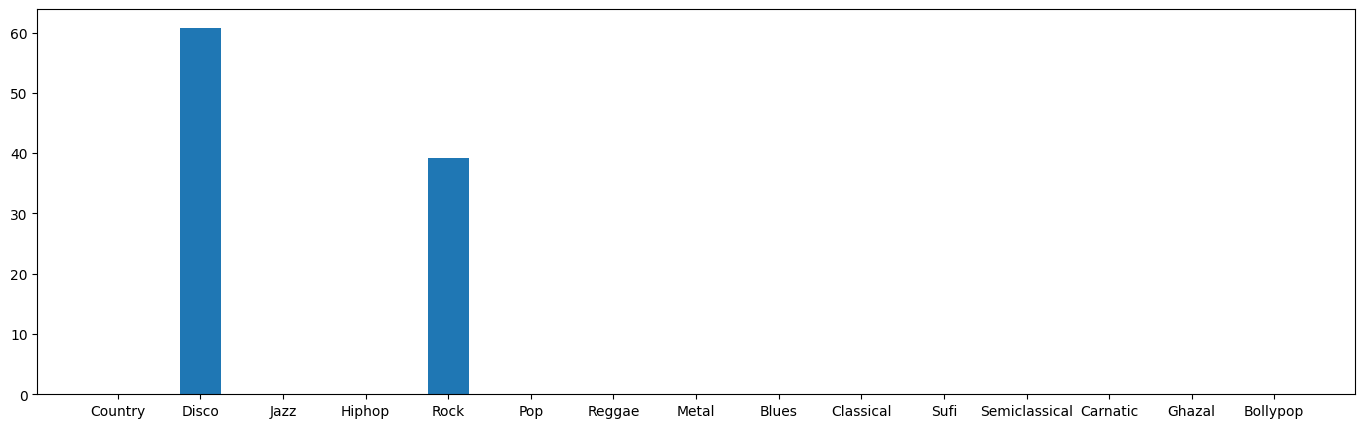

[39.24705857  0.          0.         38.83283342  0.          0.
  0.          0.         21.92010801  0.          0.          0.
  0.          0.          0.        ]


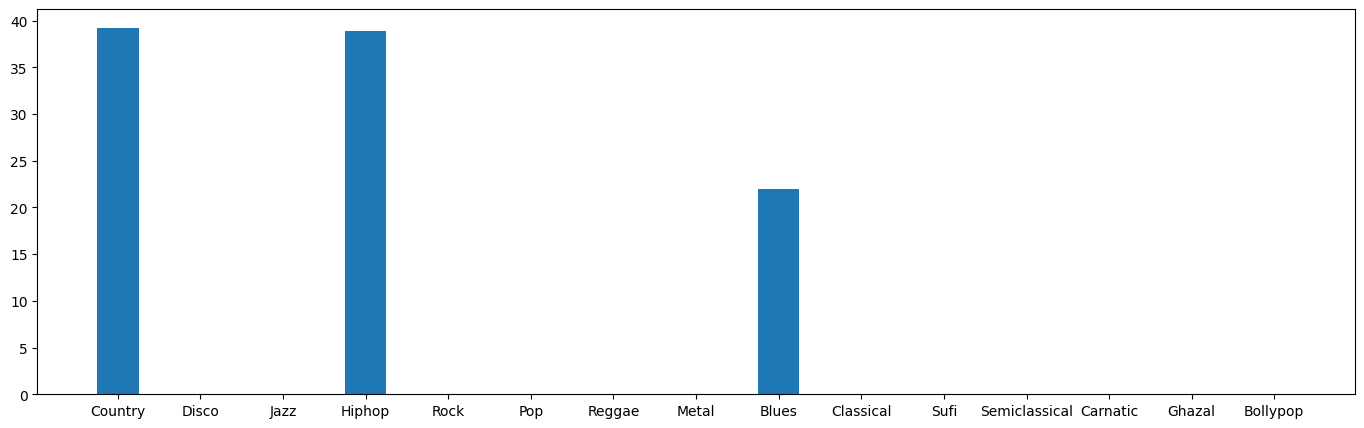

[40.27296805  0.         19.58870551 19.0420207  21.09630574  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


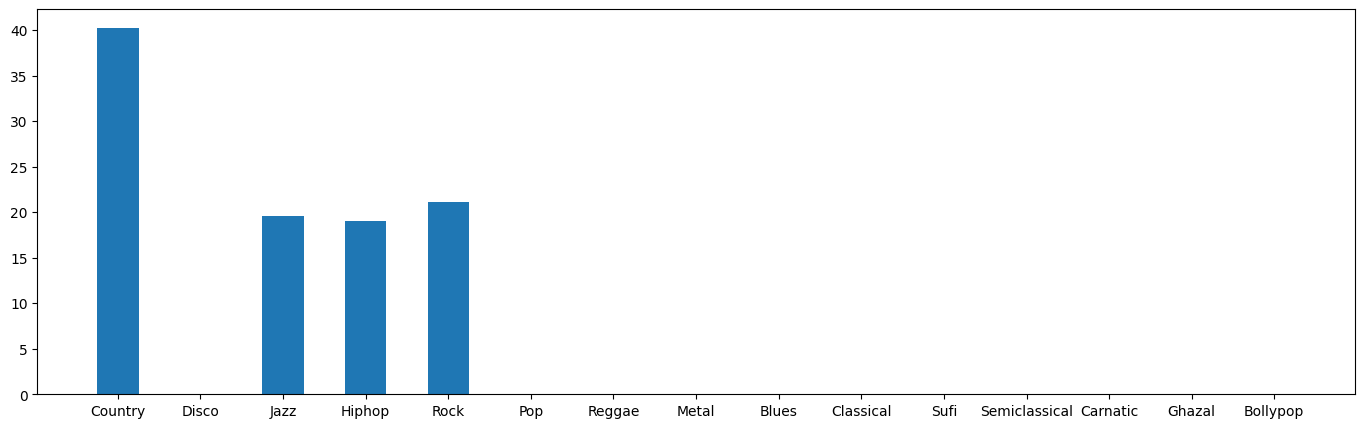

[ 0.          0.          0.          0.         15.03806201  0.
  0.          0.         84.96193799  0.          0.          0.
  0.          0.          0.        ]


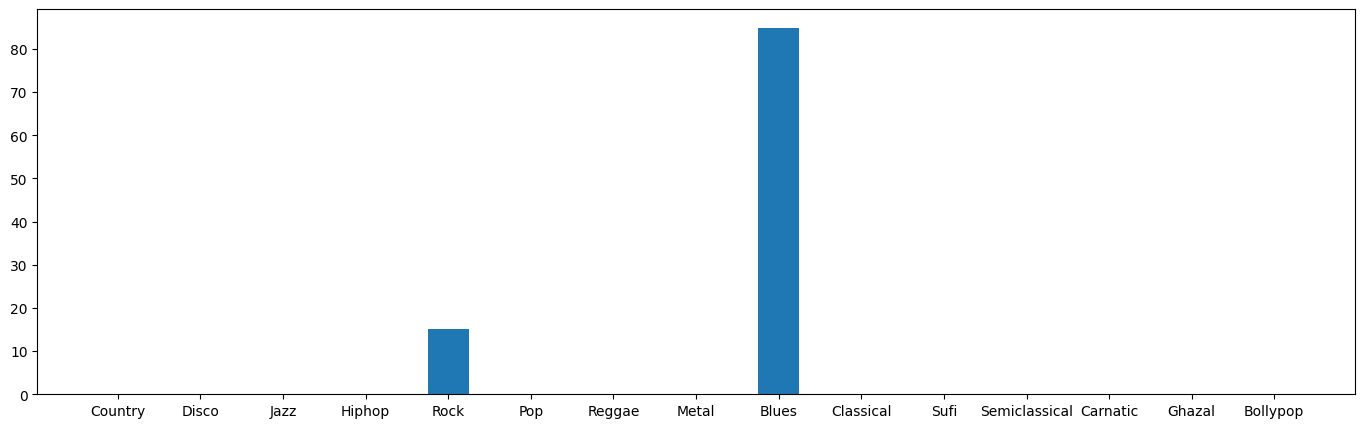

[ 0.          0.          0.         23.93426411  0.          0.
  0.          0.         76.06573589  0.          0.          0.
  0.          0.          0.        ]


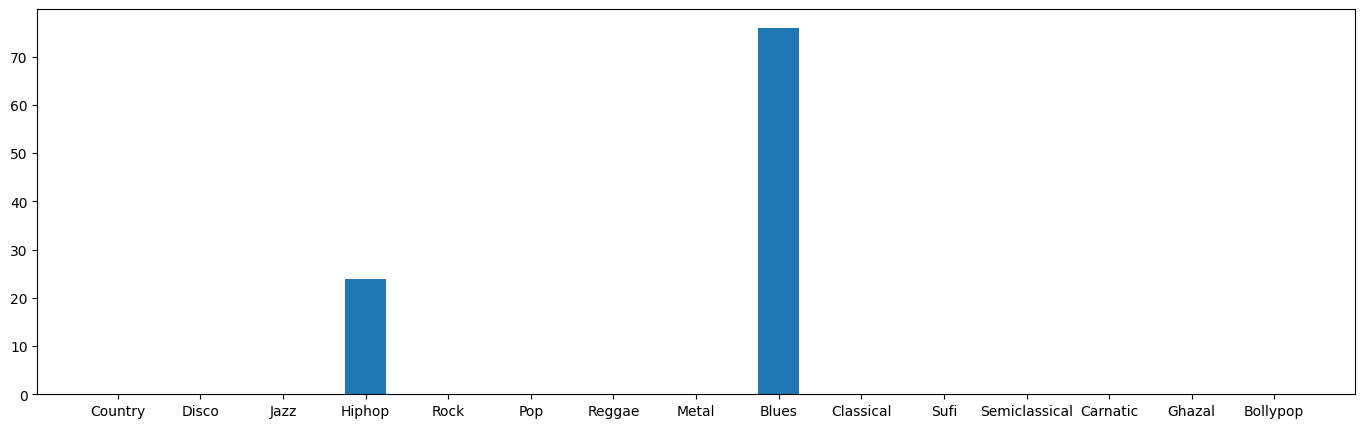

[ 0.         22.32537484  0.         16.098525    0.          0.
  0.          0.         61.57610016  0.          0.          0.
  0.          0.          0.        ]


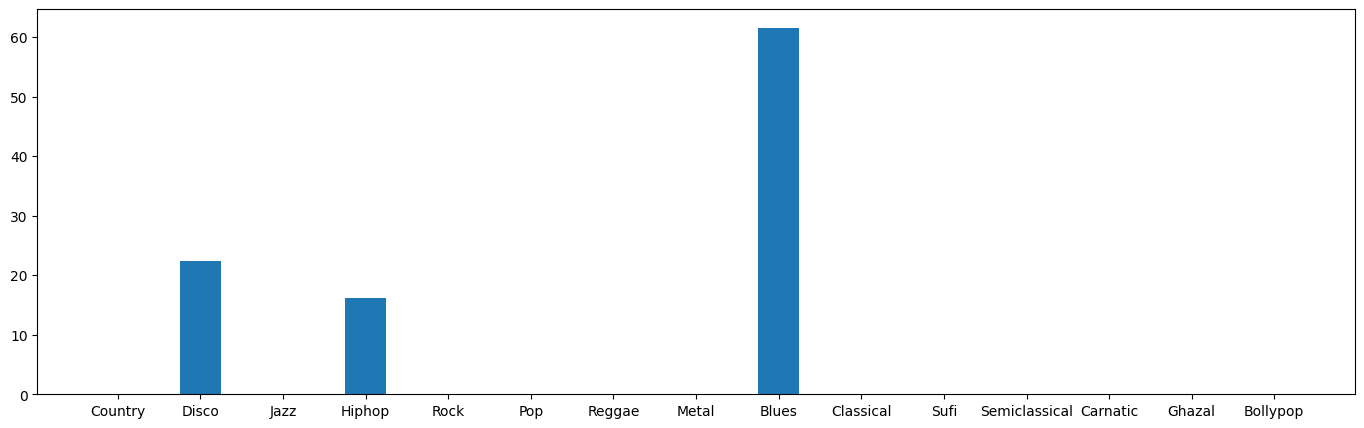

[ 0.          9.44248611 14.51725966  0.          0.          0.
  0.          0.          0.         76.04025422  0.          0.
  0.          0.          0.        ]


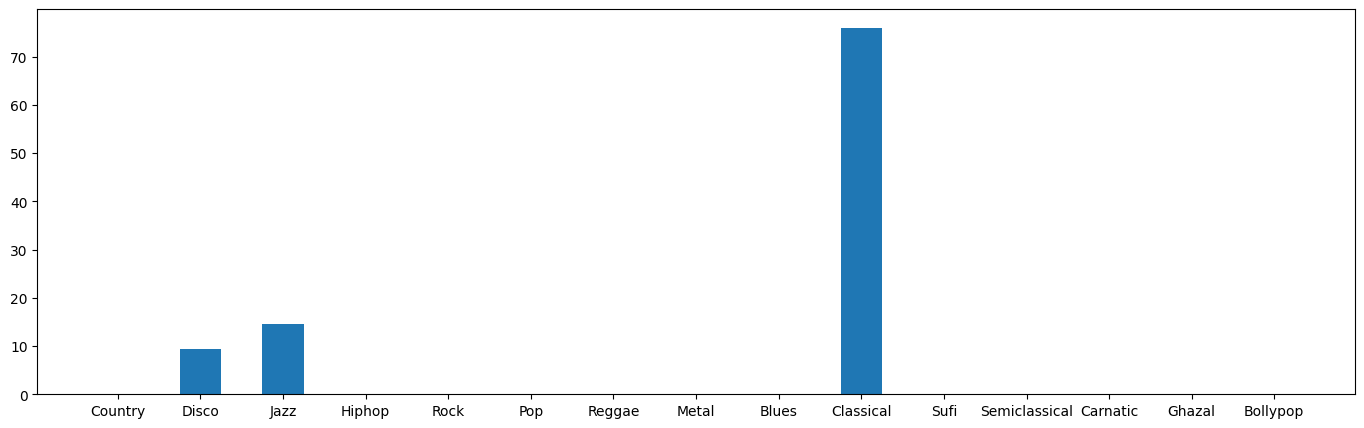

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


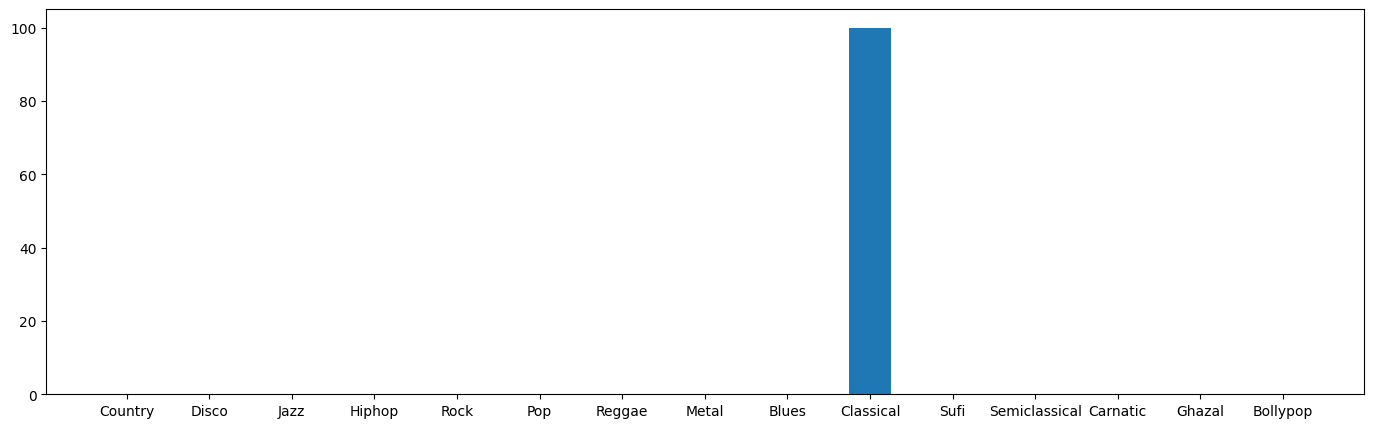

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


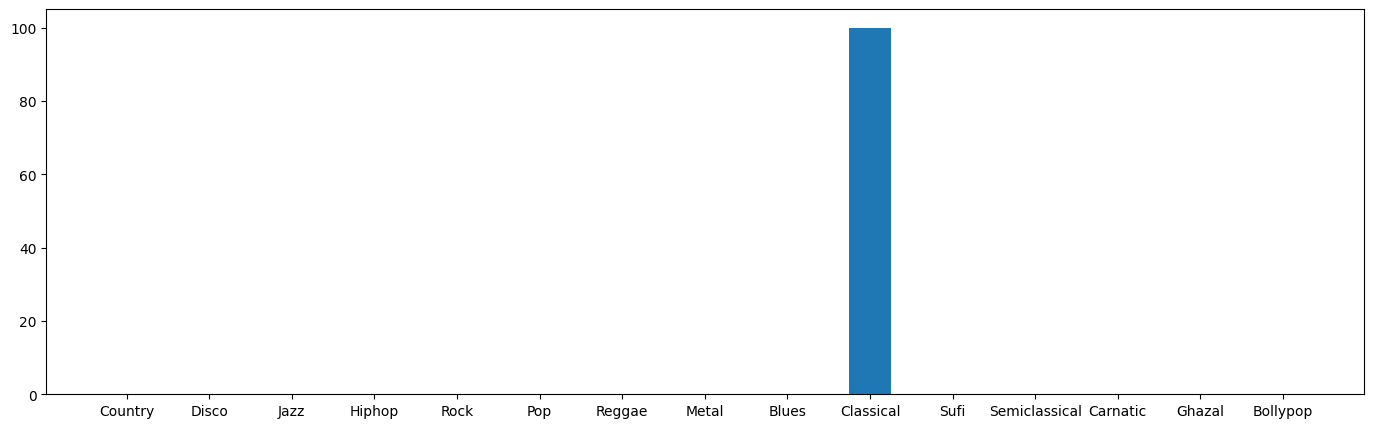

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


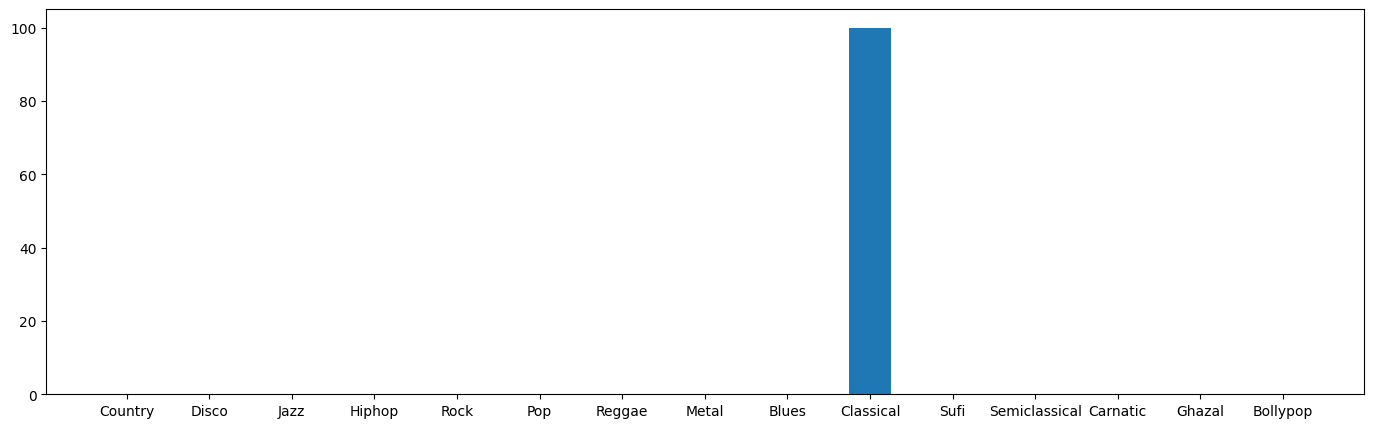

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


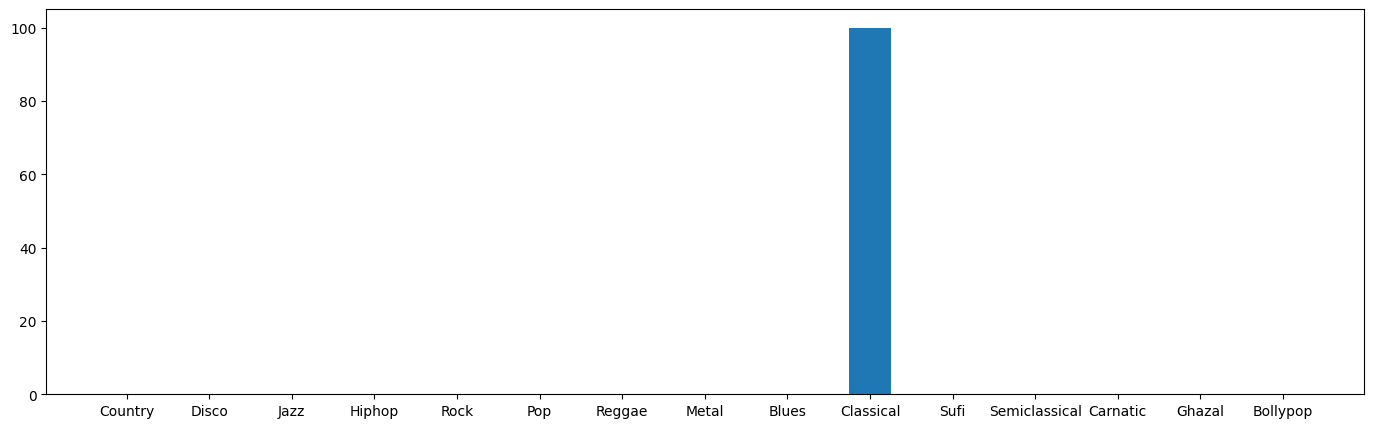

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


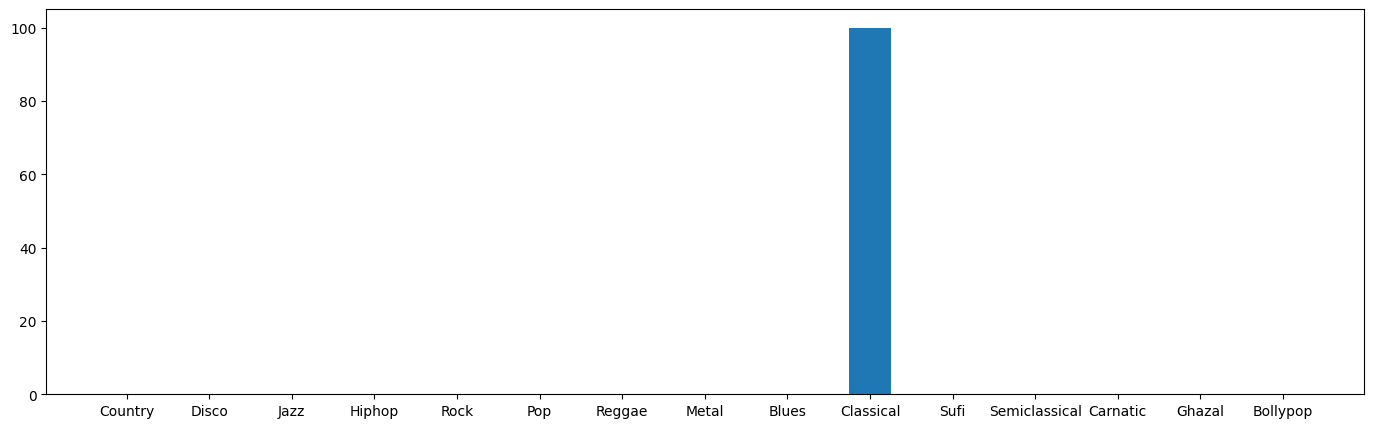

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


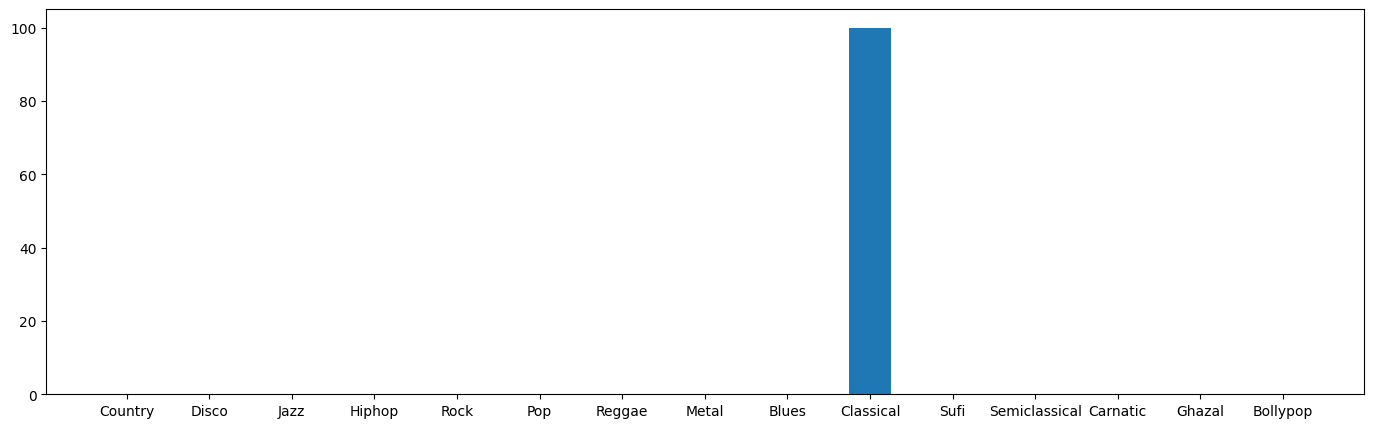

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


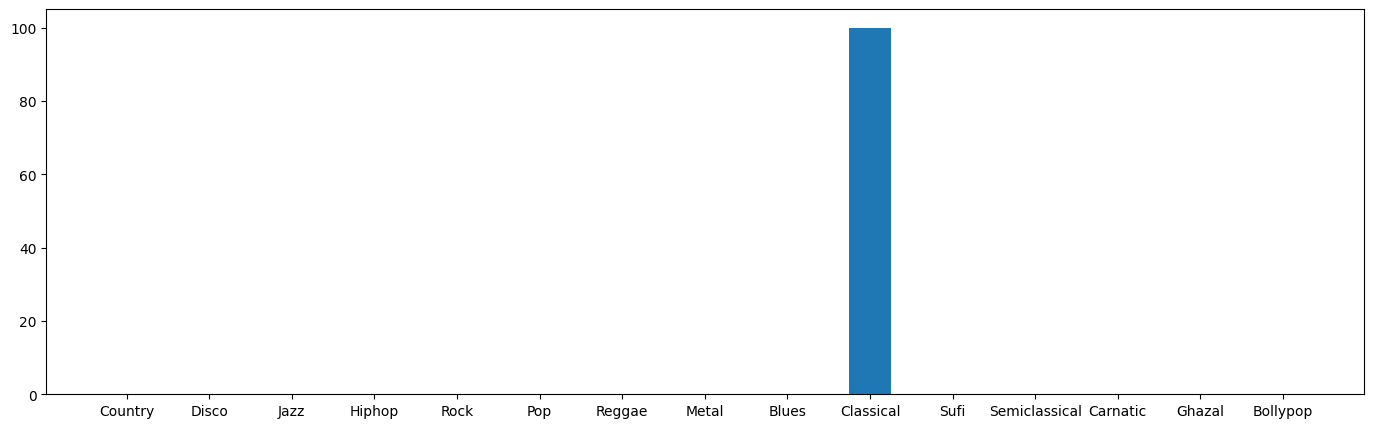

[ 0.          0.         35.51660405  0.          0.          0.
  0.          0.          0.         64.48339595  0.          0.
  0.          0.          0.        ]


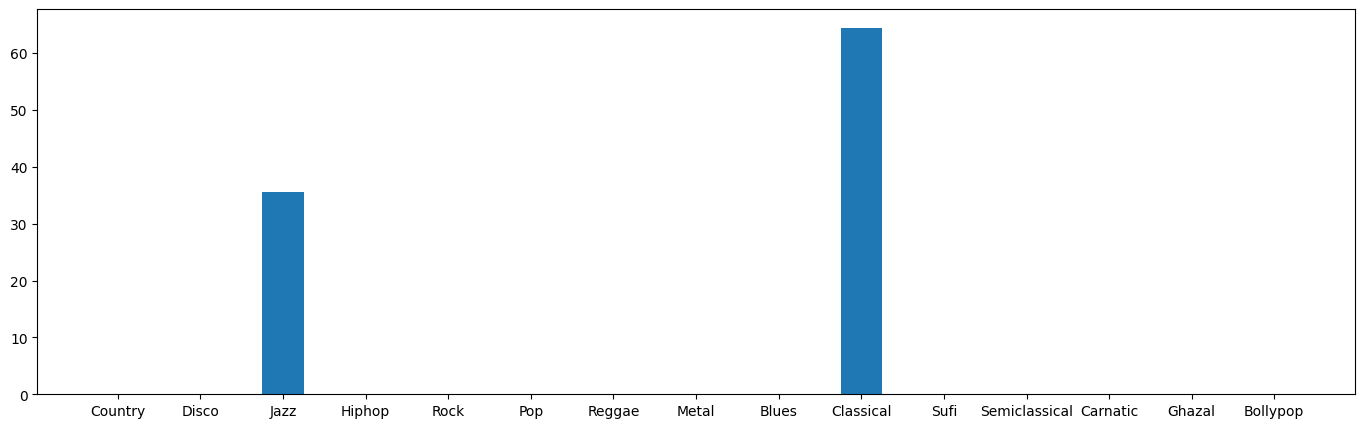

[ 0.          0.          9.89347892  0.          0.          0.
  0.          0.          0.         90.10652108  0.          0.
  0.          0.          0.        ]


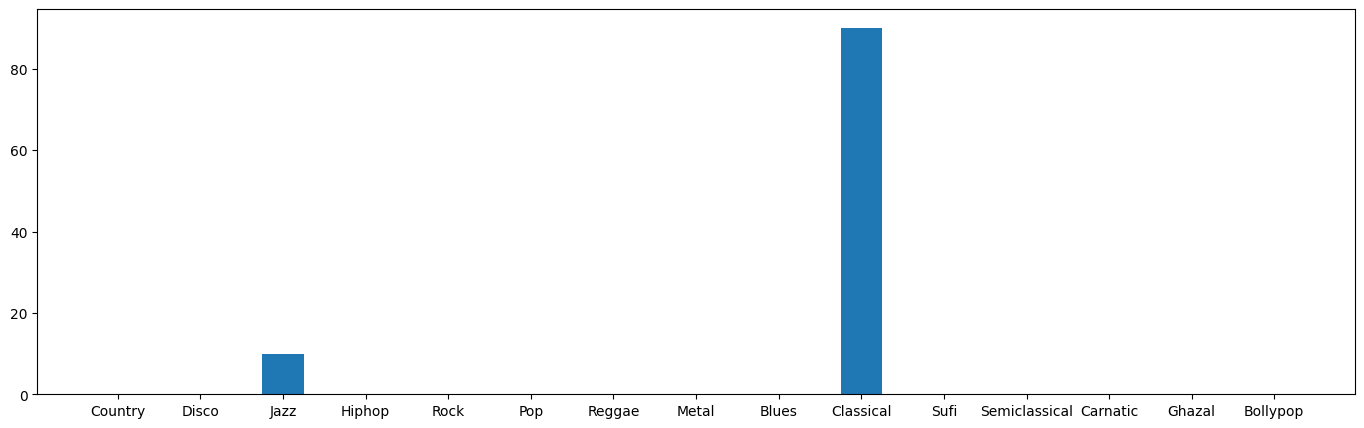

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


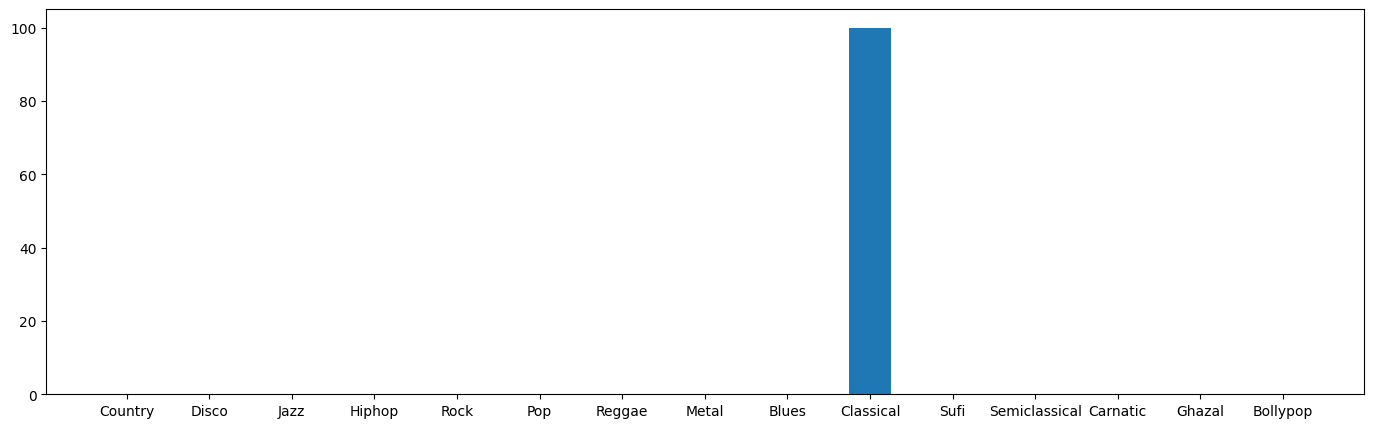

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


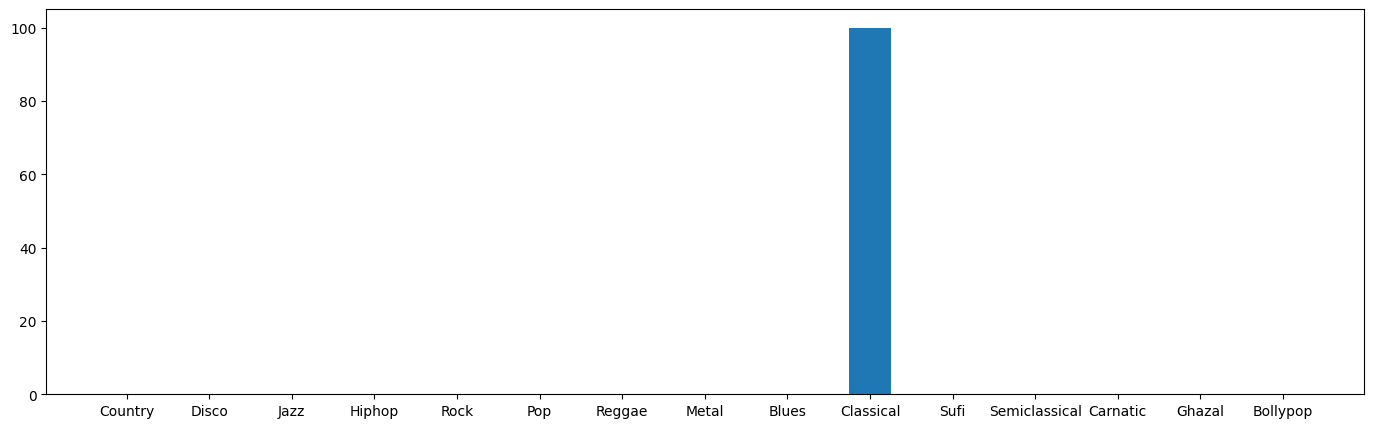

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


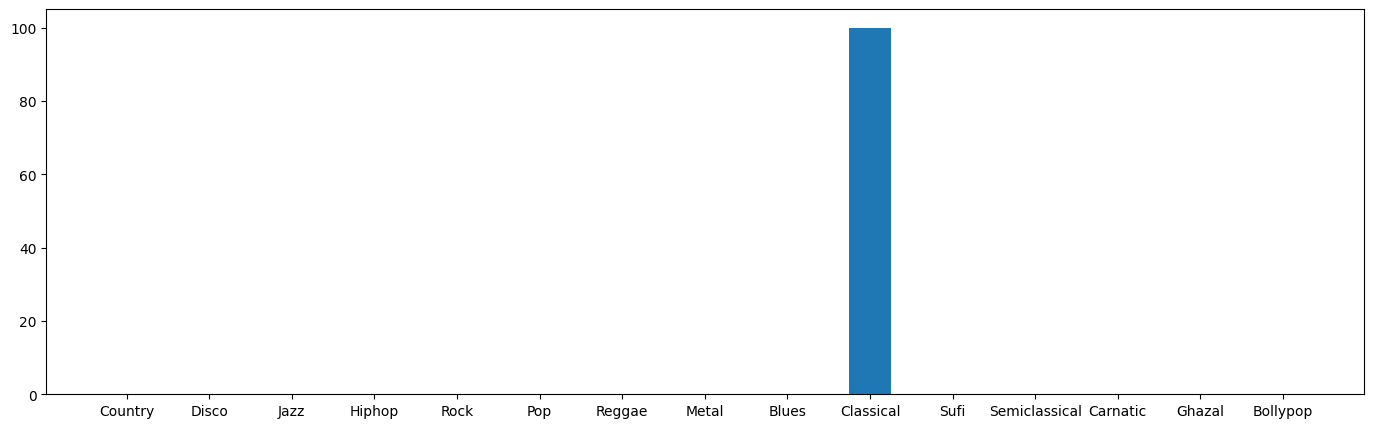

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


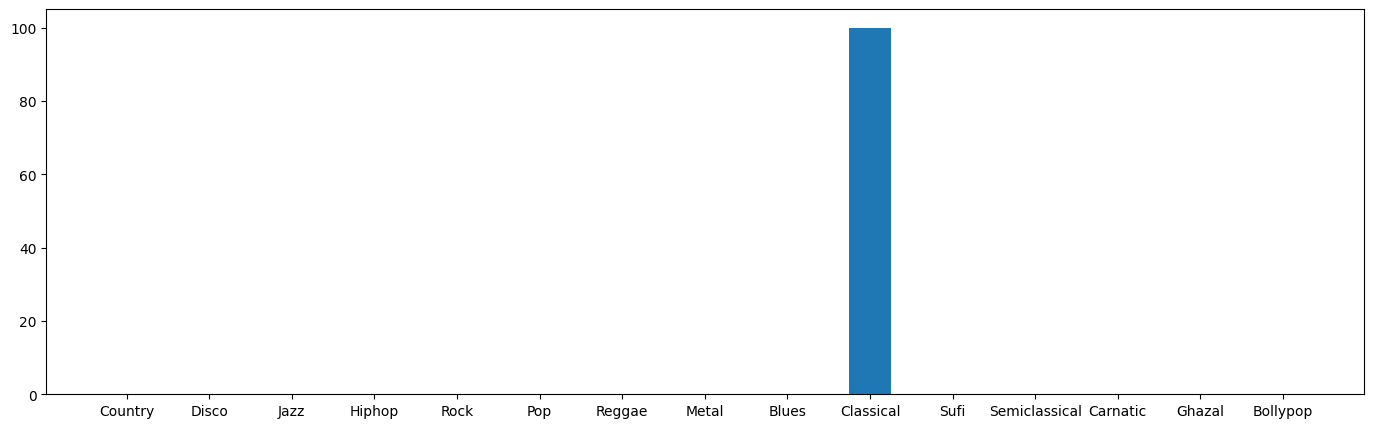

[ 0.          0.         10.74558967  0.          0.          0.
  0.          0.          0.         89.25441033  0.          0.
  0.          0.          0.        ]


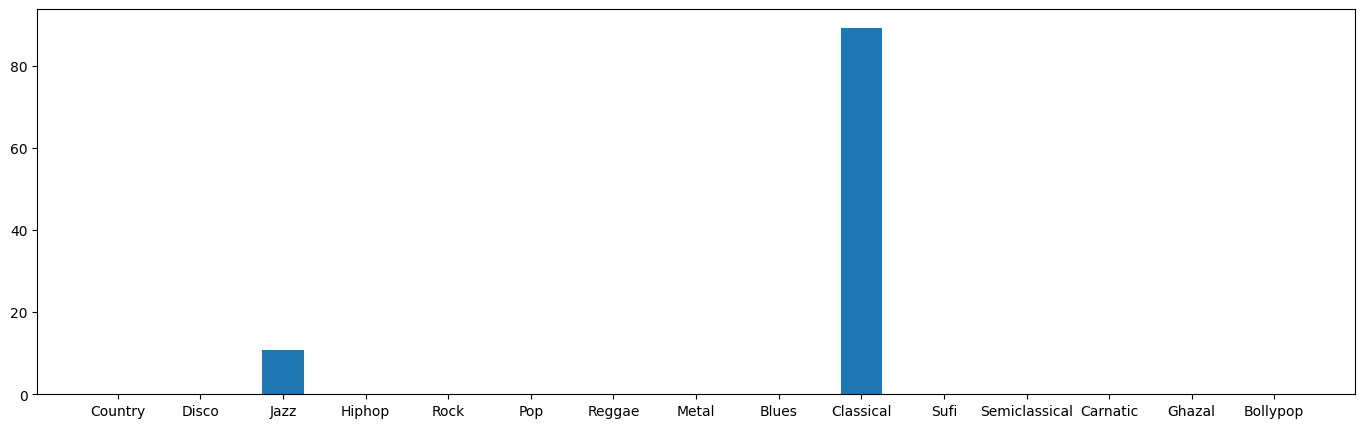

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


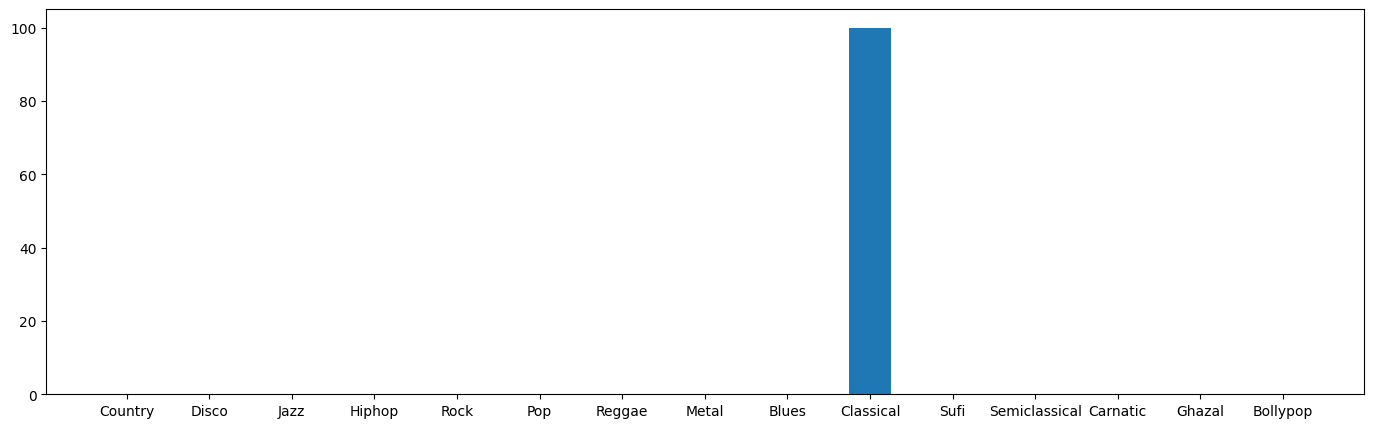

[ 0.         18.00866499  0.          0.         18.55411521  0.
  0.          0.          0.         63.43721981  0.          0.
  0.          0.          0.        ]


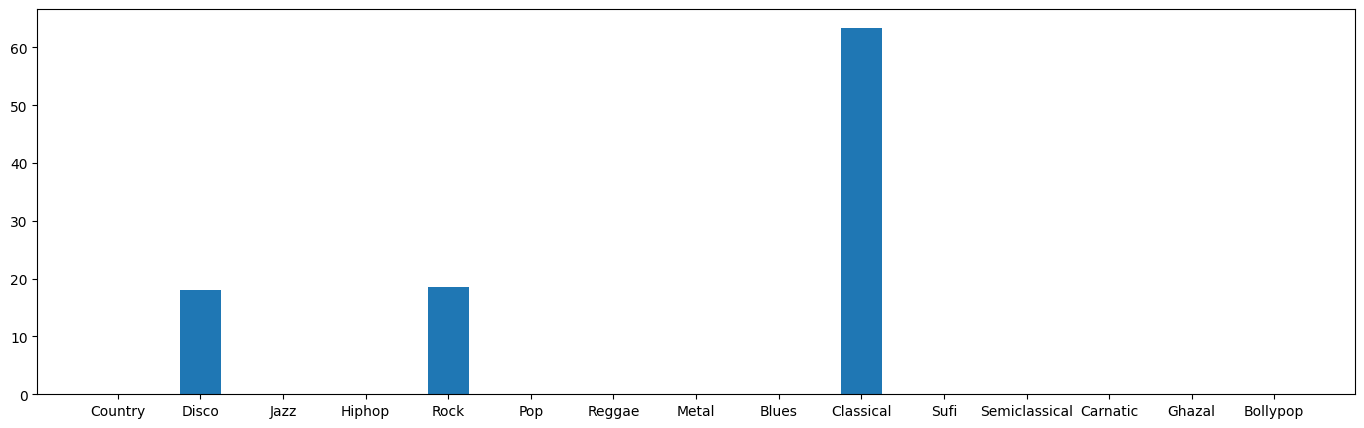

[ 0.          0.         15.14544014  0.          0.          0.
  0.          0.          0.         84.85455986  0.          0.
  0.          0.          0.        ]


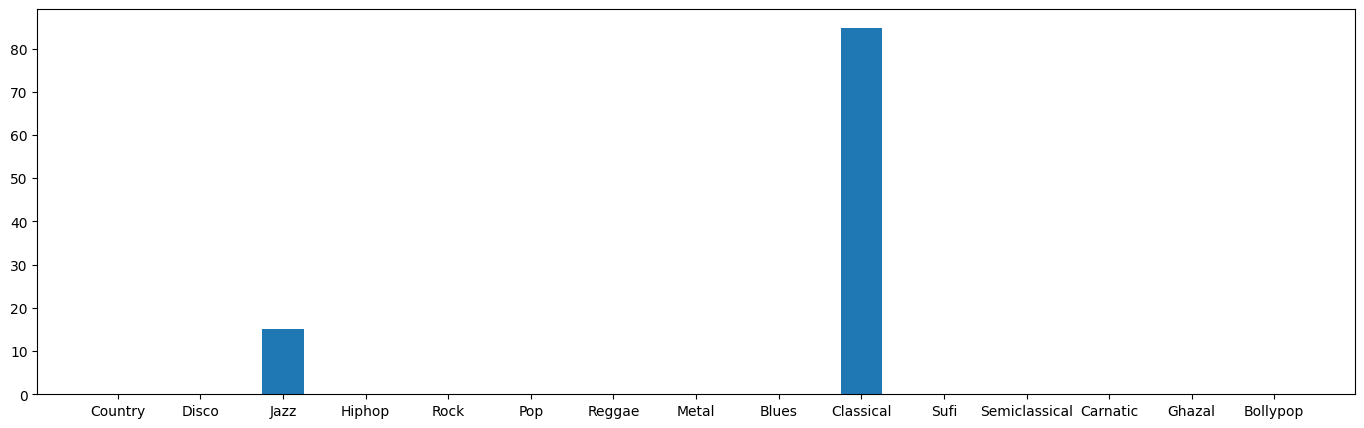

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


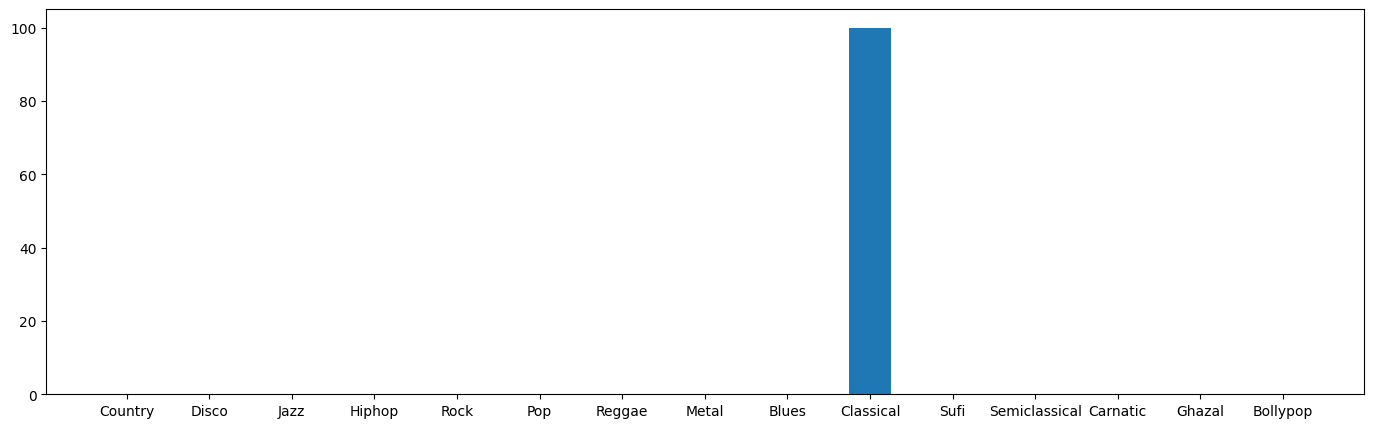

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


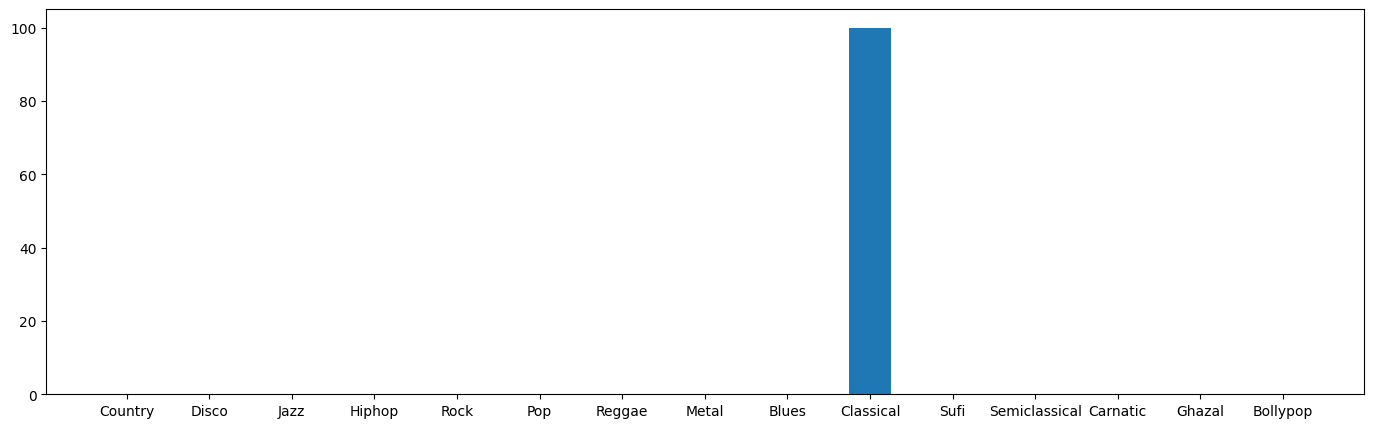

[ 0.         0.         8.7884344  0.         0.         0.
  0.         0.         0.        91.2115656  0.         0.
  0.         0.         0.       ]


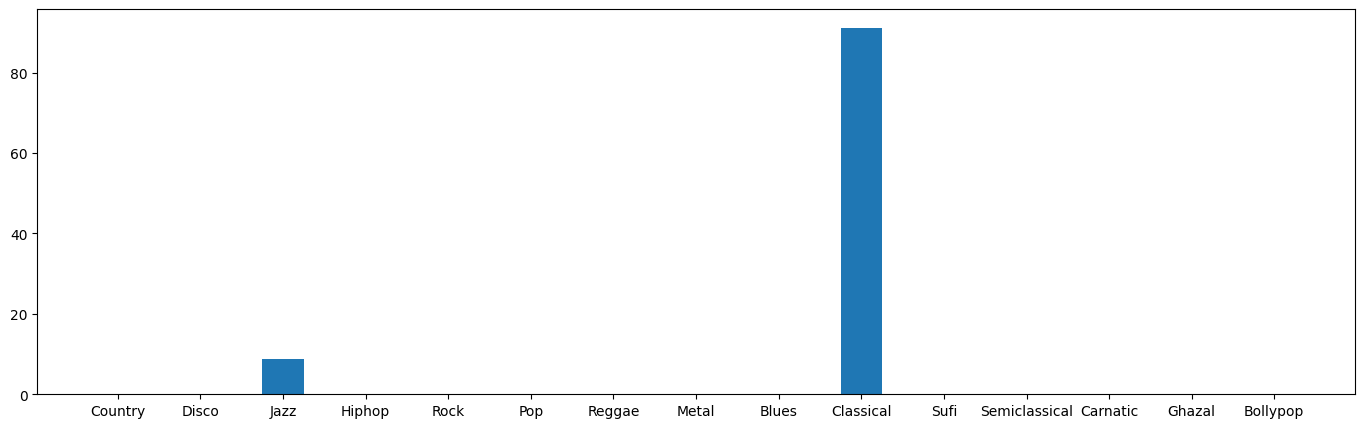

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


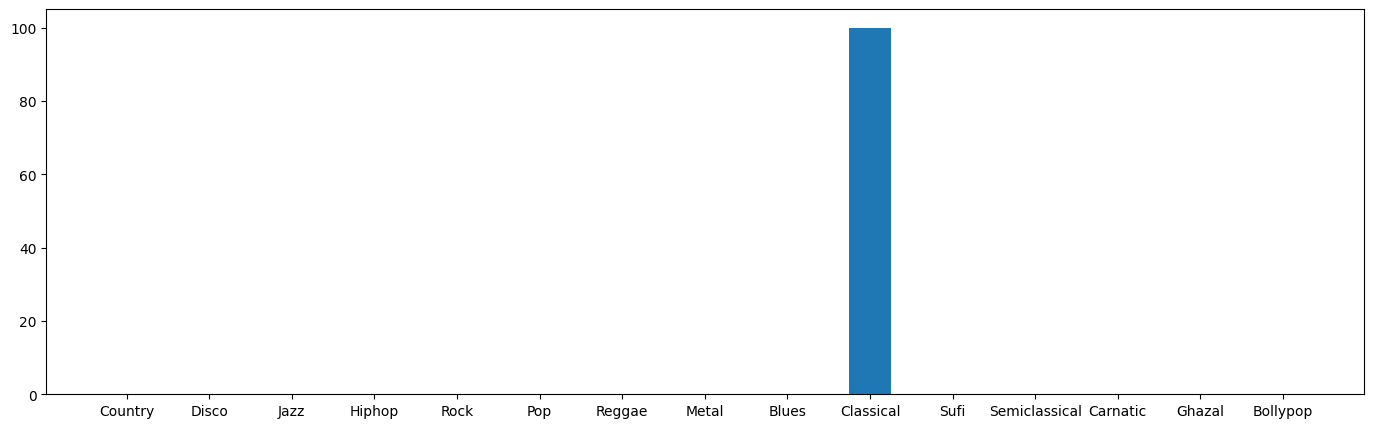

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


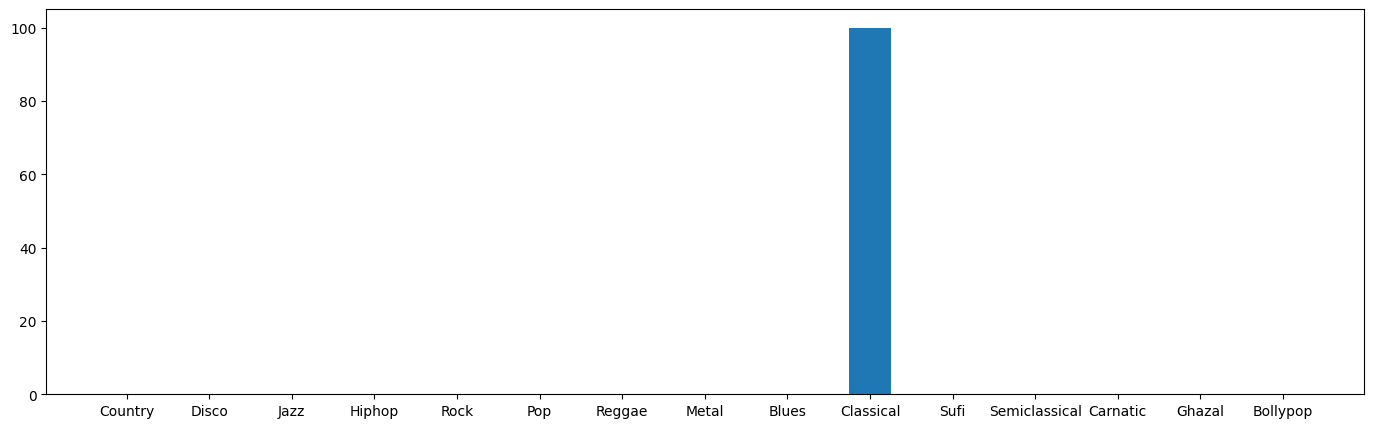

[ 0.          0.         14.33128105  0.          0.          0.
  0.          0.          0.         85.66871895  0.          0.
  0.          0.          0.        ]


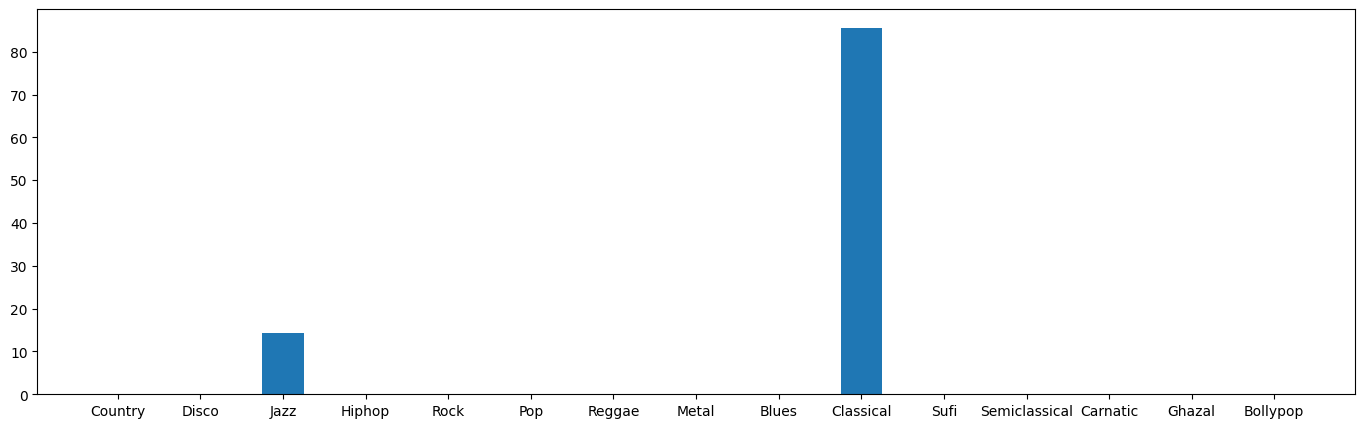

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


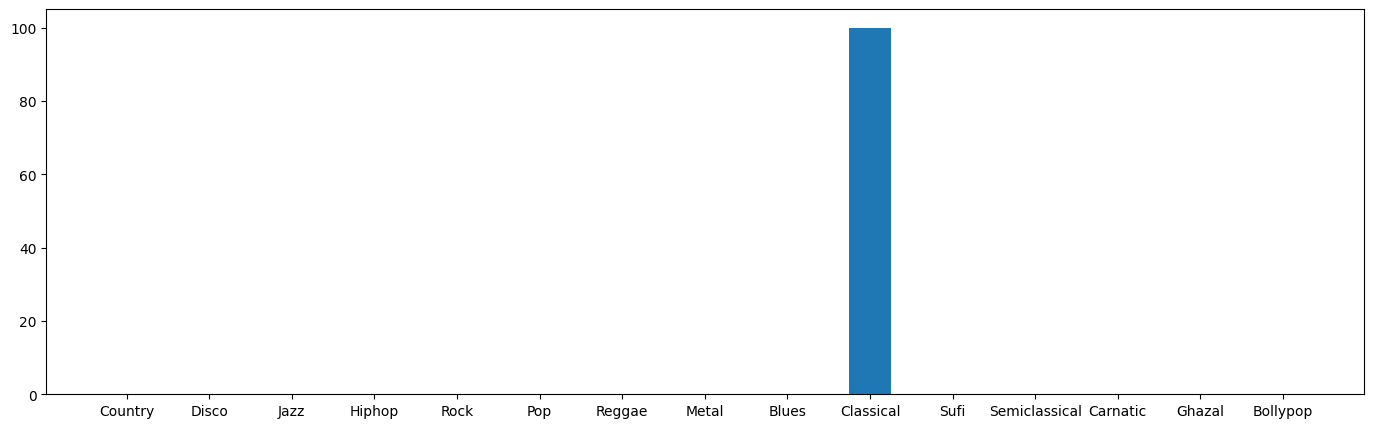

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


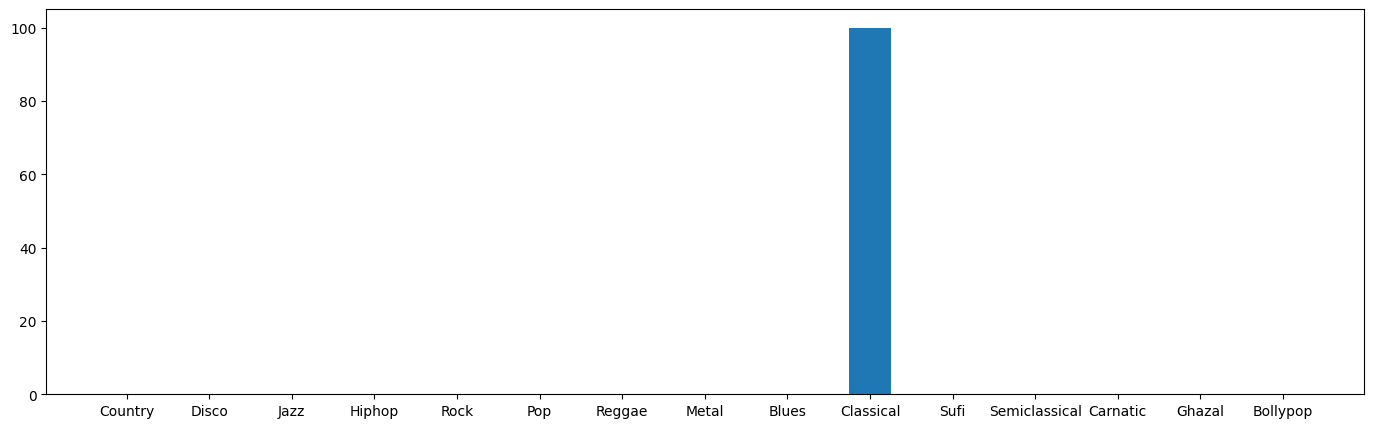

[ 0.          0.         12.21186923  0.          0.          0.
  0.          0.          0.         87.78813077  0.          0.
  0.          0.          0.        ]


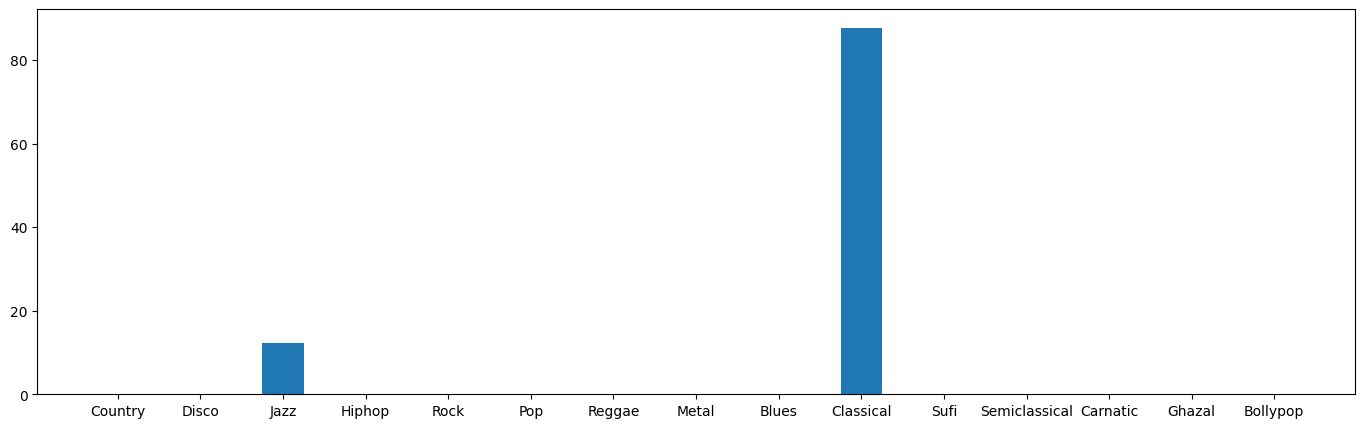

[ 0.          0.         17.73043893  0.          0.          0.
  0.          0.          0.         82.26956107  0.          0.
  0.          0.          0.        ]


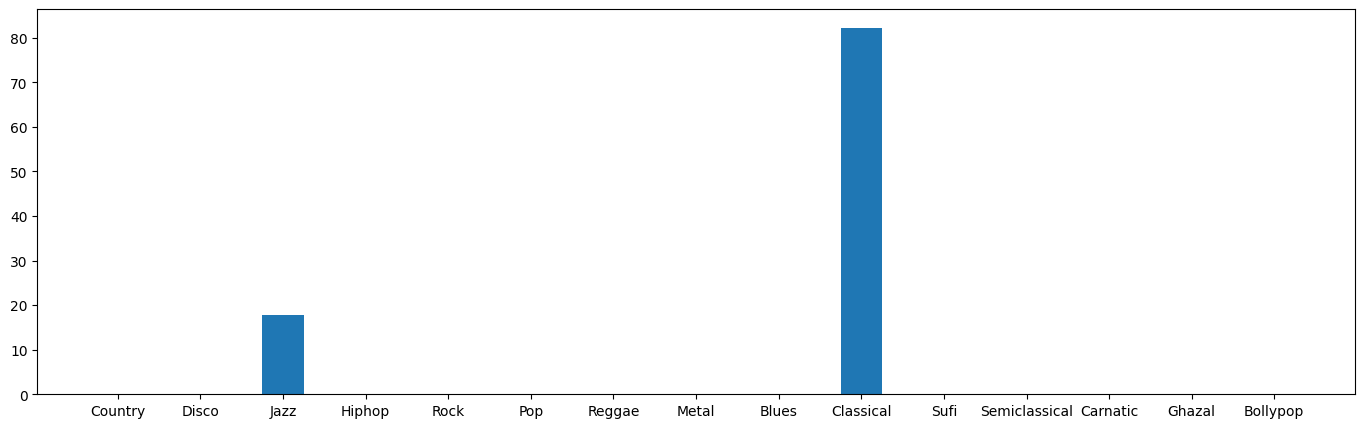

[58.56181071  0.          0.          0.         23.20895336  0.
  0.          0.          0.         18.22923593  0.          0.
  0.          0.          0.        ]


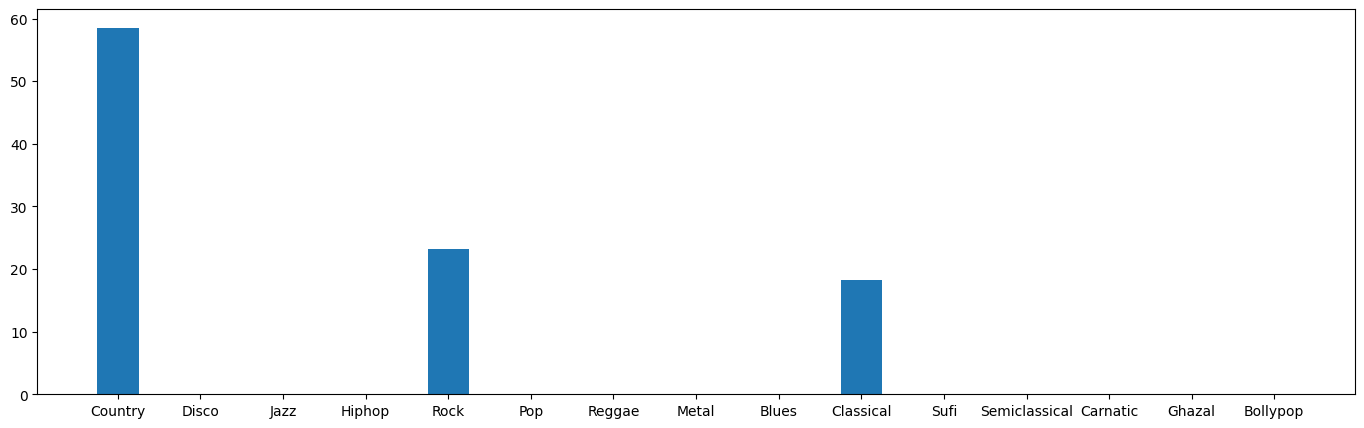

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


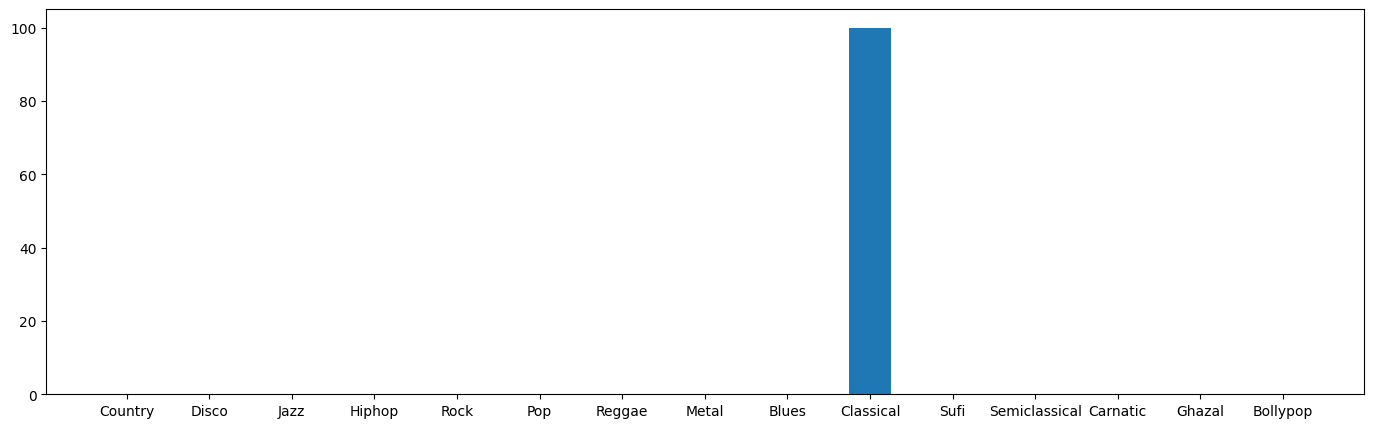

[ 0.          0.         35.84375661  0.          0.          0.
  0.          0.         14.38883003 49.76741336  0.          0.
  0.          0.          0.        ]


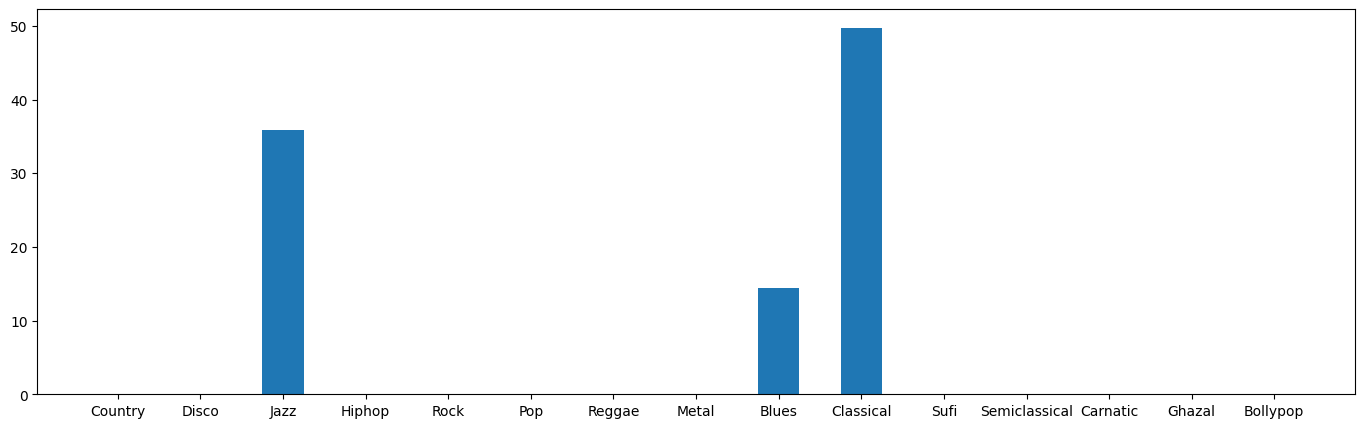

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.04842992 81.95157008
  0.          0.          0.        ]


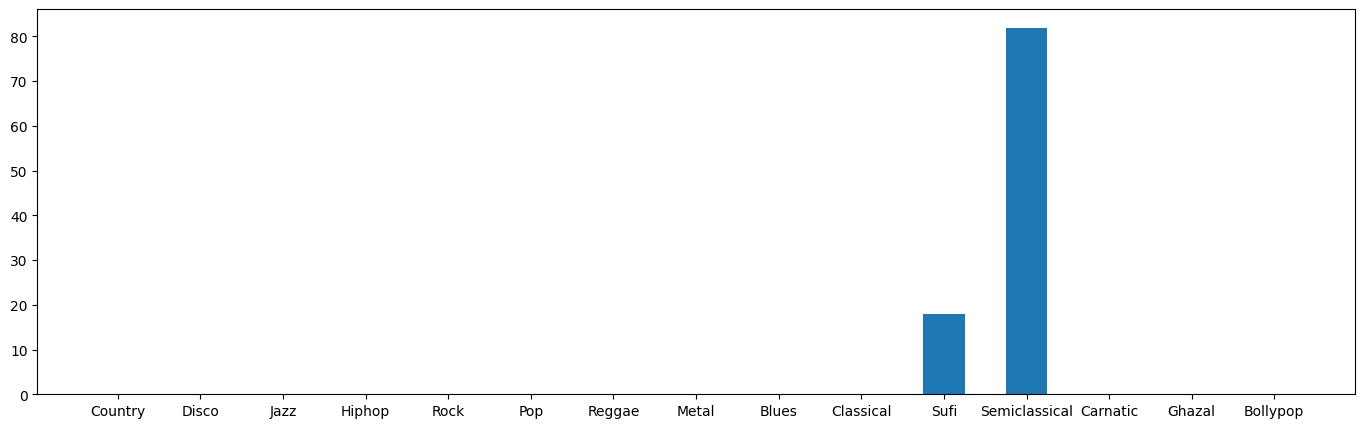

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         85.82237314
  0.          0.         14.17762686]


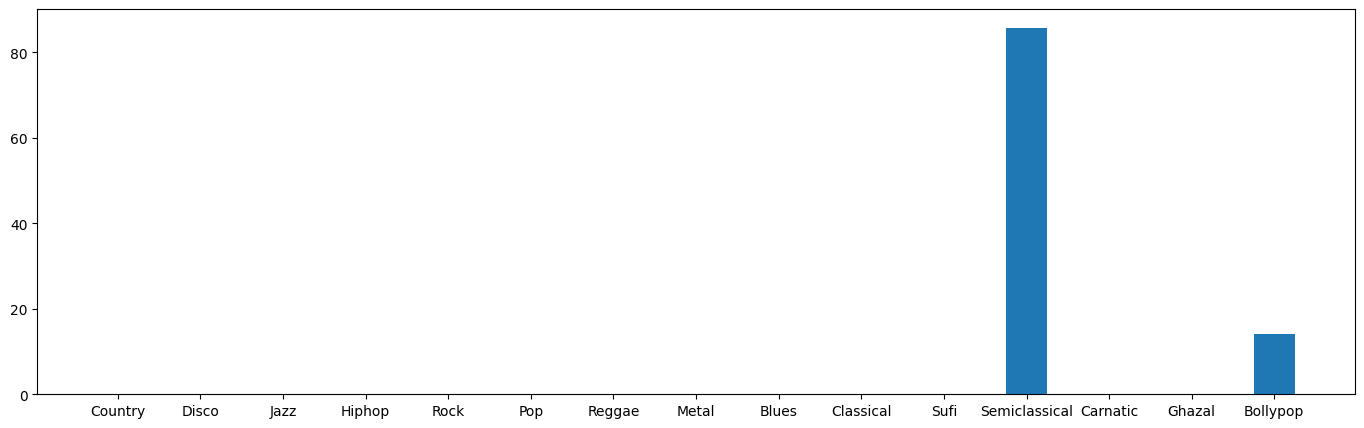

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         49.20148113  0.
 50.79851887  0.          0.        ]


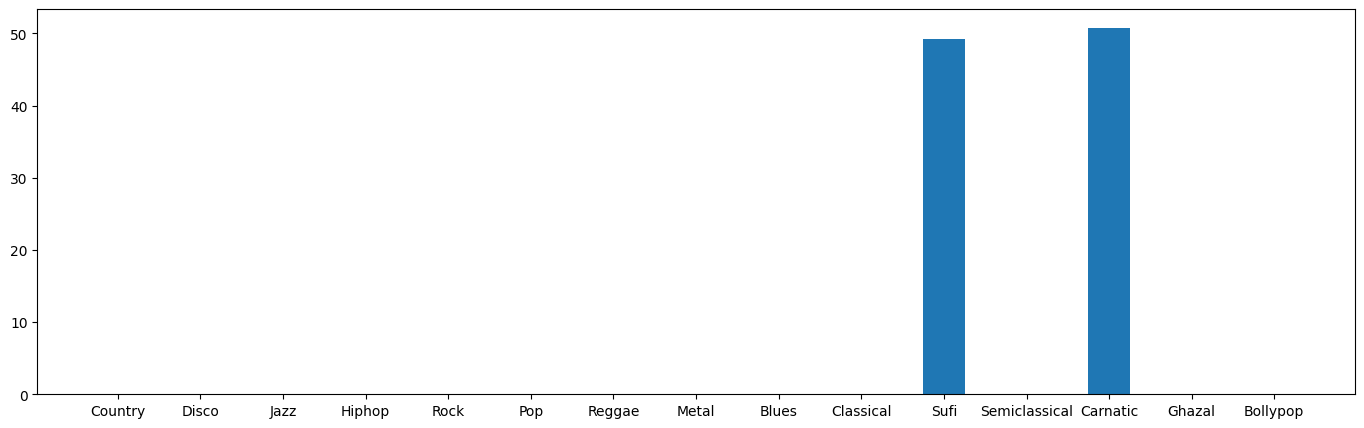

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.
   0.]


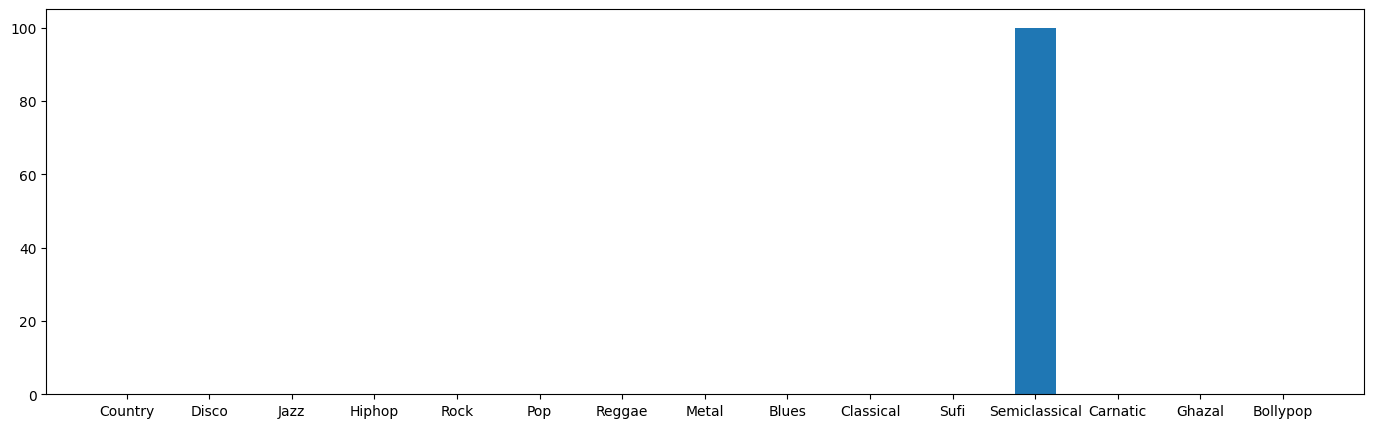

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.04401548  0.         89.51619935
  9.43978517  0.          0.        ]


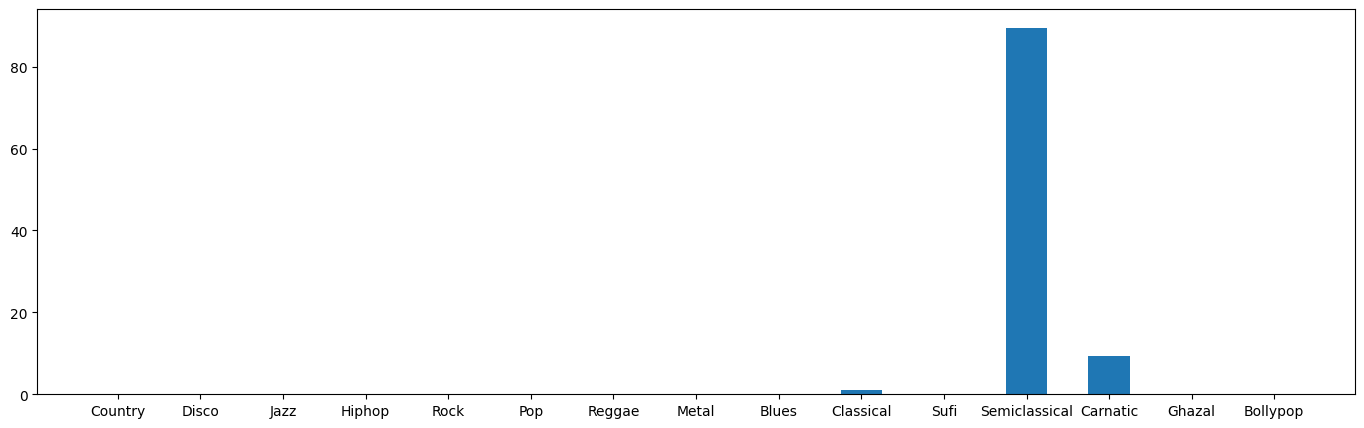

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         82.72619783  9.88533466
  7.38846751  0.          0.        ]


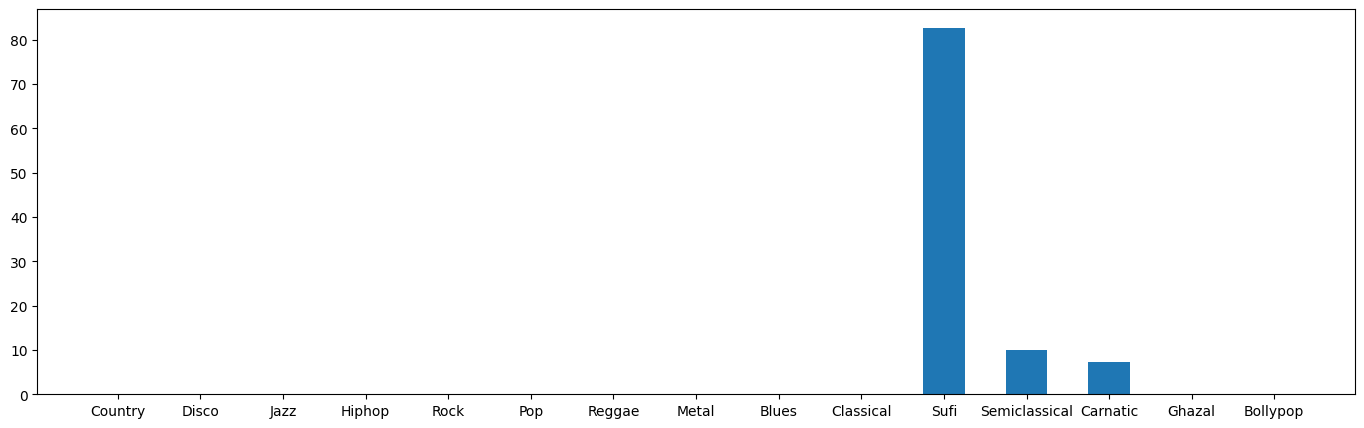

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         70.12382837 29.87617163
  0.          0.          0.        ]


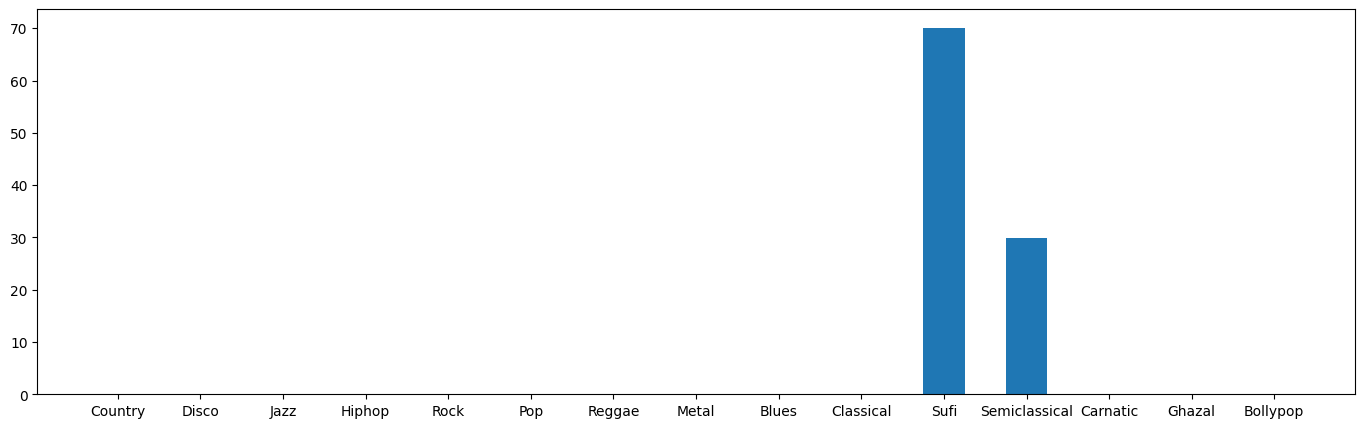

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         16.92540084 49.05169617
  0.          0.         34.02290298]


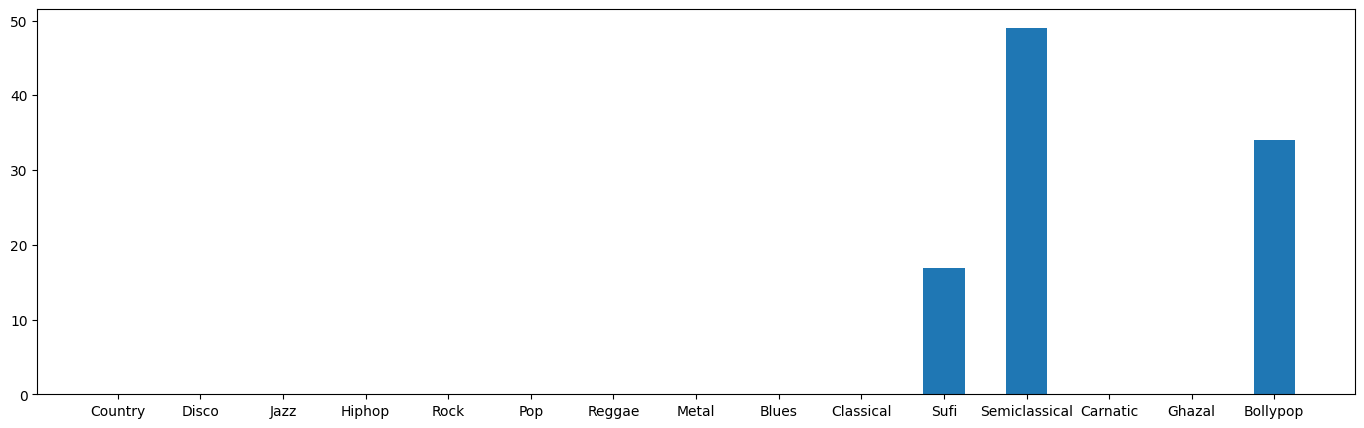

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         21.44464626 61.32769299
 17.22766076  0.          0.        ]


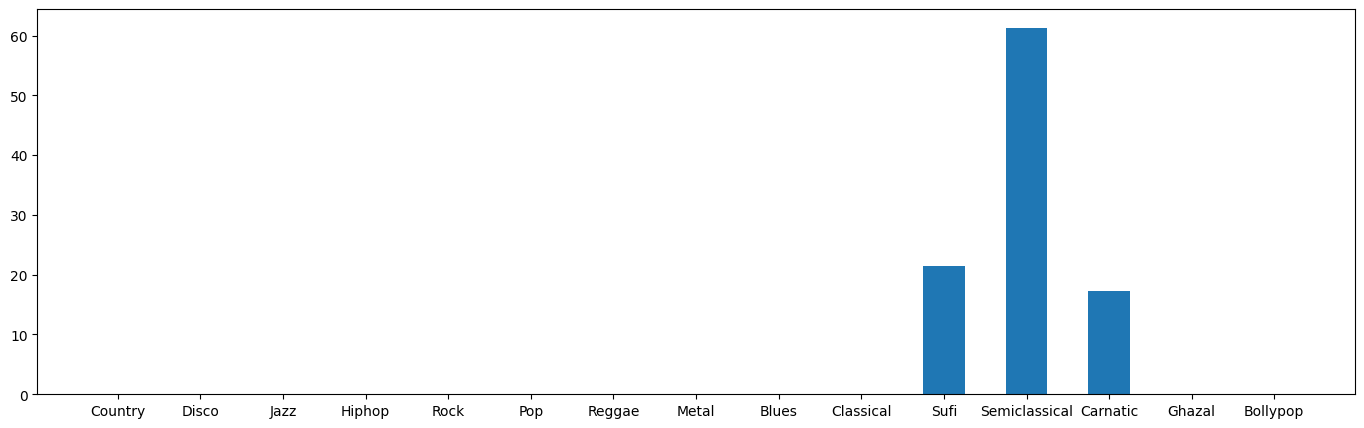

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         19.14499541 40.98697581
  0.         19.37977482 20.48825396]


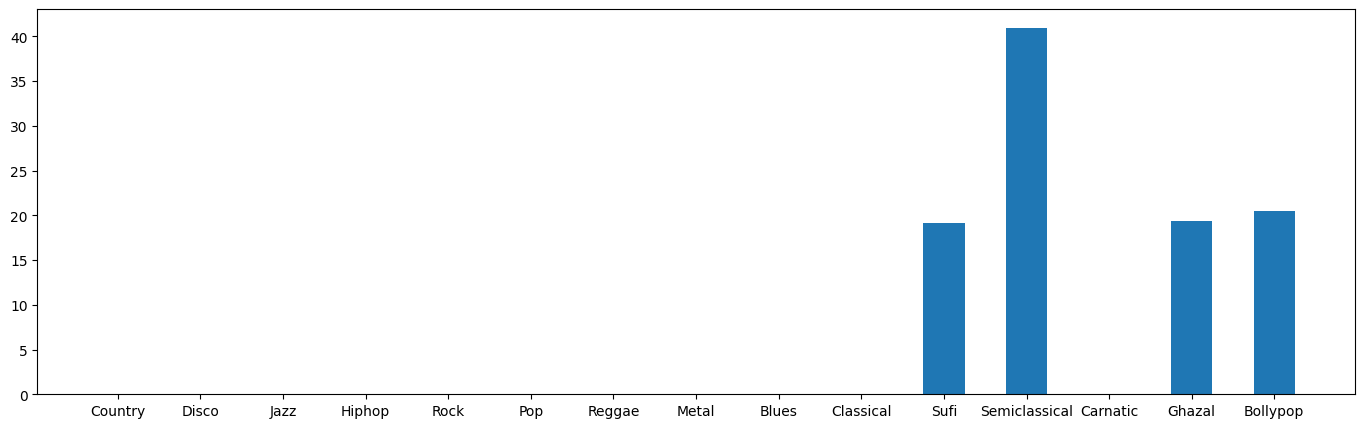

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         96.39892255  0.
  0.          0.          3.60107745]


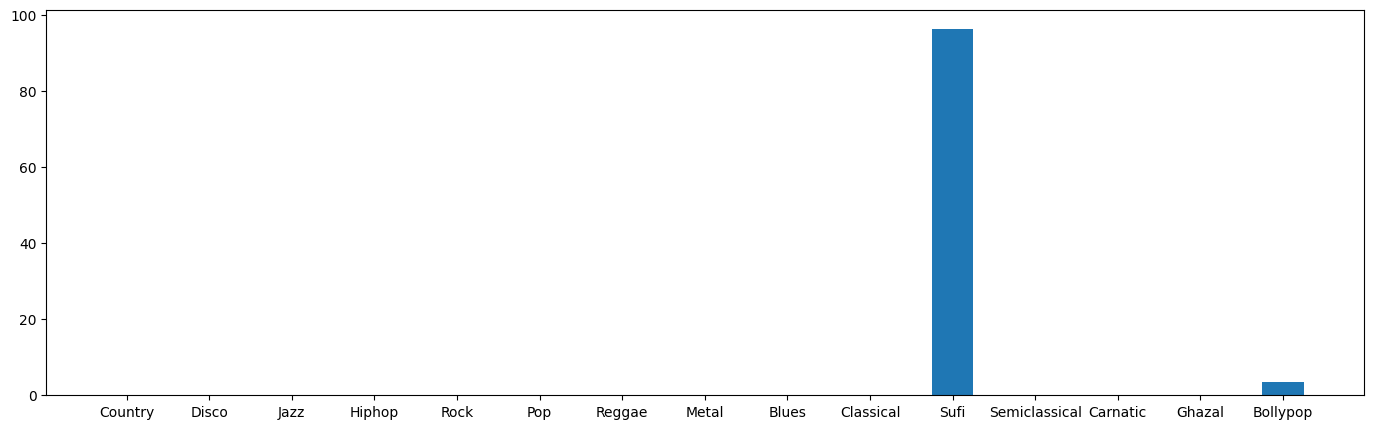

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         38.11484966  0.
  0.          0.         61.88515034]


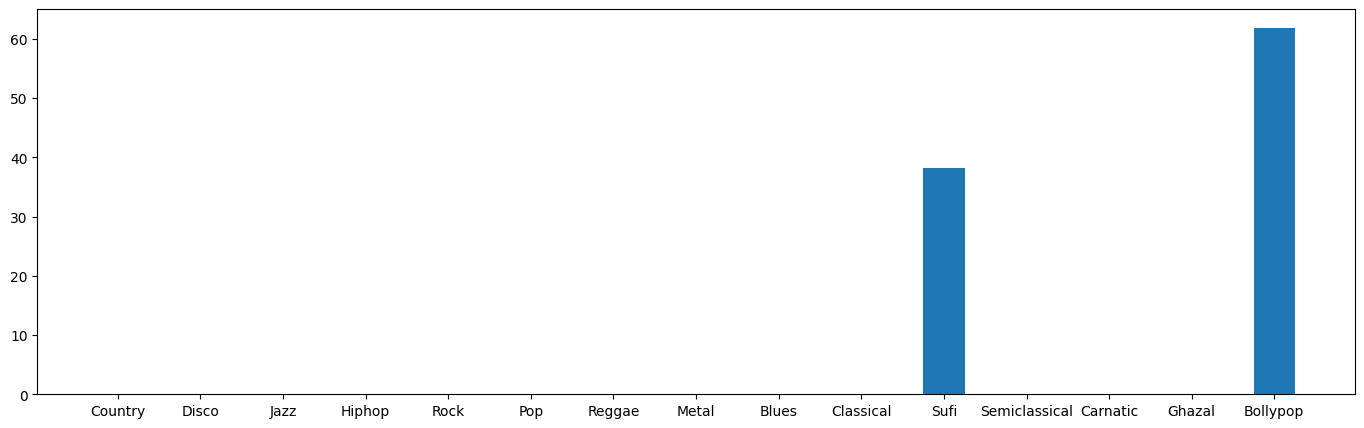

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


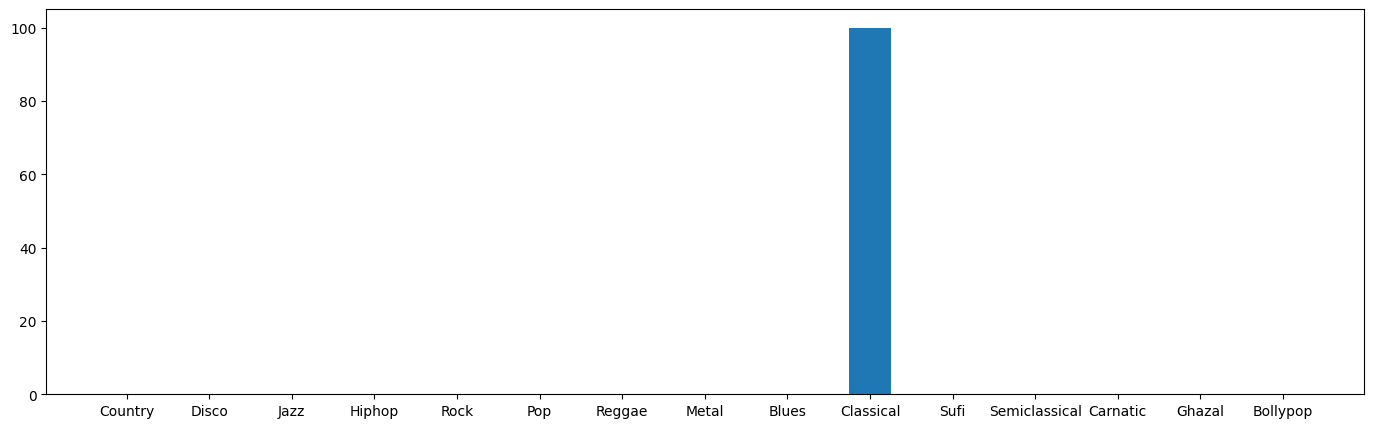

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         56.01411778 28.08061433
  0.          0.         15.90526789]


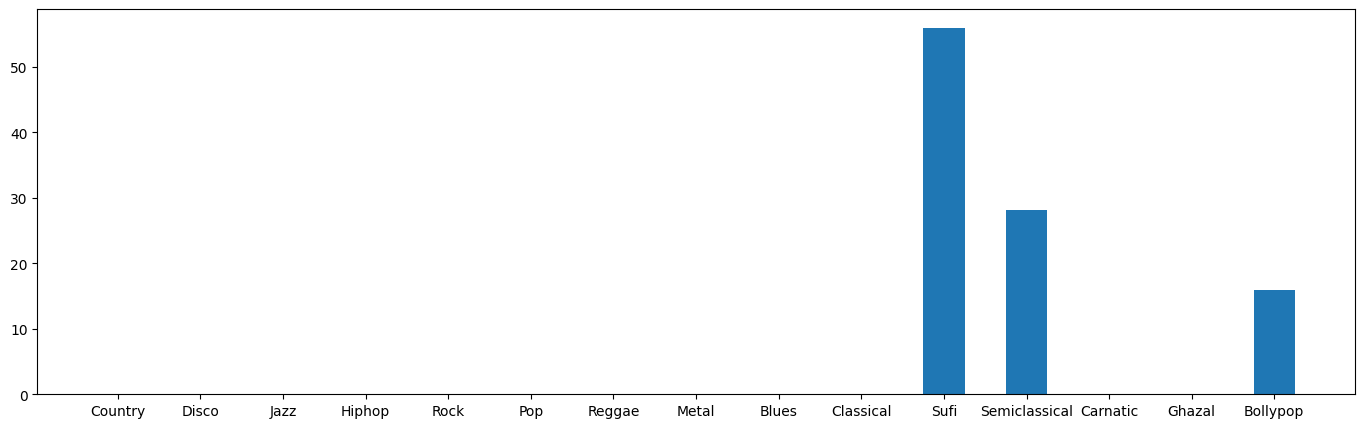

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         71.65293322 28.34706678
  0.          0.          0.        ]


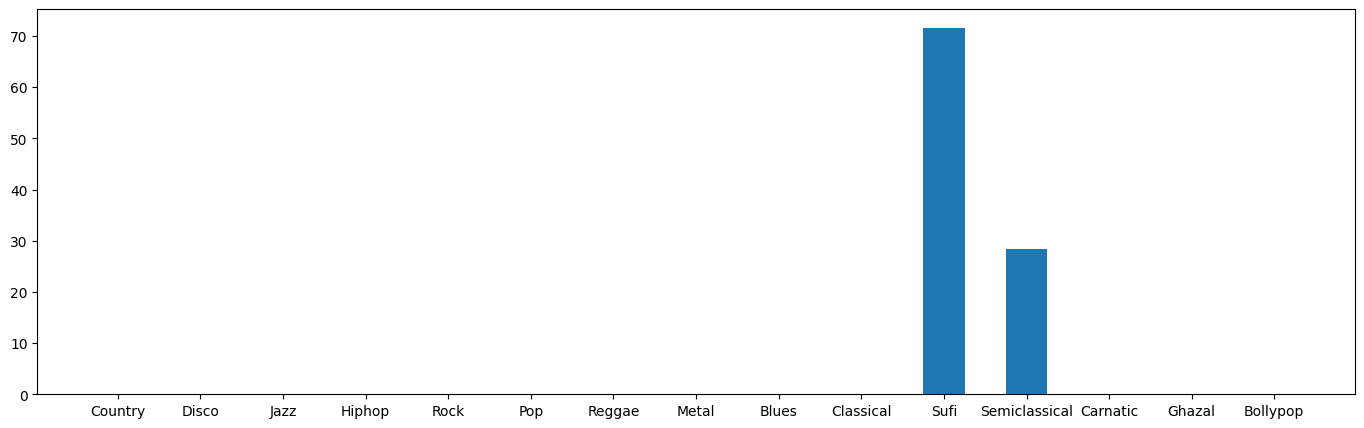

[ 0.          0.          7.40620003  0.          0.          0.
  0.          0.          0.          0.         58.61803461  0.
  0.         33.97576535  0.        ]


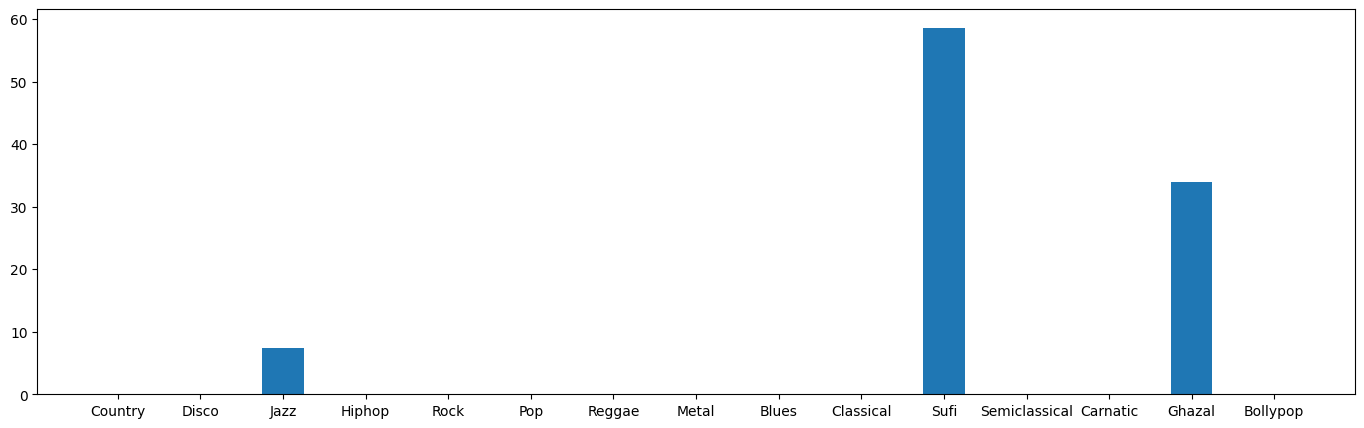

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         82.25784473 17.74215527
  0.          0.          0.        ]


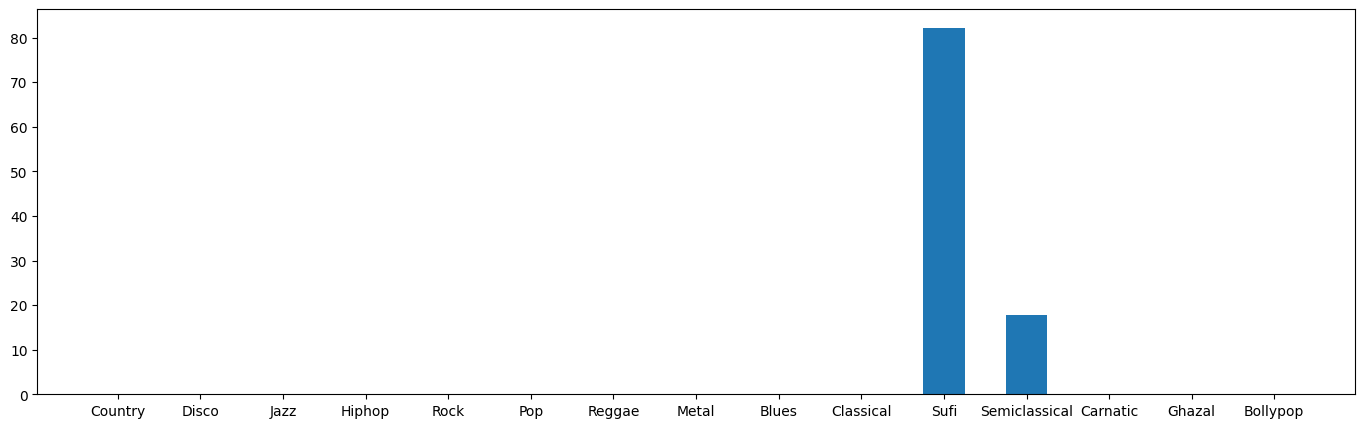

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         59.75855514  0.
  0.          0.         40.24144486]


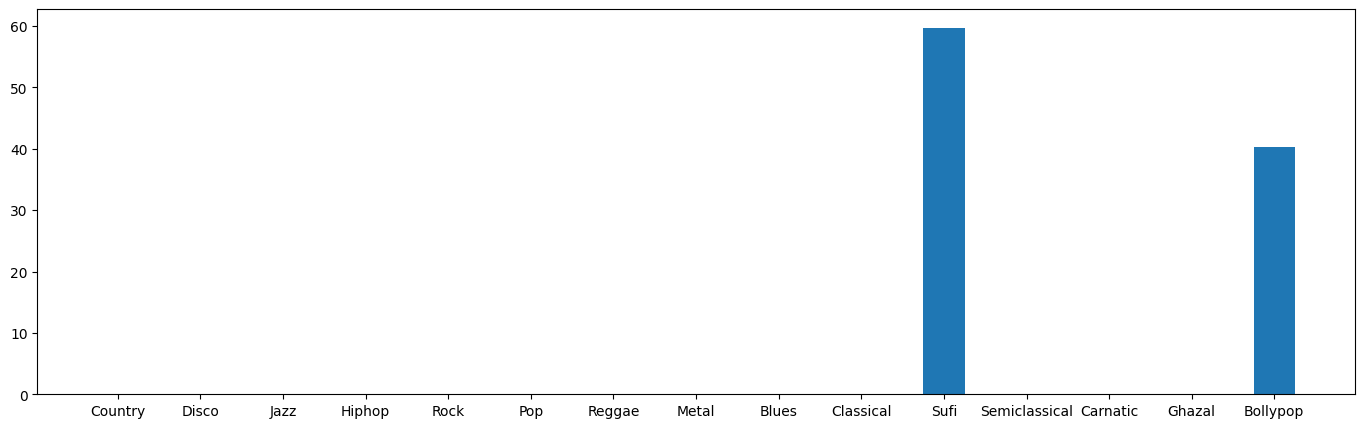

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         62.77966493  0.
 27.54662367  9.6737114   0.        ]


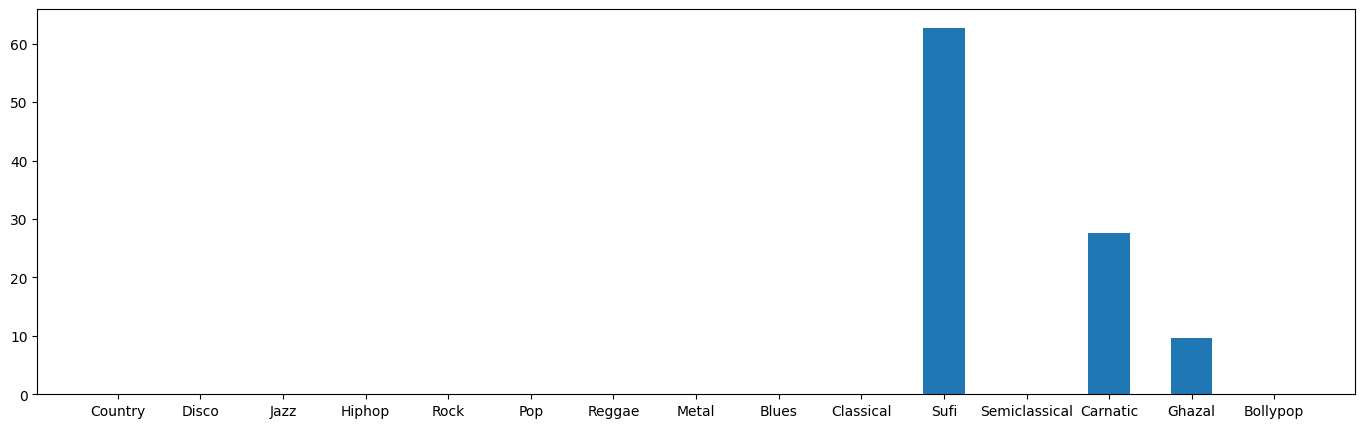

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         53.28859663 22.06579145  0.
  0.         24.64561193  0.        ]


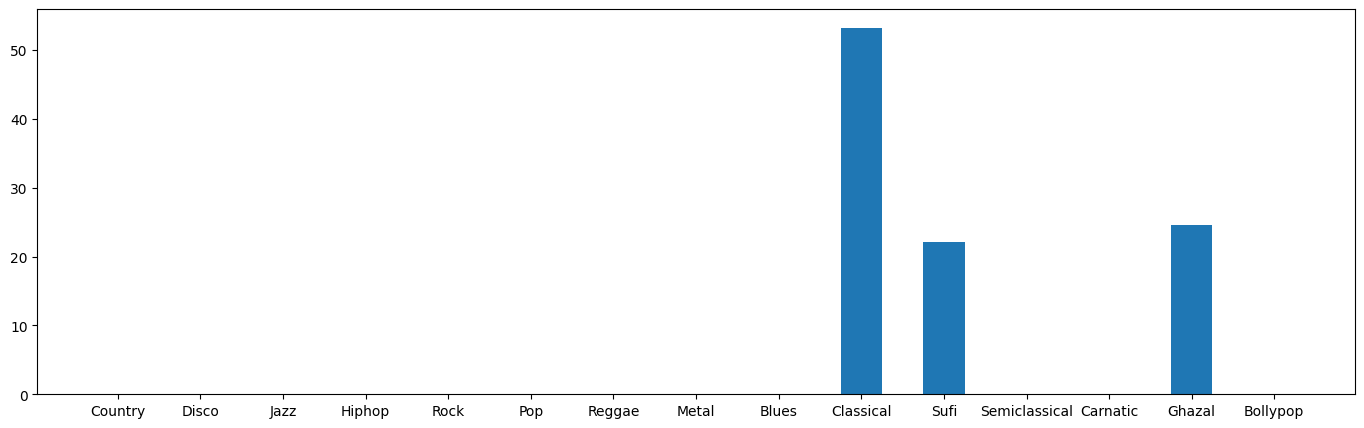

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         36.64861764  0.
  0.         63.35138236  0.        ]


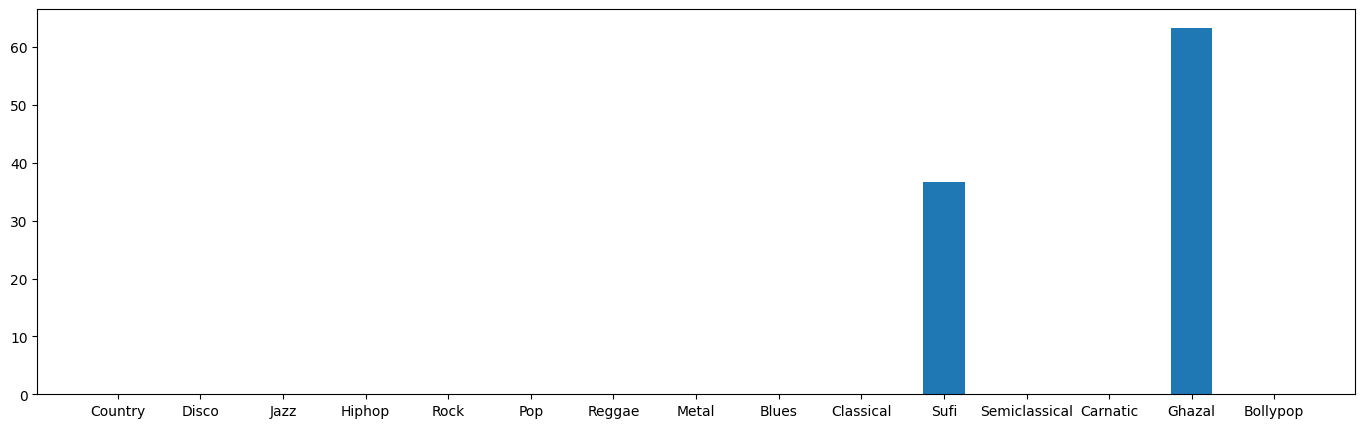

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         23.24280749 17.62333202
 38.8894179   0.         20.24444259]


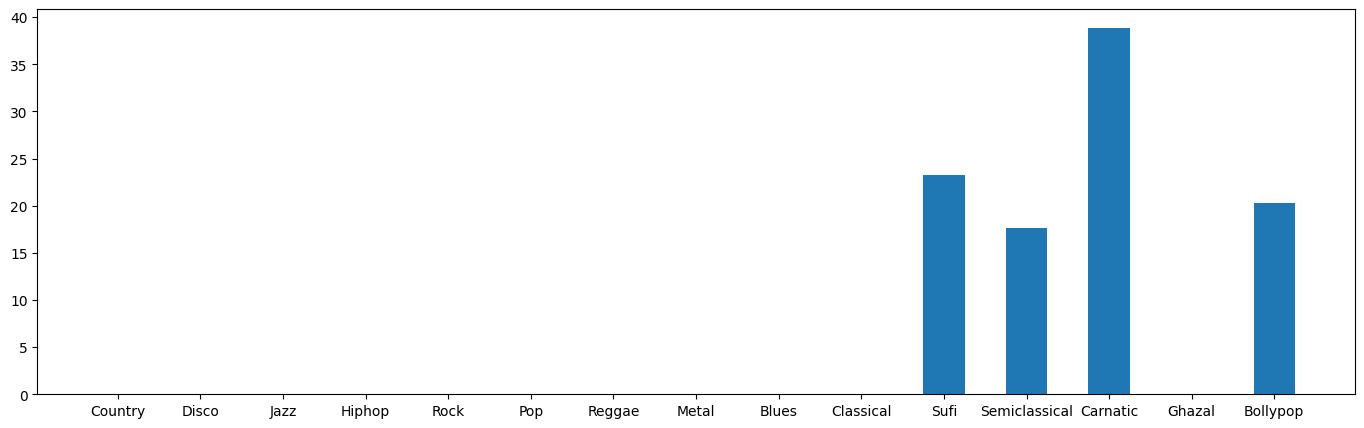

[ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        19.5562807  0.
  0.        80.4437193  0.       ]


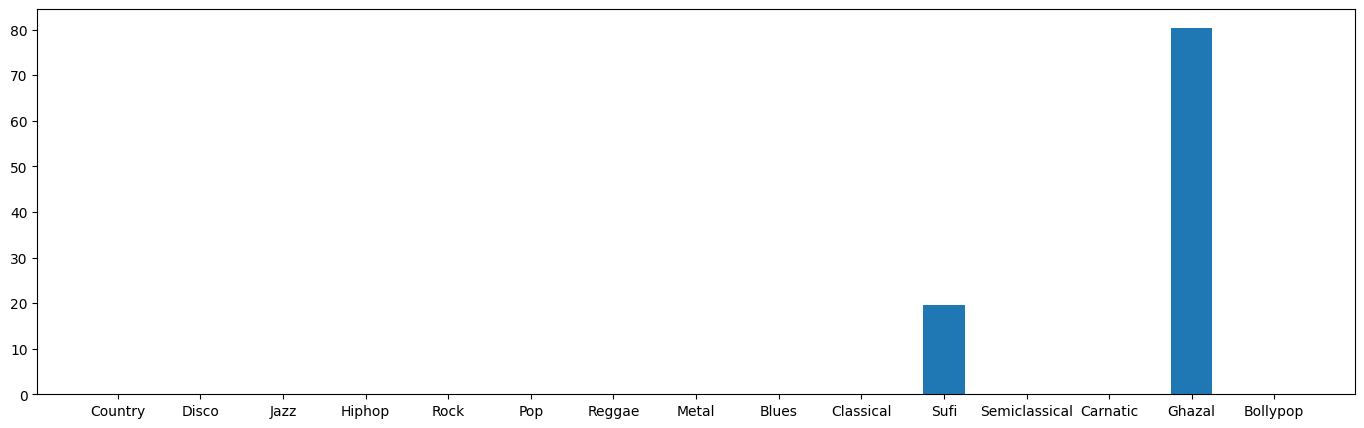

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         13.63832231 33.48707625
 52.87460144  0.          0.        ]


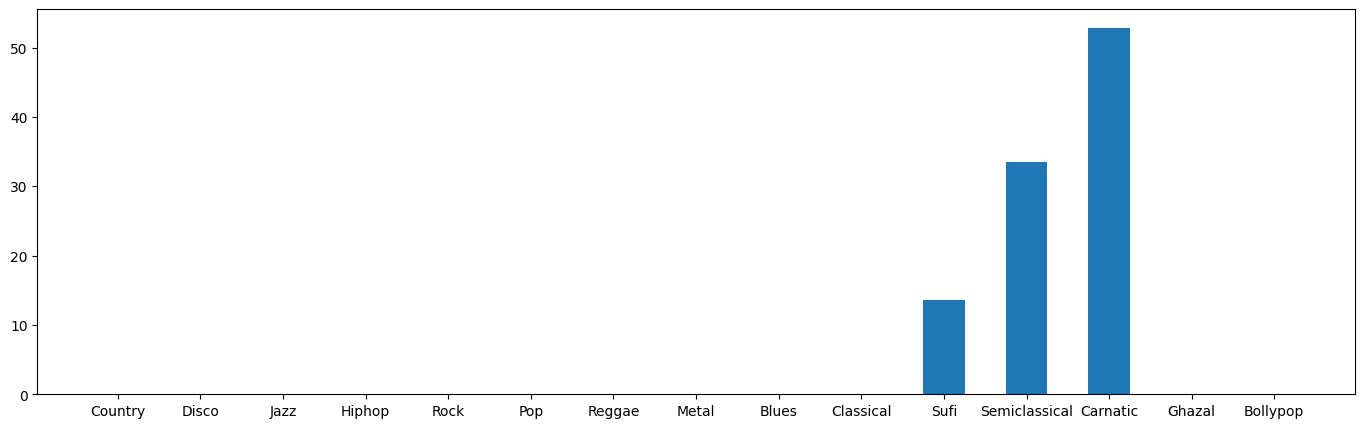

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         32.48891705  0.
  0.          0.         67.51108295]


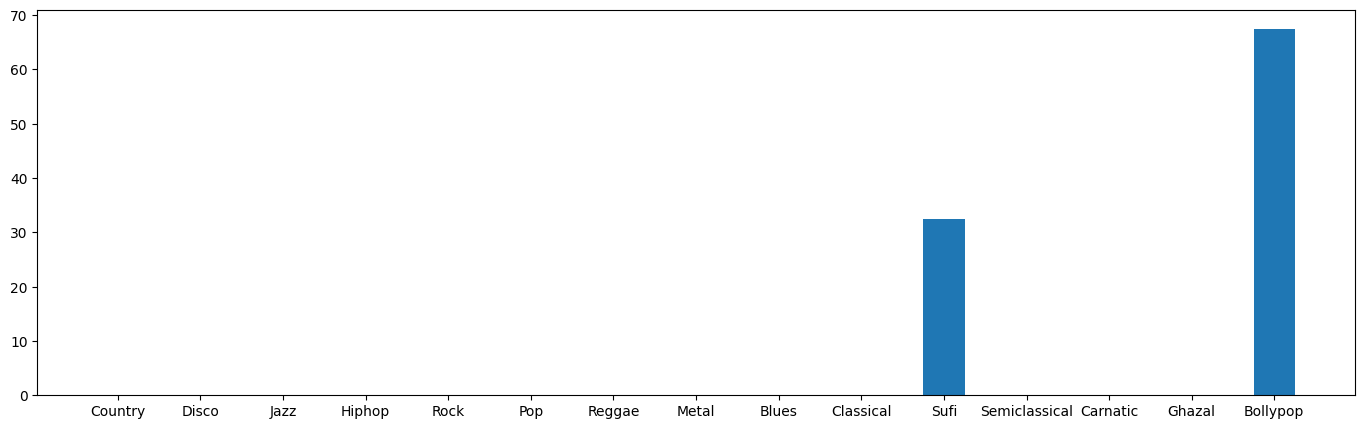

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         39.65873285
 26.10197442 34.23929274  0.        ]


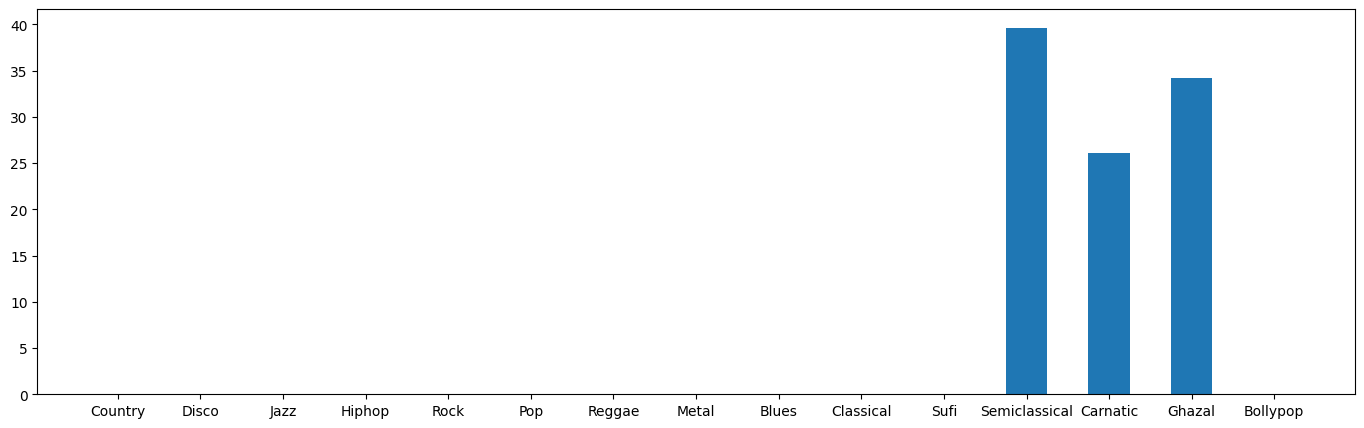

[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
   0.]


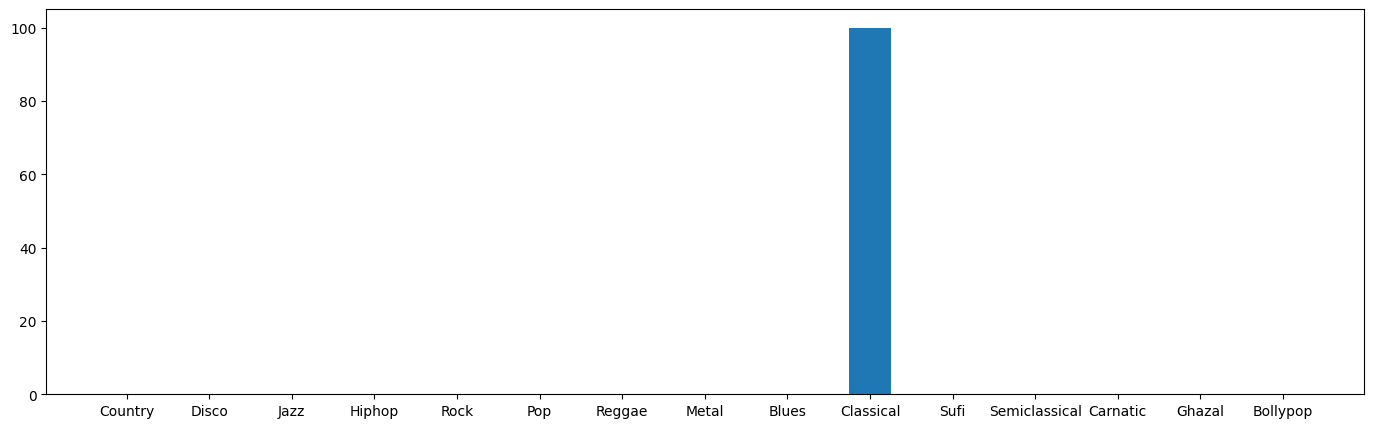

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         42.52298146  0.
  0.          0.         57.47701854]


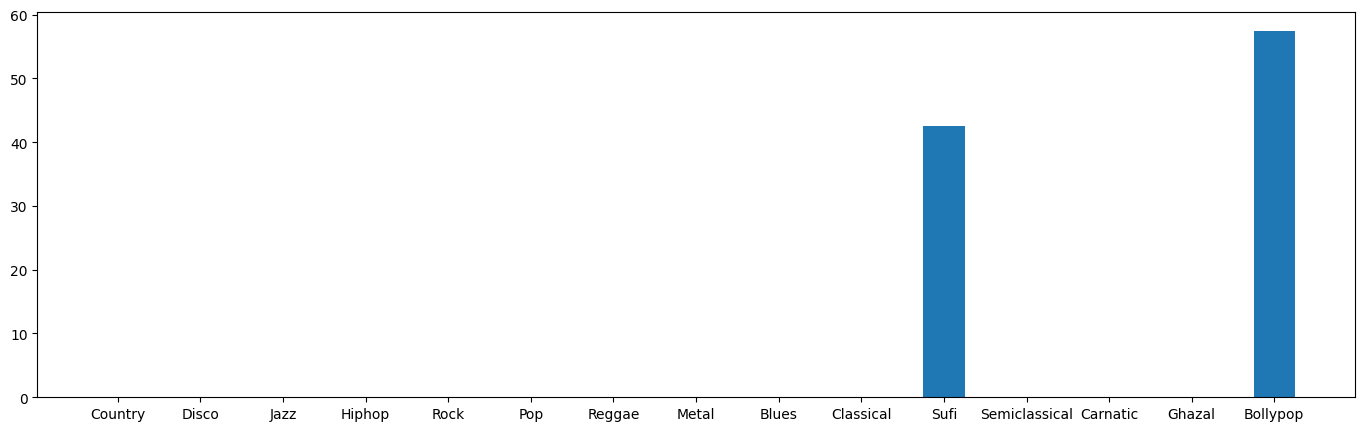

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         47.56340056  0.
  0.          0.         52.43659944]


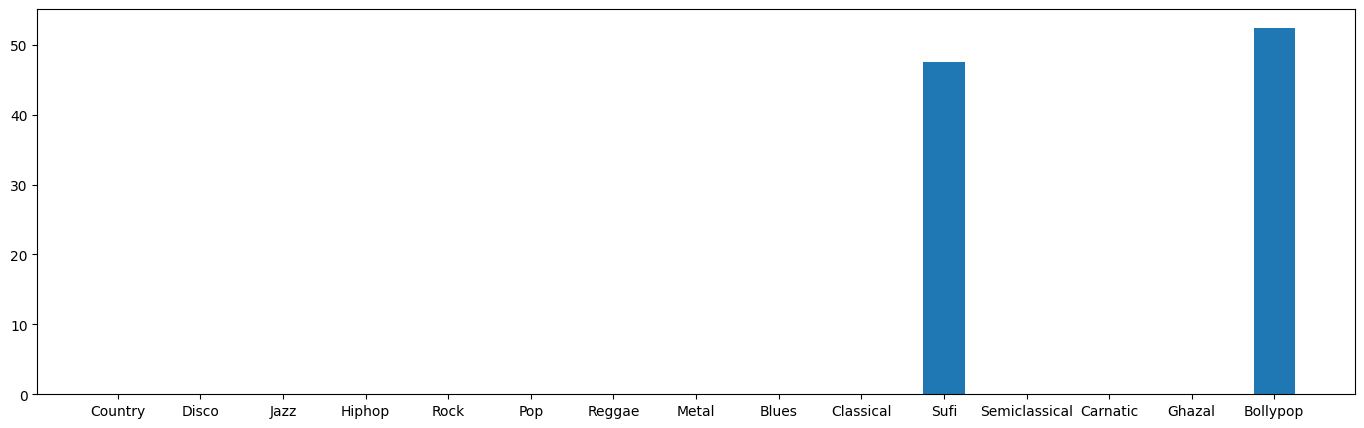

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         33.15734056 16.28443
  0.          0.         50.55822944]


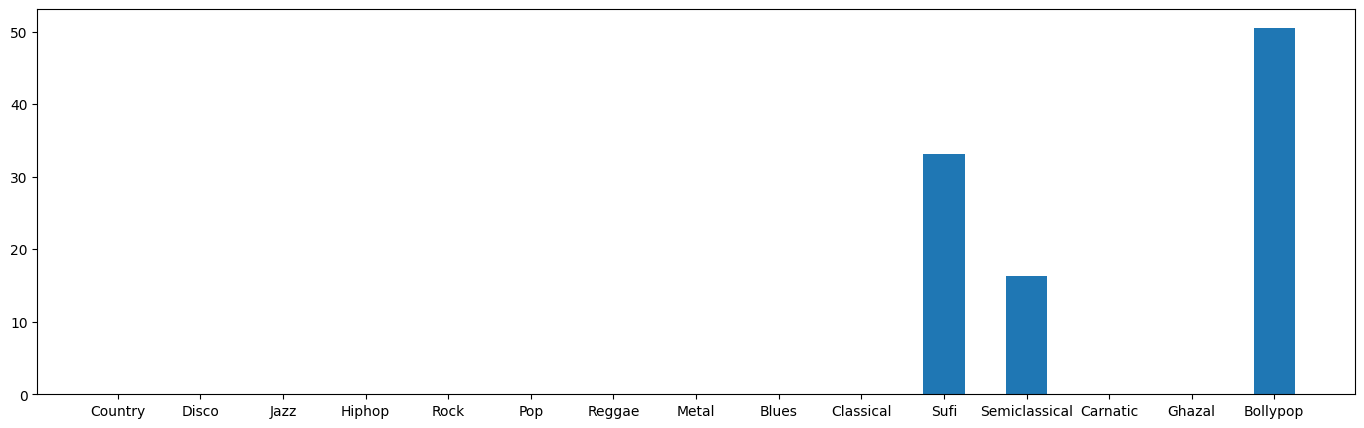

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.49845698 18.47444218
  0.          0.         63.02710084]


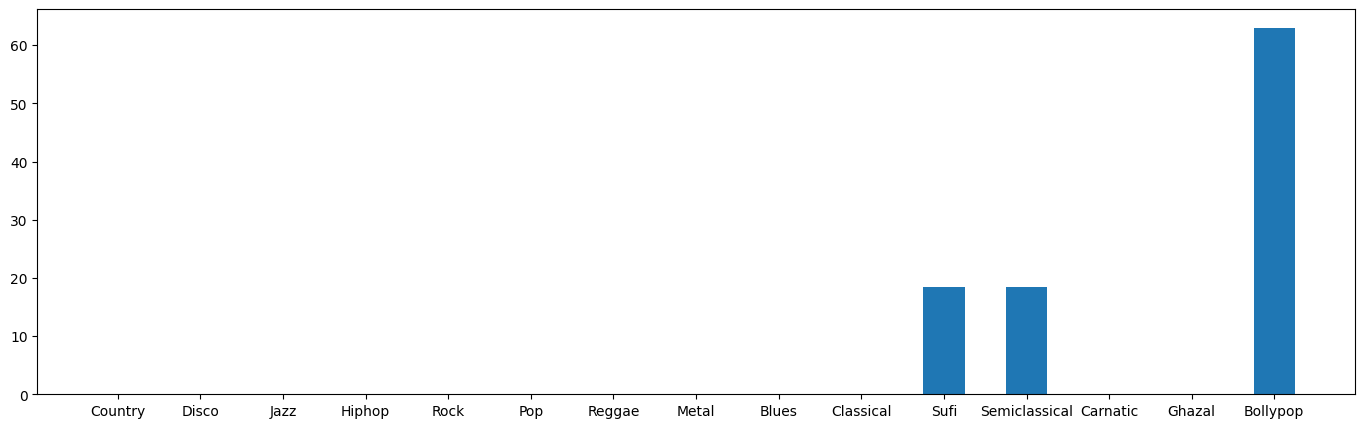

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


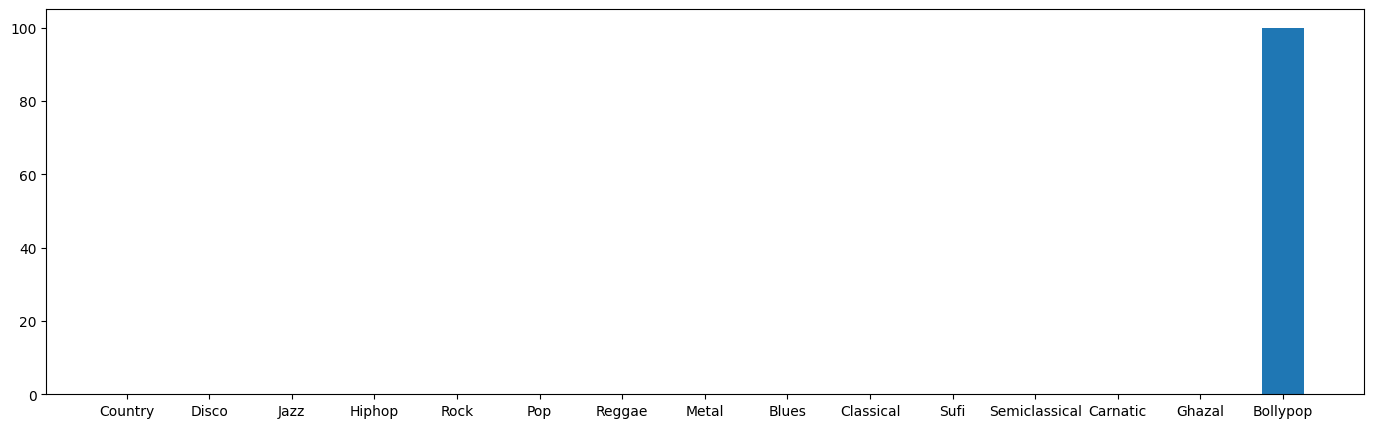

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         41.72920413  0.
  0.          0.         58.27079587]


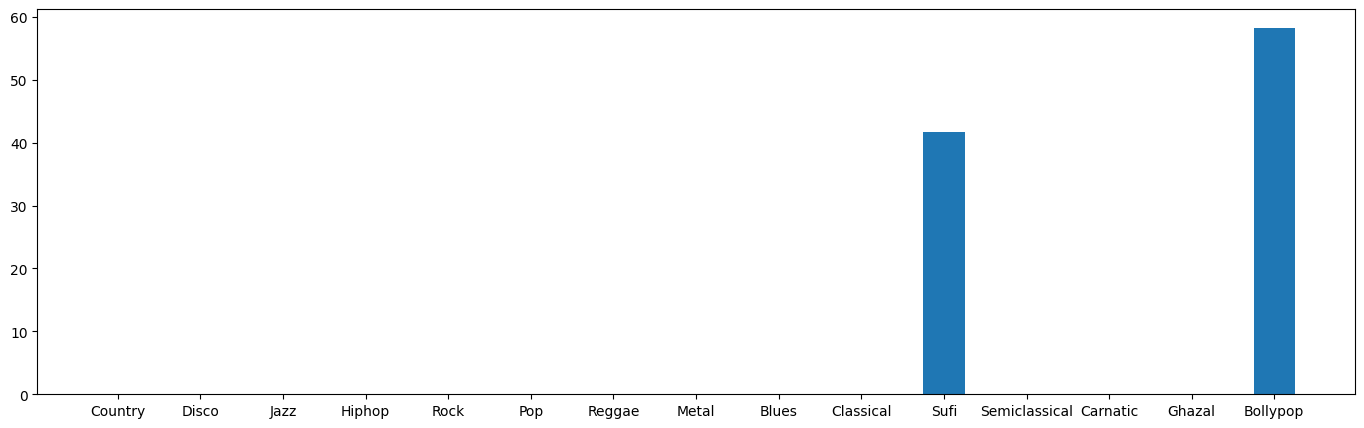

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


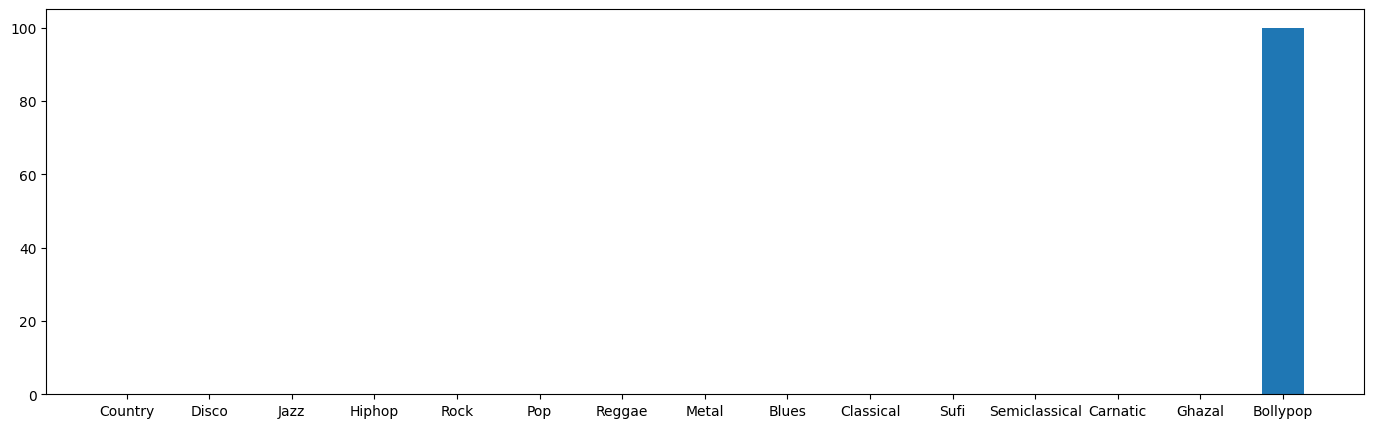

[ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        17.0521827 82.9478173
  0.         0.         0.       ]


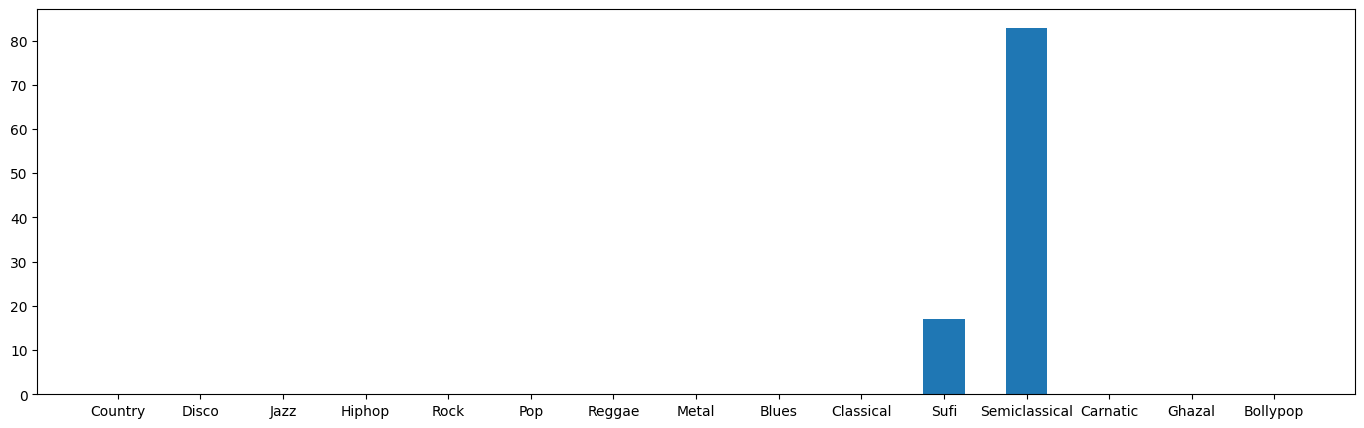

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         39.52157367 16.54433173
  0.         43.9340946   0.        ]


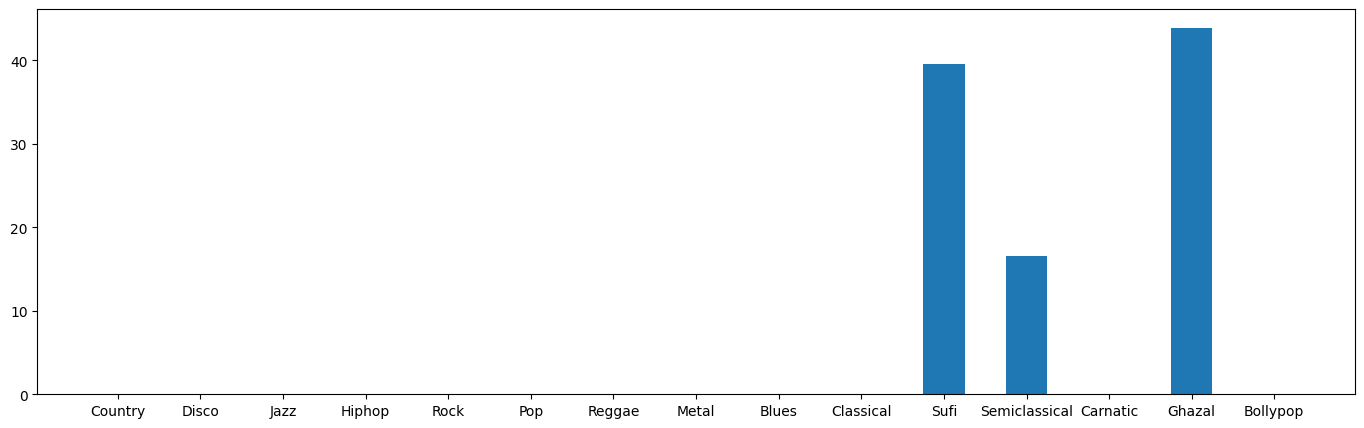

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.17391904 81.82608096
  0.          0.          0.        ]


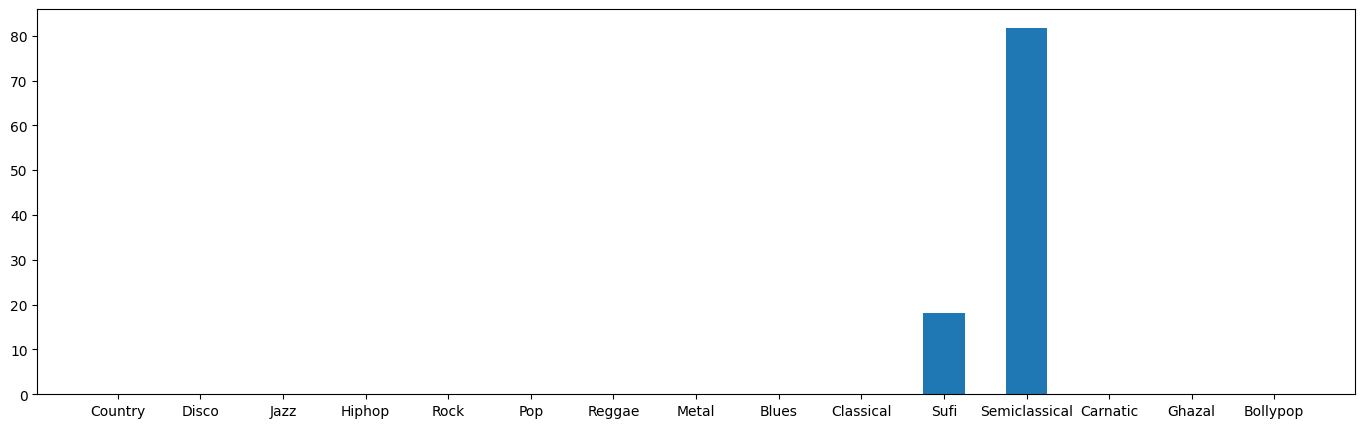

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         13.73207188  0.
 86.26792812  0.          0.        ]


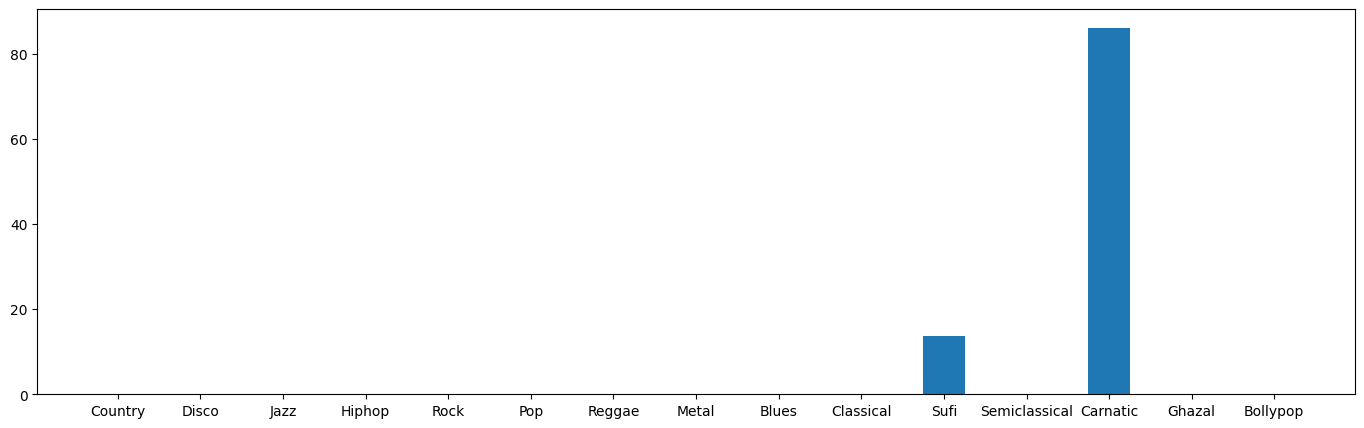

[ 0.          0.          3.46303871  0.          0.          0.
  0.          0.          0.         18.88484894 77.65211235  0.
  0.          0.          0.        ]


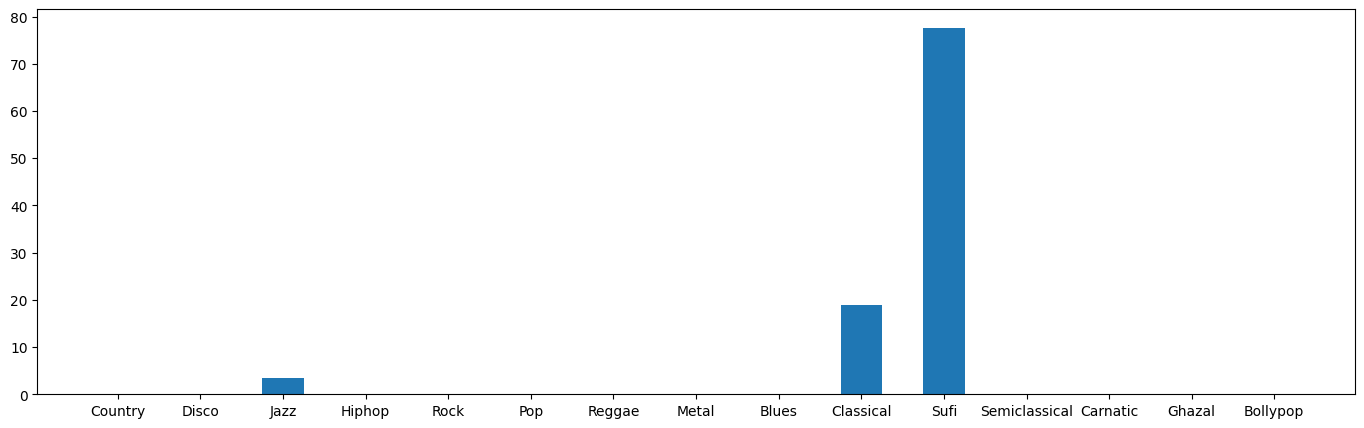

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         10.83880203 75.15253357
  0.          0.         14.00866439]


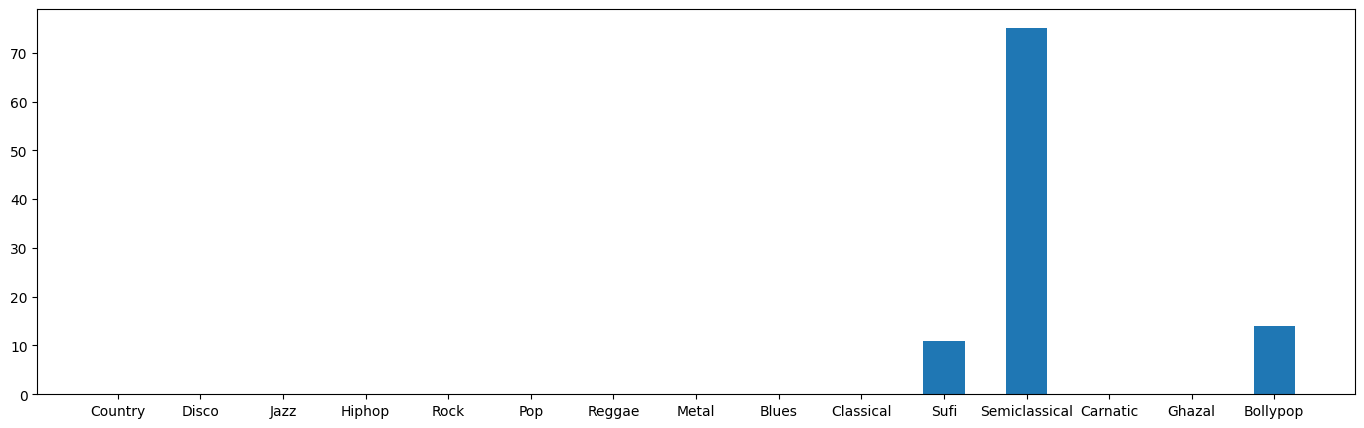

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         84.55211313
  0.          0.         15.44788687]


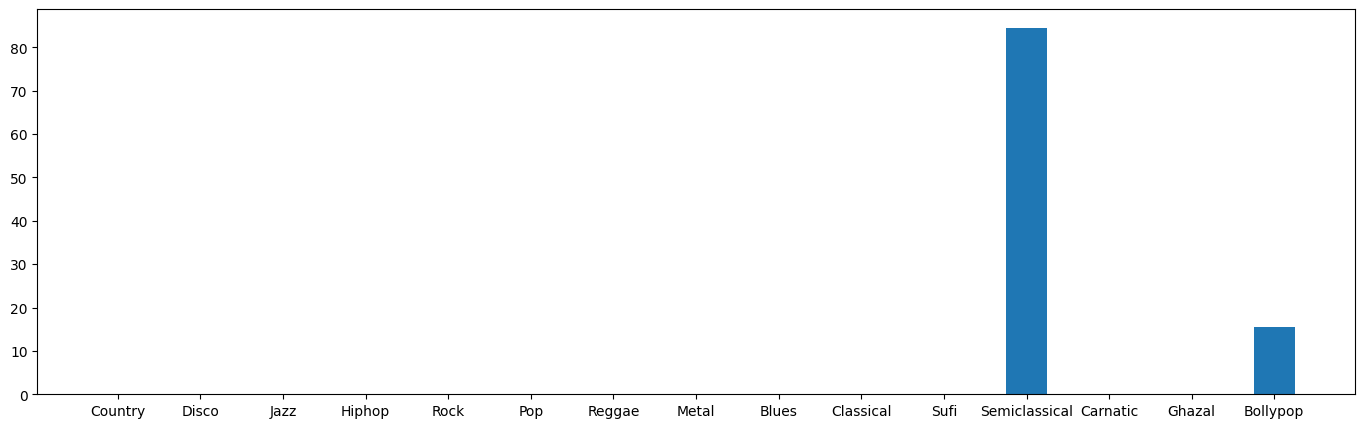

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         33.0716594  29.84543159
  0.          0.         37.08290901]


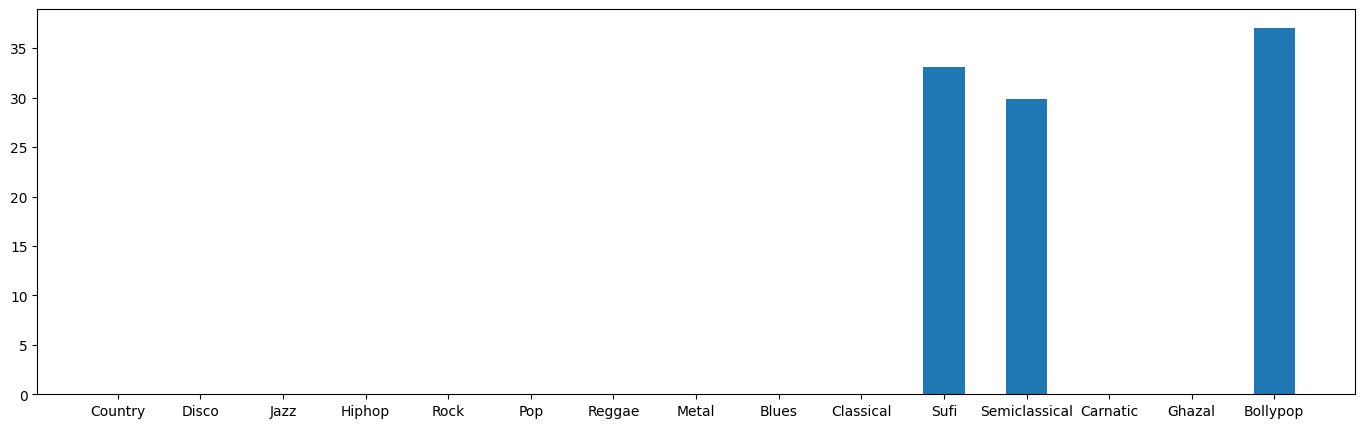

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         61.82884225  0.
  0.          0.         38.17115775]


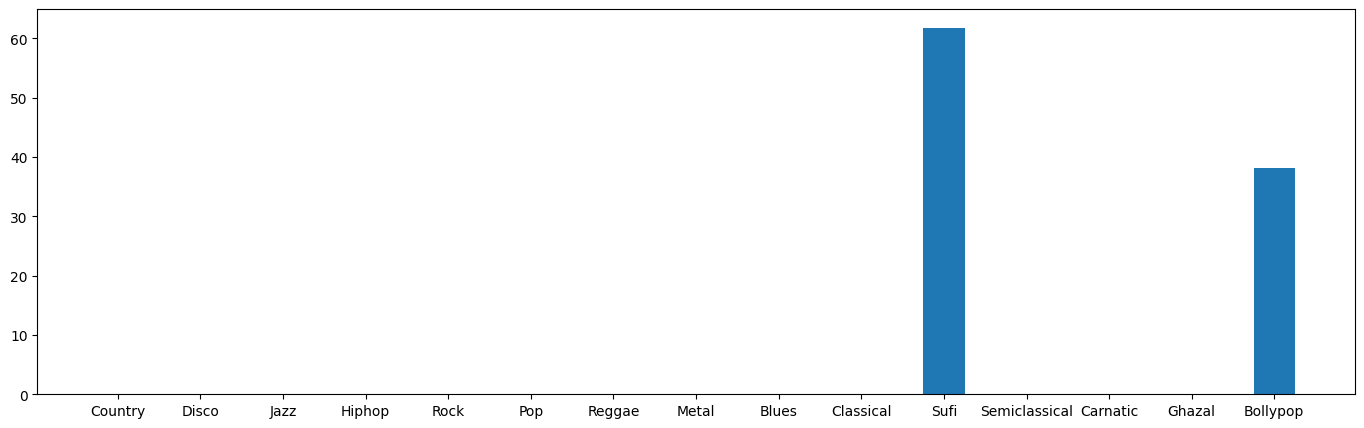

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         62.05507846 37.94492154
  0.          0.          0.        ]


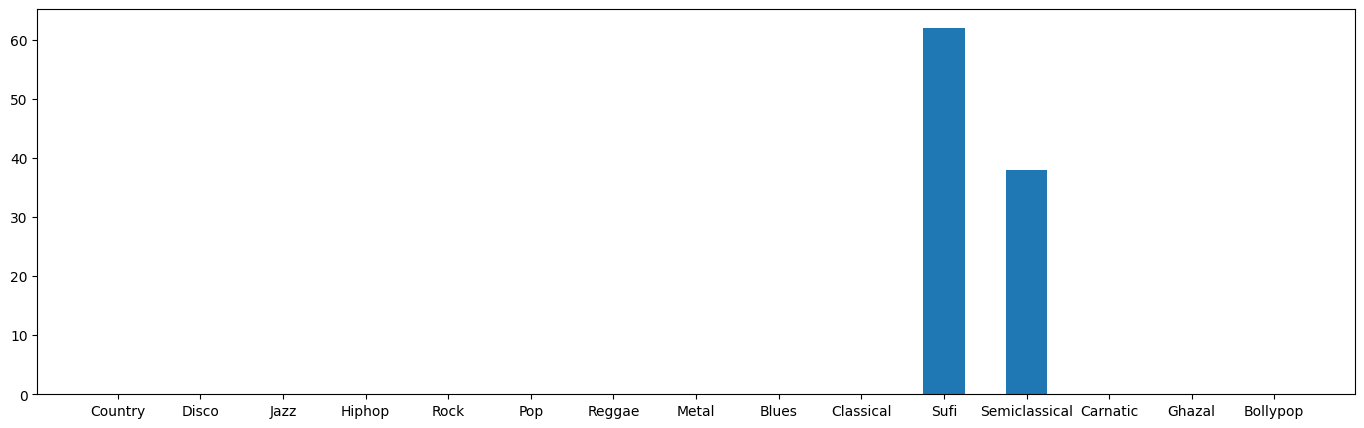

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         20.13492332  0.
  0.          0.         79.86507668]


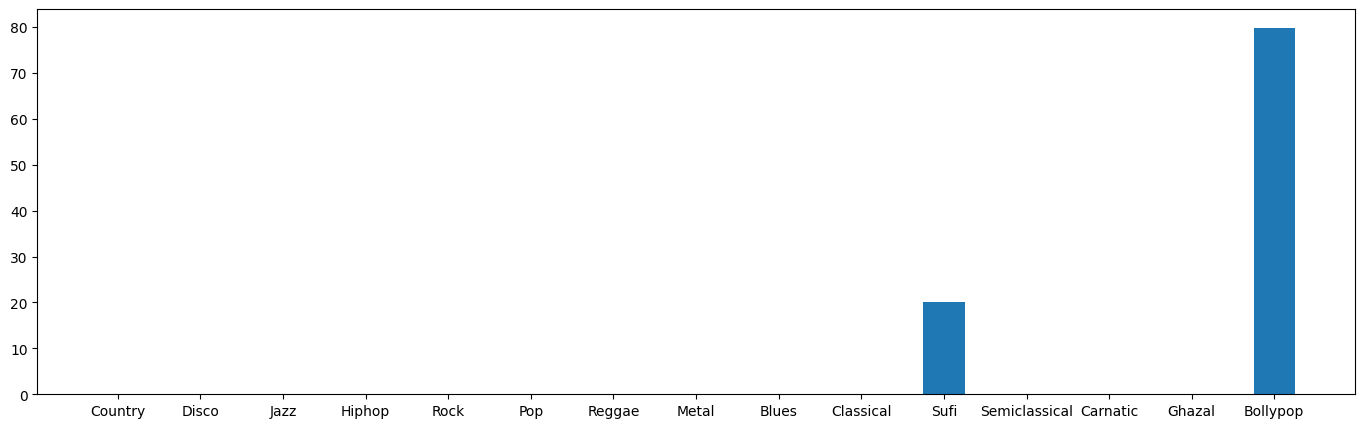

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         88.95398595
  0.          0.         11.04601405]


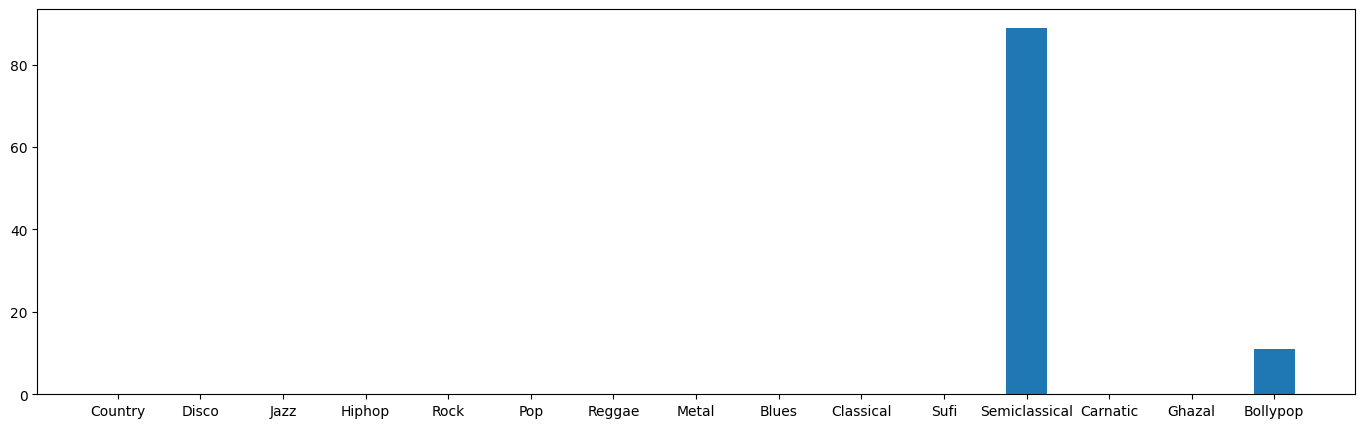

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         18.1673078
 15.39406851 50.44566716 15.99295653]


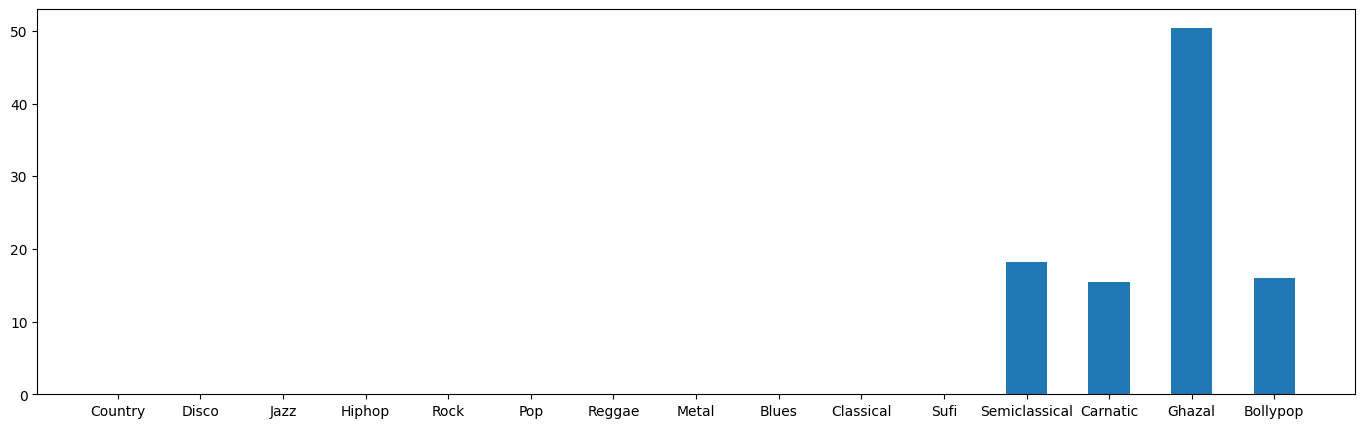

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         47.8135326
  0.         15.43728527 36.74918213]


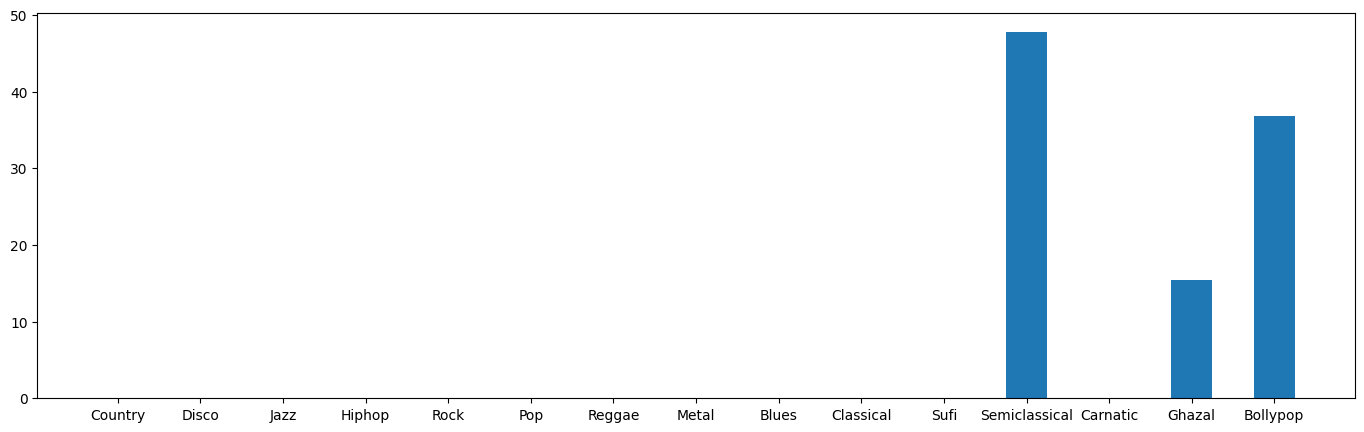

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         63.46598271 16.68141732
  0.          0.         19.85259997]


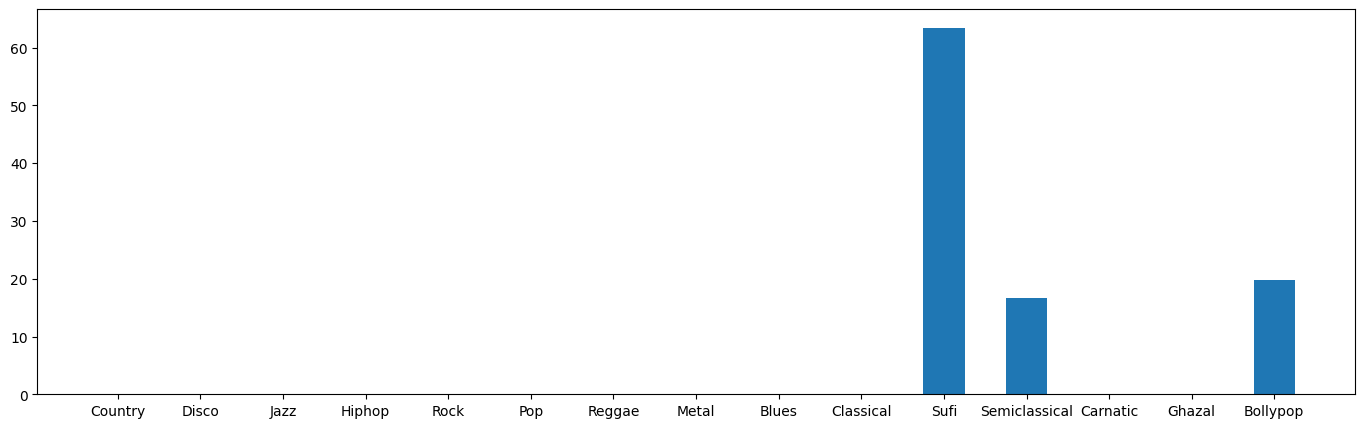

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         10.31032153 56.5187882
 19.4035316   0.         13.76735867]


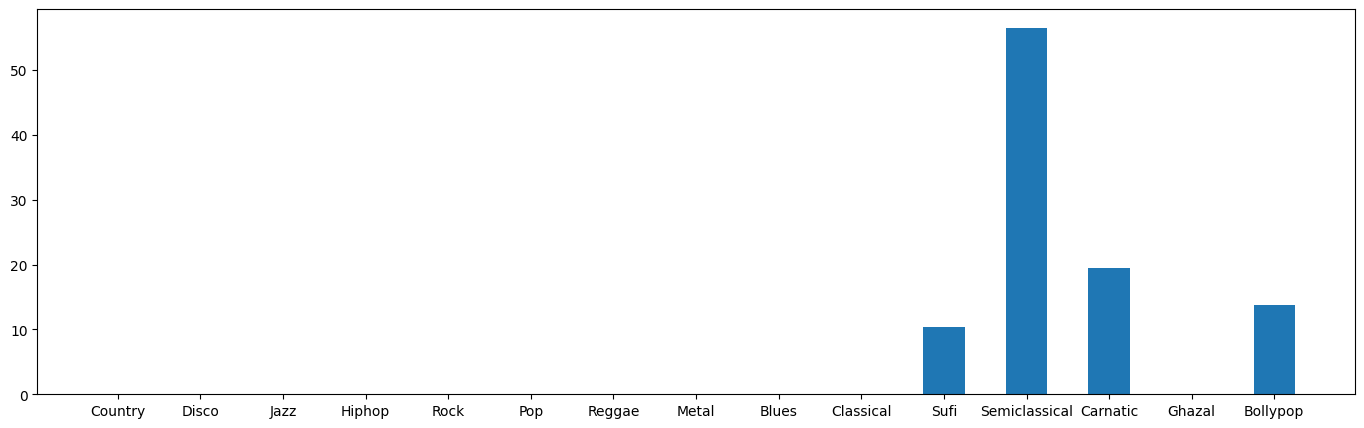

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.       18.513869  0.        0.
 81.486131]


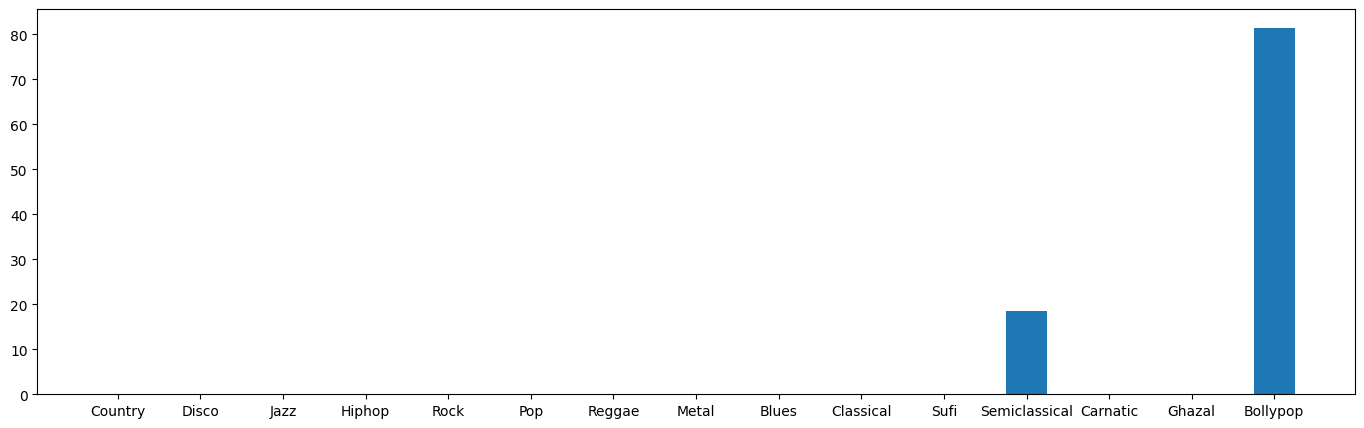

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         73.59150056
  8.62307708 17.78542236  0.        ]


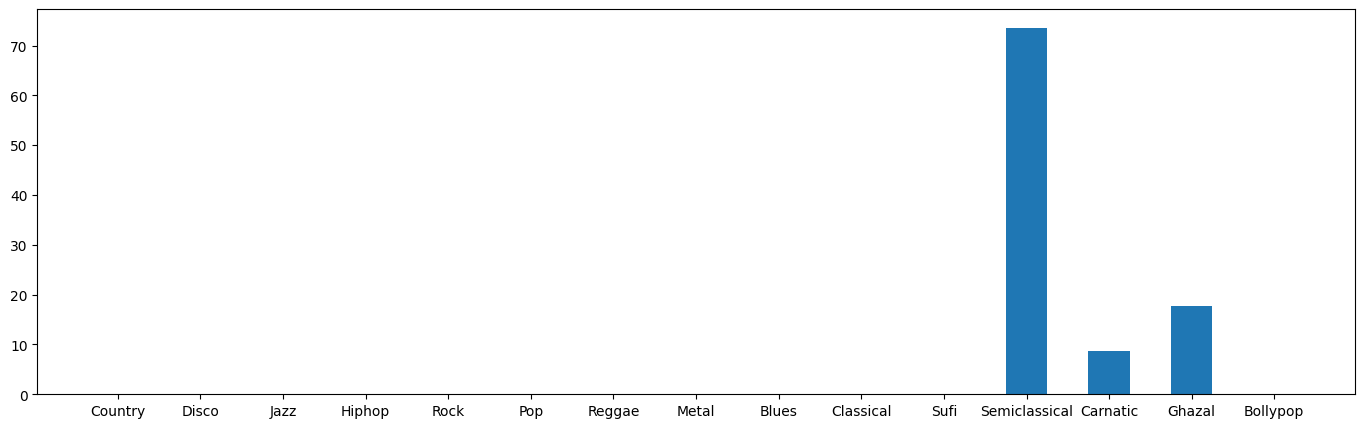

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         55.02512573
  0.         13.42426955 31.55060472]


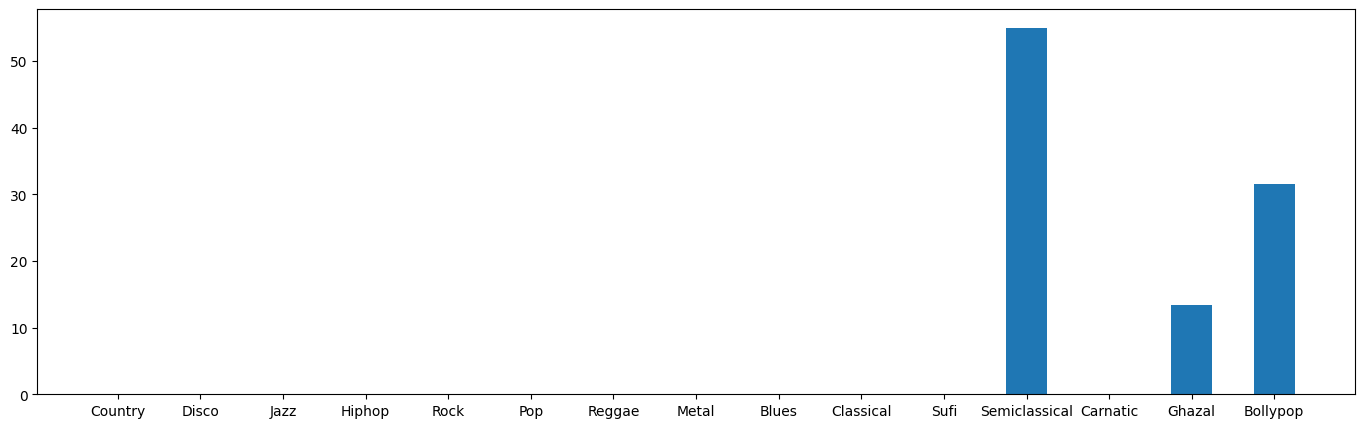

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         25.9220613   0.
 63.17970445 10.89823425  0.        ]


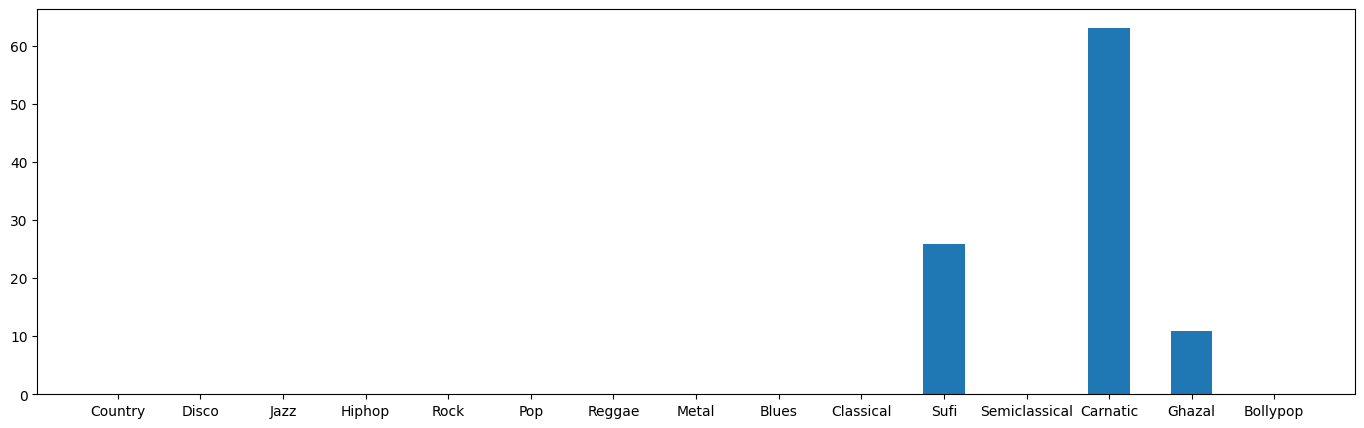

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         72.79374957
  0.          0.         27.20625043]


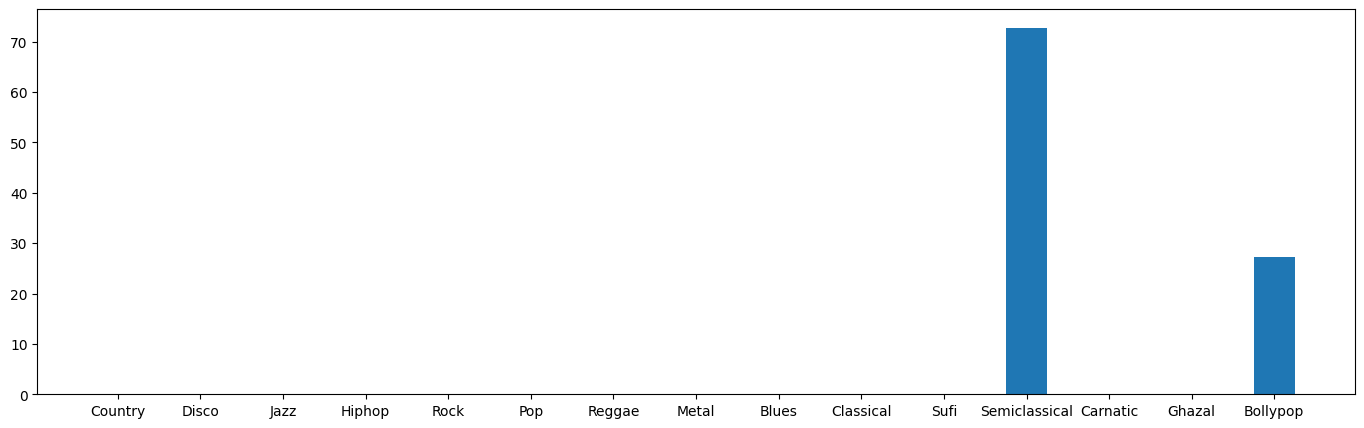

[ 0.          0.          0.          0.          0.          0.
  0.          0.         18.29373734  0.         32.06211185  0.
 15.60463963 34.03951118  0.        ]


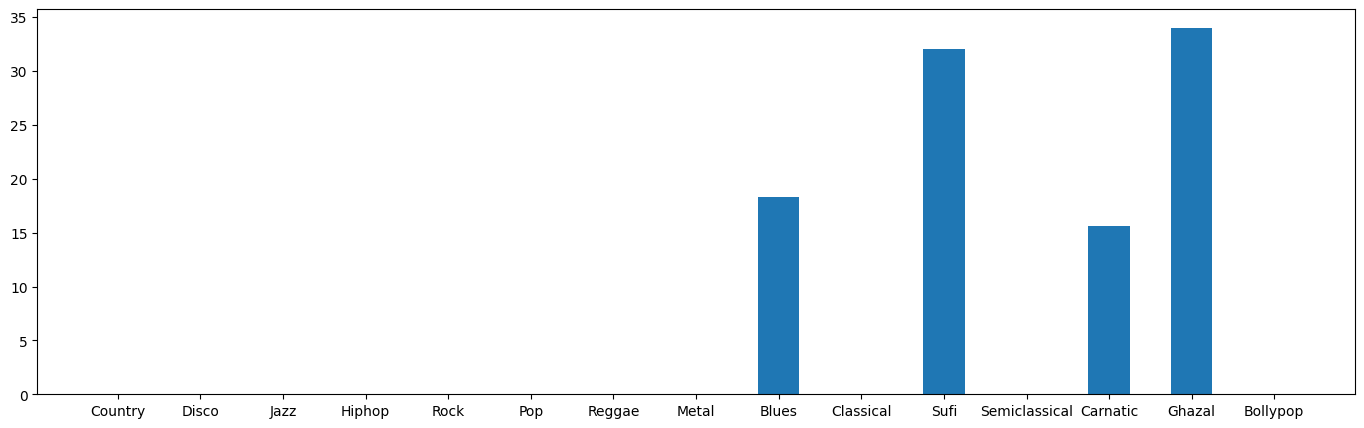

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 44.43080816 55.56919184  0.        ]


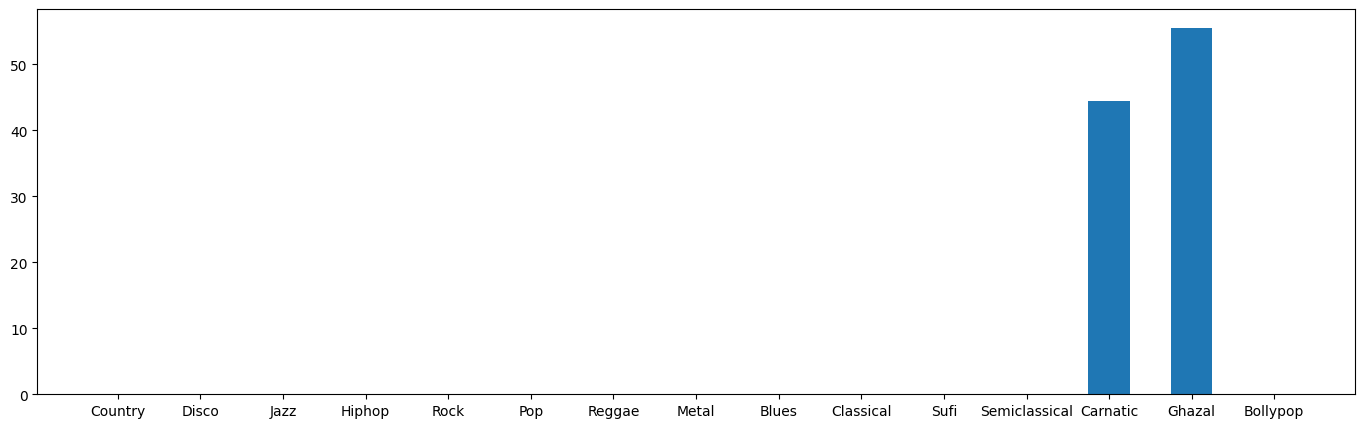

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         38.10779737  0.
 26.08881455 35.80338808  0.        ]


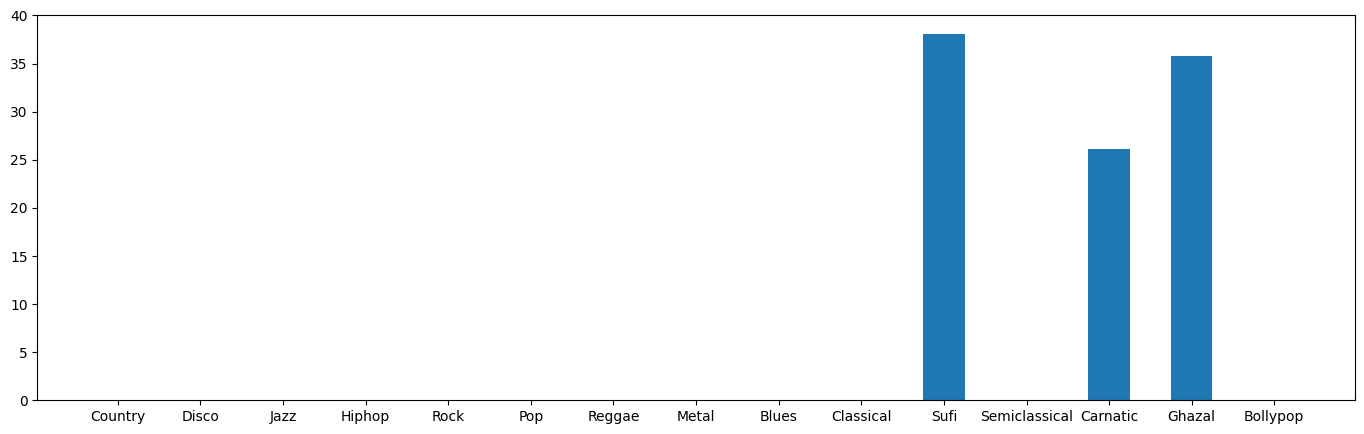

[ 8.8221738   0.          0.          0.          5.91618314  0.
  6.2085571   0.          5.7917731   0.          0.          0.
 73.26131286  0.          0.        ]


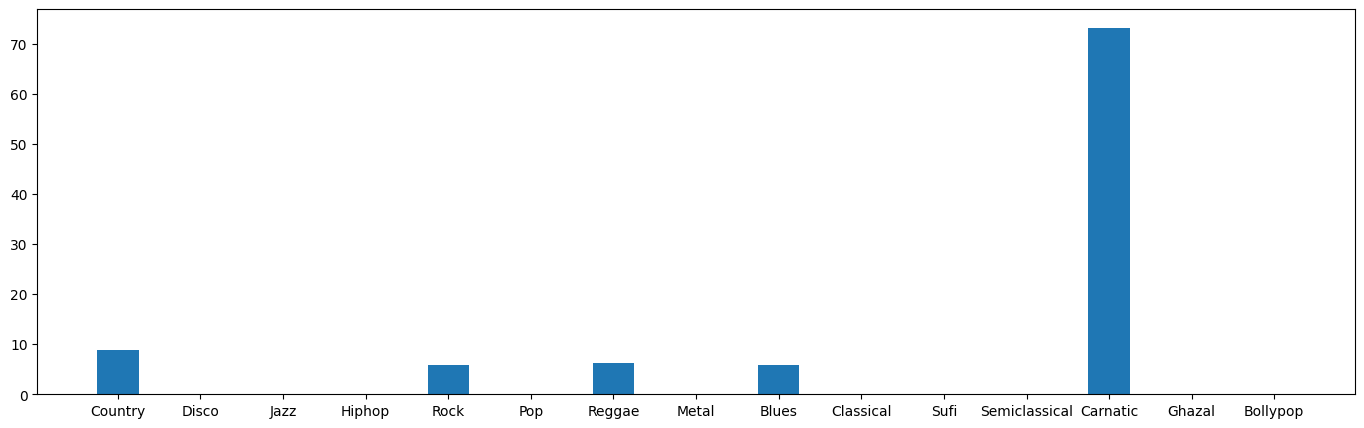

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         42.78482986  0.
  0.          0.         57.21517014]


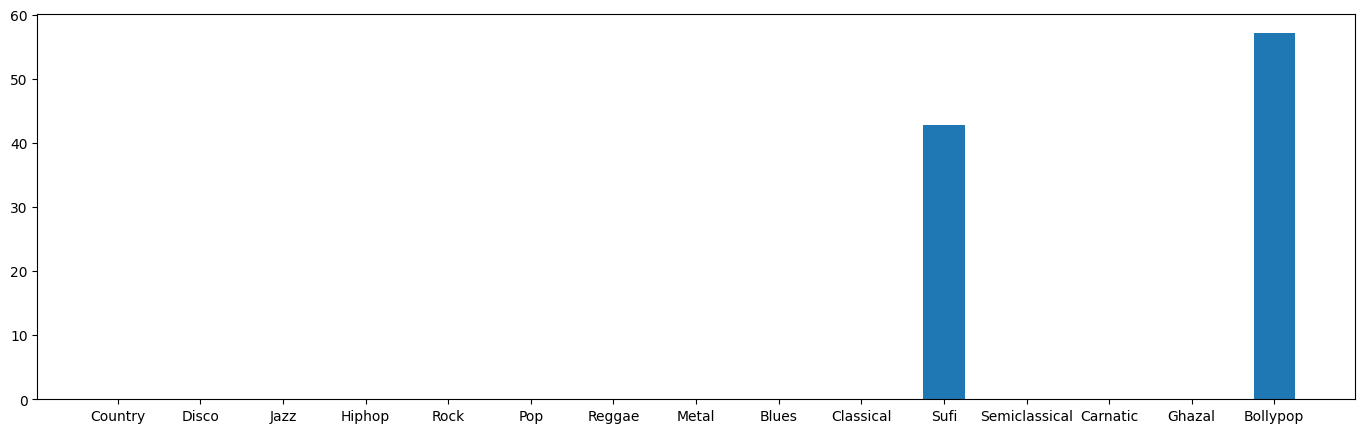

[ 0.          0.          0.         11.77383935 11.78039057  0.
  0.          0.         12.67552472  0.          0.          0.
 63.77024536  0.          0.        ]


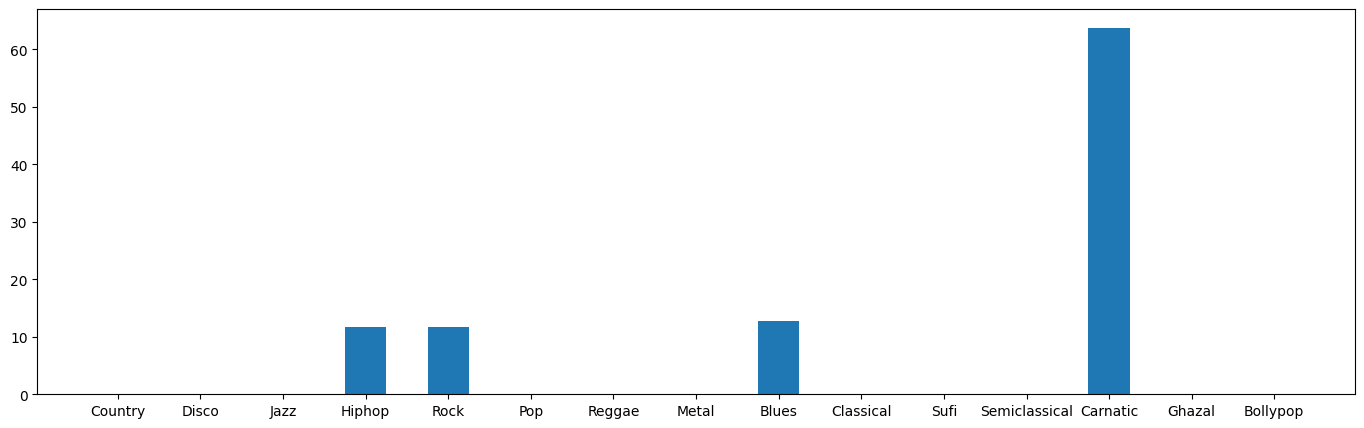

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         59.20434343  0.
  0.          0.         40.79565657]


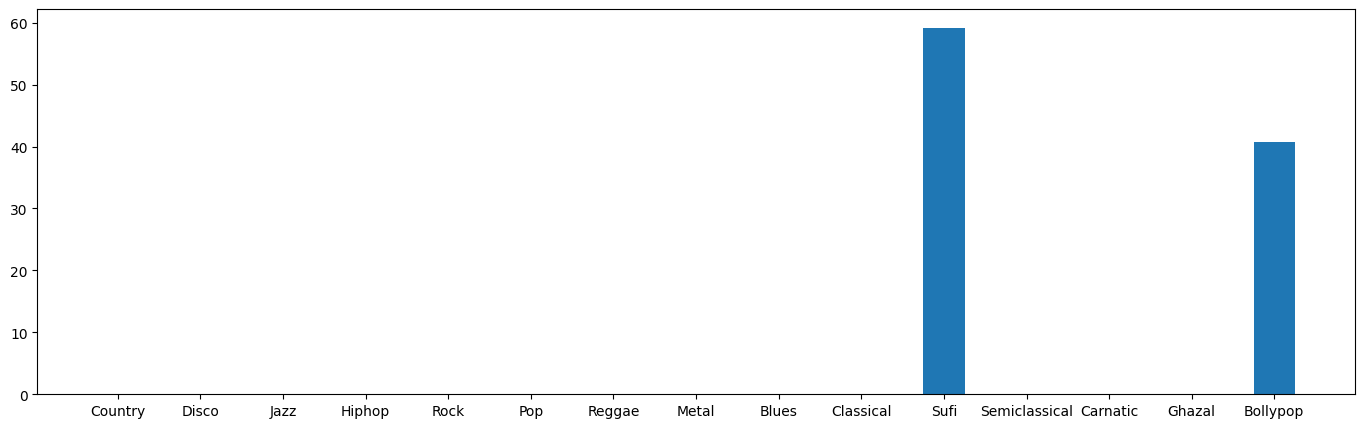

[10.03144513  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         10.58159898
 79.38695589  0.          0.        ]


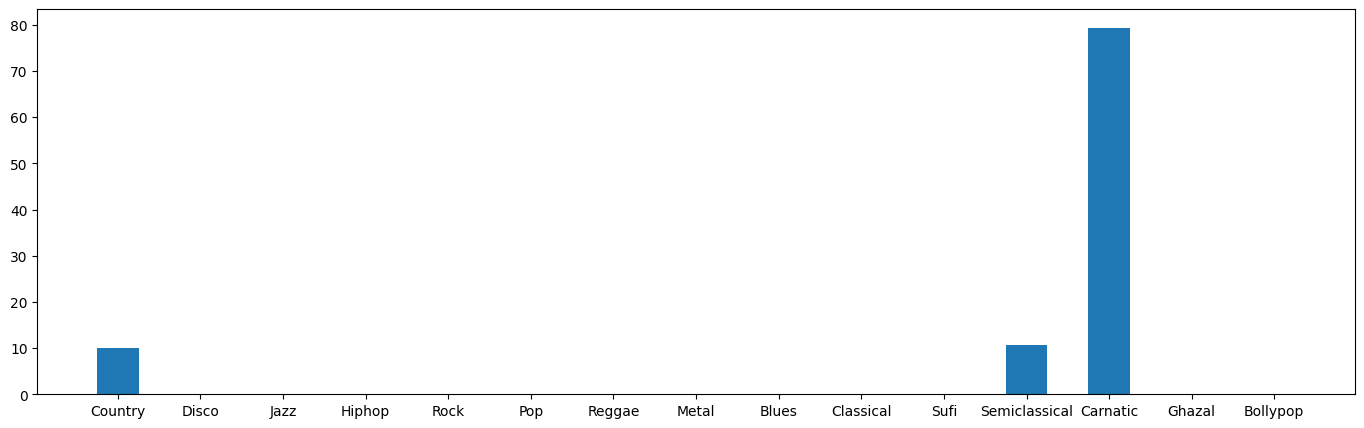

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


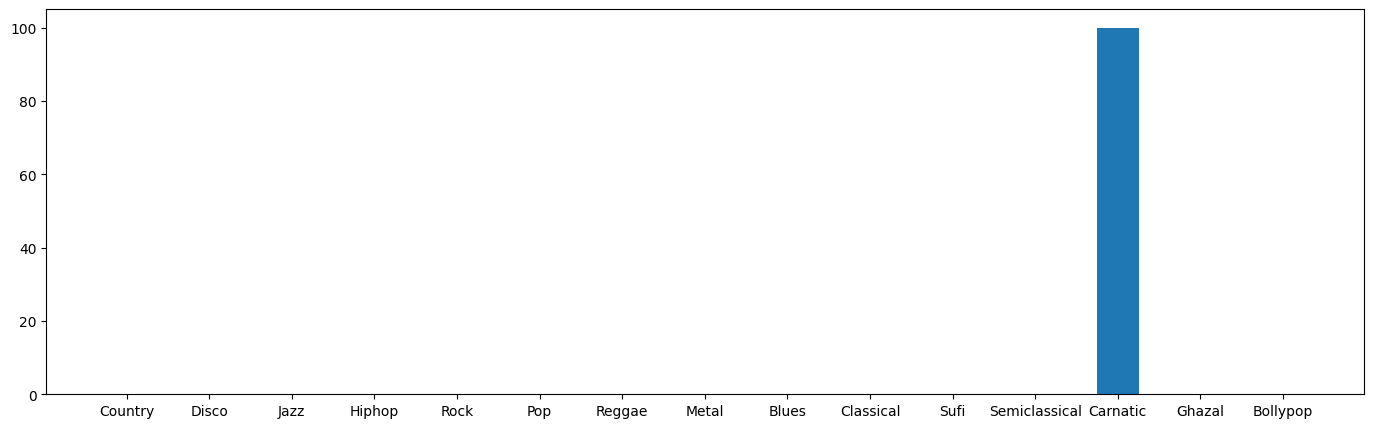

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


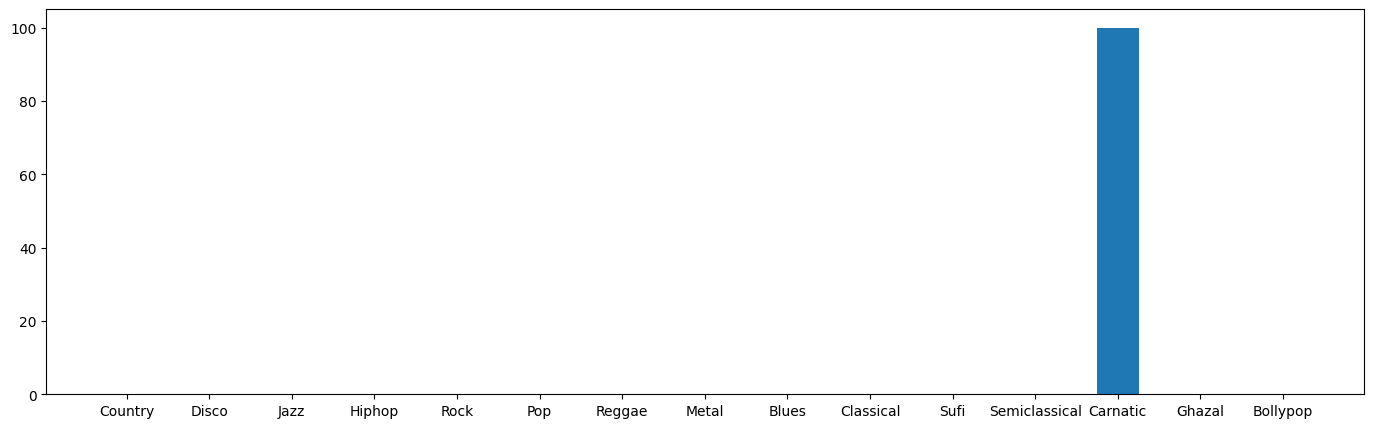

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


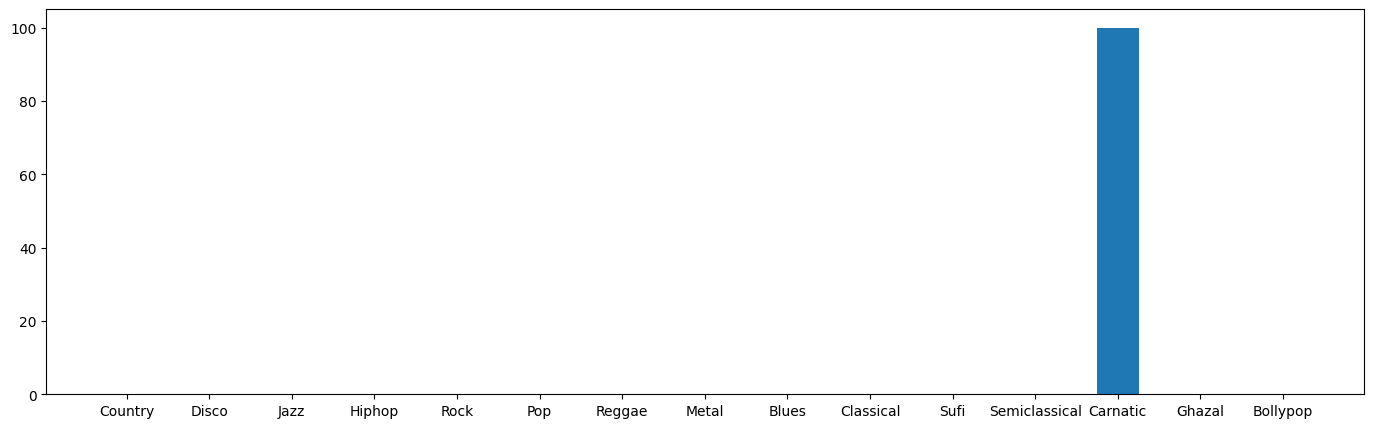

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         15.99815998  0.
 40.80704409 43.19479593  0.        ]


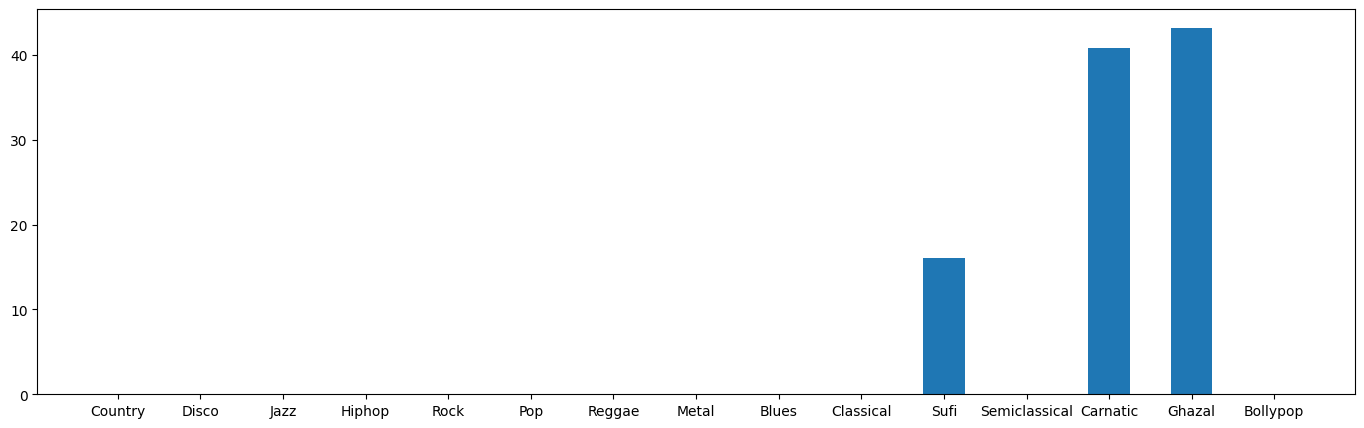

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 72.71710813  0.         27.28289187]


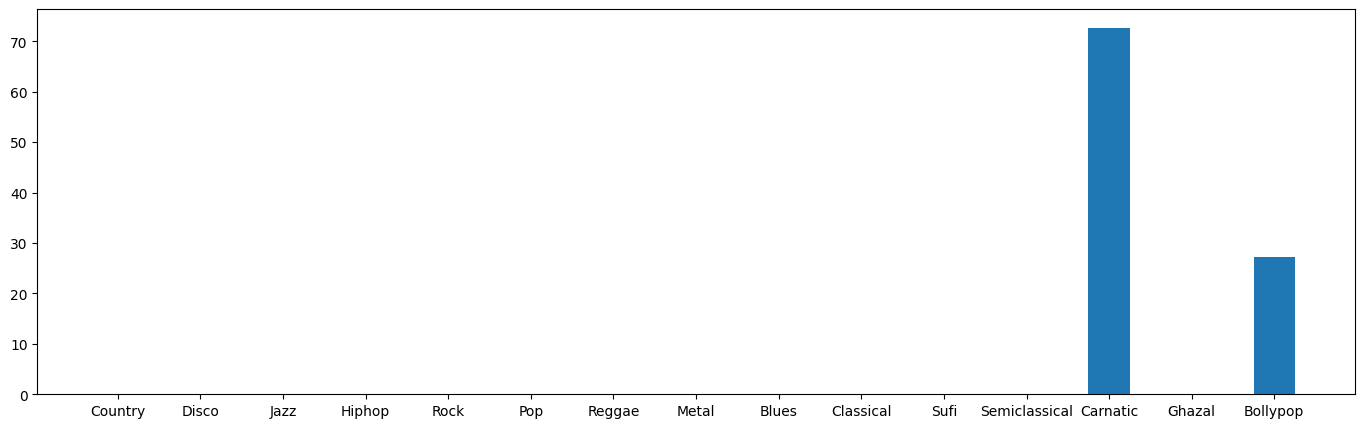

[13.44007231  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 86.55992769  0.          0.        ]


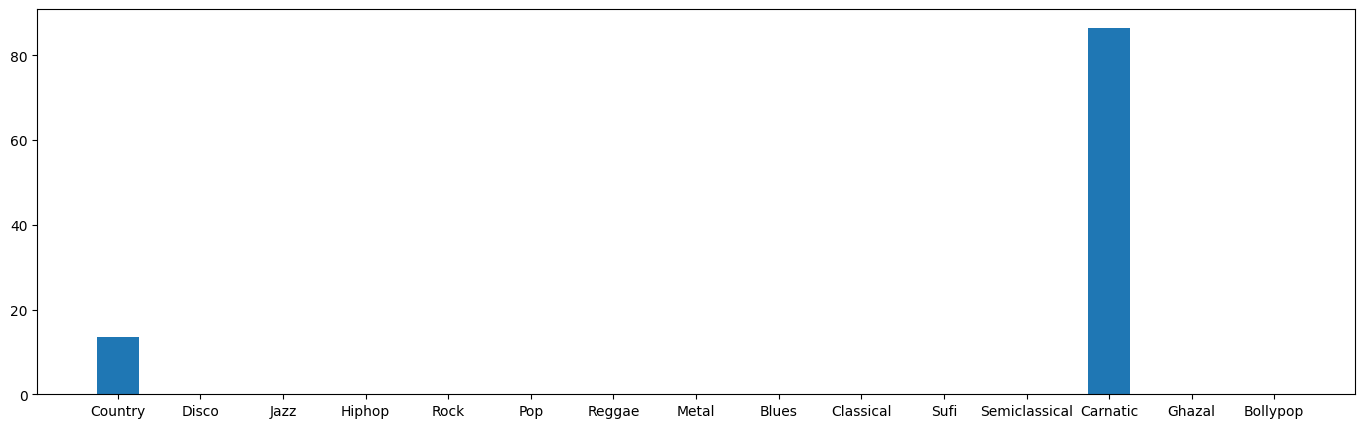

[10.57893862  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 89.42106138  0.          0.        ]


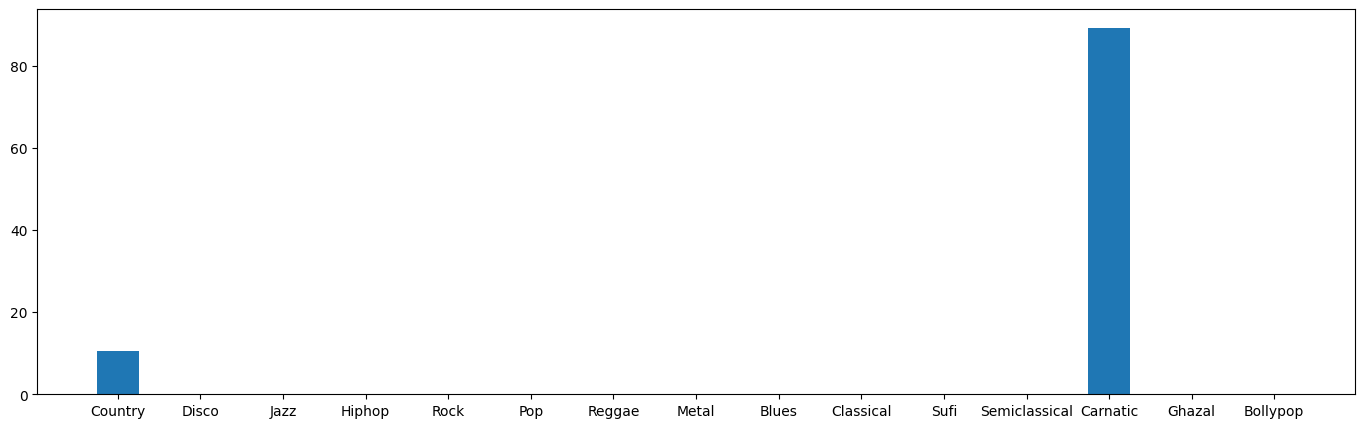

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


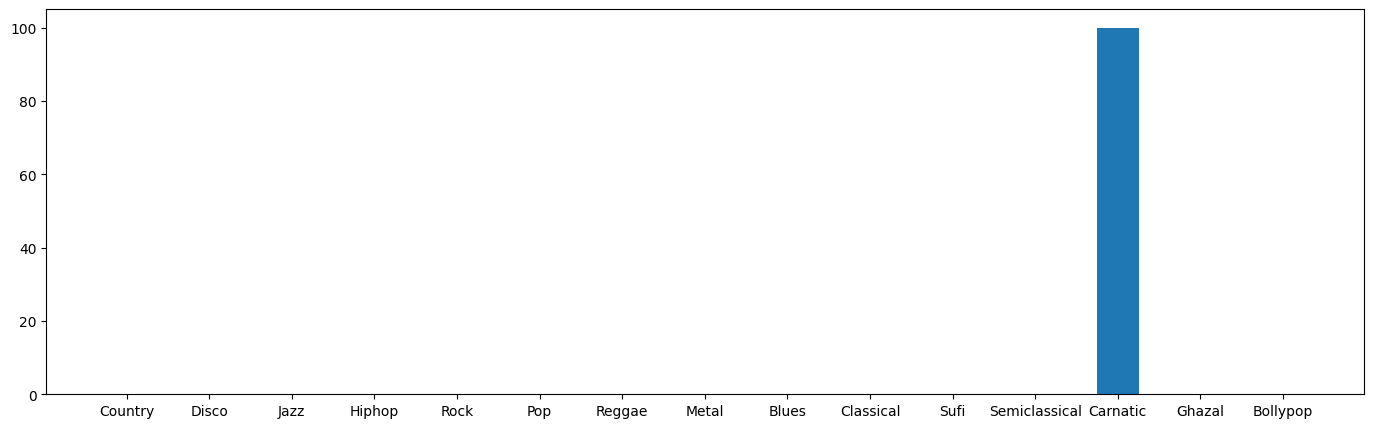

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         22.78895348  0.
 18.22200944 20.8335585  38.15547858]


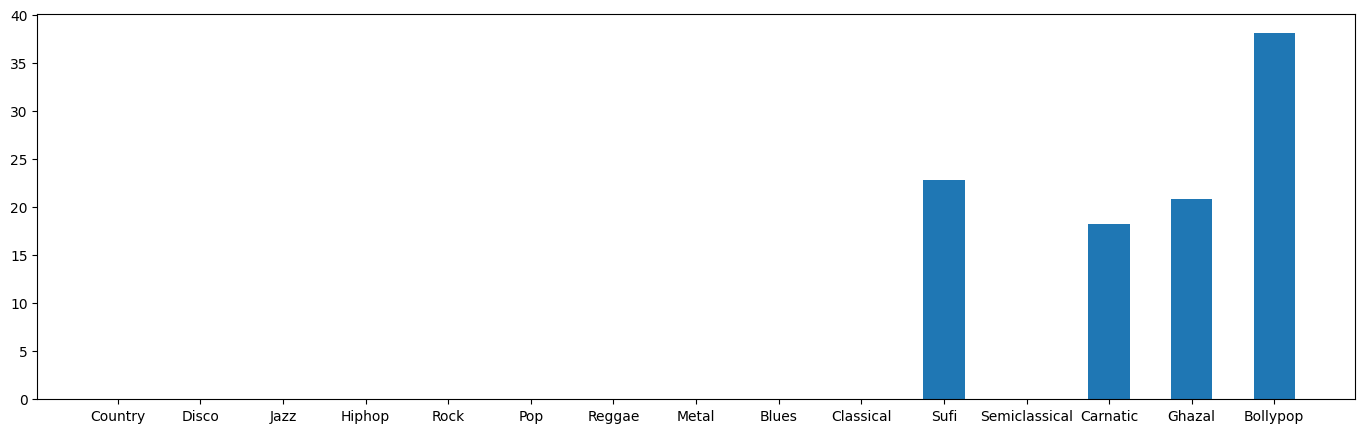

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


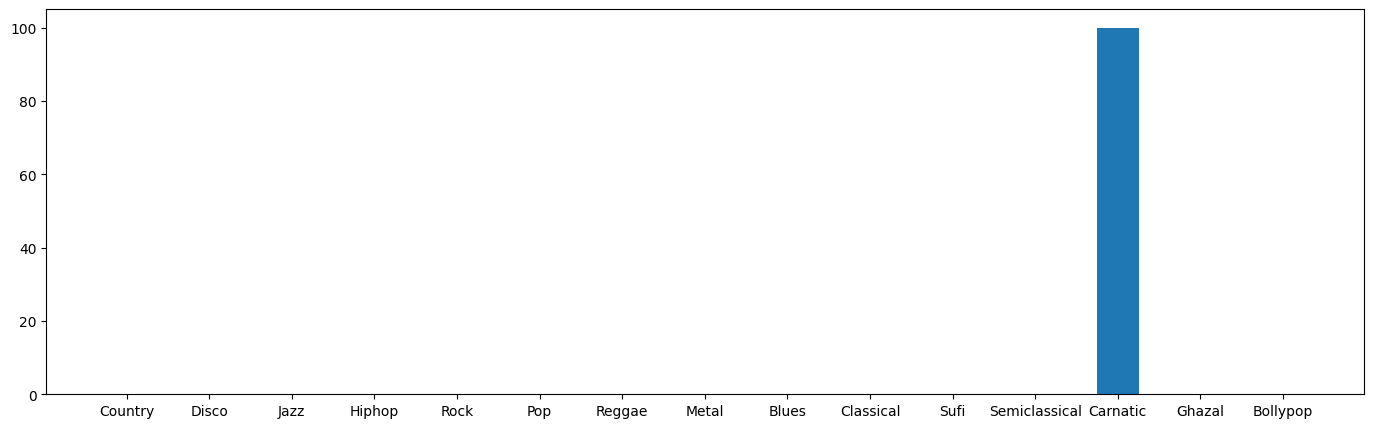

[ 3.07918103  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 96.92081897  0.          0.        ]


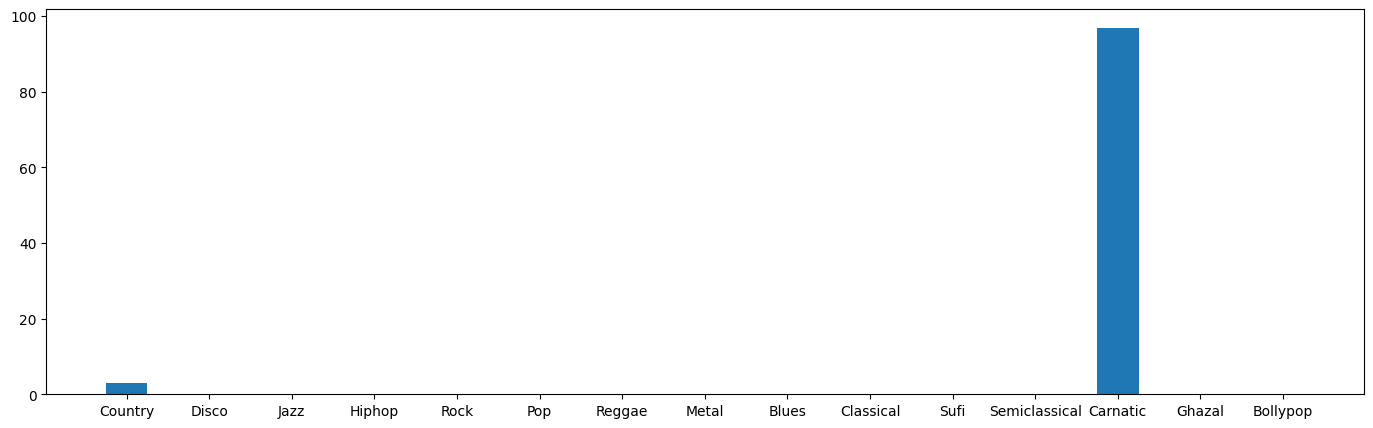

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          2.89170374  5.10631988  0.
 88.99904162  3.00293475  0.        ]


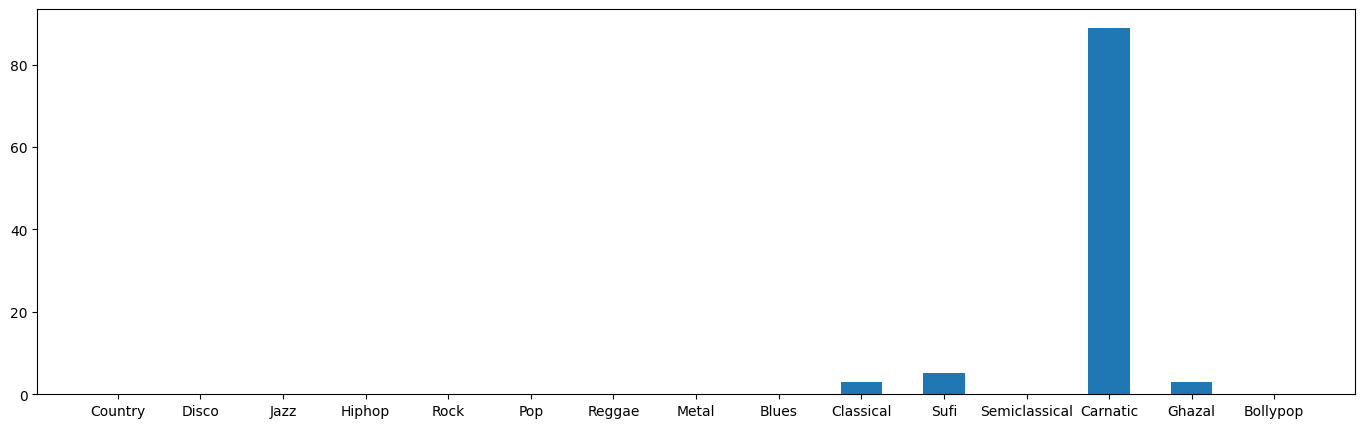

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         56.20362232  4.5270413
 39.26933638  0.          0.        ]


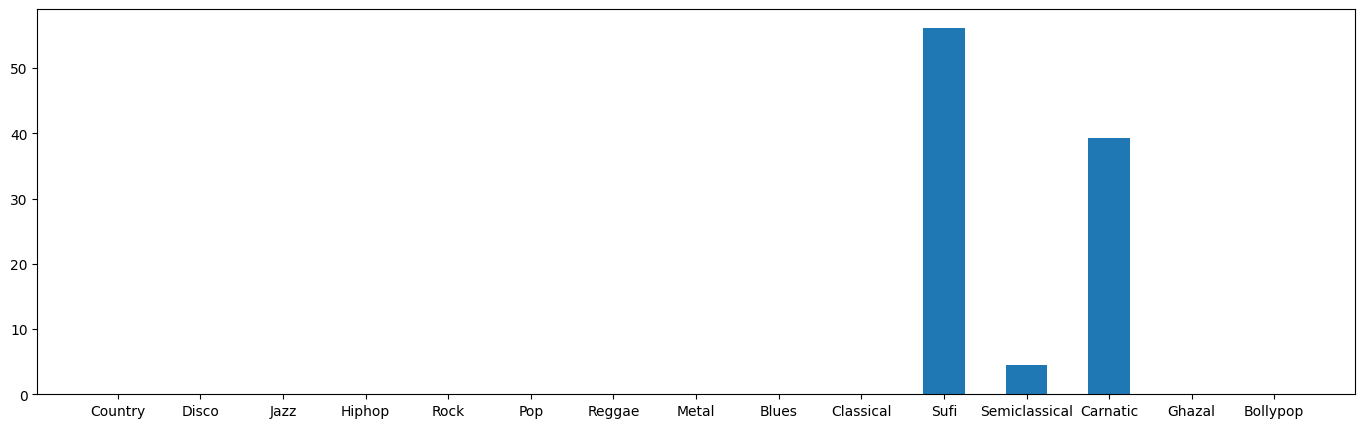

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


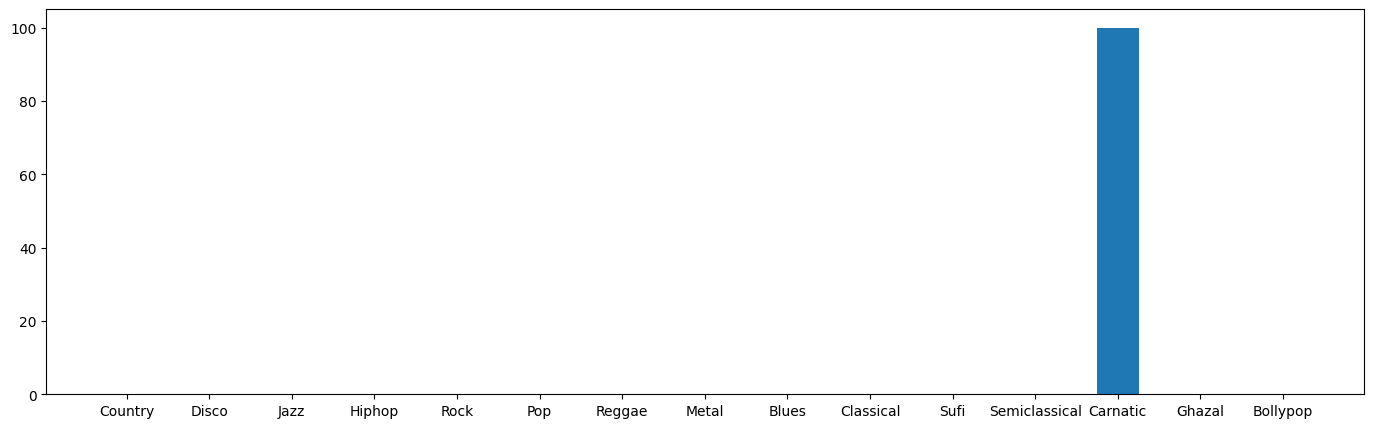

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


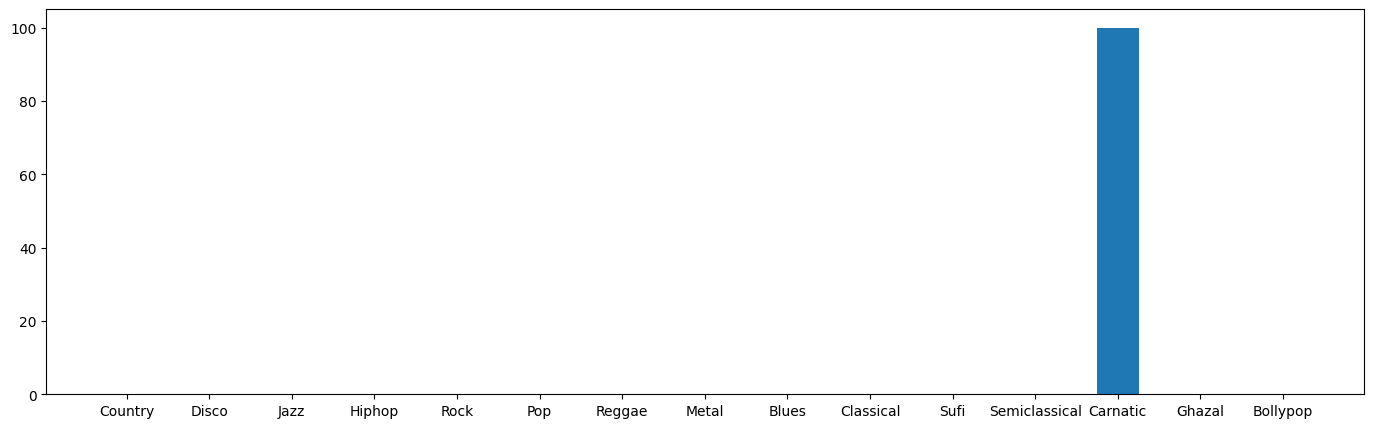

[ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.0124433
 98.9875567  0.         0.       ]


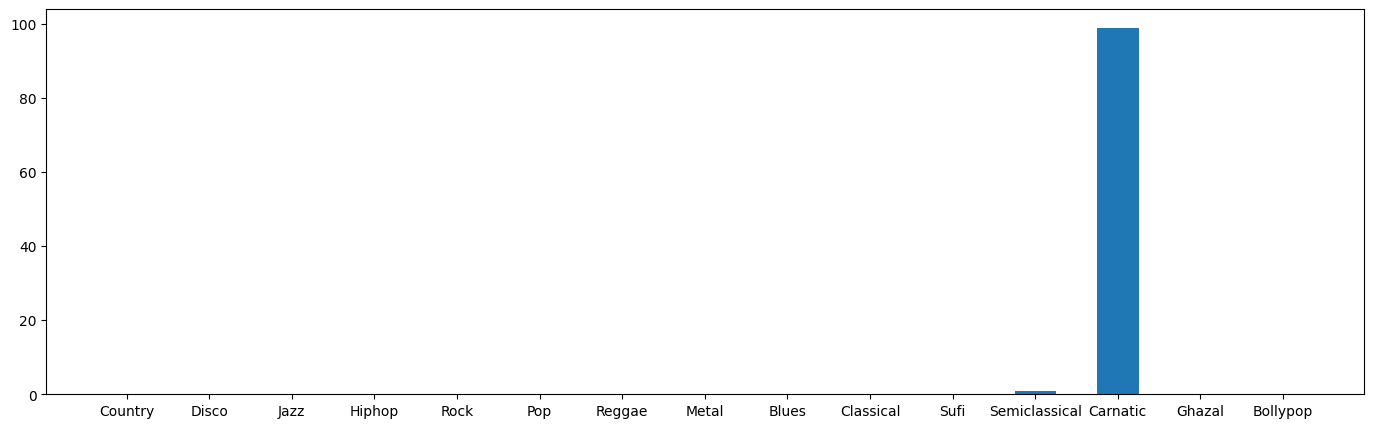

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.13667877
 98.86332123  0.          0.        ]


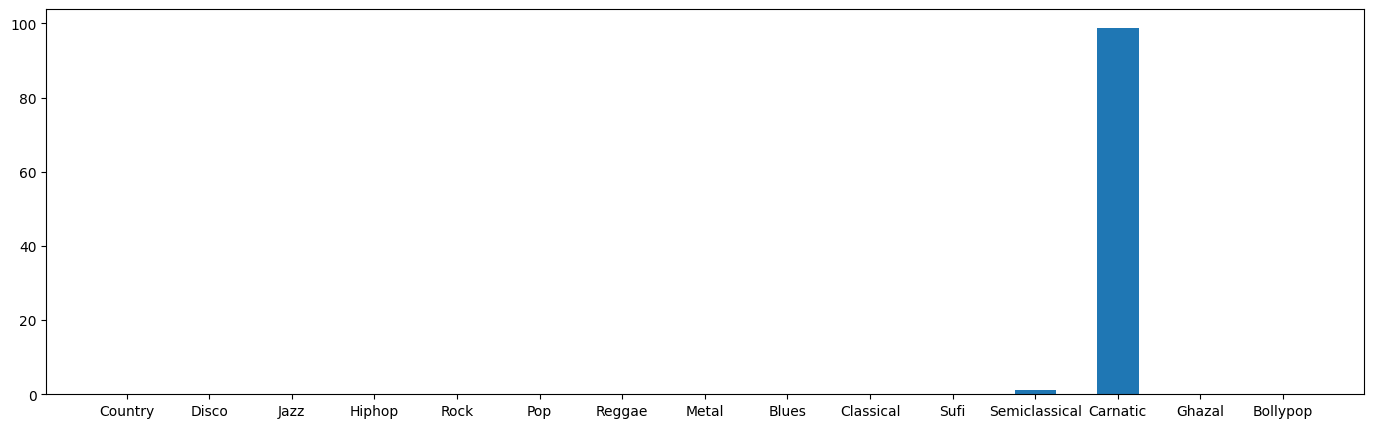

[ 0.          0.          0.          0.          0.          0.
  0.          0.          7.47678154  0.          0.          0.
 92.52321846  0.          0.        ]


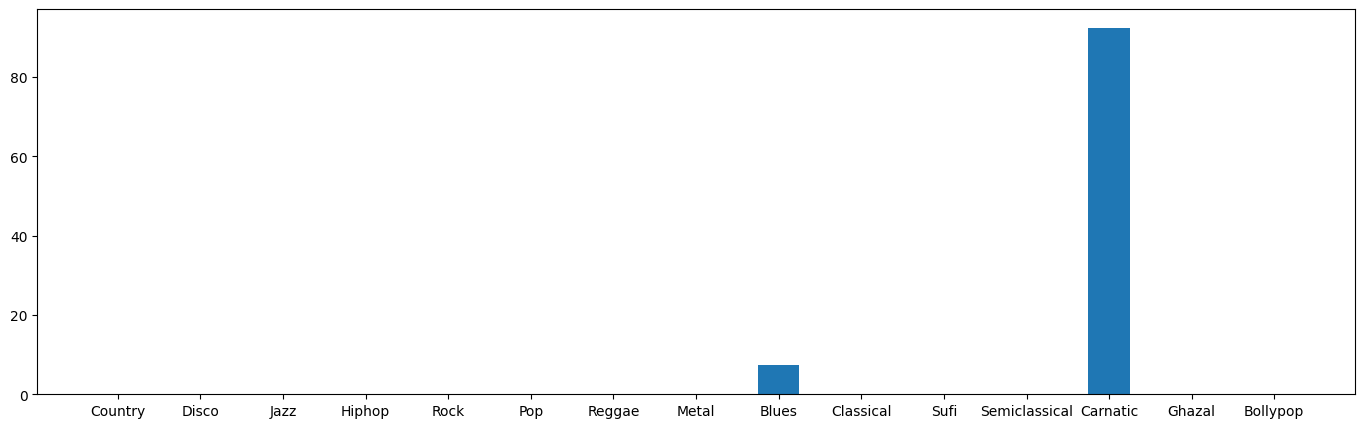

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          9.12215762
 65.16412381  0.         25.71371856]


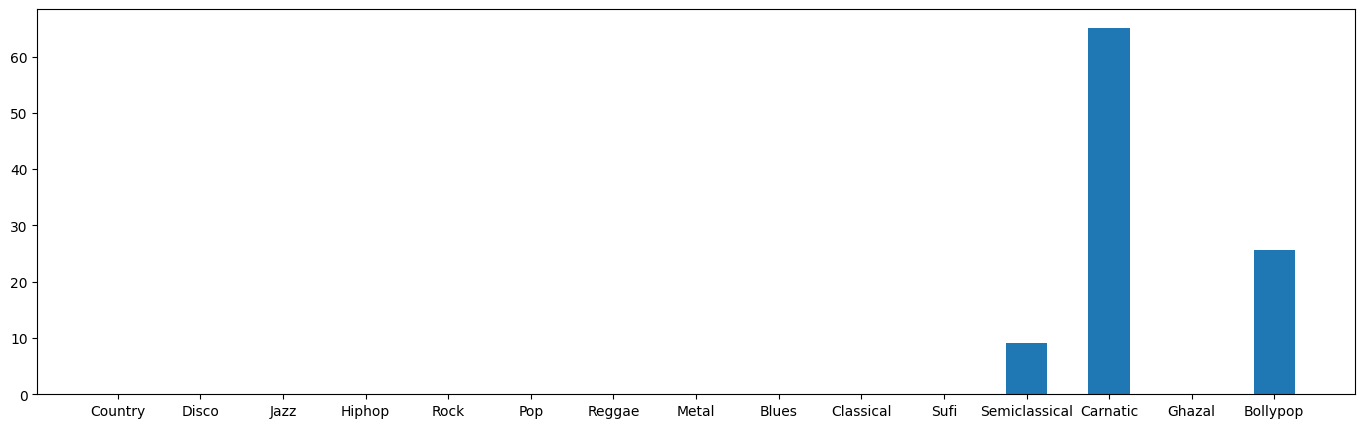

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.]


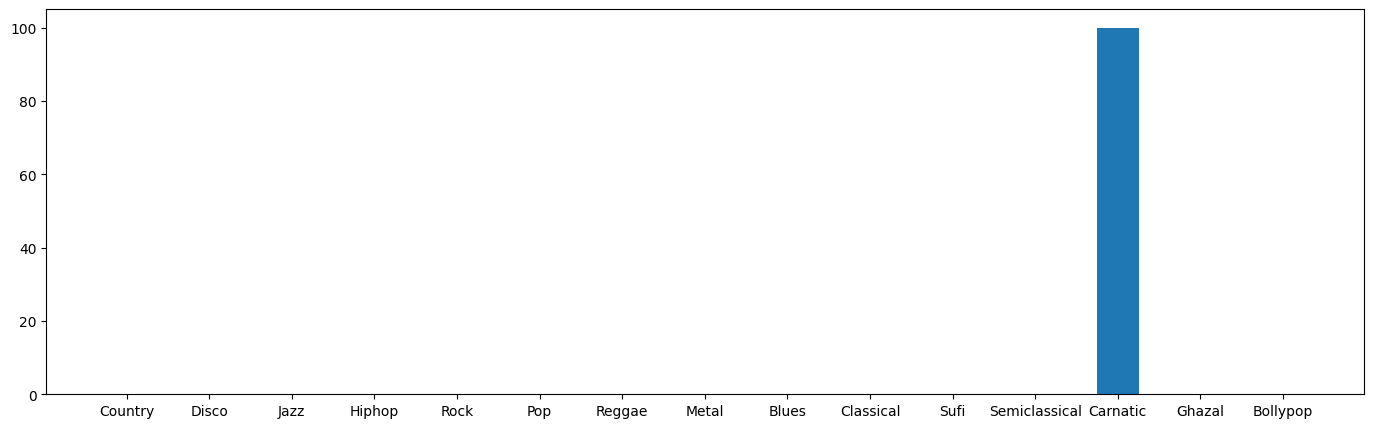

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         10.47867291
 18.18144531 71.33988178  0.        ]


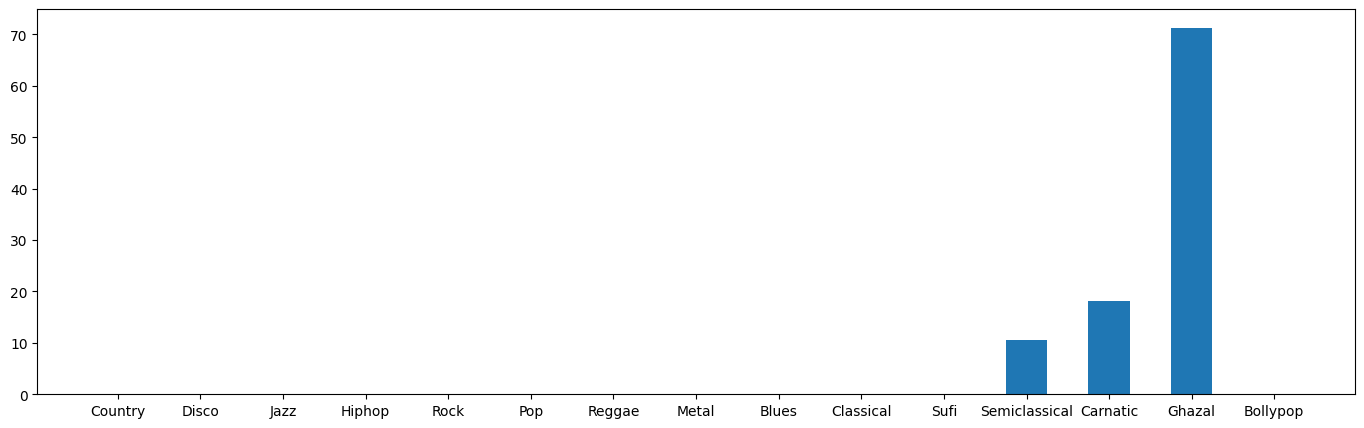

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         15.11555553  0.
  0.         84.88444447  0.        ]


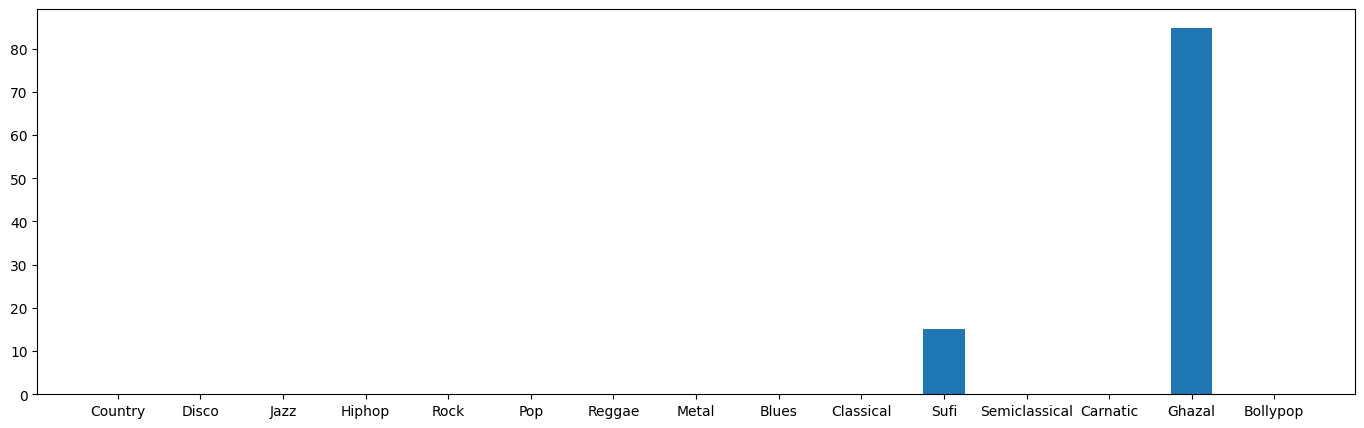

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


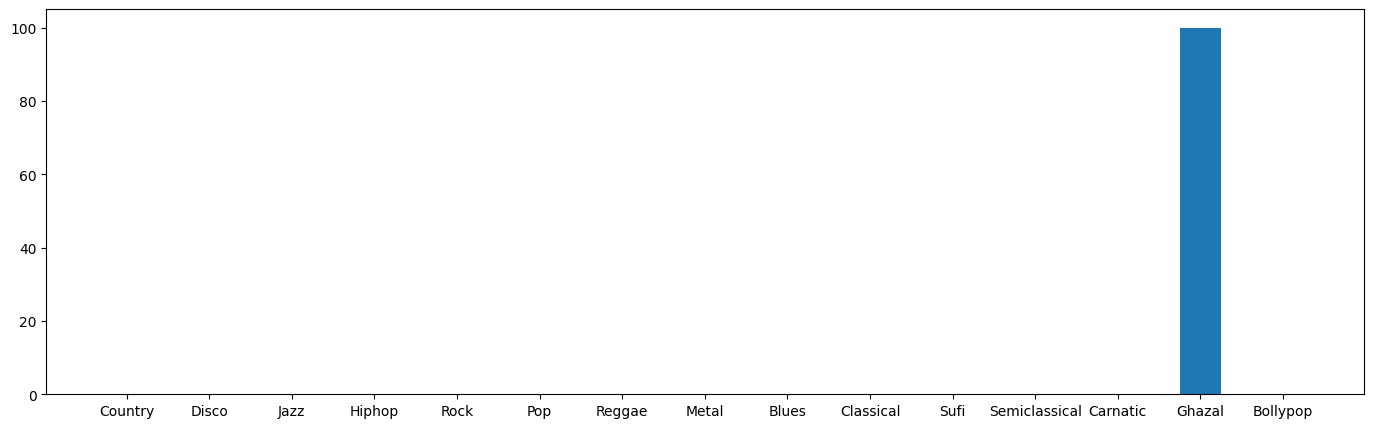

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 25.42119998 74.57880002  0.        ]


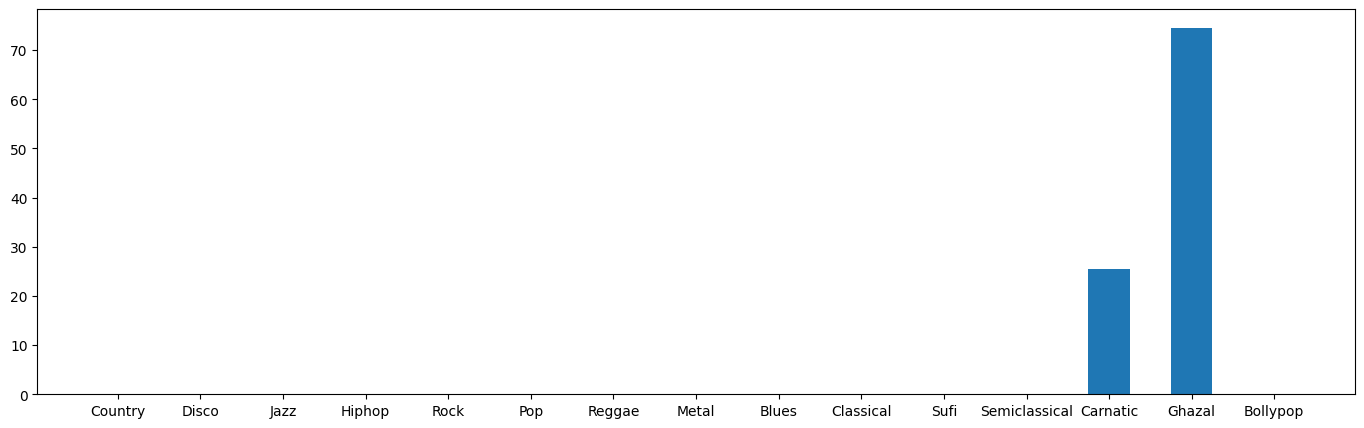

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


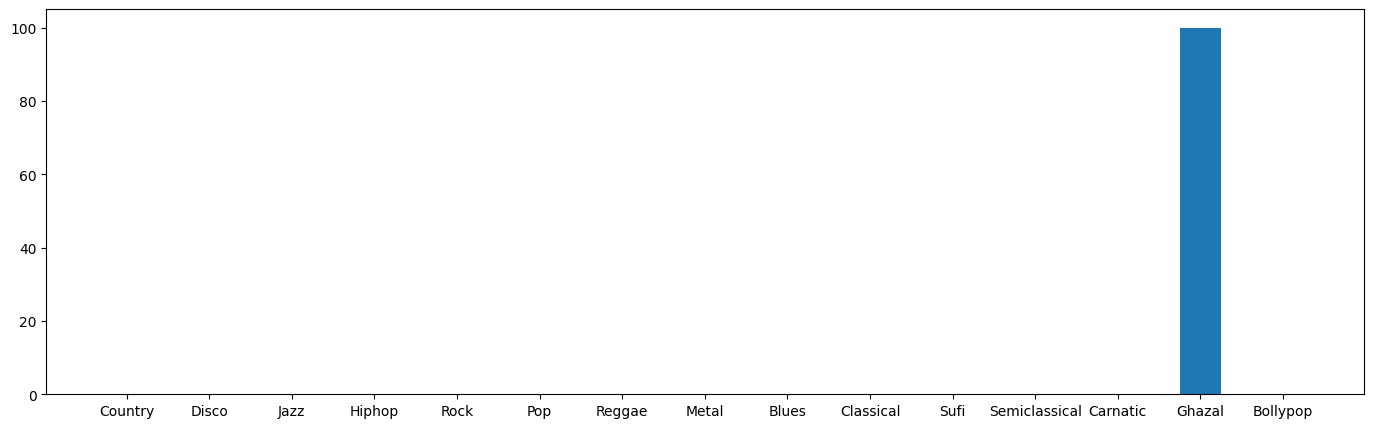

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


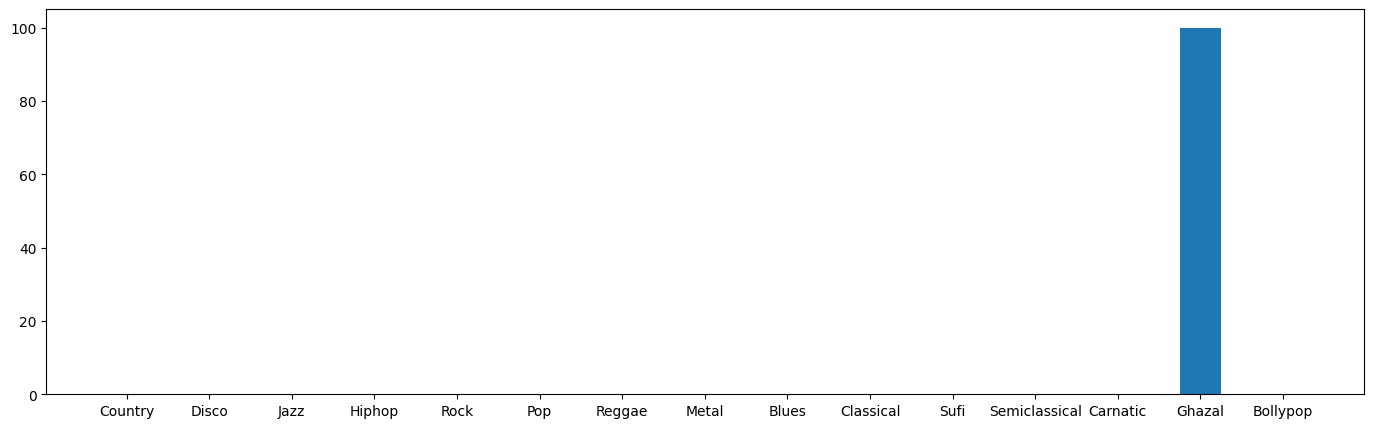

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


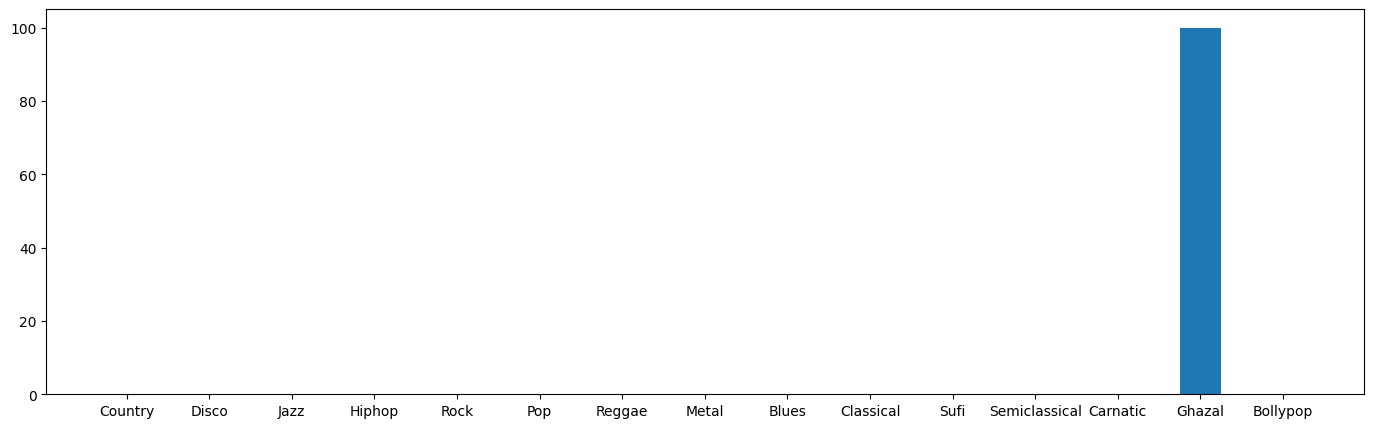

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         40.61495343  0.
  0.         59.38504657  0.        ]


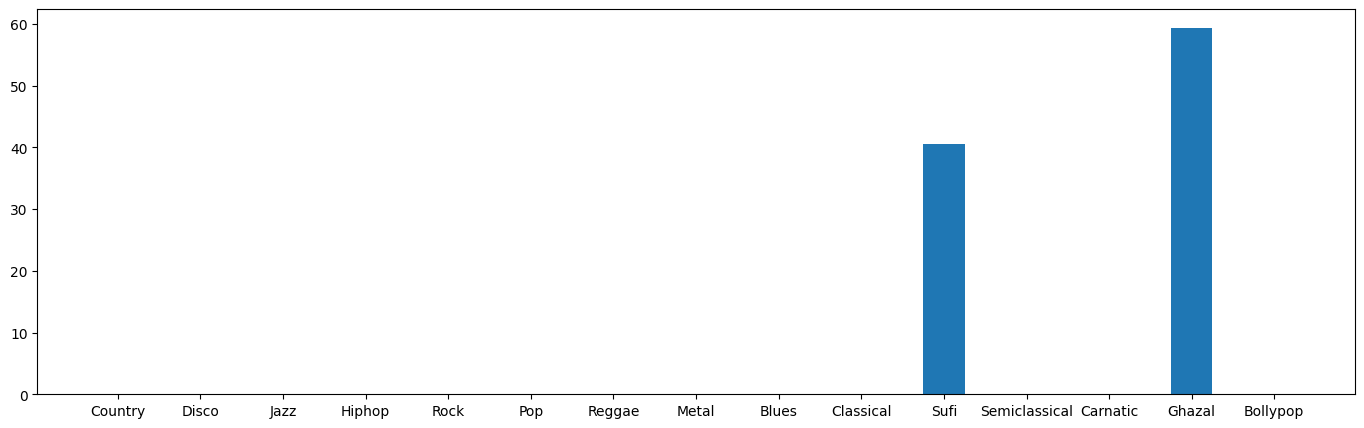

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         87.76327396 12.23672604]


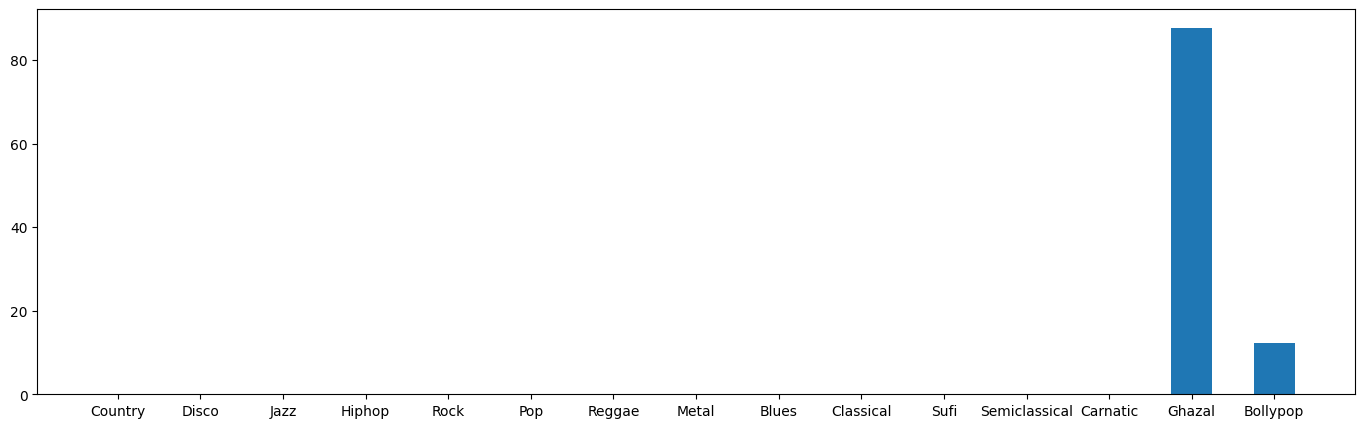

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         24.10944664
  0.         75.89055336  0.        ]


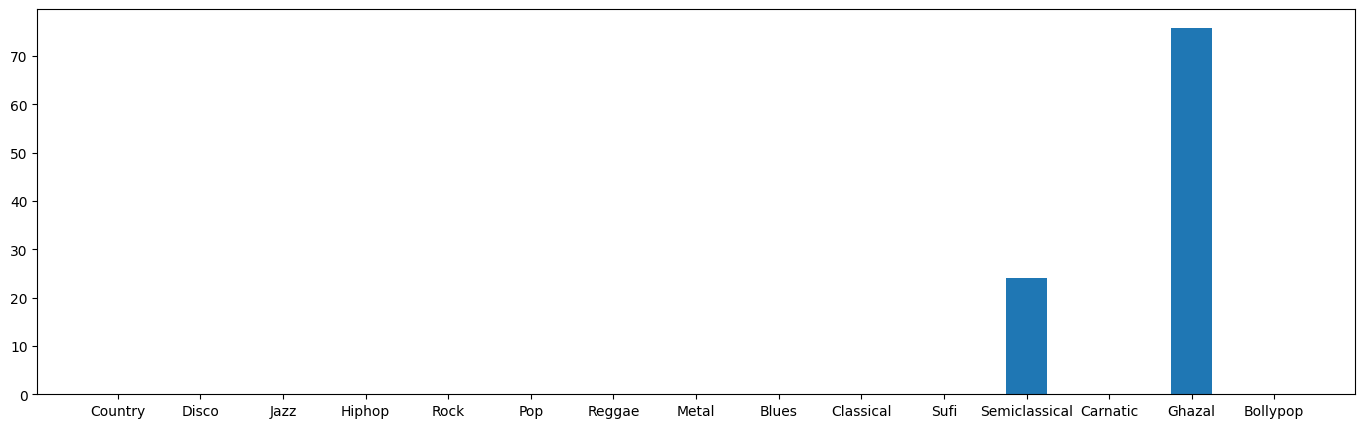

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         22.23051885  0.
  0.         77.76948115  0.        ]


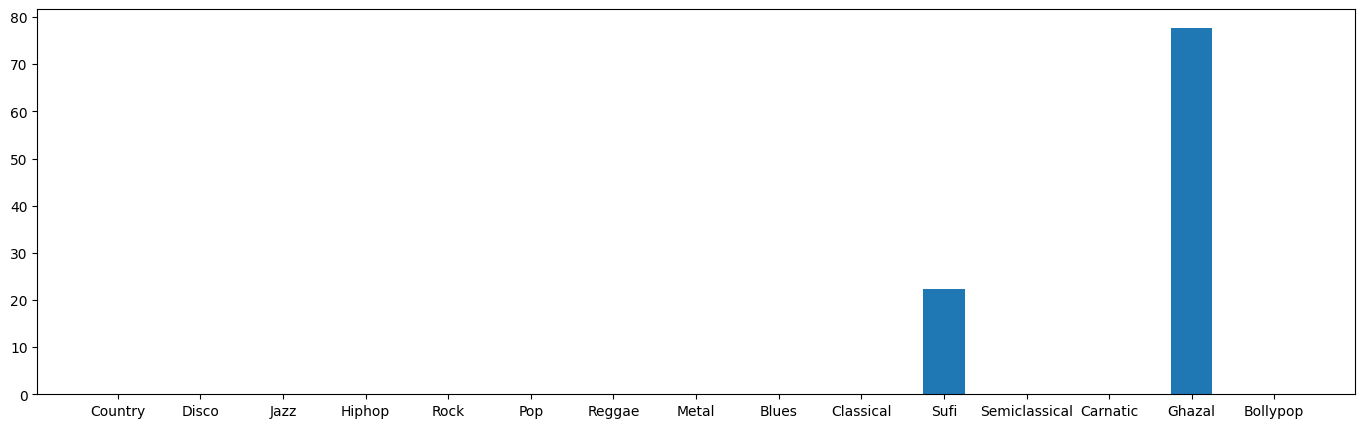

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


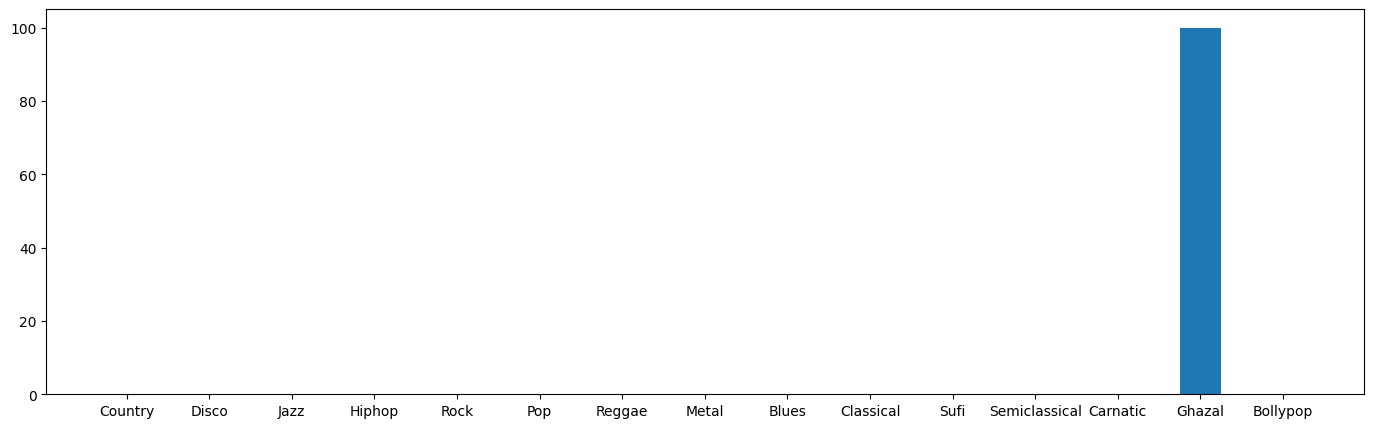

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


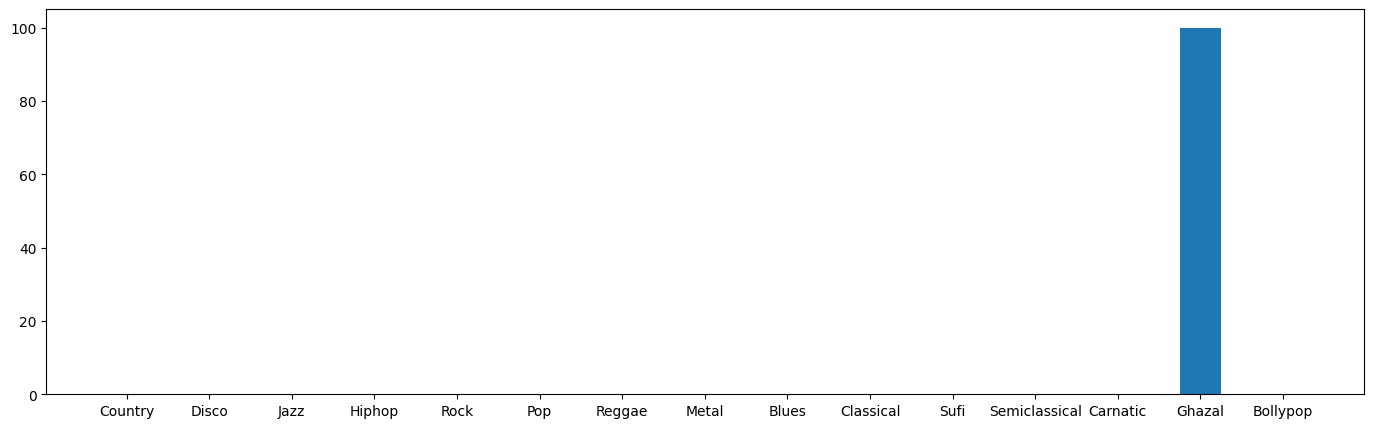

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


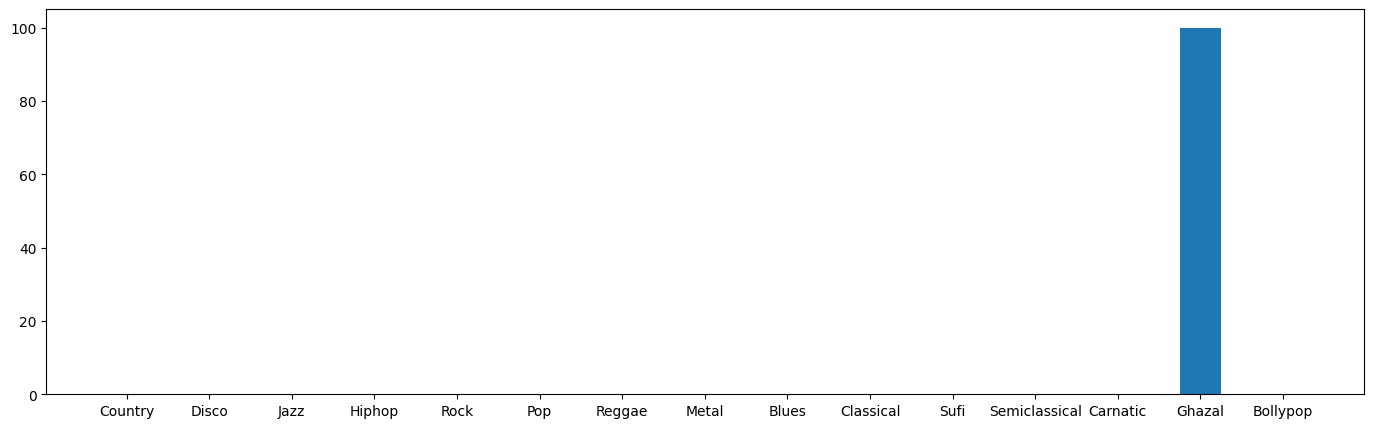

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


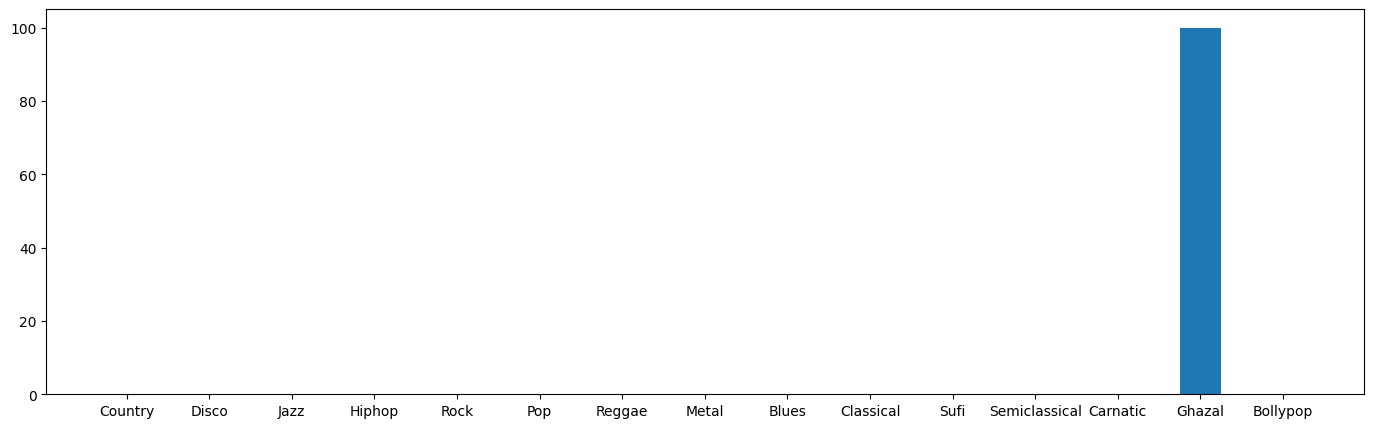

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


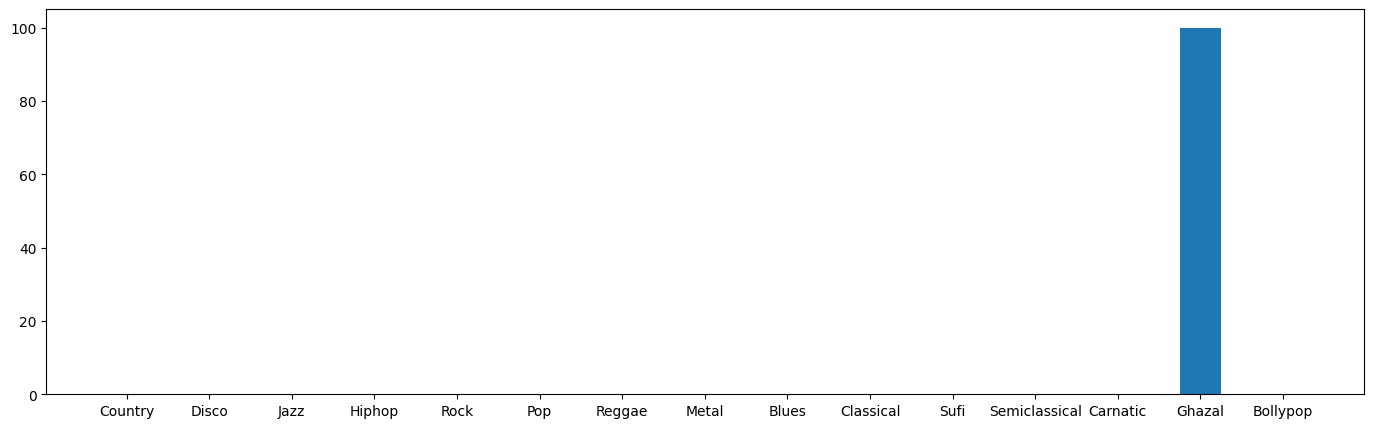

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         28.26693643  0.
  0.         71.73306357  0.        ]


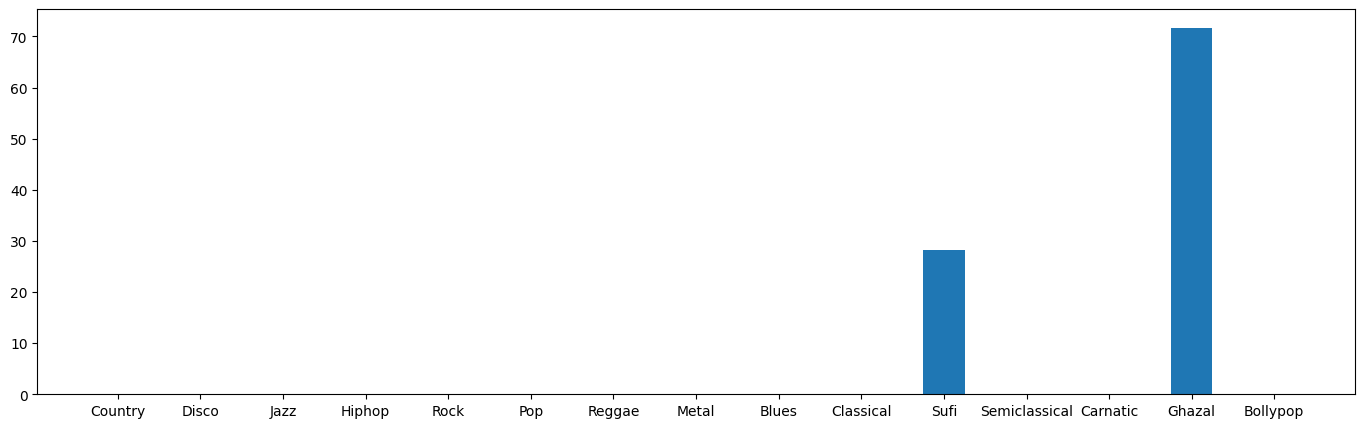

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 32.7920837  47.03363414 20.17428216]


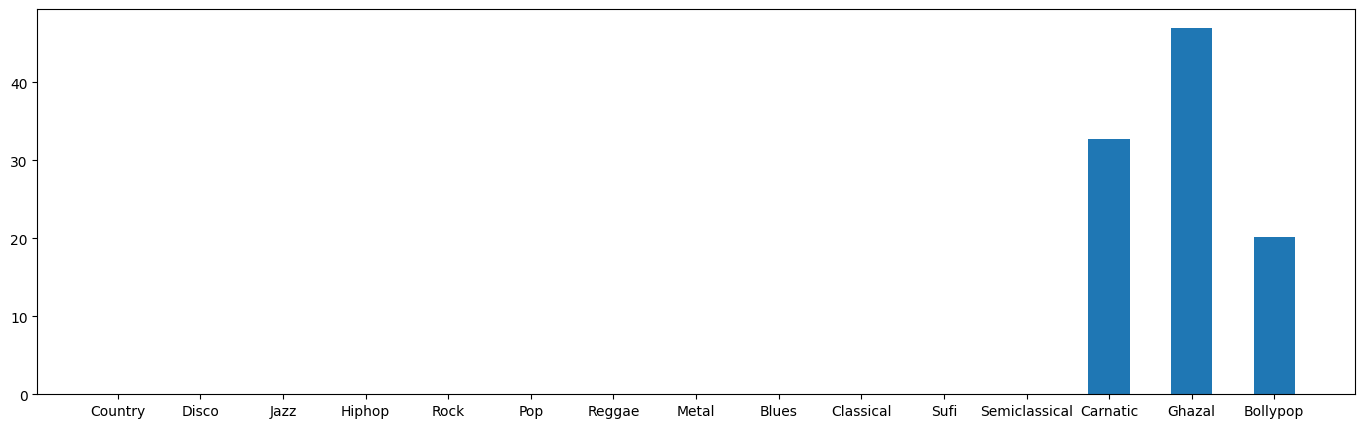

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


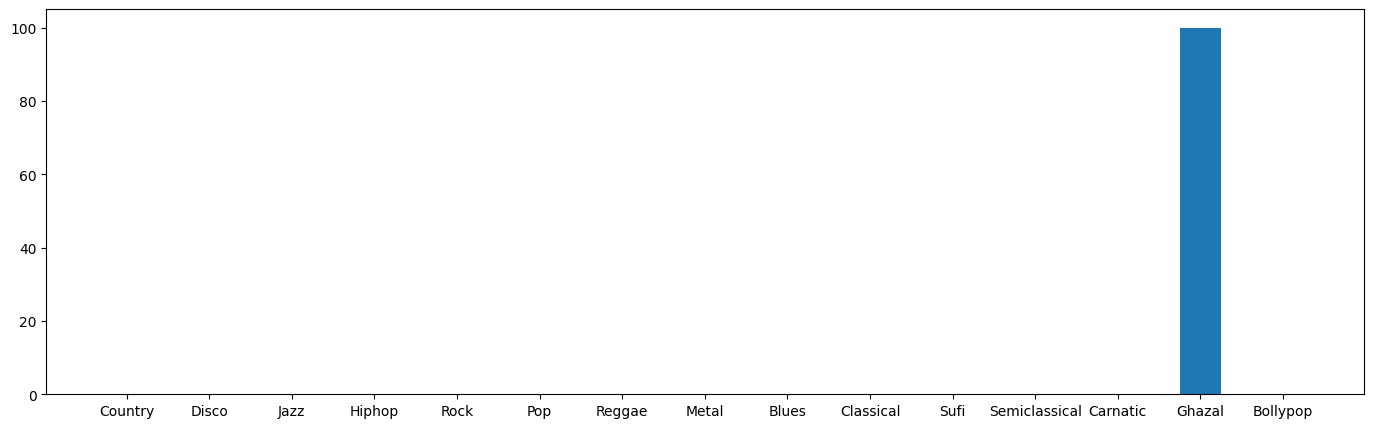

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          8.50043766
  0.         91.49956234  0.        ]


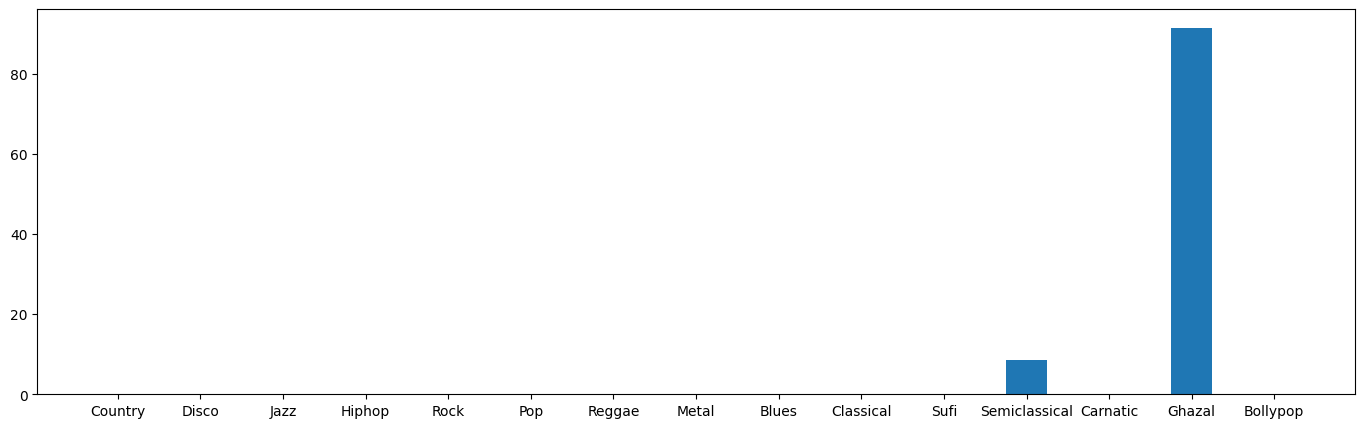

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


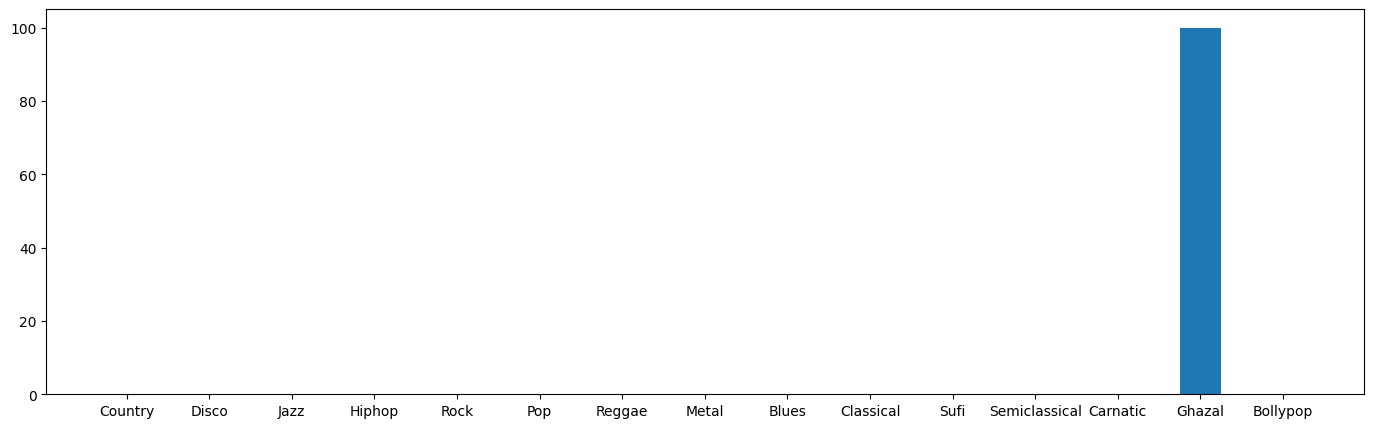

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


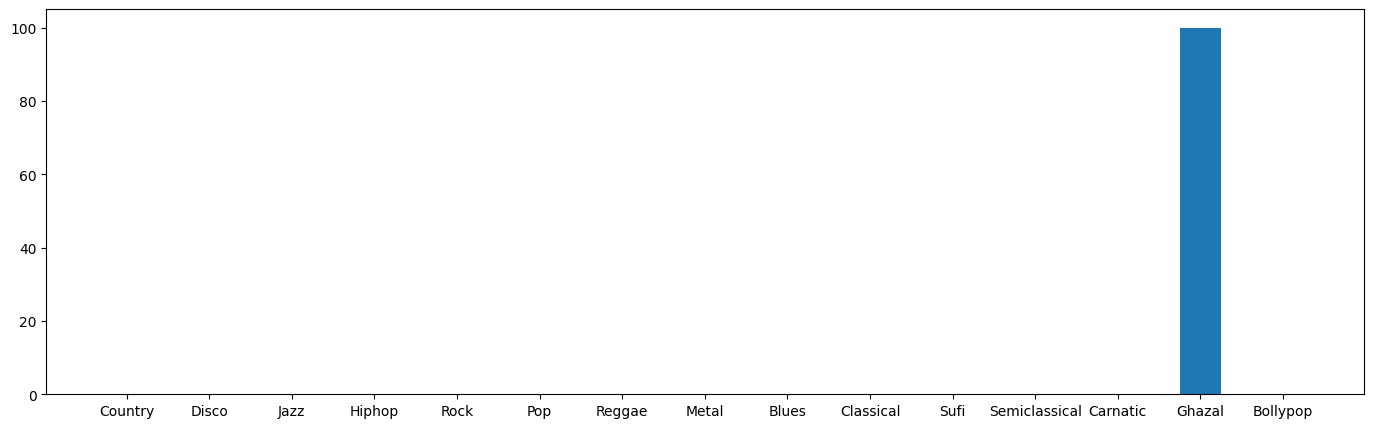

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


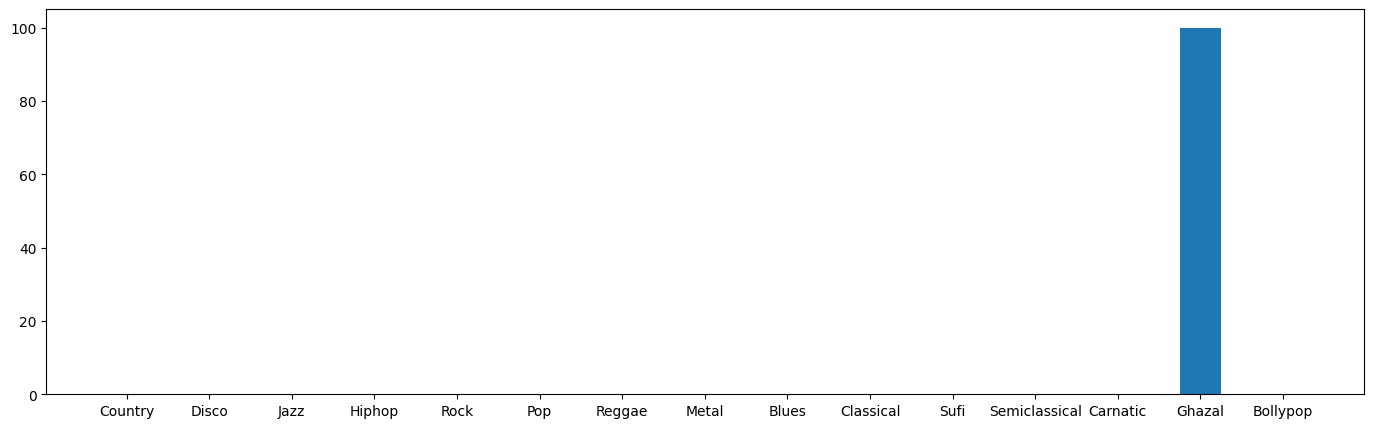

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.69287959  0.
 17.97869042 63.32842998  0.        ]


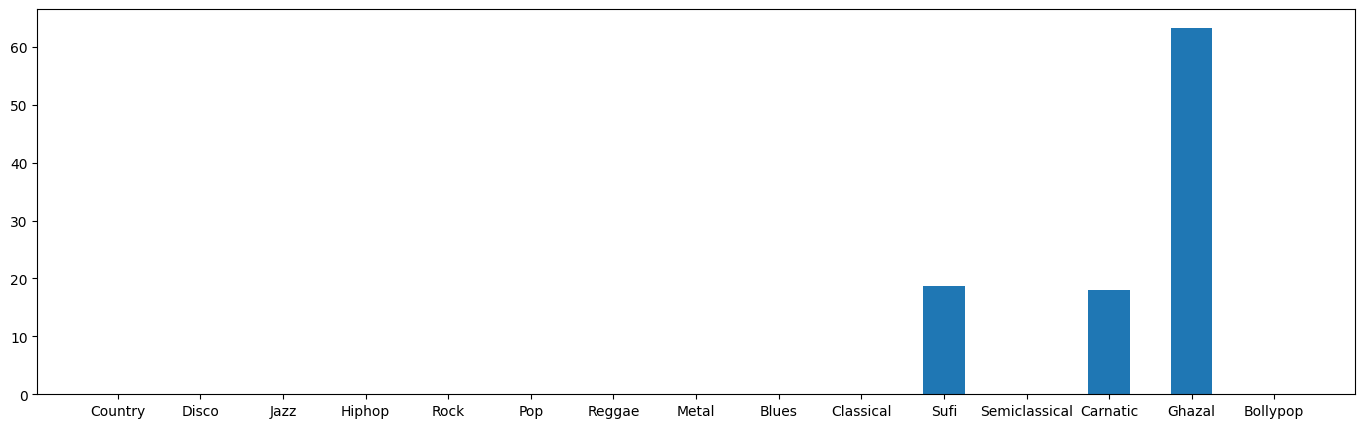

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


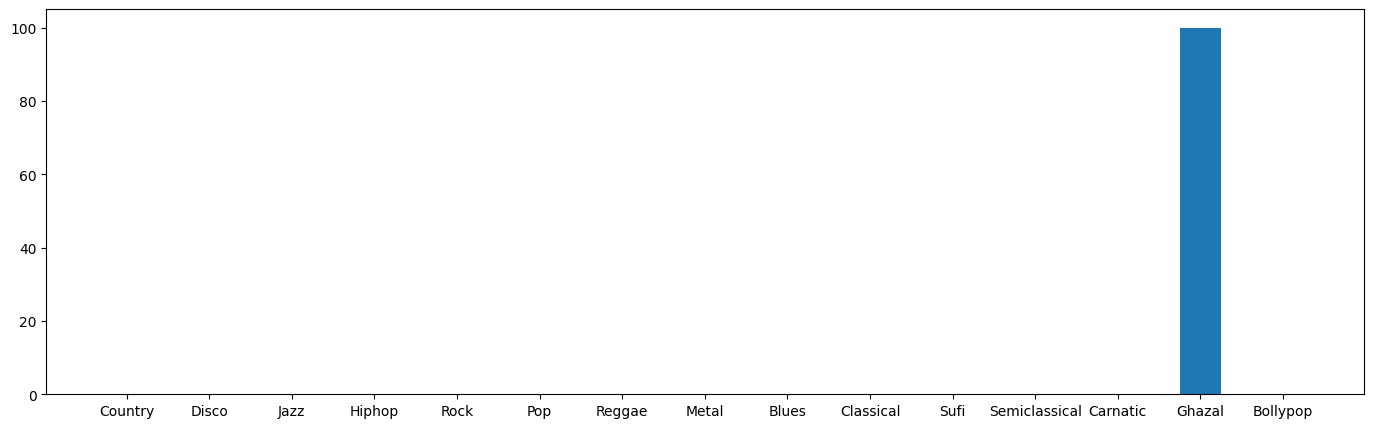

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         17.53075133  0.
  0.         82.46924867  0.        ]


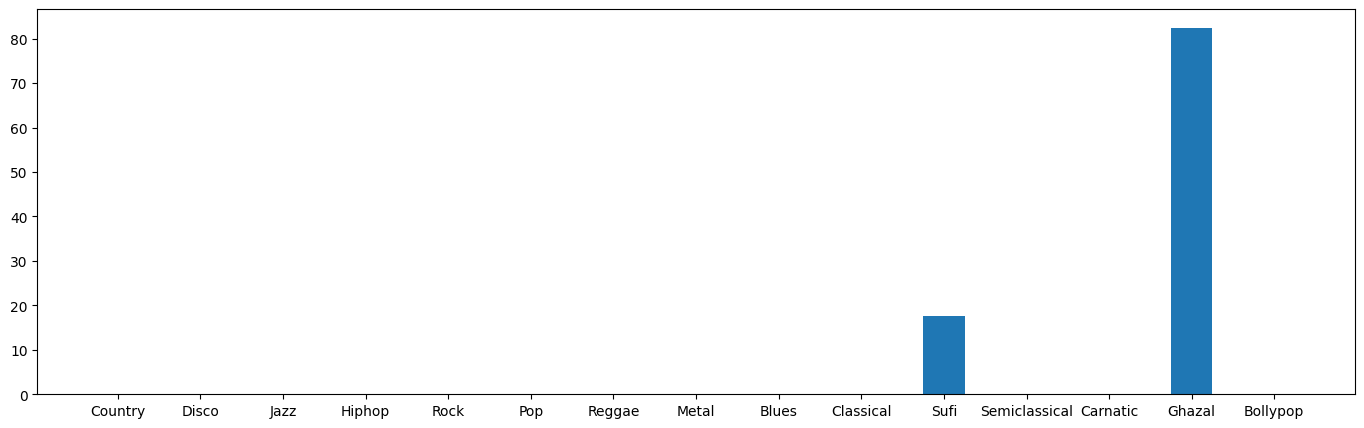

[ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         6.3555849  0.
  0.        93.6444151  0.       ]


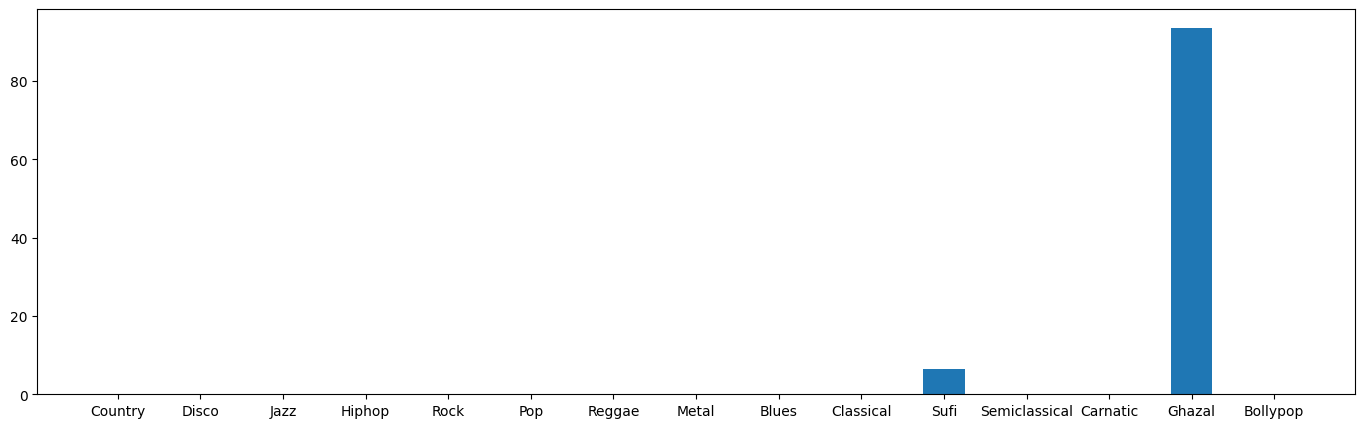

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.]


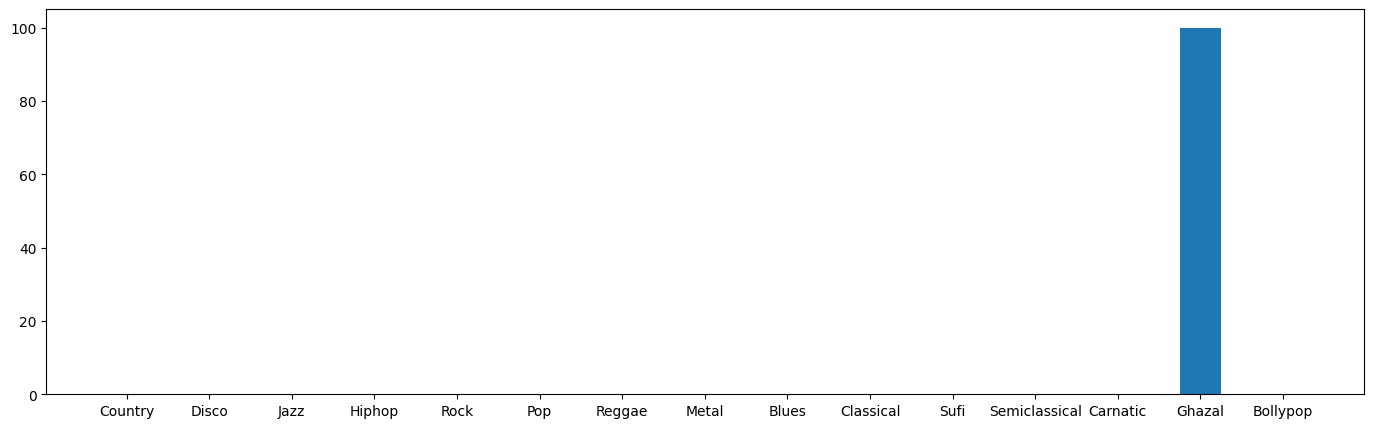

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


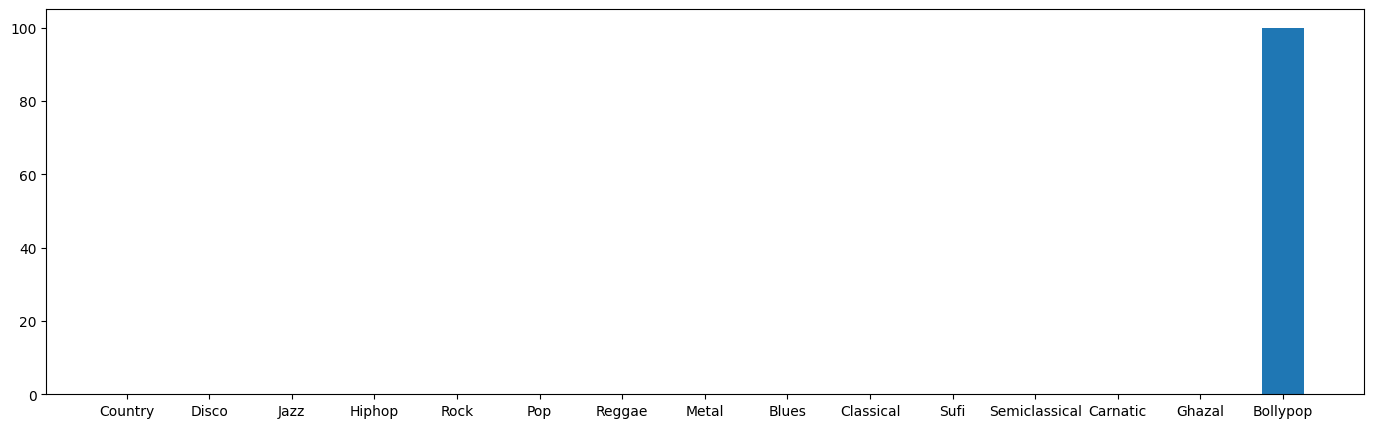

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         16.93336917  0.
  0.          0.         83.06663083]


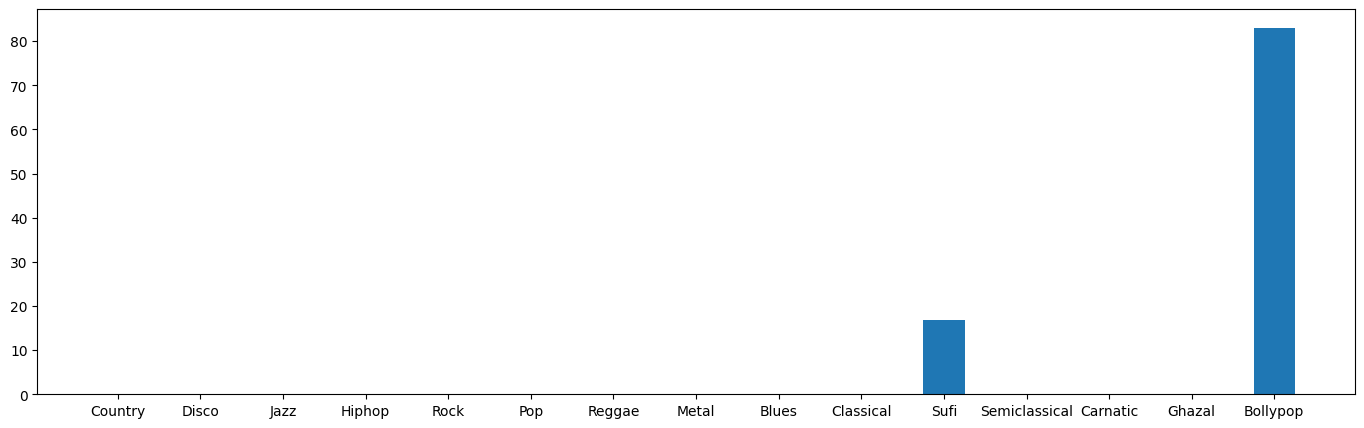

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


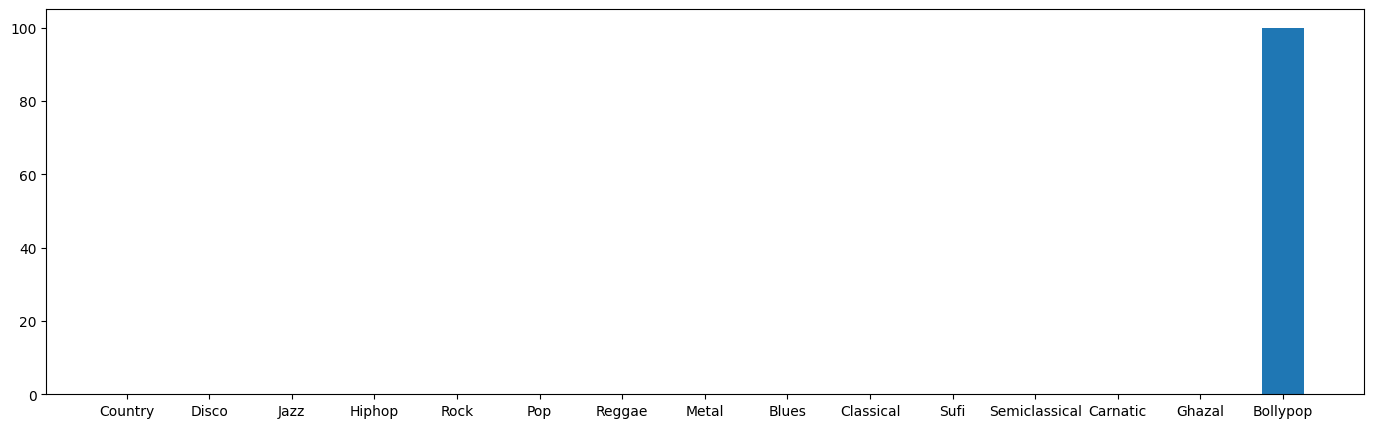

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


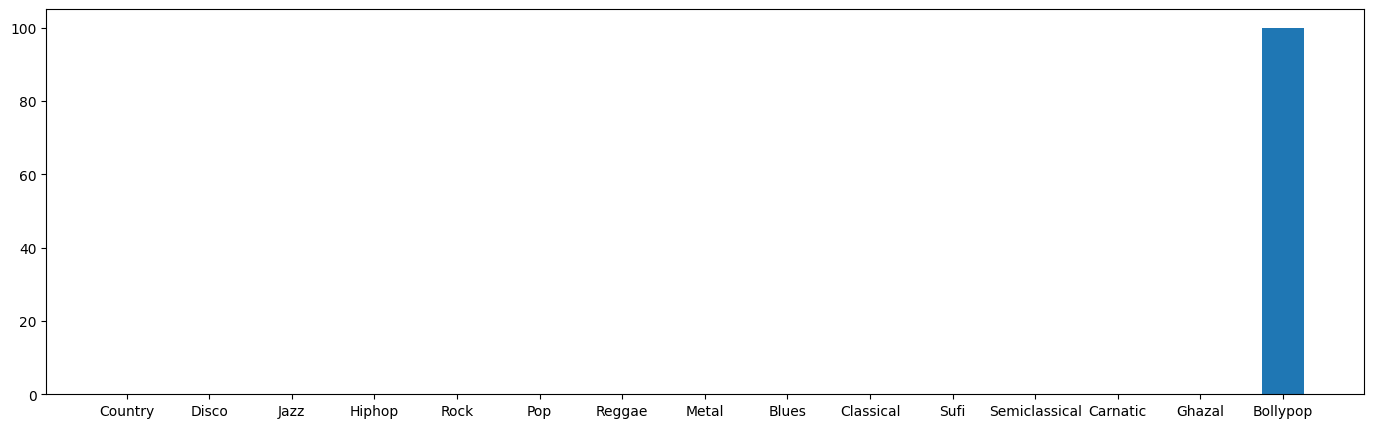

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         20.84402081 18.42675655
  0.          0.         60.72922264]


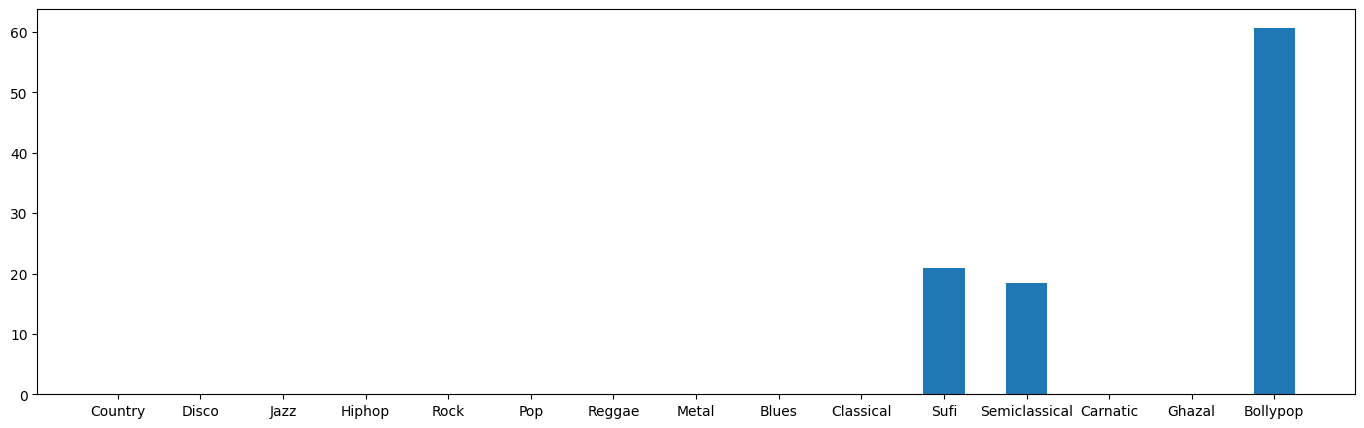

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.50876362  0.
  0.          0.         81.49123638]


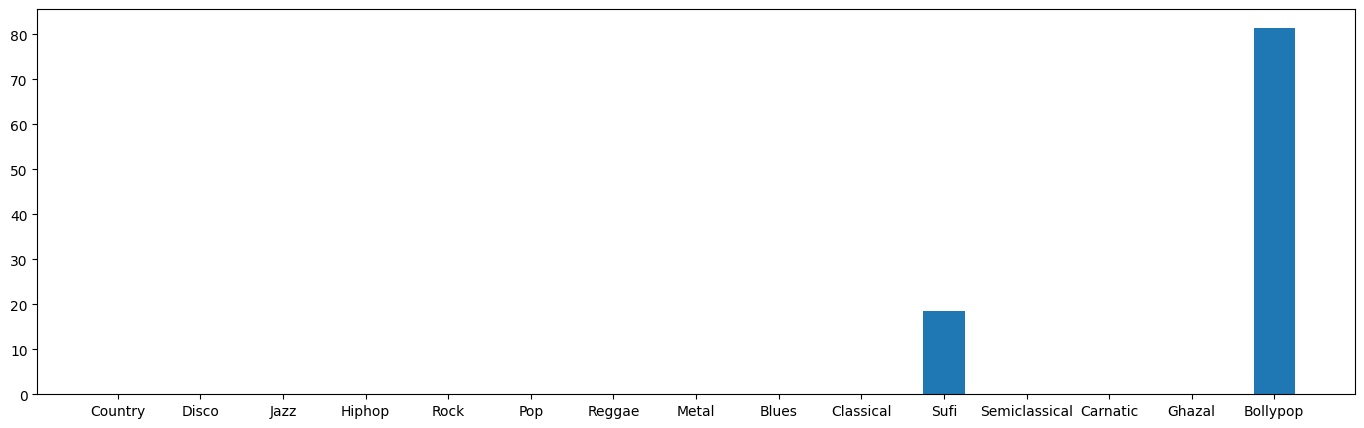

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


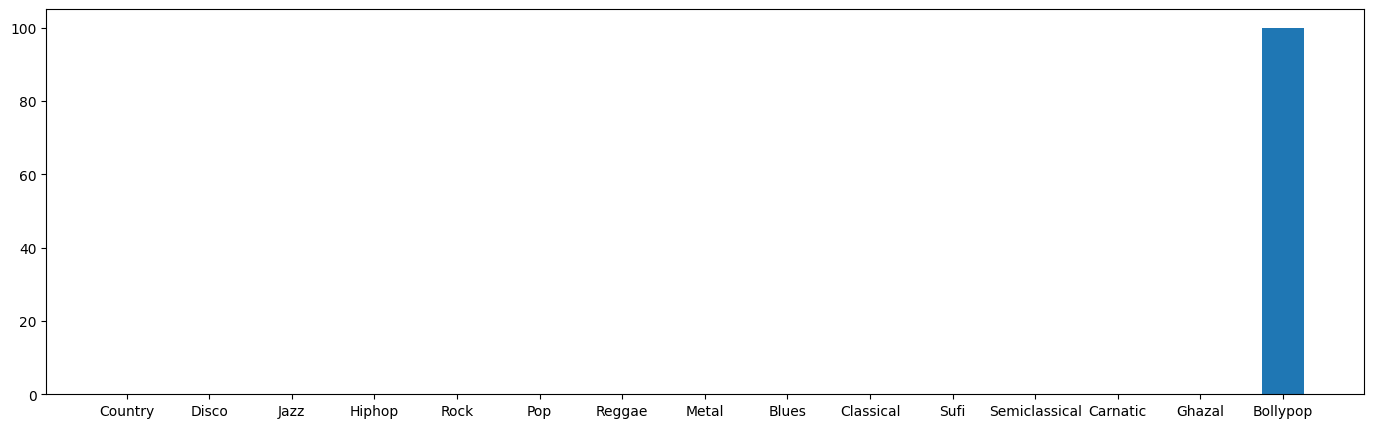

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         12.41958385 30.60118764
  0.          0.         56.97922851]


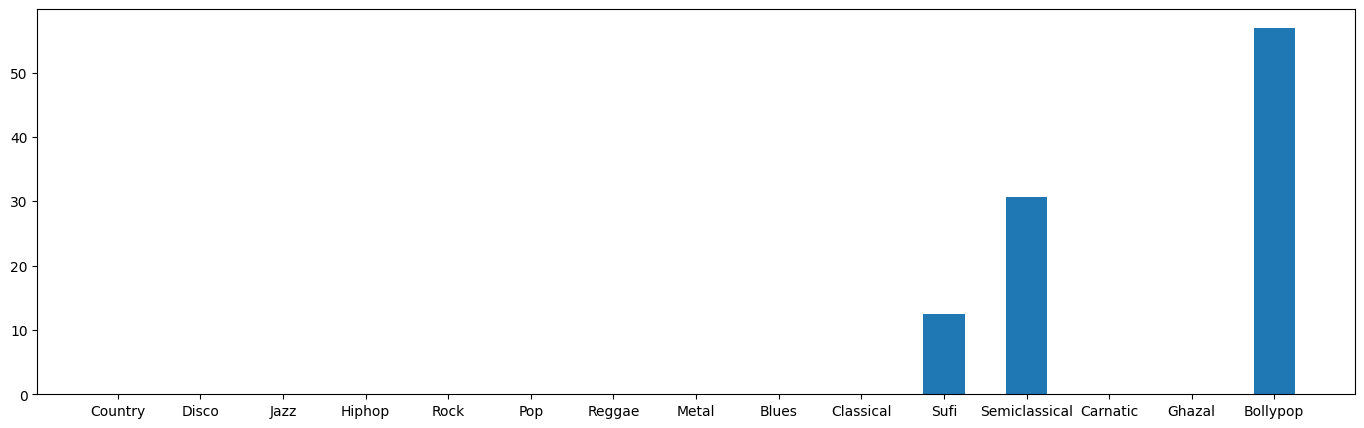

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


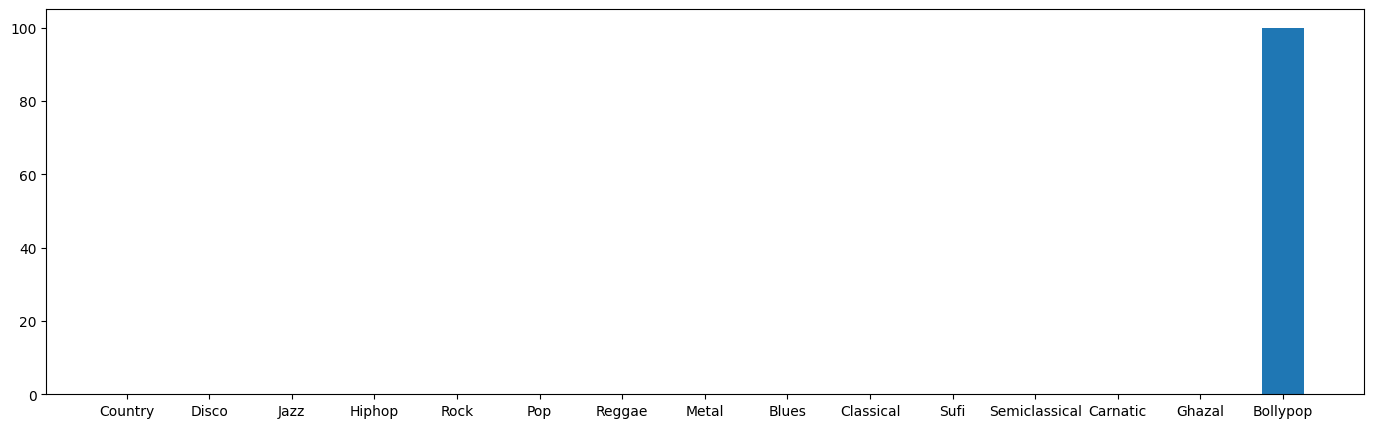

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.11854365 16.01227832
  0.          0.         65.86917802]


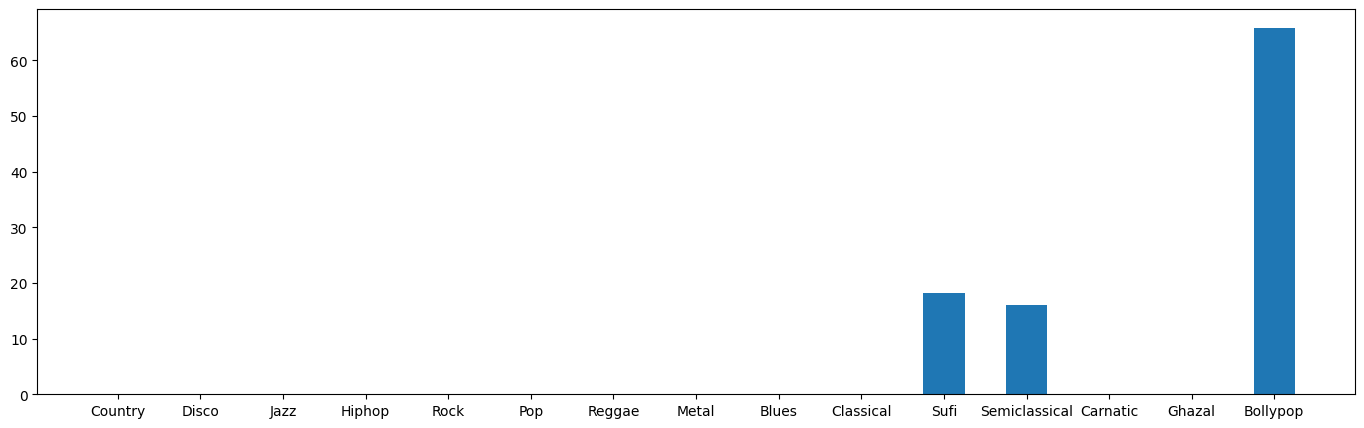

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         21.69960204
  0.          0.         78.30039796]


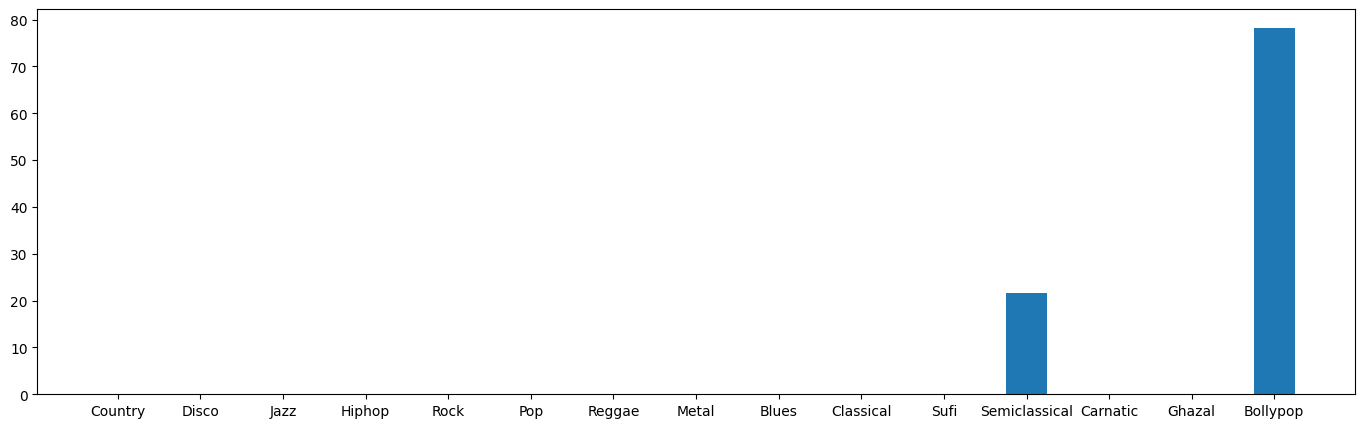

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         36.99986645  0.
  0.          0.         63.00013355]


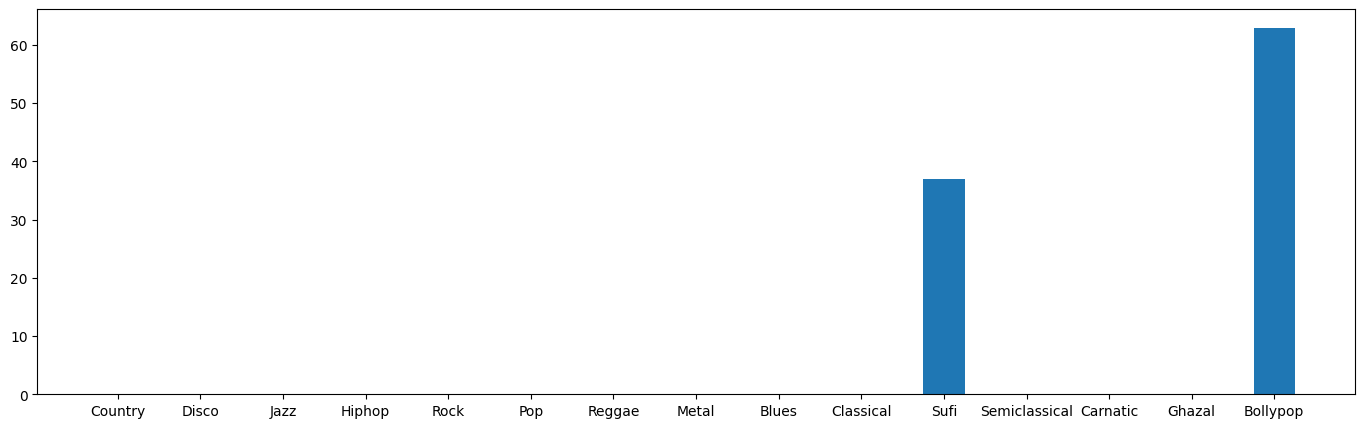

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         20.66323072  0.
  0.          0.         79.33676928]


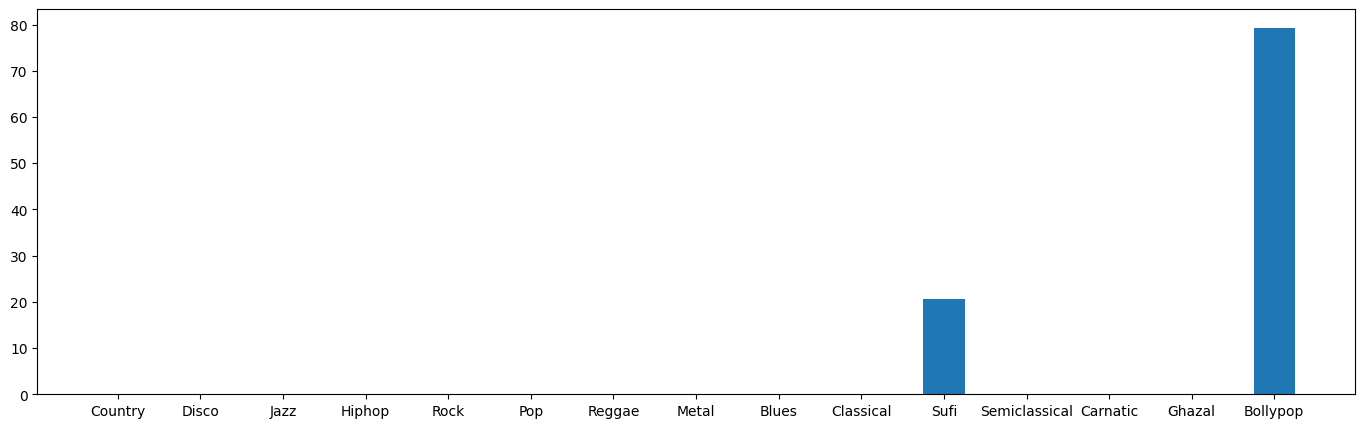

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         19.18512069  0.
  0.          0.         80.81487931]


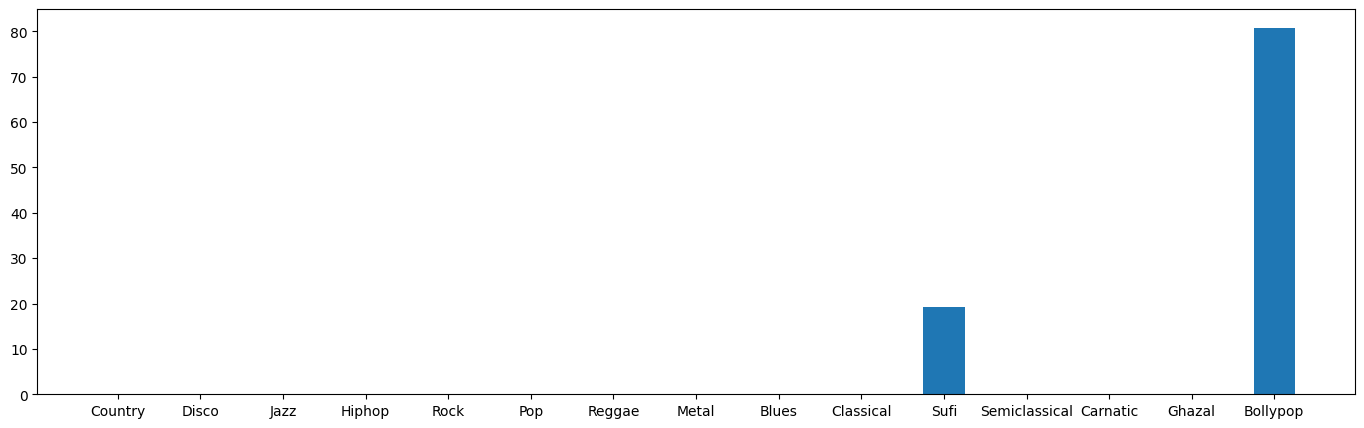

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         34.25577426
  0.          0.         65.74422574]


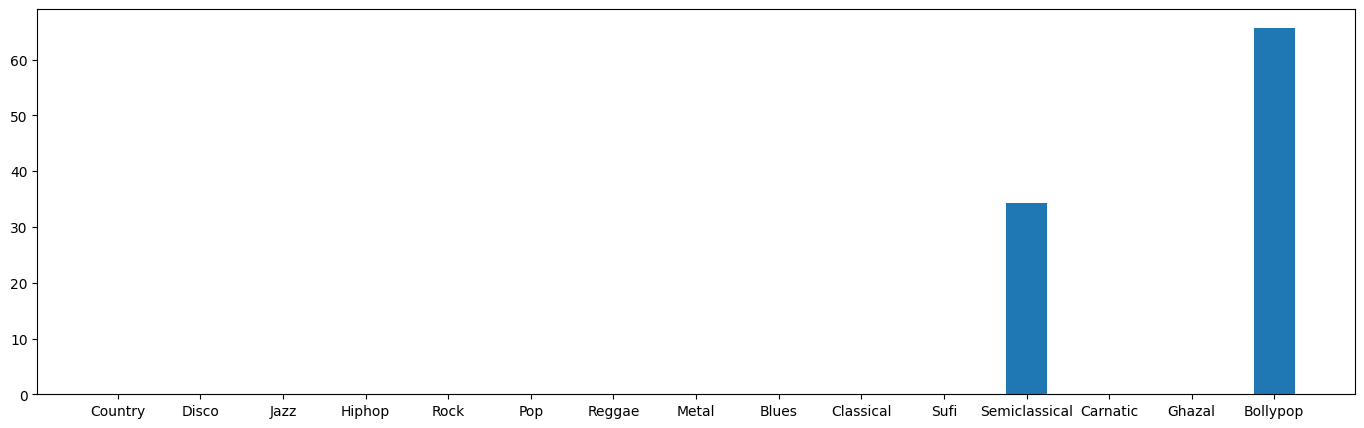

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         34.39950981 20.52585118
  0.          0.         45.07463901]


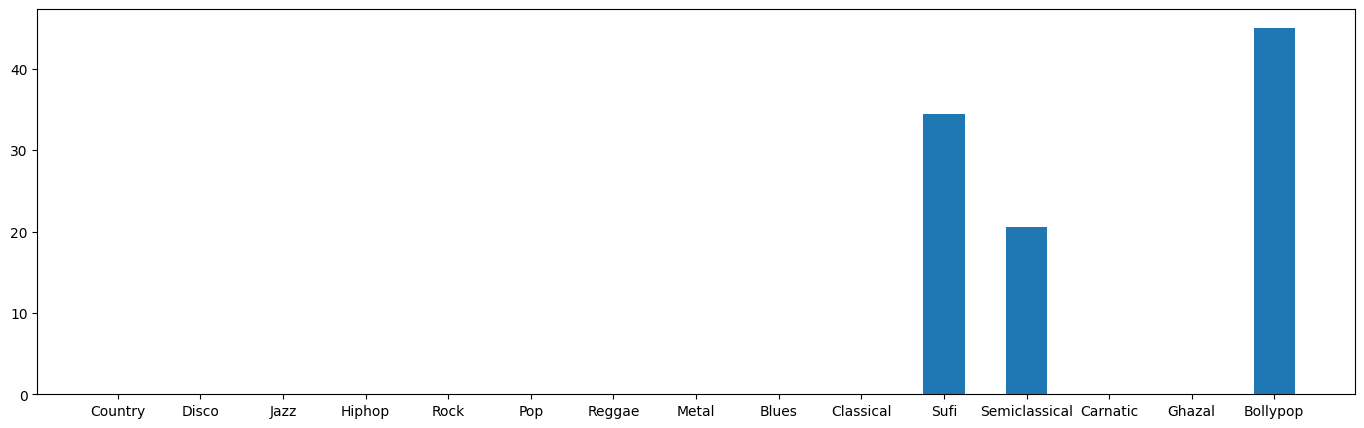

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         40.83431115
  0.          0.         59.16568885]


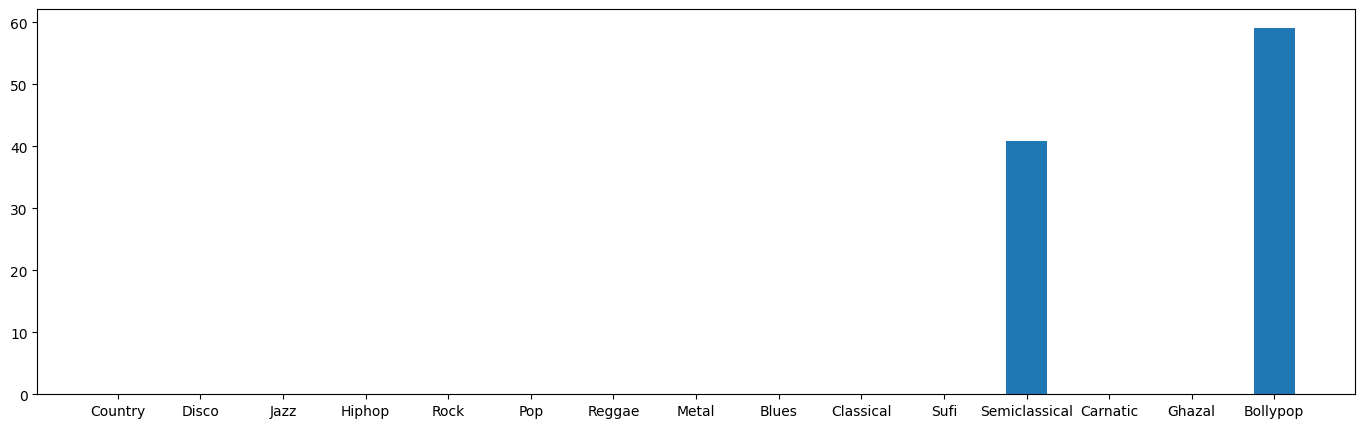

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         42.96579145
  0.          0.         57.03420855]


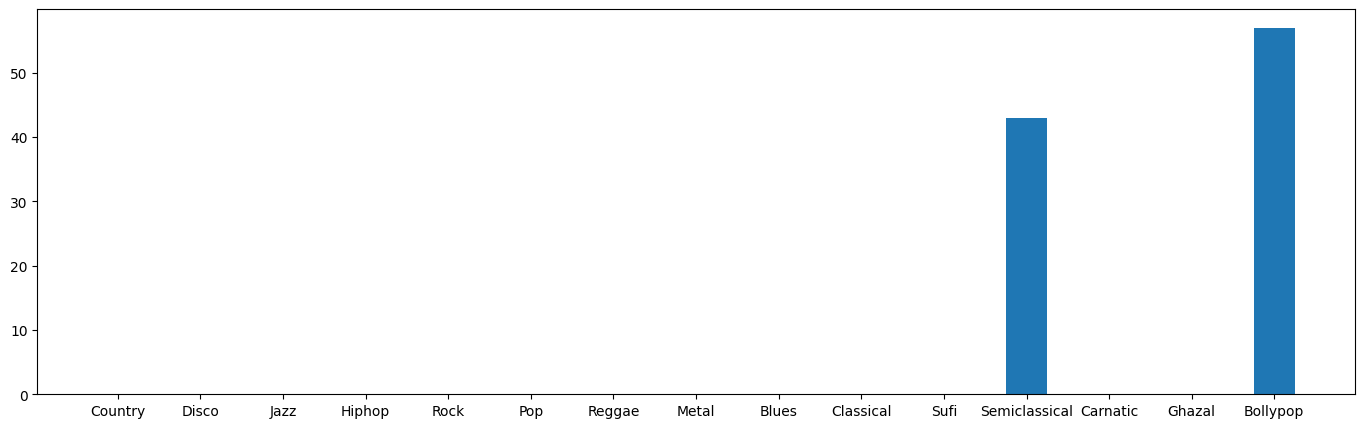

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         17.89639953 62.78658722
  0.          0.         19.31701325]


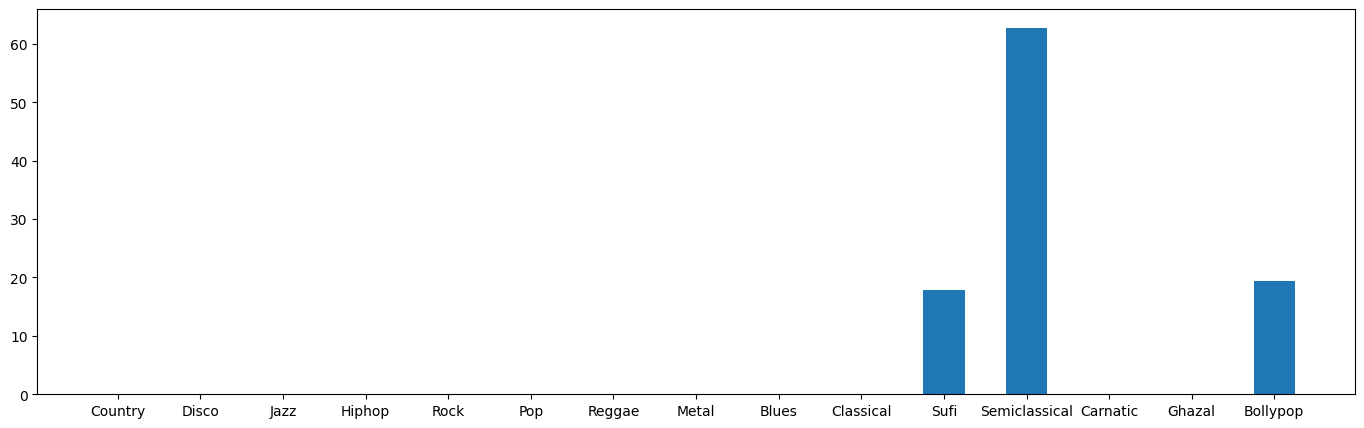

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         19.26875868  0.
  0.          0.         80.73124132]


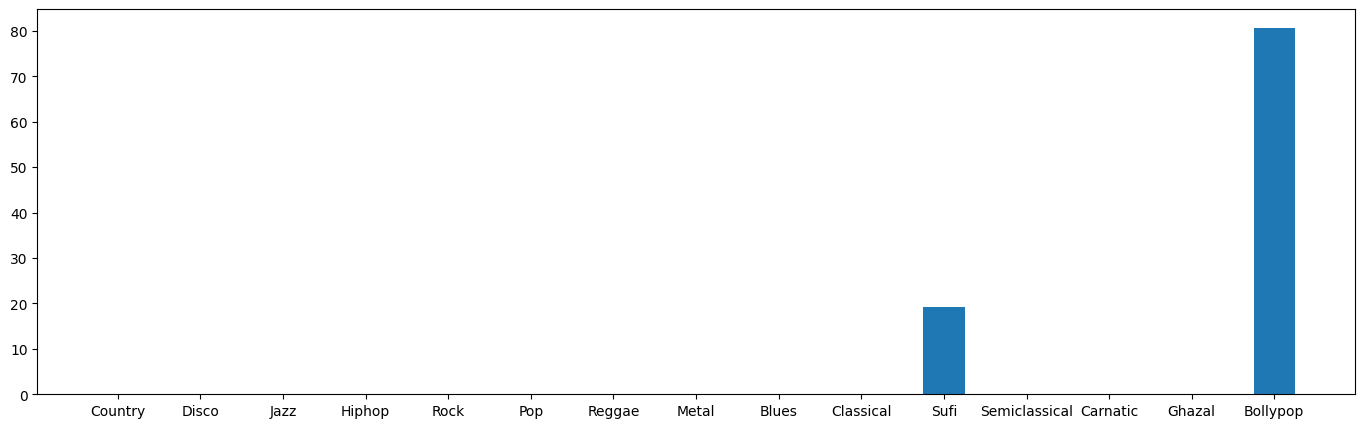

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         18.54725778 18.63885122
  0.          0.         62.813891  ]


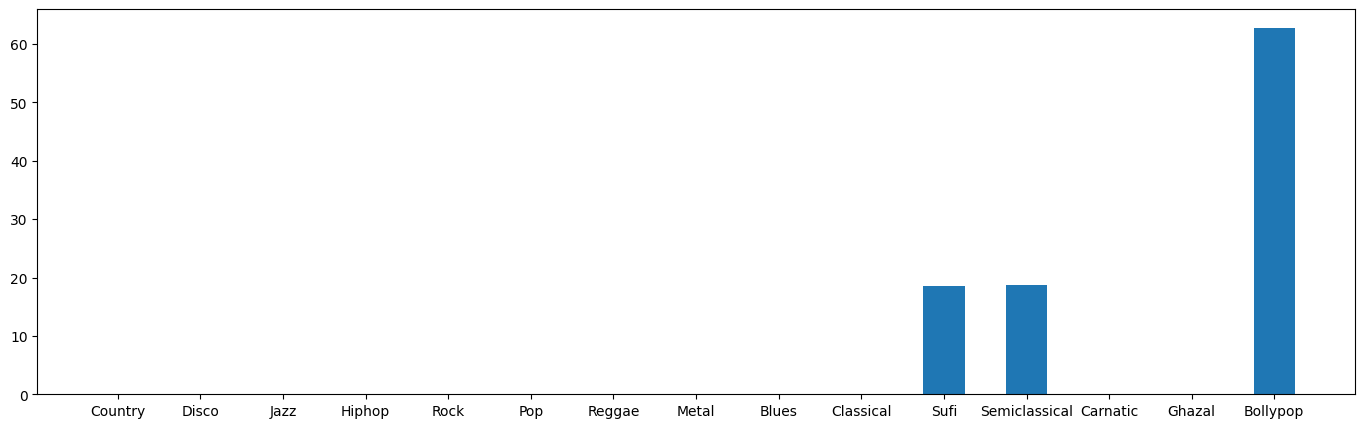

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 100.]


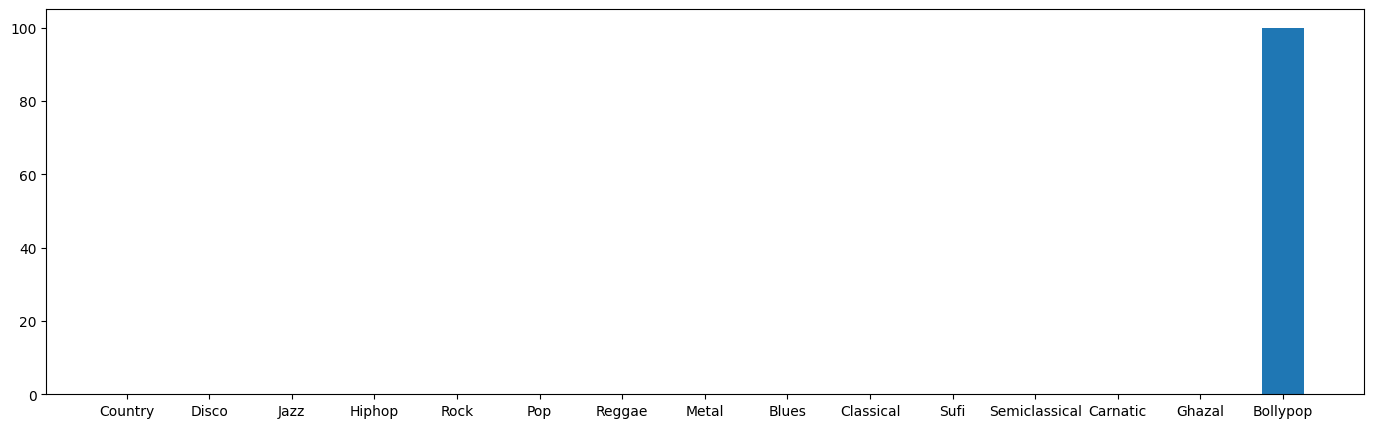

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         20.56335213  0.
  0.          0.         79.43664787]


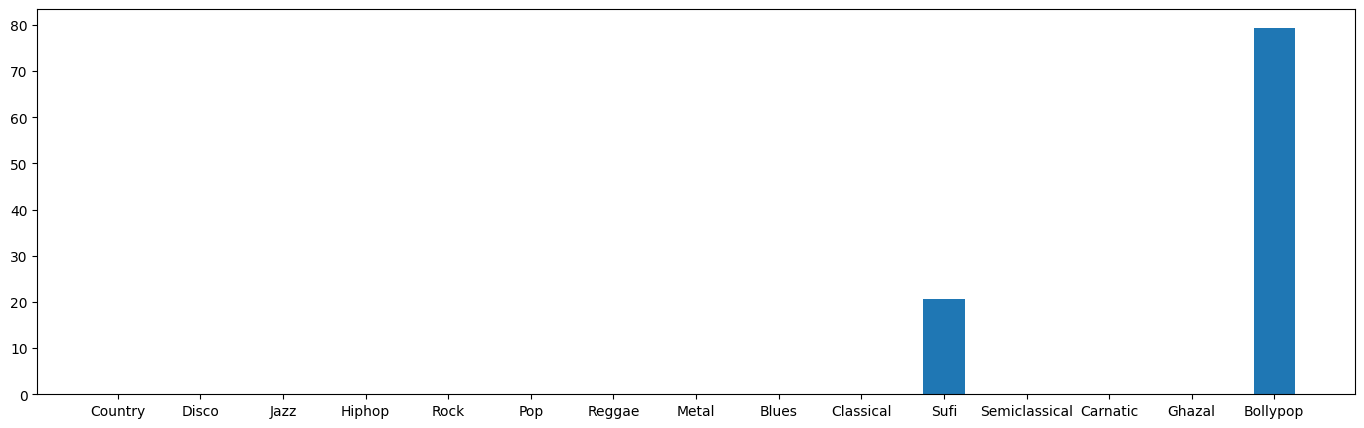

0.7069408740359897


In [ ]:
length = len(testSet)
predictions = []
for x in range(length):
    #predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))
    predictions.append(getNeighbors_fuzzy(trainingSet, testSet[x], 5))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

###Prediction of Genre:

In [ ]:
#results = {0:"bollypop",1:"carnatic",2:"ghazal",3:"semiclassical",4:"rock",5:"pop",6:"reggae",7:"metal",8:"blues",9:"classical", 10:"sufi", 11:"semiclassical", 12:"carnatic", 13:"ghazal", 14:"bollypop"}

In [ ]:
test_file = "/content/drive/MyDrive/Major Project/sample songs/country.00001.wav"

converted_file = "converted_file.wav"

sound = AudioSegment.from_mp3(test_file)
sound.export(converted_file, format="wav")

<_io.BufferedRandom name='converted_file.wav'>

[ 0.29504395  0.23028564 -0.04922485 ... -0.31478882 -0.06835938
  0.13323975]
[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.]


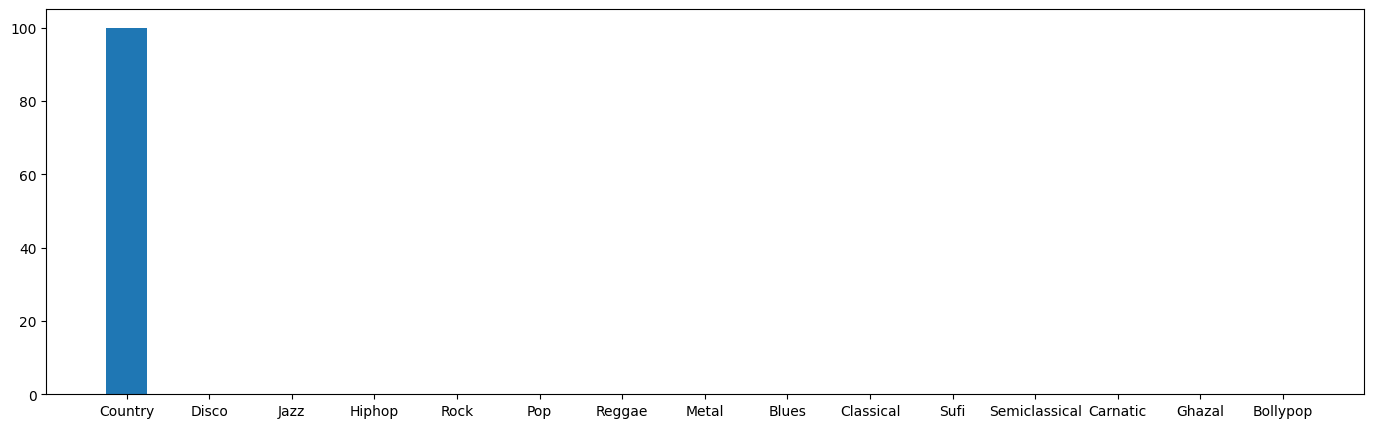

country


In [ ]:
import librosa
output_file = "/content/converted_file.wav"

#(rate,sig)= wav.read(output_file)
sig, rate = librosa.load(output_file, sr=22050)
sig = sig
print(sig)
#mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False, nfft=2048)
mfcc_feat = librosa.feature.mfcc(y=sig, sr = rate, n_mfcc=13,hop_length=512, n_fft=2048)
mfcc_feat = mfcc_feat.T
covariance = np.cov(np.matrix.transpose(mfcc_feat))
mean_matrix = mfcc_feat.mean(0)
feature = (mean_matrix, covariance, 0)

#predict the results
pred = getNeighbors_fuzzy(dataset, feature, 5)
#pred = nearestclass(getNeighbors(dataset, feature, 5))
print(results[pred])